In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from tqdm import tqdm

In [2]:
train_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba'
batch_size=16
IMAGES_COUNT = 20000

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
nc = 3

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [5]:
img_file_list = os.listdir(train_path)
img_file_file = [os.path.join(train_path,one) for one in img_file_list]


In [6]:
train_x = np.zeros((IMAGES_COUNT,3,64,64,))

In [7]:
train_tfms = tt.Compose([tt.RandomHorizontalFlip(), 
                          tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                          tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
for i,pic_file  in tqdm(enumerate(img_file_file[:IMAGES_COUNT])):
    train_x[i,:,:,:] = train_tfms(Image.open(pic_file).resize((64, 64)))

20000it [03:31, 94.54it/s] 


In [9]:
train_dl = DataLoader(train_x,batch_size, shuffle=True,num_workers=3, pin_memory=True)

In [10]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

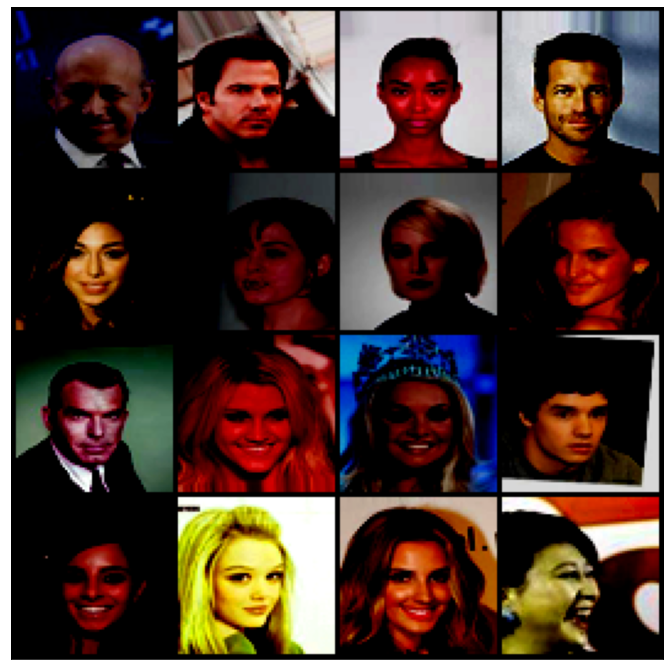

In [11]:
show_batch(train_dl)

In [12]:
import torch.nn as nn

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
criterion = nn.BCELoss()
D = Discriminator().to(device)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [15]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main =nn.Sequential(
        nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)
    def model(self):
        return self.main

In [16]:
G = Generator().to(device)

In [17]:
check = G.model()(torch.randn(1,128,1,1).to(device))

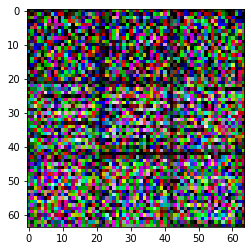

In [18]:
plt.imshow(check.reshape(1,64,64,3).detach().cpu().numpy()[0])

In [19]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.00001)

In [20]:
def train_generator(batch_size):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size,128,1,1).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)


    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [21]:
sample_vectors = torch.randn(16,128,1,1).to(device)
from torchvision.utils import save_image

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join('./', fake_fname), nrow=4)
    

In [22]:
save_fake_images(0)

Saving fake_images-0000.png


In [23]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images,batch_size):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D.forward(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, 128,1,1).to(device)
    fake_images = G.model()(z)
    outputs = D.forward(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [24]:
num_epochs = 3000
total_step = len(train_dl)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []


for epoch in tqdm(range(num_epochs)):
    for i, images  in enumerate(train_dl):
        # Load a batch & transform to vectors
        images = images.reshape(16,3,64,64).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images.float(),batch_size)
        g_loss, fake_images = train_generator(batch_size)
        
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            save_fake_images(epoch+1)

        
    # Sample and save images
    

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch [0/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.4638, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [200/1250], d_loss: 0.0003, g_loss: 8.9910, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [300/1250], d_loss: 0.0004, g_loss: 10.8458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.2468, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.9556, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.8585, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.7118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.4856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [0/3000], Step [900/1250], d_loss: 0

  0%|          | 1/3000 [00:41<34:38:30, 41.58s/it]

Epoch [1/3000], Step [100/1250], d_loss: 0.0001, g_loss: 11.0559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.7020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.9885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.0302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.0114, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.2871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [700/1250], d_loss: 0.0000, g_loss: 22.6786, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [800/1250], d_loss: 0.0000, g_loss: 22.0359, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [1/3000], Step [900/1250], d_loss: 

  0%|          | 2/3000 [01:22<34:31:44, 41.46s/it]

Epoch [2/3000], Step [100/1250], d_loss: 0.0006, g_loss: 13.9213, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [200/1250], d_loss: 0.0000, g_loss: 31.9378, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [300/1250], d_loss: 0.0000, g_loss: 37.7371, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [400/1250], d_loss: 0.0000, g_loss: 24.7401, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [500/1250], d_loss: 0.0019, g_loss: 12.7040, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [600/1250], d_loss: 0.0000, g_loss: 23.1716, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [700/1250], d_loss: 0.0044, g_loss: 12.9435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [800/1250], d_loss: 0.0000, g_loss: 23.1085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [2/3000], Step [900/1250], d_loss:

  0%|          | 3/3000 [02:04<34:30:34, 41.45s/it]

Epoch [3/3000], Step [100/1250], d_loss: 0.0000, g_loss: 35.7510, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [200/1250], d_loss: 0.0003, g_loss: 13.5142, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [300/1250], d_loss: 0.0060, g_loss: 9.1647, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0004.png
Epoch [3/3000], Step [400/1250], d_loss: 0.0000, g_loss: 23.5065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [500/1250], d_loss: 0.0192, g_loss: 12.4242, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0004.png
Epoch [3/3000], Step [600/1250], d_loss: 0.0141, g_loss: 11.4951, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [700/1250], d_loss: 0.0010, g_loss: 15.2577, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [800/1250], d_loss: 0.0006, g_loss: 9.2831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [3/3000], Step [900/1250], d_loss: 0

  0%|          | 4/3000 [02:46<34:36:06, 41.58s/it]

Epoch [4/3000], Step [100/1250], d_loss: 0.0130, g_loss: 7.6419, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [200/1250], d_loss: 0.0007, g_loss: 9.7734, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [300/1250], d_loss: 0.0058, g_loss: 10.0763, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0005.png
Epoch [4/3000], Step [400/1250], d_loss: 0.0002, g_loss: 9.8709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [500/1250], d_loss: 0.0000, g_loss: 15.0924, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [600/1250], d_loss: 0.0000, g_loss: 36.3536, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [700/1250], d_loss: 0.0000, g_loss: 28.4923, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [800/1250], d_loss: 0.0008, g_loss: 9.3753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [4/3000], Step [900/1250], d_loss: 0.0

  0%|          | 5/3000 [03:27<34:22:44, 41.32s/it]

Epoch [5/3000], Step [100/1250], d_loss: 0.0130, g_loss: 17.7904, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [5/3000], Step [200/1250], d_loss: 0.0059, g_loss: 18.0450, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0006.png
Epoch [5/3000], Step [300/1250], d_loss: 0.0130, g_loss: 16.7435, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0006.png
Epoch [5/3000], Step [400/1250], d_loss: 0.0019, g_loss: 8.0742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [5/3000], Step [500/1250], d_loss: 0.0051, g_loss: 6.8483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [5/3000], Step [600/1250], d_loss: 0.0054, g_loss: 5.9854, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0006.png
Epoch [5/3000], Step [700/1250], d_loss: 0.0017, g_loss: 15.4782, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [5/3000], Step [800/1250], d_loss: 0.0011, g_loss: 14.2274, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [5/3000], Step [900/1250], d_loss: 0.

  0%|          | 6/3000 [04:08<34:17:16, 41.23s/it]

Epoch [6/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.1825, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [200/1250], d_loss: 0.0044, g_loss: 7.0788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.9996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.3645, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.8383, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [600/1250], d_loss: 0.0001, g_loss: 19.8914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [700/1250], d_loss: 0.0233, g_loss: 13.2514, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0007.png
Epoch [6/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.0253, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [6/3000], Step [900/1250], d_loss: 

  0%|          | 7/3000 [04:49<34:17:39, 41.25s/it]

Epoch [7/3000], Step [100/1250], d_loss: 0.0105, g_loss: 11.6471, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0008.png
Epoch [7/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.0197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.5799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [400/1250], d_loss: 0.0063, g_loss: 13.3877, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [500/1250], d_loss: 0.0002, g_loss: 27.0144, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.0801, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [700/1250], d_loss: 0.0562, g_loss: 17.2609, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [800/1250], d_loss: 0.3433, g_loss: 18.9050, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [7/3000], Step [900/1250], d_loss:

  0%|          | 8/3000 [05:30<34:18:03, 41.27s/it]

Epoch [8/3000], Step [100/1250], d_loss: 0.0009, g_loss: 9.4617, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [200/1250], d_loss: 0.0033, g_loss: 8.2339, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [300/1250], d_loss: 0.0024, g_loss: 10.4548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [400/1250], d_loss: 0.0018, g_loss: 9.1401, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [500/1250], d_loss: 0.0039, g_loss: 10.4198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [600/1250], d_loss: 0.0083, g_loss: 7.5507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [700/1250], d_loss: 0.0114, g_loss: 11.5017, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [800/1250], d_loss: 0.0022, g_loss: 8.9080, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0009.png
Epoch [8/3000], Step [900/1250], d_loss: 0.01

  0%|          | 9/3000 [06:11<34:16:08, 41.25s/it]

Epoch [9/3000], Step [100/1250], d_loss: 0.0004, g_loss: 8.3605, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.2584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [300/1250], d_loss: 0.0000, g_loss: 26.5183, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [400/1250], d_loss: 0.0001, g_loss: 23.4732, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [500/1250], d_loss: 0.0038, g_loss: 12.1868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [600/1250], d_loss: 0.0012, g_loss: 20.8882, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [700/1250], d_loss: 0.0042, g_loss: 9.1501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [800/1250], d_loss: 0.0015, g_loss: 14.1729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0010.png
Epoch [9/3000], Step [900/1250], d_loss: 0

  0%|          | 10/3000 [06:53<34:14:52, 41.24s/it]

Epoch [10/3000], Step [100/1250], d_loss: 0.0019, g_loss: 8.7044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.7113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [300/1250], d_loss: 0.0836, g_loss: 8.4742, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0011.png
Epoch [10/3000], Step [400/1250], d_loss: 0.0001, g_loss: 22.3525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [500/1250], d_loss: 0.0003, g_loss: 18.5345, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.9492, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.7031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0011.png
Epoch [10/3000], Step [800/1250], d_loss: 0.3290, g_loss: 12.2008, D(x): 1.00, D(G(z)): 0.17
Saving fake_images-0011.png
Epoch [10/3000], Step [900/1250], d

  0%|          | 11/3000 [07:34<34:11:02, 41.17s/it]

Epoch [11/3000], Step [100/1250], d_loss: 0.0000, g_loss: 17.0639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0012.png
Epoch [11/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.0507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0012.png
Epoch [11/3000], Step [300/1250], d_loss: 0.1491, g_loss: 14.8822, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0012.png
Epoch [11/3000], Step [400/1250], d_loss: 0.0396, g_loss: 9.4007, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0012.png
Epoch [11/3000], Step [500/1250], d_loss: 0.0095, g_loss: 10.9283, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0012.png
Epoch [11/3000], Step [600/1250], d_loss: 0.0608, g_loss: 9.1099, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0012.png
Epoch [11/3000], Step [700/1250], d_loss: 0.0004, g_loss: 10.7702, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0012.png
Epoch [11/3000], Step [800/1250], d_loss: 0.0017, g_loss: 16.5061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0012.png
Epoch [11/3000], Step [900/1250], 

  0%|          | 12/3000 [08:15<34:15:22, 41.27s/it]

Epoch [12/3000], Step [100/1250], d_loss: 0.0012, g_loss: 5.6049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [200/1250], d_loss: 0.0000, g_loss: 20.7847, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [300/1250], d_loss: 0.0374, g_loss: 11.3274, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.4072, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [500/1250], d_loss: 0.0003, g_loss: 14.3848, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.9325, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [700/1250], d_loss: 0.0372, g_loss: 10.1644, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0013.png
Epoch [12/3000], Step [800/1250], d_loss: 0.0008, g_loss: 8.7526, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0013.png
Epoch [12/3000], Step [900/1250], 

  0%|          | 13/3000 [08:57<34:18:50, 41.36s/it]

Epoch [13/3000], Step [100/1250], d_loss: 0.0004, g_loss: 11.2738, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0014.png
Epoch [13/3000], Step [200/1250], d_loss: 0.0736, g_loss: 8.0392, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0014.png
Epoch [13/3000], Step [300/1250], d_loss: 0.0021, g_loss: 11.0967, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0014.png
Epoch [13/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.0722, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0014.png
Epoch [13/3000], Step [500/1250], d_loss: 0.0362, g_loss: 9.7769, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0014.png
Epoch [13/3000], Step [600/1250], d_loss: 0.0084, g_loss: 12.8833, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0014.png
Epoch [13/3000], Step [700/1250], d_loss: 0.0017, g_loss: 32.2441, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0014.png
Epoch [13/3000], Step [800/1250], d_loss: 0.0119, g_loss: 11.8522, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0014.png
Epoch [13/3000], Step [900/1250], 

  0%|          | 14/3000 [09:38<34:19:56, 41.39s/it]

Epoch [14/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.6170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0015.png
Epoch [14/3000], Step [200/1250], d_loss: 0.0716, g_loss: 11.6720, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0015.png
Epoch [14/3000], Step [300/1250], d_loss: 0.0011, g_loss: 11.4646, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0015.png
Epoch [14/3000], Step [400/1250], d_loss: 0.0246, g_loss: 11.1186, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0015.png
Epoch [14/3000], Step [500/1250], d_loss: 0.0004, g_loss: 29.1586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0015.png
Epoch [14/3000], Step [600/1250], d_loss: 0.0022, g_loss: 19.0729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0015.png
Epoch [14/3000], Step [700/1250], d_loss: 0.2052, g_loss: 13.3048, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0015.png
Epoch [14/3000], Step [800/1250], d_loss: 0.1139, g_loss: 4.6549, D(x): 0.96, D(G(z)): 0.05
Saving fake_images-0015.png
Epoch [14/3000], Step [900/1250],

  0%|          | 15/3000 [10:20<34:20:58, 41.43s/it]

Epoch [15/3000], Step [100/1250], d_loss: 0.0113, g_loss: 7.6861, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0016.png
Epoch [15/3000], Step [200/1250], d_loss: 0.0066, g_loss: 10.4213, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0016.png
Epoch [15/3000], Step [300/1250], d_loss: 0.1075, g_loss: 9.4905, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0016.png
Epoch [15/3000], Step [400/1250], d_loss: 0.0000, g_loss: 23.5868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0016.png
Epoch [15/3000], Step [500/1250], d_loss: 0.0008, g_loss: 31.7995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0016.png
Epoch [15/3000], Step [600/1250], d_loss: 0.0013, g_loss: 10.8560, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0016.png
Epoch [15/3000], Step [700/1250], d_loss: 0.0025, g_loss: 7.3961, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0016.png
Epoch [15/3000], Step [800/1250], d_loss: 0.0077, g_loss: 15.2608, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0016.png
Epoch [15/3000], Step [900/1250], d

  1%|          | 16/3000 [11:02<34:32:00, 41.66s/it]

Epoch [16/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.5364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.4761, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.8044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.4114, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [500/1250], d_loss: 0.0002, g_loss: 8.7892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [600/1250], d_loss: 0.0022, g_loss: 9.2422, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [700/1250], d_loss: 0.2139, g_loss: 13.2113, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0017.png
Epoch [16/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.6908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0017.png
Epoch [16/3000], Step [900/1250], 

  1%|          | 17/3000 [11:43<34:30:06, 41.64s/it]

Epoch [17/3000], Step [100/1250], d_loss: 0.0008, g_loss: 11.4662, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0018.png
Epoch [17/3000], Step [200/1250], d_loss: 0.0068, g_loss: 23.8906, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0018.png
Epoch [17/3000], Step [300/1250], d_loss: 0.0313, g_loss: 10.9168, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0018.png
Epoch [17/3000], Step [400/1250], d_loss: 0.0152, g_loss: 13.4197, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0018.png
Epoch [17/3000], Step [500/1250], d_loss: 0.0384, g_loss: 15.1832, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0018.png
Epoch [17/3000], Step [600/1250], d_loss: 0.0000, g_loss: 16.5169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0018.png
Epoch [17/3000], Step [700/1250], d_loss: 0.0025, g_loss: 9.6033, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0018.png
Epoch [17/3000], Step [800/1250], d_loss: 0.0520, g_loss: 10.5102, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0018.png
Epoch [17/3000], Step [900/1250],

  1%|          | 18/3000 [12:25<34:30:34, 41.66s/it]

Epoch [18/3000], Step [100/1250], d_loss: 0.0001, g_loss: 6.0167, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [200/1250], d_loss: 0.0006, g_loss: 15.5631, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [300/1250], d_loss: 0.0949, g_loss: 16.5420, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [400/1250], d_loss: 0.0001, g_loss: 23.6610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.8129, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [600/1250], d_loss: 0.0008, g_loss: 22.0704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [700/1250], d_loss: 0.0029, g_loss: 7.8246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.5232, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0019.png
Epoch [18/3000], Step [900/1250], 

  1%|          | 19/3000 [13:07<34:30:31, 41.67s/it]

Epoch [19/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.7921, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [200/1250], d_loss: 0.0027, g_loss: 7.8065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [300/1250], d_loss: 0.0053, g_loss: 8.9170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [400/1250], d_loss: 0.0118, g_loss: 14.2180, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [500/1250], d_loss: 0.0012, g_loss: 12.7857, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.1758, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.2499, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [800/1250], d_loss: 0.0005, g_loss: 8.5264, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0020.png
Epoch [19/3000], Step [900/1250], d_

  1%|          | 20/3000 [13:48<34:24:06, 41.56s/it]

Epoch [20/3000], Step [100/1250], d_loss: 0.0000, g_loss: 18.4152, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.6787, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.7001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [400/1250], d_loss: 0.0032, g_loss: 8.9832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [500/1250], d_loss: 0.0053, g_loss: 9.2973, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0021.png
Epoch [20/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.6296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.9906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.9799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0021.png
Epoch [20/3000], Step [900/1250], 

  1%|          | 21/3000 [14:29<34:14:04, 41.37s/it]

Epoch [21/3000], Step [100/1250], d_loss: 0.0011, g_loss: 7.1954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [200/1250], d_loss: 0.0059, g_loss: 8.5318, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0022.png
Epoch [21/3000], Step [300/1250], d_loss: 0.0071, g_loss: 13.8528, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.3934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [500/1250], d_loss: 0.0013, g_loss: 13.5117, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [600/1250], d_loss: 0.0007, g_loss: 22.2267, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [700/1250], d_loss: 0.0002, g_loss: 9.4693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [800/1250], d_loss: 0.0002, g_loss: 9.8969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0022.png
Epoch [21/3000], Step [900/1250], d_

  1%|          | 22/3000 [15:11<34:15:40, 41.42s/it]

Epoch [22/3000], Step [100/1250], d_loss: 0.0000, g_loss: 23.1891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.4768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.2748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [400/1250], d_loss: 0.0000, g_loss: 19.1989, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [500/1250], d_loss: 0.0004, g_loss: 12.1347, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [600/1250], d_loss: 0.0005, g_loss: 16.6773, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [700/1250], d_loss: 0.0047, g_loss: 5.9103, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [800/1250], d_loss: 0.0030, g_loss: 9.2894, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0023.png
Epoch [22/3000], Step [900/1250], 

  1%|          | 23/3000 [15:53<34:27:28, 41.67s/it]

Epoch [23/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.6009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [200/1250], d_loss: 0.0536, g_loss: 11.8186, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0024.png
Epoch [23/3000], Step [300/1250], d_loss: 0.0015, g_loss: 13.6084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [400/1250], d_loss: 0.0117, g_loss: 11.4678, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0024.png
Epoch [23/3000], Step [500/1250], d_loss: 0.2955, g_loss: 23.6672, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [600/1250], d_loss: 0.0018, g_loss: 13.6507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [700/1250], d_loss: 0.0001, g_loss: 7.9469, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [800/1250], d_loss: 0.0034, g_loss: 12.6513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0024.png
Epoch [23/3000], Step [900/1250],

  1%|          | 24/3000 [16:35<34:31:55, 41.77s/it]

Epoch [24/3000], Step [100/1250], d_loss: 0.0000, g_loss: 19.0178, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [200/1250], d_loss: 0.0008, g_loss: 10.1014, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [300/1250], d_loss: 0.0010, g_loss: 12.8325, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [400/1250], d_loss: 0.0013, g_loss: 12.9414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [500/1250], d_loss: 0.0001, g_loss: 7.4072, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [600/1250], d_loss: 0.0028, g_loss: 15.8622, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [700/1250], d_loss: 0.0158, g_loss: 12.2261, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [800/1250], d_loss: 0.0092, g_loss: 14.8471, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0025.png
Epoch [24/3000], Step [900/1250],

  1%|          | 25/3000 [17:17<34:31:04, 41.77s/it]

Epoch [25/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.2013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [200/1250], d_loss: 0.0043, g_loss: 6.6654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [300/1250], d_loss: 0.0794, g_loss: 15.0971, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [400/1250], d_loss: 0.0718, g_loss: 11.9409, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0026.png
Epoch [25/3000], Step [500/1250], d_loss: 0.0061, g_loss: 6.2139, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0026.png
Epoch [25/3000], Step [600/1250], d_loss: 0.0040, g_loss: 12.3242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [700/1250], d_loss: 0.0003, g_loss: 13.6972, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.4333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0026.png
Epoch [25/3000], Step [900/1250], 

  1%|          | 26/3000 [17:58<34:25:38, 41.67s/it]

Epoch [26/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.1992, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0027.png
Epoch [26/3000], Step [200/1250], d_loss: 0.0925, g_loss: 9.6875, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0027.png
Epoch [26/3000], Step [300/1250], d_loss: 0.0029, g_loss: 7.3819, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0027.png
Epoch [26/3000], Step [400/1250], d_loss: 0.0261, g_loss: 13.3959, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0027.png
Epoch [26/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.1503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0027.png
Epoch [26/3000], Step [600/1250], d_loss: 0.0004, g_loss: 9.2653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0027.png
Epoch [26/3000], Step [700/1250], d_loss: 0.0162, g_loss: 13.4564, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0027.png
Epoch [26/3000], Step [800/1250], d_loss: 0.0006, g_loss: 11.0129, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0027.png
Epoch [26/3000], Step [900/1250], d

  1%|          | 27/3000 [18:40<34:25:59, 41.70s/it]

Epoch [27/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.2902, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [200/1250], d_loss: 0.0050, g_loss: 11.6508, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.8860, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [400/1250], d_loss: 0.0053, g_loss: 8.3846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [500/1250], d_loss: 0.0032, g_loss: 17.1256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.2575, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [700/1250], d_loss: 0.2168, g_loss: 12.8054, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [800/1250], d_loss: 0.0102, g_loss: 13.5391, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [27/3000], Step [900/1250],

  1%|          | 28/3000 [19:22<34:25:14, 41.69s/it]

Epoch [28/3000], Step [100/1250], d_loss: 0.0000, g_loss: 25.7139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [200/1250], d_loss: 0.0319, g_loss: 8.1452, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0029.png
Epoch [28/3000], Step [300/1250], d_loss: 0.0016, g_loss: 14.5774, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [400/1250], d_loss: 0.0035, g_loss: 9.4310, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [500/1250], d_loss: 0.0021, g_loss: 9.1445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [600/1250], d_loss: 0.1088, g_loss: 15.4461, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [700/1250], d_loss: 0.0004, g_loss: 7.4349, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0029.png
Epoch [28/3000], Step [800/1250], d_loss: 0.0101, g_loss: 11.3272, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0029.png
Epoch [28/3000], Step [900/1250], d_

  1%|          | 29/3000 [20:03<34:27:35, 41.76s/it]

Epoch [29/3000], Step [100/1250], d_loss: 0.0027, g_loss: 9.0949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [200/1250], d_loss: 0.0005, g_loss: 11.3151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [300/1250], d_loss: 0.0090, g_loss: 12.7988, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0030.png
Epoch [29/3000], Step [400/1250], d_loss: 0.0455, g_loss: 16.9871, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [500/1250], d_loss: 0.0032, g_loss: 19.2457, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.6906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [700/1250], d_loss: 0.0000, g_loss: 19.4790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [800/1250], d_loss: 0.0019, g_loss: 6.0627, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [29/3000], Step [900/1250], 

  1%|          | 30/3000 [20:45<34:26:18, 41.74s/it]

Epoch [30/3000], Step [100/1250], d_loss: 0.0002, g_loss: 8.5428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [200/1250], d_loss: 0.0028, g_loss: 20.2489, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.9161, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [400/1250], d_loss: 0.0006, g_loss: 7.0463, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.9442, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [600/1250], d_loss: 0.0017, g_loss: 10.1962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [700/1250], d_loss: 0.0422, g_loss: 20.3433, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.5755, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0031.png
Epoch [30/3000], Step [900/1250], 

  1%|          | 31/3000 [21:26<34:18:53, 41.61s/it]

Epoch [31/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.9360, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [200/1250], d_loss: 0.0005, g_loss: 11.3263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [300/1250], d_loss: 0.3534, g_loss: 7.0982, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [400/1250], d_loss: 0.0994, g_loss: 9.2300, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0032.png
Epoch [31/3000], Step [500/1250], d_loss: 0.0000, g_loss: 20.9486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [600/1250], d_loss: 0.2996, g_loss: 10.3527, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [700/1250], d_loss: 0.0004, g_loss: 6.7418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [800/1250], d_loss: 0.0002, g_loss: 18.8609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0032.png
Epoch [31/3000], Step [900/1250], d

  1%|          | 32/3000 [22:08<34:11:09, 41.47s/it]

Epoch [32/3000], Step [100/1250], d_loss: 0.0269, g_loss: 11.7009, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0033.png
Epoch [32/3000], Step [200/1250], d_loss: 0.1151, g_loss: 13.4902, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [300/1250], d_loss: 0.0071, g_loss: 7.8519, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0033.png
Epoch [32/3000], Step [400/1250], d_loss: 0.0027, g_loss: 12.7086, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [500/1250], d_loss: 0.0008, g_loss: 9.3597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [600/1250], d_loss: 0.5329, g_loss: 8.3415, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.6424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.0256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0033.png
Epoch [32/3000], Step [900/1250], d

  1%|          | 33/3000 [22:49<34:02:54, 41.31s/it]

Epoch [33/3000], Step [100/1250], d_loss: 0.0011, g_loss: 9.6343, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [200/1250], d_loss: 0.0068, g_loss: 11.8866, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0034.png
Epoch [33/3000], Step [300/1250], d_loss: 0.0015, g_loss: 17.6625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.5302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [500/1250], d_loss: 0.0004, g_loss: 12.7298, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [600/1250], d_loss: 0.0045, g_loss: 9.9097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [700/1250], d_loss: 0.0656, g_loss: 30.5226, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [800/1250], d_loss: 0.0031, g_loss: 7.0535, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0034.png
Epoch [33/3000], Step [900/1250], d

  1%|          | 34/3000 [23:30<33:59:11, 41.25s/it]

Epoch [34/3000], Step [100/1250], d_loss: 0.0056, g_loss: 7.2599, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0035.png
Epoch [34/3000], Step [200/1250], d_loss: 0.0014, g_loss: 8.8223, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [300/1250], d_loss: 0.0003, g_loss: 9.7130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [400/1250], d_loss: 0.0002, g_loss: 18.0630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [500/1250], d_loss: 0.0027, g_loss: 8.7898, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [600/1250], d_loss: 0.0037, g_loss: 23.0721, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [700/1250], d_loss: 0.0000, g_loss: 19.7945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.8001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0035.png
Epoch [34/3000], Step [900/1250], d_

  1%|          | 35/3000 [24:11<34:02:06, 41.32s/it]

Epoch [35/3000], Step [100/1250], d_loss: 0.0468, g_loss: 12.3289, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0036.png
Epoch [35/3000], Step [200/1250], d_loss: 2.4638, g_loss: 13.4396, D(x): 1.00, D(G(z)): 0.65
Saving fake_images-0036.png
Epoch [35/3000], Step [300/1250], d_loss: 0.0001, g_loss: 11.2496, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0036.png
Epoch [35/3000], Step [400/1250], d_loss: 0.5789, g_loss: 12.9575, D(x): 0.99, D(G(z)): 0.33
Saving fake_images-0036.png
Epoch [35/3000], Step [500/1250], d_loss: 0.0133, g_loss: 12.0699, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0036.png
Epoch [35/3000], Step [600/1250], d_loss: 0.0000, g_loss: 20.8954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0036.png
Epoch [35/3000], Step [700/1250], d_loss: 0.0016, g_loss: 20.8625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0036.png
Epoch [35/3000], Step [800/1250], d_loss: 0.0000, g_loss: 24.0431, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0036.png
Epoch [35/3000], Step [900/1250]

  1%|          | 36/3000 [24:53<34:03:14, 41.36s/it]

Epoch [36/3000], Step [100/1250], d_loss: 0.0429, g_loss: 6.2964, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0037.png
Epoch [36/3000], Step [200/1250], d_loss: 0.0064, g_loss: 10.2494, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0037.png
Epoch [36/3000], Step [300/1250], d_loss: 0.0080, g_loss: 13.0308, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.5289, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [500/1250], d_loss: 0.0000, g_loss: 20.2764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [600/1250], d_loss: 0.0002, g_loss: 14.0090, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [700/1250], d_loss: 0.0011, g_loss: 6.5346, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [800/1250], d_loss: 0.0009, g_loss: 12.1108, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0037.png
Epoch [36/3000], Step [900/1250], 

  1%|          | 37/3000 [25:35<34:19:29, 41.70s/it]

Epoch [37/3000], Step [100/1250], d_loss: 0.0011, g_loss: 17.4250, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [200/1250], d_loss: 0.0052, g_loss: 12.6330, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [300/1250], d_loss: 0.0000, g_loss: 7.3928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [400/1250], d_loss: 0.0003, g_loss: 11.0586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [500/1250], d_loss: 0.0000, g_loss: 17.8217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [600/1250], d_loss: 0.4027, g_loss: 12.4643, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [700/1250], d_loss: 0.0030, g_loss: 19.3763, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [800/1250], d_loss: 0.0022, g_loss: 15.5204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0038.png
Epoch [37/3000], Step [900/1250],

  1%|▏         | 38/3000 [26:17<34:19:10, 41.71s/it]

Epoch [38/3000], Step [100/1250], d_loss: 0.0030, g_loss: 7.6503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [200/1250], d_loss: 0.0007, g_loss: 9.0407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [300/1250], d_loss: 0.0013, g_loss: 7.0693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [400/1250], d_loss: 0.0044, g_loss: 9.1395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [500/1250], d_loss: 0.0007, g_loss: 25.2641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.3893, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0039.png
Epoch [38/3000], Step [700/1250], d_loss: 0.0234, g_loss: 8.1125, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0039.png
Epoch [38/3000], Step [800/1250], d_loss: 0.0089, g_loss: 14.5709, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0039.png
Epoch [38/3000], Step [900/1250], d_l

  1%|▏         | 39/3000 [26:58<34:07:16, 41.48s/it]

Epoch [39/3000], Step [100/1250], d_loss: 0.0005, g_loss: 24.4494, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.9704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [300/1250], d_loss: 0.0607, g_loss: 2.9543, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0040.png
Epoch [39/3000], Step [400/1250], d_loss: 0.0001, g_loss: 25.2785, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.8575, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [600/1250], d_loss: 0.0047, g_loss: 14.5737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [700/1250], d_loss: 0.0008, g_loss: 21.4030, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [800/1250], d_loss: 0.0006, g_loss: 14.6517, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0040.png
Epoch [39/3000], Step [900/1250], 

  1%|▏         | 40/3000 [27:39<34:03:38, 41.43s/it]

Epoch [40/3000], Step [100/1250], d_loss: 0.0058, g_loss: 18.4461, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [200/1250], d_loss: 0.0364, g_loss: 14.2797, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [300/1250], d_loss: 0.0704, g_loss: 10.1916, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0041.png
Epoch [40/3000], Step [400/1250], d_loss: 0.0019, g_loss: 9.1738, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [500/1250], d_loss: 0.0004, g_loss: 10.3978, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [600/1250], d_loss: 0.0018, g_loss: 9.3285, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [700/1250], d_loss: 0.0003, g_loss: 16.3913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [800/1250], d_loss: 0.0004, g_loss: 10.9340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0041.png
Epoch [40/3000], Step [900/1250], 

  1%|▏         | 41/3000 [28:20<34:01:15, 41.39s/it]

Epoch [41/3000], Step [100/1250], d_loss: 0.0003, g_loss: 9.0329, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [200/1250], d_loss: 0.0071, g_loss: 12.9397, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [300/1250], d_loss: 0.0002, g_loss: 5.6207, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.7753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.9157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.7746, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.9618, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [800/1250], d_loss: 0.0035, g_loss: 6.8099, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0042.png
Epoch [41/3000], Step [900/1250], d

  1%|▏         | 42/3000 [29:02<34:01:24, 41.41s/it]

Epoch [42/3000], Step [100/1250], d_loss: 0.0009, g_loss: 19.3489, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [200/1250], d_loss: 0.0015, g_loss: 13.4659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [300/1250], d_loss: 0.0005, g_loss: 16.5188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [400/1250], d_loss: 0.0012, g_loss: 12.1234, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [500/1250], d_loss: 0.0017, g_loss: 12.0002, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [600/1250], d_loss: 0.0983, g_loss: 7.9634, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0043.png
Epoch [42/3000], Step [700/1250], d_loss: 0.0001, g_loss: 16.8944, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0043.png
Epoch [42/3000], Step [800/1250], d_loss: 0.0155, g_loss: 10.9164, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0043.png
Epoch [42/3000], Step [900/1250],

  1%|▏         | 43/3000 [29:43<34:02:51, 41.45s/it]

Epoch [43/3000], Step [100/1250], d_loss: 0.2275, g_loss: 17.4432, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0044.png
Epoch [43/3000], Step [200/1250], d_loss: 0.0022, g_loss: 20.8767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0044.png
Epoch [43/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.8977, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0044.png
Epoch [43/3000], Step [400/1250], d_loss: 0.0180, g_loss: 8.1294, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0044.png
Epoch [43/3000], Step [500/1250], d_loss: 0.0001, g_loss: 16.6007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0044.png
Epoch [43/3000], Step [600/1250], d_loss: 0.0031, g_loss: 11.4125, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0044.png
Epoch [43/3000], Step [700/1250], d_loss: 0.2994, g_loss: 7.9387, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0044.png
Epoch [43/3000], Step [800/1250], d_loss: 0.5943, g_loss: 12.3805, D(x): 1.00, D(G(z)): 0.26
Saving fake_images-0044.png
Epoch [43/3000], Step [900/1250], 

  1%|▏         | 44/3000 [30:25<34:05:38, 41.52s/it]

Epoch [44/3000], Step [100/1250], d_loss: 0.0026, g_loss: 5.9337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [200/1250], d_loss: 0.0010, g_loss: 8.5119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [300/1250], d_loss: 0.0150, g_loss: 9.4977, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0045.png
Epoch [44/3000], Step [400/1250], d_loss: 0.0008, g_loss: 11.0250, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [500/1250], d_loss: 0.0006, g_loss: 12.6044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.9109, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [700/1250], d_loss: 0.0344, g_loss: 12.6937, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0045.png
Epoch [44/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.1106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0045.png
Epoch [44/3000], Step [900/1250], d

  2%|▏         | 45/3000 [31:06<34:02:38, 41.47s/it]

Epoch [45/3000], Step [100/1250], d_loss: 0.0009, g_loss: 8.7661, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [200/1250], d_loss: 0.1397, g_loss: 9.7623, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0046.png
Epoch [45/3000], Step [300/1250], d_loss: 0.1017, g_loss: 15.1995, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.3151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.9586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.6521, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.9515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.4011, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0046.png
Epoch [45/3000], Step [900/1250], 

  2%|▏         | 46/3000 [31:48<34:00:15, 41.44s/it]

Epoch [46/3000], Step [100/1250], d_loss: 0.0006, g_loss: 10.4397, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [200/1250], d_loss: 0.0030, g_loss: 12.3479, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [300/1250], d_loss: 0.0021, g_loss: 9.4728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [400/1250], d_loss: 0.0004, g_loss: 14.4335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [500/1250], d_loss: 0.0420, g_loss: 6.3114, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0047.png
Epoch [46/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.7830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [700/1250], d_loss: 0.0044, g_loss: 8.5245, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [800/1250], d_loss: 0.0002, g_loss: 7.7119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0047.png
Epoch [46/3000], Step [900/1250], d_

  2%|▏         | 47/3000 [32:29<33:54:44, 41.34s/it]

Epoch [47/3000], Step [100/1250], d_loss: 0.0047, g_loss: 7.6160, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.6678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [300/1250], d_loss: 0.0353, g_loss: 9.6080, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0048.png
Epoch [47/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.5963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.2082, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [600/1250], d_loss: 0.0903, g_loss: 15.6152, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [700/1250], d_loss: 0.0416, g_loss: 6.3779, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0048.png
Epoch [47/3000], Step [800/1250], d_loss: 0.0026, g_loss: 9.2887, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0048.png
Epoch [47/3000], Step [900/1250], d_l

  2%|▏         | 48/3000 [33:10<33:50:48, 41.28s/it]

Epoch [48/3000], Step [100/1250], d_loss: 0.0042, g_loss: 12.3296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0049.png
Epoch [48/3000], Step [200/1250], d_loss: 0.0009, g_loss: 12.1760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0049.png
Epoch [48/3000], Step [300/1250], d_loss: 0.0011, g_loss: 17.6597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0049.png
Epoch [48/3000], Step [400/1250], d_loss: 0.0139, g_loss: 10.5998, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0049.png
Epoch [48/3000], Step [500/1250], d_loss: 0.0072, g_loss: 10.6273, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0049.png
Epoch [48/3000], Step [600/1250], d_loss: 0.0233, g_loss: 11.1061, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0049.png
Epoch [48/3000], Step [700/1250], d_loss: 0.0015, g_loss: 14.4209, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0049.png
Epoch [48/3000], Step [800/1250], d_loss: 0.0005, g_loss: 11.3489, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0049.png
Epoch [48/3000], Step [900/1250]

  2%|▏         | 49/3000 [33:51<33:52:34, 41.33s/it]

Epoch [49/3000], Step [100/1250], d_loss: 0.0007, g_loss: 12.0316, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [200/1250], d_loss: 0.0017, g_loss: 16.8933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.5618, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [400/1250], d_loss: 0.0000, g_loss: 24.2369, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [500/1250], d_loss: 0.0011, g_loss: 4.2851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [600/1250], d_loss: 0.0000, g_loss: 23.7293, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [700/1250], d_loss: 0.0073, g_loss: 5.0611, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0050.png
Epoch [49/3000], Step [800/1250], d_loss: 0.0006, g_loss: 9.7188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0050.png
Epoch [49/3000], Step [900/1250], d

  2%|▏         | 50/3000 [34:33<33:58:16, 41.46s/it]

Epoch [50/3000], Step [100/1250], d_loss: 0.0062, g_loss: 18.6207, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [200/1250], d_loss: 0.0055, g_loss: 12.0510, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0051.png
Epoch [50/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.5870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [400/1250], d_loss: 0.0053, g_loss: 7.4244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [500/1250], d_loss: 0.0008, g_loss: 7.7802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [600/1250], d_loss: 0.0001, g_loss: 11.0797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.4154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0051.png
Epoch [50/3000], Step [800/1250], d_loss: 0.0130, g_loss: 12.1629, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0051.png
Epoch [50/3000], Step [900/1250], 

  2%|▏         | 51/3000 [35:15<34:03:01, 41.57s/it]

Epoch [51/3000], Step [100/1250], d_loss: 0.0035, g_loss: 22.7136, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.0994, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [300/1250], d_loss: 0.0079, g_loss: 18.8179, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0052.png
Epoch [51/3000], Step [400/1250], d_loss: 0.0035, g_loss: 6.3941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [500/1250], d_loss: 0.0015, g_loss: 15.8795, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.1549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.1395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0052.png
Epoch [51/3000], Step [800/1250], d_loss: 0.0100, g_loss: 12.1810, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0052.png
Epoch [51/3000], Step [900/1250], 

  2%|▏         | 52/3000 [35:57<34:02:51, 41.58s/it]

Epoch [52/3000], Step [100/1250], d_loss: 0.0400, g_loss: 25.3154, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [200/1250], d_loss: 0.0636, g_loss: 9.7537, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0053.png
Epoch [52/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.5121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [400/1250], d_loss: 0.0005, g_loss: 12.9455, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [500/1250], d_loss: 0.0081, g_loss: 16.4030, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.6668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [700/1250], d_loss: 0.0030, g_loss: 13.4204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [800/1250], d_loss: 0.0019, g_loss: 16.0281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0053.png
Epoch [52/3000], Step [900/1250], 

  2%|▏         | 53/3000 [36:38<33:58:23, 41.50s/it]

Epoch [53/3000], Step [100/1250], d_loss: 0.0142, g_loss: 13.3923, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0054.png
Epoch [53/3000], Step [200/1250], d_loss: 0.0218, g_loss: 10.0144, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0054.png
Epoch [53/3000], Step [300/1250], d_loss: 0.0025, g_loss: 10.1269, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0054.png
Epoch [53/3000], Step [400/1250], d_loss: 0.0005, g_loss: 17.0556, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0054.png
Epoch [53/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.8367, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0054.png
Epoch [53/3000], Step [600/1250], d_loss: 0.0096, g_loss: 13.3313, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0054.png
Epoch [53/3000], Step [700/1250], d_loss: 0.0078, g_loss: 7.7101, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0054.png
Epoch [53/3000], Step [800/1250], d_loss: 0.0000, g_loss: 9.5251, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0054.png
Epoch [53/3000], Step [900/1250], 

  2%|▏         | 54/3000 [37:19<33:50:28, 41.35s/it]

Epoch [54/3000], Step [100/1250], d_loss: 0.0388, g_loss: 11.0191, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [200/1250], d_loss: 0.0098, g_loss: 9.3822, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0055.png
Epoch [54/3000], Step [300/1250], d_loss: 0.0061, g_loss: 24.2066, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [400/1250], d_loss: 0.0008, g_loss: 13.1665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [500/1250], d_loss: 0.4295, g_loss: 5.2999, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0055.png
Epoch [54/3000], Step [600/1250], d_loss: 0.0009, g_loss: 12.4833, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [700/1250], d_loss: 0.0012, g_loss: 13.6891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [800/1250], d_loss: 0.0001, g_loss: 7.3417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0055.png
Epoch [54/3000], Step [900/1250], d

  2%|▏         | 55/3000 [38:01<33:54:13, 41.44s/it]

Epoch [55/3000], Step [100/1250], d_loss: 0.0017, g_loss: 12.1284, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [200/1250], d_loss: 0.0040, g_loss: 10.7798, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [300/1250], d_loss: 0.0044, g_loss: 25.7173, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [400/1250], d_loss: 0.0266, g_loss: 15.1869, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.8424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [600/1250], d_loss: 0.1070, g_loss: 4.1149, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0056.png
Epoch [55/3000], Step [700/1250], d_loss: 0.0007, g_loss: 14.4861, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [800/1250], d_loss: 0.0026, g_loss: 7.2900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0056.png
Epoch [55/3000], Step [900/1250], 

  2%|▏         | 56/3000 [38:42<33:53:51, 41.45s/it]

Epoch [56/3000], Step [100/1250], d_loss: 0.0000, g_loss: 19.8104, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [200/1250], d_loss: 0.0025, g_loss: 20.6303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [300/1250], d_loss: 0.0027, g_loss: 8.1742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [400/1250], d_loss: 0.0062, g_loss: 8.0684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.1342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [600/1250], d_loss: 0.0001, g_loss: 19.2609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [700/1250], d_loss: 0.0202, g_loss: 8.6300, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [56/3000], Step [800/1250], d_loss: 0.0074, g_loss: 10.3895, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0057.png
Epoch [56/3000], Step [900/1250], d

  2%|▏         | 57/3000 [39:23<33:49:19, 41.37s/it]

Epoch [57/3000], Step [100/1250], d_loss: 0.3277, g_loss: 4.1865, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0058.png
Epoch [57/3000], Step [200/1250], d_loss: 0.0054, g_loss: 15.3039, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.7142, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [400/1250], d_loss: 0.0012, g_loss: 13.5118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [500/1250], d_loss: 0.0062, g_loss: 12.1967, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [600/1250], d_loss: 0.0006, g_loss: 11.0873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [700/1250], d_loss: 0.0009, g_loss: 8.9270, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [800/1250], d_loss: 0.0009, g_loss: 6.6462, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0058.png
Epoch [57/3000], Step [900/1250], d

  2%|▏         | 58/3000 [40:05<33:46:23, 41.33s/it]

Epoch [58/3000], Step [100/1250], d_loss: 0.0074, g_loss: 12.9351, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0059.png
Epoch [58/3000], Step [200/1250], d_loss: 0.0253, g_loss: 8.8283, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0059.png
Epoch [58/3000], Step [300/1250], d_loss: 0.0285, g_loss: 11.9994, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0059.png
Epoch [58/3000], Step [400/1250], d_loss: 0.0019, g_loss: 11.3688, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0059.png
Epoch [58/3000], Step [500/1250], d_loss: 0.0660, g_loss: 9.2618, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0059.png
Epoch [58/3000], Step [600/1250], d_loss: 0.0024, g_loss: 11.2663, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0059.png
Epoch [58/3000], Step [700/1250], d_loss: 0.0024, g_loss: 14.2270, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0059.png
Epoch [58/3000], Step [800/1250], d_loss: 0.0531, g_loss: 11.4760, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0059.png
Epoch [58/3000], Step [900/1250], 

  2%|▏         | 59/3000 [40:46<33:45:38, 41.33s/it]

Epoch [59/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.7854, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.1343, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [300/1250], d_loss: 0.1625, g_loss: 4.2710, D(x): 0.89, D(G(z)): 0.01
Saving fake_images-0060.png
Epoch [59/3000], Step [400/1250], d_loss: 0.0924, g_loss: 6.1237, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [500/1250], d_loss: 0.0003, g_loss: 6.5489, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [600/1250], d_loss: 0.0004, g_loss: 13.1745, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [700/1250], d_loss: 0.0046, g_loss: 6.8110, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [800/1250], d_loss: 0.0019, g_loss: 11.7982, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0060.png
Epoch [59/3000], Step [900/1250], d_lo

  2%|▏         | 60/3000 [41:27<33:46:44, 41.36s/it]

Epoch [60/3000], Step [100/1250], d_loss: 0.0004, g_loss: 7.2425, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [200/1250], d_loss: 0.0025, g_loss: 12.3807, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.2243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [400/1250], d_loss: 0.0113, g_loss: 7.1663, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0061.png
Epoch [60/3000], Step [500/1250], d_loss: 0.0038, g_loss: 8.6532, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [600/1250], d_loss: 0.0001, g_loss: 12.1254, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [700/1250], d_loss: 0.0128, g_loss: 8.9354, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [800/1250], d_loss: 0.0032, g_loss: 17.6024, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0061.png
Epoch [60/3000], Step [900/1250], d_

  2%|▏         | 61/3000 [42:09<33:45:59, 41.36s/it]

Epoch [61/3000], Step [100/1250], d_loss: 0.9413, g_loss: 19.9354, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [200/1250], d_loss: 0.0003, g_loss: 19.0957, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [300/1250], d_loss: 0.0428, g_loss: 16.3416, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.4417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [500/1250], d_loss: 0.0118, g_loss: 11.3970, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [600/1250], d_loss: 0.0010, g_loss: 9.8195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [700/1250], d_loss: 0.0006, g_loss: 21.5089, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.8366, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0062.png
Epoch [61/3000], Step [900/1250],

  2%|▏         | 62/3000 [42:50<33:44:00, 41.33s/it]

Epoch [62/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.5422, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [200/1250], d_loss: 0.0000, g_loss: 16.4206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [300/1250], d_loss: 0.3615, g_loss: 5.7161, D(x): 0.78, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [400/1250], d_loss: 0.0014, g_loss: 10.7835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.1202, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.4953, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.5821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [800/1250], d_loss: 0.0004, g_loss: 9.3689, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0063.png
Epoch [62/3000], Step [900/1250], 

  2%|▏         | 63/3000 [43:31<33:37:01, 41.21s/it]

Epoch [63/3000], Step [100/1250], d_loss: 0.0049, g_loss: 22.5805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [200/1250], d_loss: 0.0429, g_loss: 10.1624, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0064.png
Epoch [63/3000], Step [300/1250], d_loss: 0.0034, g_loss: 8.9252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [400/1250], d_loss: 0.0257, g_loss: 9.3181, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [500/1250], d_loss: 0.0013, g_loss: 7.0582, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.4425, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [700/1250], d_loss: 0.0099, g_loss: 12.3421, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0064.png
Epoch [63/3000], Step [800/1250], d_loss: 0.0021, g_loss: 7.7291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0064.png
Epoch [63/3000], Step [900/1250], d_

  2%|▏         | 64/3000 [44:12<33:42:56, 41.34s/it]

Epoch [64/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.9708, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [200/1250], d_loss: 0.0013, g_loss: 6.9027, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.4001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [400/1250], d_loss: 0.0021, g_loss: 11.1257, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [500/1250], d_loss: 0.0004, g_loss: 10.8190, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.1392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [700/1250], d_loss: 0.0022, g_loss: 11.6255, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [800/1250], d_loss: 0.0000, g_loss: 18.2713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0065.png
Epoch [64/3000], Step [900/1250], 

  2%|▏         | 65/3000 [44:54<33:43:39, 41.37s/it]

Epoch [65/3000], Step [100/1250], d_loss: 0.6832, g_loss: 9.6344, D(x): 0.71, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [200/1250], d_loss: 0.0017, g_loss: 13.2729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [300/1250], d_loss: 0.0006, g_loss: 17.1186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [400/1250], d_loss: 0.0019, g_loss: 10.5304, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [500/1250], d_loss: 0.0011, g_loss: 8.9456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [600/1250], d_loss: 0.5521, g_loss: 7.8156, D(x): 1.00, D(G(z)): 0.30
Saving fake_images-0066.png
Epoch [65/3000], Step [700/1250], d_loss: 0.0011, g_loss: 12.9715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0066.png
Epoch [65/3000], Step [800/1250], d_loss: 0.0087, g_loss: 9.7503, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0066.png
Epoch [65/3000], Step [900/1250], d_

  2%|▏         | 66/3000 [45:35<33:41:18, 41.34s/it]

Epoch [66/3000], Step [100/1250], d_loss: 0.0007, g_loss: 17.8221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [200/1250], d_loss: 0.0023, g_loss: 7.4306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [300/1250], d_loss: 0.0857, g_loss: 9.4696, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0067.png
Epoch [66/3000], Step [400/1250], d_loss: 0.0102, g_loss: 6.6424, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0067.png
Epoch [66/3000], Step [500/1250], d_loss: 0.0001, g_loss: 7.1374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.1391, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [700/1250], d_loss: 0.0047, g_loss: 12.1352, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [800/1250], d_loss: 0.0059, g_loss: 11.1023, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0067.png
Epoch [66/3000], Step [900/1250], d_

  2%|▏         | 67/3000 [46:16<33:40:26, 41.33s/it]

Epoch [67/3000], Step [100/1250], d_loss: 0.0002, g_loss: 12.1320, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [200/1250], d_loss: 0.0036, g_loss: 6.7985, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [300/1250], d_loss: 0.0014, g_loss: 12.0171, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [400/1250], d_loss: 0.5761, g_loss: 15.8627, D(x): 0.74, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.5276, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [600/1250], d_loss: 0.0000, g_loss: 24.1434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [700/1250], d_loss: 0.0025, g_loss: 12.5842, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [800/1250], d_loss: 0.0128, g_loss: 11.3676, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0068.png
Epoch [67/3000], Step [900/1250],

  2%|▏         | 68/3000 [46:58<33:37:45, 41.29s/it]

Epoch [68/3000], Step [100/1250], d_loss: 0.0092, g_loss: 10.6527, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [200/1250], d_loss: 0.4164, g_loss: 9.4133, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [300/1250], d_loss: 0.0165, g_loss: 9.0709, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.0806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.8023, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [600/1250], d_loss: 0.0014, g_loss: 10.9804, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.2253, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [800/1250], d_loss: 0.0137, g_loss: 11.1567, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0069.png
Epoch [68/3000], Step [900/1250], 

  2%|▏         | 69/3000 [47:39<33:34:37, 41.24s/it]

Epoch [69/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.9754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0070.png
Epoch [69/3000], Step [200/1250], d_loss: 0.0152, g_loss: 10.5152, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0070.png
Epoch [69/3000], Step [300/1250], d_loss: 0.0068, g_loss: 9.3103, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0070.png
Epoch [69/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.2034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0070.png
Epoch [69/3000], Step [500/1250], d_loss: 0.0011, g_loss: 20.8067, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0070.png
Epoch [69/3000], Step [600/1250], d_loss: 0.0028, g_loss: 9.3415, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0070.png
Epoch [69/3000], Step [700/1250], d_loss: 0.0125, g_loss: 11.6027, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0070.png
Epoch [69/3000], Step [800/1250], d_loss: 0.0723, g_loss: 2.6712, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0070.png
Epoch [69/3000], Step [900/1250], d

  2%|▏         | 70/3000 [48:20<33:33:08, 41.22s/it]

Epoch [70/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.1622, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.5652, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [300/1250], d_loss: 0.0003, g_loss: 10.4392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [400/1250], d_loss: 0.0011, g_loss: 8.1364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [500/1250], d_loss: 0.0048, g_loss: 9.3625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [600/1250], d_loss: 0.0012, g_loss: 10.6332, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [700/1250], d_loss: 0.0062, g_loss: 21.2347, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.1572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [70/3000], Step [900/1250], 

  2%|▏         | 71/3000 [49:01<33:34:26, 41.27s/it]

Epoch [71/3000], Step [100/1250], d_loss: 0.0054, g_loss: 11.1573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [200/1250], d_loss: 0.0095, g_loss: 7.3008, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0072.png
Epoch [71/3000], Step [300/1250], d_loss: 0.0108, g_loss: 10.1058, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0072.png
Epoch [71/3000], Step [400/1250], d_loss: 0.0013, g_loss: 8.5778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.1136, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [600/1250], d_loss: 0.0148, g_loss: 12.3199, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [700/1250], d_loss: 0.0051, g_loss: 9.3004, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [800/1250], d_loss: 0.0069, g_loss: 18.7527, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [71/3000], Step [900/1250], d

  2%|▏         | 72/3000 [49:44<33:48:22, 41.57s/it]

Epoch [72/3000], Step [100/1250], d_loss: 0.0012, g_loss: 15.7291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [200/1250], d_loss: 0.0003, g_loss: 6.5618, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [300/1250], d_loss: 0.0009, g_loss: 11.2628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [400/1250], d_loss: 0.0007, g_loss: 19.9195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.8262, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [600/1250], d_loss: 0.0068, g_loss: 7.9721, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0073.png
Epoch [72/3000], Step [700/1250], d_loss: 0.0000, g_loss: 19.7120, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [800/1250], d_loss: 0.0008, g_loss: 10.0318, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [72/3000], Step [900/1250], 

  2%|▏         | 73/3000 [50:25<33:46:54, 41.55s/it]

Epoch [73/3000], Step [100/1250], d_loss: 0.0001, g_loss: 7.6778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [200/1250], d_loss: 0.0007, g_loss: 19.9955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [300/1250], d_loss: 0.0800, g_loss: 8.7818, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0074.png
Epoch [73/3000], Step [400/1250], d_loss: 0.0009, g_loss: 12.8557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [500/1250], d_loss: 0.0008, g_loss: 15.2256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [600/1250], d_loss: 0.0008, g_loss: 15.8074, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [700/1250], d_loss: 0.0003, g_loss: 12.4058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [800/1250], d_loss: 0.0363, g_loss: 14.4452, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0074.png
Epoch [73/3000], Step [900/1250], 

  2%|▏         | 74/3000 [51:07<33:46:39, 41.56s/it]

Epoch [74/3000], Step [100/1250], d_loss: 0.1988, g_loss: 10.8197, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0075.png
Epoch [74/3000], Step [200/1250], d_loss: 0.0007, g_loss: 13.1957, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0075.png
Epoch [74/3000], Step [300/1250], d_loss: 0.0310, g_loss: 8.2824, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0075.png
Epoch [74/3000], Step [400/1250], d_loss: 0.0075, g_loss: 9.3249, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0075.png
Epoch [74/3000], Step [500/1250], d_loss: 0.0009, g_loss: 15.7592, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0075.png
Epoch [74/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.4693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0075.png
Epoch [74/3000], Step [700/1250], d_loss: 0.0042, g_loss: 12.3282, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0075.png
Epoch [74/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.8197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0075.png
Epoch [74/3000], Step [900/1250], 

  2%|▎         | 75/3000 [51:48<33:45:16, 41.54s/it]

Epoch [75/3000], Step [100/1250], d_loss: 0.0025, g_loss: 9.2056, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [200/1250], d_loss: 0.0016, g_loss: 10.0945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.4843, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [400/1250], d_loss: 0.0112, g_loss: 8.9561, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [500/1250], d_loss: 0.0570, g_loss: 10.9974, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [600/1250], d_loss: 0.9537, g_loss: 7.6075, D(x): 0.62, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.1440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.4670, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0076.png
Epoch [75/3000], Step [900/1250], d

  3%|▎         | 76/3000 [52:30<33:47:32, 41.60s/it]

Epoch [76/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.8135, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [200/1250], d_loss: 0.0008, g_loss: 12.1221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [300/1250], d_loss: 0.0006, g_loss: 10.2770, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.0904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [500/1250], d_loss: 0.0003, g_loss: 9.9699, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [600/1250], d_loss: 0.0008, g_loss: 16.8907, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [700/1250], d_loss: 0.0024, g_loss: 11.1870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0077.png
Epoch [76/3000], Step [800/1250], d_loss: 0.0158, g_loss: 7.2902, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0077.png
Epoch [76/3000], Step [900/1250], 

  3%|▎         | 77/3000 [53:11<33:45:16, 41.57s/it]

Epoch [77/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.2303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [200/1250], d_loss: 0.0056, g_loss: 11.6692, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [300/1250], d_loss: 0.0021, g_loss: 9.8066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [400/1250], d_loss: 0.0028, g_loss: 14.9960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [500/1250], d_loss: 0.0005, g_loss: 14.6687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [600/1250], d_loss: 0.0030, g_loss: 9.2793, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [700/1250], d_loss: 0.2830, g_loss: 15.0907, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [77/3000], Step [800/1250], d_loss: 0.1030, g_loss: 10.6840, D(x): 0.96, D(G(z)): 0.04
Saving fake_images-0078.png
Epoch [77/3000], Step [900/1250], d

  3%|▎         | 78/3000 [53:53<33:39:30, 41.47s/it]

Epoch [78/3000], Step [100/1250], d_loss: 0.0106, g_loss: 10.2611, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.7303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [300/1250], d_loss: 0.0146, g_loss: 20.6910, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.9139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [500/1250], d_loss: 0.0119, g_loss: 8.8920, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0079.png
Epoch [78/3000], Step [600/1250], d_loss: 0.0195, g_loss: 8.4317, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0079.png
Epoch [78/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.6708, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [800/1250], d_loss: 0.0132, g_loss: 12.0079, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0079.png
Epoch [78/3000], Step [900/1250], d

  3%|▎         | 79/3000 [54:34<33:41:50, 41.53s/it]

Epoch [79/3000], Step [100/1250], d_loss: 2.0666, g_loss: 11.7962, D(x): 1.00, D(G(z)): 0.75
Saving fake_images-0080.png
Epoch [79/3000], Step [200/1250], d_loss: 0.0994, g_loss: 11.6710, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0080.png
Epoch [79/3000], Step [300/1250], d_loss: 0.1565, g_loss: 9.6786, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0080.png
Epoch [79/3000], Step [400/1250], d_loss: 0.5751, g_loss: 11.0470, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0080.png
Epoch [79/3000], Step [500/1250], d_loss: 0.0256, g_loss: 9.8535, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0080.png
Epoch [79/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.6153, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0080.png
Epoch [79/3000], Step [700/1250], d_loss: 0.0012, g_loss: 10.1107, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0080.png
Epoch [79/3000], Step [800/1250], d_loss: 0.0001, g_loss: 18.3133, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0080.png
Epoch [79/3000], Step [900/1250], 

  3%|▎         | 80/3000 [55:15<33:33:28, 41.37s/it]

Epoch [80/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.7370, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [200/1250], d_loss: 0.0003, g_loss: 7.2301, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [300/1250], d_loss: 0.0001, g_loss: 8.9029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [400/1250], d_loss: 0.0026, g_loss: 10.0656, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [500/1250], d_loss: 0.0274, g_loss: 8.6037, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0081.png
Epoch [80/3000], Step [600/1250], d_loss: 0.0000, g_loss: 23.4540, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.0446, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [800/1250], d_loss: 0.0206, g_loss: 15.2946, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0081.png
Epoch [80/3000], Step [900/1250], d

  3%|▎         | 81/3000 [55:57<33:38:26, 41.49s/it]

Epoch [81/3000], Step [100/1250], d_loss: 0.0003, g_loss: 20.3263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [200/1250], d_loss: 0.0012, g_loss: 12.9593, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.8192, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [400/1250], d_loss: 0.0145, g_loss: 11.0101, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [500/1250], d_loss: 0.0334, g_loss: 13.7932, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0082.png
Epoch [81/3000], Step [600/1250], d_loss: 0.0615, g_loss: 10.4946, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0082.png
Epoch [81/3000], Step [700/1250], d_loss: 0.0121, g_loss: 14.3506, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [800/1250], d_loss: 0.0019, g_loss: 11.1169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0082.png
Epoch [81/3000], Step [900/1250]

  3%|▎         | 82/3000 [56:39<33:43:53, 41.62s/it]

Epoch [82/3000], Step [100/1250], d_loss: 0.0051, g_loss: 16.8688, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [200/1250], d_loss: 0.3000, g_loss: 8.7162, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.3197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [400/1250], d_loss: 0.0007, g_loss: 11.1793, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [500/1250], d_loss: 0.0004, g_loss: 7.9342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [600/1250], d_loss: 0.0029, g_loss: 12.6158, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [700/1250], d_loss: 0.0008, g_loss: 9.2938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0083.png
Epoch [82/3000], Step [800/1250], d_loss: 0.0146, g_loss: 9.6606, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0083.png
Epoch [82/3000], Step [900/1250], d_

  3%|▎         | 83/3000 [57:21<33:43:12, 41.62s/it]

Epoch [83/3000], Step [100/1250], d_loss: 0.0060, g_loss: 6.1449, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0084.png
Epoch [83/3000], Step [200/1250], d_loss: 0.0000, g_loss: 18.7393, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [300/1250], d_loss: 0.0008, g_loss: 11.1062, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [400/1250], d_loss: 0.0023, g_loss: 22.1132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [500/1250], d_loss: 0.0034, g_loss: 15.1659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [600/1250], d_loss: 0.0007, g_loss: 10.6509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [700/1250], d_loss: 0.0029, g_loss: 9.5736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [800/1250], d_loss: 0.1317, g_loss: 11.1975, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0084.png
Epoch [83/3000], Step [900/1250], 

  3%|▎         | 84/3000 [58:02<33:39:25, 41.55s/it]

Epoch [84/3000], Step [100/1250], d_loss: 0.0609, g_loss: 11.7211, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [200/1250], d_loss: 0.0078, g_loss: 6.6279, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0085.png
Epoch [84/3000], Step [300/1250], d_loss: 0.0012, g_loss: 12.6480, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [400/1250], d_loss: 0.0004, g_loss: 10.8776, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [500/1250], d_loss: 0.0021, g_loss: 12.3650, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [600/1250], d_loss: 0.0032, g_loss: 8.8568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [700/1250], d_loss: 0.0009, g_loss: 7.0196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.2222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0085.png
Epoch [84/3000], Step [900/1250], d_

  3%|▎         | 85/3000 [58:43<33:35:55, 41.49s/it]

Epoch [85/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.4378, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [200/1250], d_loss: 0.0886, g_loss: 7.6705, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0086.png
Epoch [85/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.4503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [400/1250], d_loss: 0.0014, g_loss: 11.6791, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [500/1250], d_loss: 0.0048, g_loss: 9.7403, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [600/1250], d_loss: 0.0019, g_loss: 13.9303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [700/1250], d_loss: 0.0002, g_loss: 9.5520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [800/1250], d_loss: 0.0001, g_loss: 17.3012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [85/3000], Step [900/1250], d

  3%|▎         | 86/3000 [59:25<33:33:57, 41.47s/it]

Epoch [86/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.7832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0087.png
Epoch [86/3000], Step [200/1250], d_loss: 0.0545, g_loss: 11.2256, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0087.png
Epoch [86/3000], Step [300/1250], d_loss: 0.0011, g_loss: 12.6747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0087.png
Epoch [86/3000], Step [400/1250], d_loss: 0.0002, g_loss: 13.9066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0087.png
Epoch [86/3000], Step [500/1250], d_loss: 0.5957, g_loss: 17.6261, D(x): 1.00, D(G(z)): 0.28
Saving fake_images-0087.png
Epoch [86/3000], Step [600/1250], d_loss: 0.0054, g_loss: 13.1526, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0087.png
Epoch [86/3000], Step [700/1250], d_loss: 0.0009, g_loss: 15.3197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0087.png
Epoch [86/3000], Step [800/1250], d_loss: 0.0014, g_loss: 9.4152, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0087.png
Epoch [86/3000], Step [900/1250],

  3%|▎         | 87/3000 [1:00:06<33:28:25, 41.37s/it]

Epoch [87/3000], Step [100/1250], d_loss: 0.0078, g_loss: 21.2995, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.5641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [300/1250], d_loss: 0.0002, g_loss: 20.4833, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.2653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [500/1250], d_loss: 0.0014, g_loss: 17.3805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.0671, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [700/1250], d_loss: 0.1011, g_loss: 5.9537, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0088.png
Epoch [87/3000], Step [800/1250], d_loss: 0.0005, g_loss: 11.7106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0088.png
Epoch [87/3000], Step [900/1250],

  3%|▎         | 88/3000 [1:00:47<33:28:57, 41.39s/it]

Epoch [88/3000], Step [100/1250], d_loss: 0.1671, g_loss: 11.1750, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0089.png
Epoch [88/3000], Step [200/1250], d_loss: 0.0006, g_loss: 10.4037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0089.png
Epoch [88/3000], Step [300/1250], d_loss: 0.0257, g_loss: 8.5409, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0089.png
Epoch [88/3000], Step [400/1250], d_loss: 0.1502, g_loss: 14.3981, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0089.png
Epoch [88/3000], Step [500/1250], d_loss: 0.0002, g_loss: 16.9194, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0089.png
Epoch [88/3000], Step [600/1250], d_loss: 0.0033, g_loss: 12.2317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0089.png
Epoch [88/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.8630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0089.png
Epoch [88/3000], Step [800/1250], d_loss: 0.0918, g_loss: 8.5890, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0089.png
Epoch [88/3000], Step [900/1250], 

  3%|▎         | 89/3000 [1:01:29<33:35:22, 41.54s/it]

Epoch [89/3000], Step [100/1250], d_loss: 0.0096, g_loss: 16.8269, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [200/1250], d_loss: 0.0586, g_loss: 6.6678, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0090.png
Epoch [89/3000], Step [300/1250], d_loss: 0.0015, g_loss: 8.4336, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [400/1250], d_loss: 0.0071, g_loss: 12.0607, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0090.png
Epoch [89/3000], Step [500/1250], d_loss: 0.0046, g_loss: 9.0665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [600/1250], d_loss: 0.0005, g_loss: 14.9169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.2991, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.8719, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0090.png
Epoch [89/3000], Step [900/1250], d

  3%|▎         | 90/3000 [1:02:11<33:41:01, 41.67s/it]

Epoch [90/3000], Step [100/1250], d_loss: 0.0992, g_loss: 12.0299, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0091.png
Epoch [90/3000], Step [200/1250], d_loss: 0.0010, g_loss: 14.9660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0091.png
Epoch [90/3000], Step [300/1250], d_loss: 0.0161, g_loss: 8.7320, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0091.png
Epoch [90/3000], Step [400/1250], d_loss: 0.0029, g_loss: 9.2474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0091.png
Epoch [90/3000], Step [500/1250], d_loss: 0.0590, g_loss: 13.0896, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0091.png
Epoch [90/3000], Step [600/1250], d_loss: 0.0068, g_loss: 7.4943, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0091.png
Epoch [90/3000], Step [700/1250], d_loss: 0.0027, g_loss: 11.0192, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0091.png
Epoch [90/3000], Step [800/1250], d_loss: 0.0009, g_loss: 12.3250, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0091.png
Epoch [90/3000], Step [900/1250], d

  3%|▎         | 91/3000 [1:02:53<33:42:30, 41.72s/it]

Epoch [91/3000], Step [100/1250], d_loss: 0.0011, g_loss: 11.2307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [200/1250], d_loss: 0.0005, g_loss: 13.1109, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.0148, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [400/1250], d_loss: 0.0849, g_loss: 10.8333, D(x): 0.94, D(G(z)): 0.01
Saving fake_images-0092.png
Epoch [91/3000], Step [500/1250], d_loss: 0.0114, g_loss: 6.5700, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0092.png
Epoch [91/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.4911, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.1850, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [800/1250], d_loss: 0.0013, g_loss: 10.2802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0092.png
Epoch [91/3000], Step [900/1250],

  3%|▎         | 92/3000 [1:03:35<33:41:09, 41.70s/it]

Epoch [92/3000], Step [100/1250], d_loss: 0.0070, g_loss: 8.9059, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.9812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.6546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [400/1250], d_loss: 0.0008, g_loss: 16.5679, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [500/1250], d_loss: 0.0068, g_loss: 8.4345, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0093.png
Epoch [92/3000], Step [600/1250], d_loss: 0.0003, g_loss: 11.4295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.0399, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [800/1250], d_loss: 0.0627, g_loss: 28.2018, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0093.png
Epoch [92/3000], Step [900/1250], 

  3%|▎         | 93/3000 [1:04:16<33:37:32, 41.64s/it]

Epoch [93/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.1631, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [200/1250], d_loss: 0.0007, g_loss: 13.1440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [300/1250], d_loss: 0.0006, g_loss: 19.5066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [400/1250], d_loss: 0.3637, g_loss: 9.5570, D(x): 1.00, D(G(z)): 0.22
Saving fake_images-0094.png
Epoch [93/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.5122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [600/1250], d_loss: 0.0134, g_loss: 8.3377, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0094.png
Epoch [93/3000], Step [700/1250], d_loss: 0.0024, g_loss: 13.1790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.8954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0094.png
Epoch [93/3000], Step [900/1250], d

  3%|▎         | 94/3000 [1:04:58<33:44:57, 41.81s/it]

Epoch [94/3000], Step [100/1250], d_loss: 0.0057, g_loss: 13.4305, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [200/1250], d_loss: 0.0015, g_loss: 16.0535, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [300/1250], d_loss: 0.0001, g_loss: 24.0063, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [400/1250], d_loss: 0.0012, g_loss: 10.5613, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [500/1250], d_loss: 0.0021, g_loss: 12.0047, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [600/1250], d_loss: 0.0034, g_loss: 10.0158, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.0712, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0095.png
Epoch [94/3000], Step [800/1250], d_loss: 0.0054, g_loss: 10.1161, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0095.png
Epoch [94/3000], Step [900/1250]

  3%|▎         | 95/3000 [1:05:40<33:39:44, 41.72s/it]

Epoch [95/3000], Step [100/1250], d_loss: 0.0001, g_loss: 21.3991, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [200/1250], d_loss: 0.0084, g_loss: 10.1598, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0096.png
Epoch [95/3000], Step [300/1250], d_loss: 0.0152, g_loss: 10.6572, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0096.png
Epoch [95/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.2047, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [500/1250], d_loss: 0.0017, g_loss: 19.2167, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [600/1250], d_loss: 0.0036, g_loss: 12.4726, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [700/1250], d_loss: 0.0004, g_loss: 13.6908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [800/1250], d_loss: 0.0008, g_loss: 12.2337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0096.png
Epoch [95/3000], Step [900/1250]

  3%|▎         | 96/3000 [1:06:21<33:33:51, 41.61s/it]

Epoch [96/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.4222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [200/1250], d_loss: 0.0004, g_loss: 12.3028, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [300/1250], d_loss: 0.0000, g_loss: 9.9890, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.3326, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [500/1250], d_loss: 0.0193, g_loss: 12.2226, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [600/1250], d_loss: 0.0297, g_loss: 1.4956, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0097.png
Epoch [96/3000], Step [700/1250], d_loss: 0.0002, g_loss: 6.7958, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [800/1250], d_loss: 0.0003, g_loss: 13.7657, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0097.png
Epoch [96/3000], Step [900/1250], d_

  3%|▎         | 97/3000 [1:07:03<33:31:28, 41.57s/it]

Epoch [97/3000], Step [100/1250], d_loss: 0.1143, g_loss: 8.5624, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [200/1250], d_loss: 0.0026, g_loss: 12.4561, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [300/1250], d_loss: 0.0003, g_loss: 10.2479, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [400/1250], d_loss: 0.0027, g_loss: 9.2272, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [500/1250], d_loss: 0.0012, g_loss: 7.4610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [600/1250], d_loss: 0.0334, g_loss: 9.9423, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [700/1250], d_loss: 0.1326, g_loss: 8.2916, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0098.png
Epoch [97/3000], Step [800/1250], d_loss: 0.0047, g_loss: 11.2397, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0098.png
Epoch [97/3000], Step [900/1250], d_l

  3%|▎         | 98/3000 [1:07:44<33:27:32, 41.51s/it]

Epoch [98/3000], Step [100/1250], d_loss: 0.0048, g_loss: 10.7737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.6753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [300/1250], d_loss: 0.0170, g_loss: 9.7570, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0099.png
Epoch [98/3000], Step [400/1250], d_loss: 0.0064, g_loss: 7.3564, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0099.png
Epoch [98/3000], Step [500/1250], d_loss: 0.0041, g_loss: 8.2483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [600/1250], d_loss: 0.0010, g_loss: 14.9753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [700/1250], d_loss: 0.1589, g_loss: 27.1963, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [800/1250], d_loss: 0.0004, g_loss: 33.7140, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0099.png
Epoch [98/3000], Step [900/1250], d_

  3%|▎         | 99/3000 [1:08:26<33:32:22, 41.62s/it]

Epoch [99/3000], Step [100/1250], d_loss: 0.0002, g_loss: 12.5388, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [200/1250], d_loss: 0.0039, g_loss: 11.6050, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.9258, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [400/1250], d_loss: 0.0005, g_loss: 8.5478, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [500/1250], d_loss: 0.0029, g_loss: 8.5353, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [600/1250], d_loss: 0.0062, g_loss: 8.1376, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0100.png
Epoch [99/3000], Step [700/1250], d_loss: 0.0033, g_loss: 13.4919, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0100.png
Epoch [99/3000], Step [800/1250], d_loss: 0.0062, g_loss: 9.0329, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0100.png
Epoch [99/3000], Step [900/1250], d_

  3%|▎         | 100/3000 [1:09:08<33:38:06, 41.75s/it]

Epoch [100/3000], Step [100/1250], d_loss: 0.0006, g_loss: 9.9778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0101.png
Epoch [100/3000], Step [200/1250], d_loss: 0.0005, g_loss: 10.3693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0101.png
Epoch [100/3000], Step [300/1250], d_loss: 3.1510, g_loss: 6.5591, D(x): 1.00, D(G(z)): 0.80
Saving fake_images-0101.png
Epoch [100/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.6178, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0101.png
Epoch [100/3000], Step [500/1250], d_loss: 0.0100, g_loss: 10.0514, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0101.png
Epoch [100/3000], Step [600/1250], d_loss: 0.0110, g_loss: 10.3058, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0101.png
Epoch [100/3000], Step [700/1250], d_loss: 0.0003, g_loss: 11.3040, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0101.png
Epoch [100/3000], Step [800/1250], d_loss: 0.0011, g_loss: 10.1723, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0101.png
Epoch [100/3000], Step [900

  3%|▎         | 101/3000 [1:09:50<33:33:58, 41.68s/it]

Epoch [101/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.8425, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.9531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [300/1250], d_loss: 0.0014, g_loss: 8.6757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.3686, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.0216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [600/1250], d_loss: 0.0014, g_loss: 12.7500, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [700/1250], d_loss: 0.1310, g_loss: 15.6714, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [800/1250], d_loss: 0.0009, g_loss: 14.7197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0102.png
Epoch [101/3000], Step [9

  3%|▎         | 102/3000 [1:10:31<33:26:28, 41.54s/it]

Epoch [102/3000], Step [100/1250], d_loss: 0.0075, g_loss: 10.7225, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [200/1250], d_loss: 0.0002, g_loss: 9.7718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [300/1250], d_loss: 0.0045, g_loss: 8.1221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [400/1250], d_loss: 0.0020, g_loss: 15.8940, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [500/1250], d_loss: 0.0062, g_loss: 11.7553, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [600/1250], d_loss: 0.0072, g_loss: 12.2945, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0103.png
Epoch [102/3000], Step [700/1250], d_loss: 0.0033, g_loss: 10.4755, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0103.png
Epoch [102/3000], Step [800/1250], d_loss: 0.0250, g_loss: 10.4009, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0103.png
Epoch [102/3000], Step [90

  3%|▎         | 103/3000 [1:11:13<33:39:36, 41.83s/it]

Epoch [103/3000], Step [100/1250], d_loss: 0.0077, g_loss: 8.9365, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0104.png
Epoch [103/3000], Step [200/1250], d_loss: 0.0058, g_loss: 7.1669, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0104.png
Epoch [103/3000], Step [300/1250], d_loss: 0.0014, g_loss: 9.7815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0104.png
Epoch [103/3000], Step [400/1250], d_loss: 0.0003, g_loss: 14.6677, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0104.png
Epoch [103/3000], Step [500/1250], d_loss: 0.0008, g_loss: 8.4619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0104.png
Epoch [103/3000], Step [600/1250], d_loss: 0.0004, g_loss: 13.5849, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0104.png
Epoch [103/3000], Step [700/1250], d_loss: 0.0179, g_loss: 7.9217, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0104.png
Epoch [103/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.3549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0104.png
Epoch [103/3000], Step [900/1

  3%|▎         | 104/3000 [1:11:55<33:30:50, 41.66s/it]

Epoch [104/3000], Step [100/1250], d_loss: 0.0000, g_loss: 27.6370, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [200/1250], d_loss: 0.2342, g_loss: 8.5013, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0105.png
Epoch [104/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.9389, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [400/1250], d_loss: 0.0079, g_loss: 5.9392, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0105.png
Epoch [104/3000], Step [500/1250], d_loss: 0.0009, g_loss: 9.5875, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [600/1250], d_loss: 0.0002, g_loss: 4.3873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [700/1250], d_loss: 0.0009, g_loss: 11.8067, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [800/1250], d_loss: 0.0009, g_loss: 9.0845, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0105.png
Epoch [104/3000], Step [900/1

  4%|▎         | 105/3000 [1:12:36<33:21:07, 41.47s/it]

Epoch [105/3000], Step [100/1250], d_loss: 0.0014, g_loss: 9.1604, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.7878, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [300/1250], d_loss: 0.0006, g_loss: 6.8171, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [400/1250], d_loss: 0.0700, g_loss: 4.7780, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0106.png
Epoch [105/3000], Step [500/1250], d_loss: 0.0037, g_loss: 8.9189, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [600/1250], d_loss: 0.0005, g_loss: 14.3608, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [700/1250], d_loss: 0.0005, g_loss: 13.3623, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.8891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0106.png
Epoch [105/3000], Step [900/

  4%|▎         | 106/3000 [1:13:17<33:16:34, 41.39s/it]

Epoch [106/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.9423, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [200/1250], d_loss: 0.0018, g_loss: 11.9599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [300/1250], d_loss: 0.0019, g_loss: 9.3227, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.7478, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [500/1250], d_loss: 0.0142, g_loss: 8.9393, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0107.png
Epoch [106/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.5621, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [700/1250], d_loss: 0.0004, g_loss: 13.2046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [800/1250], d_loss: 0.0245, g_loss: 7.0143, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0107.png
Epoch [106/3000], Step [900

  4%|▎         | 107/3000 [1:13:59<33:29:16, 41.67s/it]

Epoch [107/3000], Step [100/1250], d_loss: 0.0944, g_loss: 13.0670, D(x): 0.95, D(G(z)): 0.01
Saving fake_images-0108.png
Epoch [107/3000], Step [200/1250], d_loss: 0.0279, g_loss: 6.9725, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0108.png
Epoch [107/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.2006, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0108.png
Epoch [107/3000], Step [400/1250], d_loss: 0.0913, g_loss: 14.9905, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0108.png
Epoch [107/3000], Step [500/1250], d_loss: 0.0414, g_loss: 11.5764, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0108.png
Epoch [107/3000], Step [600/1250], d_loss: 0.0017, g_loss: 7.7146, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0108.png
Epoch [107/3000], Step [700/1250], d_loss: 0.0277, g_loss: 11.8303, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0108.png
Epoch [107/3000], Step [800/1250], d_loss: 0.0048, g_loss: 8.9135, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0108.png
Epoch [107/3000], Step [900

  4%|▎         | 108/3000 [1:14:41<33:33:43, 41.78s/it]

Epoch [108/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.3249, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.1198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [300/1250], d_loss: 0.0140, g_loss: 20.9247, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.3523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [500/1250], d_loss: 0.0009, g_loss: 13.5410, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [600/1250], d_loss: 0.0000, g_loss: 17.4961, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [700/1250], d_loss: 0.0759, g_loss: 14.3795, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [800/1250], d_loss: 0.0010, g_loss: 9.8414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0109.png
Epoch [108/3000], Step [9

  4%|▎         | 109/3000 [1:15:23<33:34:38, 41.81s/it]

Epoch [109/3000], Step [100/1250], d_loss: 0.0646, g_loss: 11.2130, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0110.png
Epoch [109/3000], Step [200/1250], d_loss: 0.0073, g_loss: 9.4742, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0110.png
Epoch [109/3000], Step [300/1250], d_loss: 0.0091, g_loss: 9.3783, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0110.png
Epoch [109/3000], Step [400/1250], d_loss: 0.0207, g_loss: 5.2833, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0110.png
Epoch [109/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.3796, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0110.png
Epoch [109/3000], Step [600/1250], d_loss: 0.0015, g_loss: 12.0871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0110.png
Epoch [109/3000], Step [700/1250], d_loss: 0.0014, g_loss: 9.0612, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0110.png
Epoch [109/3000], Step [800/1250], d_loss: 0.0160, g_loss: 6.6457, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0110.png
Epoch [109/3000], Step [900/1

  4%|▎         | 110/3000 [1:16:05<33:33:29, 41.80s/it]

Epoch [110/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.8651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [200/1250], d_loss: 0.0002, g_loss: 7.1583, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [300/1250], d_loss: 0.0186, g_loss: 8.0723, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0111.png
Epoch [110/3000], Step [400/1250], d_loss: 0.0036, g_loss: 13.6193, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [500/1250], d_loss: 0.0007, g_loss: 12.1476, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.8461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [700/1250], d_loss: 0.0007, g_loss: 19.3744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [800/1250], d_loss: 0.0204, g_loss: 22.9977, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [110/3000], Step [900

  4%|▎         | 111/3000 [1:16:46<33:26:20, 41.67s/it]

Epoch [111/3000], Step [100/1250], d_loss: 0.0009, g_loss: 7.9434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [200/1250], d_loss: 0.0018, g_loss: 11.4346, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [300/1250], d_loss: 0.0017, g_loss: 7.8020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [400/1250], d_loss: 0.0014, g_loss: 11.3814, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [500/1250], d_loss: 0.0051, g_loss: 5.6200, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.5758, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [700/1250], d_loss: 0.0018, g_loss: 12.8437, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [800/1250], d_loss: 0.0004, g_loss: 7.9941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0112.png
Epoch [111/3000], Step [900/

  4%|▎         | 112/3000 [1:17:28<33:26:19, 41.68s/it]

Epoch [112/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.2597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [200/1250], d_loss: 0.1708, g_loss: 7.1920, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0113.png
Epoch [112/3000], Step [300/1250], d_loss: 0.1510, g_loss: 11.6262, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.5064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [500/1250], d_loss: 0.0002, g_loss: 11.9478, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [600/1250], d_loss: 0.0312, g_loss: 15.7023, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [700/1250], d_loss: 0.0002, g_loss: 10.5315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.0682, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0113.png
Epoch [112/3000], Step [90

  4%|▍         | 113/3000 [1:18:10<33:25:42, 41.68s/it]

Epoch [113/3000], Step [100/1250], d_loss: 0.0013, g_loss: 10.5647, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [200/1250], d_loss: 0.0260, g_loss: 17.3124, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.1337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [400/1250], d_loss: 0.0108, g_loss: 6.3058, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0114.png
Epoch [113/3000], Step [500/1250], d_loss: 0.0101, g_loss: 10.9290, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0114.png
Epoch [113/3000], Step [600/1250], d_loss: 0.0003, g_loss: 12.0790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [700/1250], d_loss: 0.0052, g_loss: 14.3414, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [800/1250], d_loss: 0.0001, g_loss: 17.3367, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0114.png
Epoch [113/3000], Step [9

  4%|▍         | 114/3000 [1:18:51<33:23:40, 41.66s/it]

Epoch [114/3000], Step [100/1250], d_loss: 0.0060, g_loss: 9.3877, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0115.png
Epoch [114/3000], Step [200/1250], d_loss: 0.0015, g_loss: 10.5068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [300/1250], d_loss: 0.0125, g_loss: 11.8538, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [400/1250], d_loss: 0.0002, g_loss: 5.8456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [500/1250], d_loss: 0.0002, g_loss: 22.9302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [600/1250], d_loss: 0.0002, g_loss: 15.2382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [700/1250], d_loss: 0.0003, g_loss: 10.8739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0115.png
Epoch [114/3000], Step [800/1250], d_loss: 0.2937, g_loss: 4.6923, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0115.png
Epoch [114/3000], Step [900

  4%|▍         | 115/3000 [1:19:33<33:25:33, 41.71s/it]

Epoch [115/3000], Step [100/1250], d_loss: 0.0293, g_loss: 13.3720, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [200/1250], d_loss: 0.0002, g_loss: 16.7132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [300/1250], d_loss: 0.0028, g_loss: 15.1908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.1121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [500/1250], d_loss: 0.0157, g_loss: 15.5771, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [600/1250], d_loss: 0.0010, g_loss: 13.6320, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [700/1250], d_loss: 0.0080, g_loss: 14.2985, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0116.png
Epoch [115/3000], Step [800/1250], d_loss: 0.0006, g_loss: 13.9214, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0116.png
Epoch [115/3000], Step [9

  4%|▍         | 116/3000 [1:20:15<33:24:27, 41.70s/it]

Epoch [116/3000], Step [100/1250], d_loss: 0.0045, g_loss: 9.1509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [200/1250], d_loss: 0.0013, g_loss: 9.3803, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [300/1250], d_loss: 0.0002, g_loss: 9.5016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [400/1250], d_loss: 0.0021, g_loss: 9.8612, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [500/1250], d_loss: 0.0009, g_loss: 9.3441, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.7910, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [700/1250], d_loss: 0.0006, g_loss: 11.2580, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [800/1250], d_loss: 0.0044, g_loss: 12.4394, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0117.png
Epoch [116/3000], Step [900/12

  4%|▍         | 117/3000 [1:20:57<33:26:16, 41.75s/it]

Epoch [117/3000], Step [100/1250], d_loss: 0.0010, g_loss: 16.1951, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [200/1250], d_loss: 0.0233, g_loss: 21.1730, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [300/1250], d_loss: 0.0049, g_loss: 8.5858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [400/1250], d_loss: 0.0102, g_loss: 9.4044, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [500/1250], d_loss: 0.0004, g_loss: 9.1011, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [600/1250], d_loss: 0.1361, g_loss: 6.4702, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0118.png
Epoch [117/3000], Step [700/1250], d_loss: 0.0018, g_loss: 15.5168, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.6433, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0118.png
Epoch [117/3000], Step [900/

  4%|▍         | 118/3000 [1:21:39<33:28:08, 41.81s/it]

Epoch [118/3000], Step [100/1250], d_loss: 0.0053, g_loss: 7.5992, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0119.png
Epoch [118/3000], Step [200/1250], d_loss: 0.0826, g_loss: 8.5831, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0119.png
Epoch [118/3000], Step [300/1250], d_loss: 0.0018, g_loss: 8.6529, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [400/1250], d_loss: 0.0035, g_loss: 20.9651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [500/1250], d_loss: 0.0049, g_loss: 17.5530, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [600/1250], d_loss: 0.0018, g_loss: 13.5745, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [700/1250], d_loss: 0.0026, g_loss: 12.2090, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [800/1250], d_loss: 0.0038, g_loss: 12.9046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0119.png
Epoch [118/3000], Step [900

  4%|▍         | 119/3000 [1:22:21<33:35:50, 41.98s/it]

Epoch [119/3000], Step [100/1250], d_loss: 0.0036, g_loss: 8.5105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [200/1250], d_loss: 0.0004, g_loss: 7.4899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.6696, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [400/1250], d_loss: 0.0027, g_loss: 13.9052, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.8047, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [600/1250], d_loss: 0.0045, g_loss: 11.1282, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [700/1250], d_loss: 0.0191, g_loss: 10.8078, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0120.png
Epoch [119/3000], Step [800/1250], d_loss: 0.0131, g_loss: 7.2039, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0120.png
Epoch [119/3000], Step [900

  4%|▍         | 120/3000 [1:23:03<33:35:40, 41.99s/it]

Epoch [120/3000], Step [100/1250], d_loss: 0.0001, g_loss: 18.7271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [200/1250], d_loss: 0.0024, g_loss: 9.6954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.9033, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.5923, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [500/1250], d_loss: 0.0009, g_loss: 7.1179, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [600/1250], d_loss: 0.0000, g_loss: 27.7146, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [700/1250], d_loss: 0.0115, g_loss: 7.5532, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0121.png
Epoch [120/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.3764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0121.png
Epoch [120/3000], Step [900

  4%|▍         | 121/3000 [1:23:45<33:37:06, 42.04s/it]

Epoch [121/3000], Step [100/1250], d_loss: 0.0204, g_loss: 14.6024, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [200/1250], d_loss: 0.0652, g_loss: 14.0661, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [300/1250], d_loss: 0.0001, g_loss: 17.0463, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [400/1250], d_loss: 0.0540, g_loss: 9.0327, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0122.png
Epoch [121/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.6950, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [600/1250], d_loss: 0.0572, g_loss: 9.2604, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [700/1250], d_loss: 0.0316, g_loss: 11.0692, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [800/1250], d_loss: 0.0021, g_loss: 8.1254, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0122.png
Epoch [121/3000], Step [900

  4%|▍         | 122/3000 [1:24:27<33:37:52, 42.07s/it]

Epoch [122/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.3151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [200/1250], d_loss: 0.0068, g_loss: 9.2109, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0123.png
Epoch [122/3000], Step [300/1250], d_loss: 0.0000, g_loss: 18.9016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [400/1250], d_loss: 0.0004, g_loss: 15.8670, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [500/1250], d_loss: 0.0018, g_loss: 11.0245, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [600/1250], d_loss: 0.0018, g_loss: 9.2821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.2547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0123.png
Epoch [122/3000], Step [800/1250], d_loss: 0.0512, g_loss: 7.9151, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0123.png
Epoch [122/3000], Step [900

  4%|▍         | 123/3000 [1:25:09<33:35:59, 42.04s/it]

Epoch [123/3000], Step [100/1250], d_loss: 0.0010, g_loss: 12.4735, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0124.png
Epoch [123/3000], Step [200/1250], d_loss: 0.4435, g_loss: 11.0852, D(x): 1.00, D(G(z)): 0.22
Saving fake_images-0124.png
Epoch [123/3000], Step [300/1250], d_loss: 0.0031, g_loss: 16.5168, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0124.png
Epoch [123/3000], Step [400/1250], d_loss: 0.0137, g_loss: 8.2149, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0124.png
Epoch [123/3000], Step [500/1250], d_loss: 0.0023, g_loss: 10.1962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0124.png
Epoch [123/3000], Step [600/1250], d_loss: 0.0004, g_loss: 10.9568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0124.png
Epoch [123/3000], Step [700/1250], d_loss: 0.0086, g_loss: 5.5195, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0124.png
Epoch [123/3000], Step [800/1250], d_loss: 0.0678, g_loss: 7.2646, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0124.png
Epoch [123/3000], Step [900

  4%|▍         | 124/3000 [1:25:51<33:35:50, 42.06s/it]

Epoch [124/3000], Step [100/1250], d_loss: 0.0362, g_loss: 15.4550, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.5344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [300/1250], d_loss: 0.0012, g_loss: 12.3615, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [400/1250], d_loss: 0.0110, g_loss: 12.8947, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0125.png
Epoch [124/3000], Step [500/1250], d_loss: 0.0034, g_loss: 6.3018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [600/1250], d_loss: 0.0035, g_loss: 4.8323, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [700/1250], d_loss: 0.0007, g_loss: 10.9404, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [800/1250], d_loss: 0.0014, g_loss: 10.3658, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0125.png
Epoch [124/3000], Step [90

  4%|▍         | 125/3000 [1:26:33<33:34:02, 42.03s/it]

Epoch [125/3000], Step [100/1250], d_loss: 0.0000, g_loss: 19.9722, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [200/1250], d_loss: 0.0056, g_loss: 7.3666, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.5106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [400/1250], d_loss: 0.0002, g_loss: 8.4691, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.3892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [600/1250], d_loss: 0.0000, g_loss: 5.4958, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [700/1250], d_loss: 0.0001, g_loss: 16.5014, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0126.png
Epoch [125/3000], Step [800/1250], d_loss: 0.0070, g_loss: 11.2919, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0126.png
Epoch [125/3000], Step [900/

  4%|▍         | 126/3000 [1:27:16<33:42:44, 42.23s/it]

Epoch [126/3000], Step [100/1250], d_loss: 0.0182, g_loss: 13.3297, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [200/1250], d_loss: 0.0010, g_loss: 11.9601, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [300/1250], d_loss: 0.0356, g_loss: 10.8317, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [400/1250], d_loss: 0.0005, g_loss: 16.9278, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [500/1250], d_loss: 0.0002, g_loss: 11.4946, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [600/1250], d_loss: 0.0075, g_loss: 7.4211, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0127.png
Epoch [126/3000], Step [700/1250], d_loss: 0.0011, g_loss: 12.6708, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.2705, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0127.png
Epoch [126/3000], Step [9

  4%|▍         | 127/3000 [1:27:58<33:46:00, 42.31s/it]

Epoch [127/3000], Step [100/1250], d_loss: 0.0016, g_loss: 3.4639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [200/1250], d_loss: 0.0007, g_loss: 9.4106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [300/1250], d_loss: 0.0003, g_loss: 10.0830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [400/1250], d_loss: 0.0041, g_loss: 13.1987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.3092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [600/1250], d_loss: 0.0340, g_loss: 3.0400, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0128.png
Epoch [127/3000], Step [700/1250], d_loss: 0.0022, g_loss: 13.2182, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [800/1250], d_loss: 0.0035, g_loss: 8.2799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0128.png
Epoch [127/3000], Step [900/

  4%|▍         | 128/3000 [1:28:41<33:41:33, 42.23s/it]

Epoch [128/3000], Step [100/1250], d_loss: 0.0006, g_loss: 18.5407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [200/1250], d_loss: 0.0018, g_loss: 8.9547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [300/1250], d_loss: 0.0085, g_loss: 8.3343, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0129.png
Epoch [128/3000], Step [400/1250], d_loss: 0.0018, g_loss: 9.7292, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [500/1250], d_loss: 0.0006, g_loss: 10.5003, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [600/1250], d_loss: 0.0042, g_loss: 7.7482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [700/1250], d_loss: 0.0055, g_loss: 13.0469, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0129.png
Epoch [128/3000], Step [800/1250], d_loss: 0.0265, g_loss: 11.2662, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0129.png
Epoch [128/3000], Step [900/

  4%|▍         | 129/3000 [1:29:22<33:24:00, 41.88s/it]

Epoch [129/3000], Step [100/1250], d_loss: 0.0046, g_loss: 21.0865, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [200/1250], d_loss: 0.0005, g_loss: 13.6702, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [300/1250], d_loss: 0.0081, g_loss: 7.0011, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0130.png
Epoch [129/3000], Step [400/1250], d_loss: 0.0079, g_loss: 9.9893, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [500/1250], d_loss: 0.0077, g_loss: 9.9205, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [600/1250], d_loss: 0.1209, g_loss: 23.2160, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [700/1250], d_loss: 0.0417, g_loss: 15.3648, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [800/1250], d_loss: 0.0023, g_loss: 6.7480, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0130.png
Epoch [129/3000], Step [900/

  4%|▍         | 130/3000 [1:30:03<33:16:11, 41.73s/it]

Epoch [130/3000], Step [100/1250], d_loss: 0.0005, g_loss: 15.6434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0131.png
Epoch [130/3000], Step [200/1250], d_loss: 0.0061, g_loss: 10.2201, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0131.png
Epoch [130/3000], Step [300/1250], d_loss: 0.0047, g_loss: 18.0995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0131.png
Epoch [130/3000], Step [400/1250], d_loss: 0.0490, g_loss: 6.6414, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0131.png
Epoch [130/3000], Step [500/1250], d_loss: 0.0157, g_loss: 10.6832, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0131.png
Epoch [130/3000], Step [600/1250], d_loss: 0.0003, g_loss: 11.3033, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0131.png
Epoch [130/3000], Step [700/1250], d_loss: 0.0012, g_loss: 7.8114, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0131.png
Epoch [130/3000], Step [800/1250], d_loss: 0.0917, g_loss: 13.6751, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0131.png
Epoch [130/3000], Step [90

  4%|▍         | 131/3000 [1:30:44<33:05:09, 41.52s/it]

Epoch [131/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.4634, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.9231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [300/1250], d_loss: 0.0012, g_loss: 9.0117, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [400/1250], d_loss: 0.0002, g_loss: 19.2905, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.8554, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [600/1250], d_loss: 0.1219, g_loss: 5.8483, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0132.png
Epoch [131/3000], Step [700/1250], d_loss: 0.0030, g_loss: 11.0598, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [800/1250], d_loss: 0.0078, g_loss: 11.3471, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0132.png
Epoch [131/3000], Step [900

  4%|▍         | 132/3000 [1:31:25<32:55:17, 41.32s/it]

Epoch [132/3000], Step [100/1250], d_loss: 0.0017, g_loss: 17.0867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [200/1250], d_loss: 0.0003, g_loss: 18.1260, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [300/1250], d_loss: 0.0008, g_loss: 11.7580, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.7541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [500/1250], d_loss: 0.0013, g_loss: 8.0869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [600/1250], d_loss: 0.0002, g_loss: 14.7703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [700/1250], d_loss: 0.0109, g_loss: 11.3590, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0133.png
Epoch [132/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.1307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0133.png
Epoch [132/3000], Step [9

  4%|▍         | 133/3000 [1:32:06<32:46:48, 41.16s/it]

Epoch [133/3000], Step [100/1250], d_loss: 0.0009, g_loss: 13.9308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.2220, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [300/1250], d_loss: 0.0488, g_loss: 4.8526, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0134.png
Epoch [133/3000], Step [400/1250], d_loss: 0.0044, g_loss: 10.2476, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [500/1250], d_loss: 0.0003, g_loss: 9.5125, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [600/1250], d_loss: 0.0074, g_loss: 11.9151, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0134.png
Epoch [133/3000], Step [700/1250], d_loss: 0.0042, g_loss: 14.7404, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [800/1250], d_loss: 0.0011, g_loss: 12.5191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0134.png
Epoch [133/3000], Step [90

  4%|▍         | 134/3000 [1:32:46<32:41:20, 41.06s/it]

Epoch [134/3000], Step [100/1250], d_loss: 0.0182, g_loss: 14.2395, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0135.png
Epoch [134/3000], Step [200/1250], d_loss: 0.0076, g_loss: 16.1734, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0135.png
Epoch [134/3000], Step [300/1250], d_loss: 0.0274, g_loss: 11.9039, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0135.png
Epoch [134/3000], Step [400/1250], d_loss: 0.0239, g_loss: 10.1281, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0135.png
Epoch [134/3000], Step [500/1250], d_loss: 0.0061, g_loss: 14.0710, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0135.png
Epoch [134/3000], Step [600/1250], d_loss: 0.0135, g_loss: 7.5781, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0135.png
Epoch [134/3000], Step [700/1250], d_loss: 0.0003, g_loss: 8.3647, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0135.png
Epoch [134/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.6949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0135.png
Epoch [134/3000], Step [90

  4%|▍         | 135/3000 [1:33:27<32:35:32, 40.95s/it]

Epoch [135/3000], Step [100/1250], d_loss: 0.0005, g_loss: 8.9682, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [200/1250], d_loss: 0.0003, g_loss: 5.5219, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.0051, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [400/1250], d_loss: 0.1156, g_loss: 10.4238, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.6046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [600/1250], d_loss: 0.0695, g_loss: 13.9458, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [700/1250], d_loss: 0.2808, g_loss: 7.5547, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0136.png
Epoch [135/3000], Step [800/1250], d_loss: 0.0005, g_loss: 9.5922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0136.png
Epoch [135/3000], Step [900/

  5%|▍         | 136/3000 [1:34:08<32:30:43, 40.87s/it]

Epoch [136/3000], Step [100/1250], d_loss: 0.4001, g_loss: 18.3327, D(x): 0.80, D(G(z)): 0.00
Saving fake_images-0137.png
Epoch [136/3000], Step [200/1250], d_loss: 0.0011, g_loss: 6.6034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0137.png
Epoch [136/3000], Step [300/1250], d_loss: 0.1311, g_loss: 16.8712, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0137.png
Epoch [136/3000], Step [400/1250], d_loss: 0.0003, g_loss: 19.8721, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0137.png
Epoch [136/3000], Step [500/1250], d_loss: 0.0052, g_loss: 7.6804, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0137.png
Epoch [136/3000], Step [600/1250], d_loss: 0.0513, g_loss: 9.0183, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0137.png
Epoch [136/3000], Step [700/1250], d_loss: 0.0007, g_loss: 7.3921, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0137.png
Epoch [136/3000], Step [800/1250], d_loss: 0.0824, g_loss: 6.4715, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0137.png
Epoch [136/3000], Step [900/1

  5%|▍         | 137/3000 [1:34:49<32:30:38, 40.88s/it]

Epoch [137/3000], Step [100/1250], d_loss: 0.0003, g_loss: 18.3415, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.7217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [300/1250], d_loss: 0.0014, g_loss: 9.0713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [400/1250], d_loss: 0.0004, g_loss: 8.9081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [500/1250], d_loss: 0.0199, g_loss: 8.3157, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0138.png
Epoch [137/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.4120, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [700/1250], d_loss: 0.0003, g_loss: 14.5459, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [800/1250], d_loss: 0.0023, g_loss: 9.2880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0138.png
Epoch [137/3000], Step [900/

  5%|▍         | 138/3000 [1:35:29<32:27:34, 40.83s/it]

Epoch [138/3000], Step [100/1250], d_loss: 0.0155, g_loss: 12.2397, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0139.png
Epoch [138/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.1984, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [300/1250], d_loss: 0.0026, g_loss: 11.5251, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [400/1250], d_loss: 0.0041, g_loss: 13.4035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [500/1250], d_loss: 0.0010, g_loss: 10.8819, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.0154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [700/1250], d_loss: 0.0222, g_loss: 7.7518, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0139.png
Epoch [138/3000], Step [800/1250], d_loss: 0.0220, g_loss: 9.8488, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0139.png
Epoch [138/3000], Step [90

  5%|▍         | 139/3000 [1:36:10<32:27:22, 40.84s/it]

Epoch [139/3000], Step [100/1250], d_loss: 0.0008, g_loss: 10.6917, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.1108, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [300/1250], d_loss: 0.0476, g_loss: 10.6739, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [400/1250], d_loss: 0.0002, g_loss: 9.7817, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [500/1250], d_loss: 0.0005, g_loss: 10.0833, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [600/1250], d_loss: 0.0010, g_loss: 11.8803, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [700/1250], d_loss: 0.1701, g_loss: 19.2775, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [139/3000], Step [800/1250], d_loss: 0.1501, g_loss: 6.4009, D(x): 0.99, D(G(z)): 0.11
Saving fake_images-0140.png
Epoch [139/3000], Step [90

  5%|▍         | 140/3000 [1:36:52<32:32:55, 40.97s/it]

Epoch [140/3000], Step [100/1250], d_loss: 0.0025, g_loss: 16.5579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [200/1250], d_loss: 0.0049, g_loss: 12.2185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [300/1250], d_loss: 0.0004, g_loss: 12.3290, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [400/1250], d_loss: 0.0085, g_loss: 4.5143, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0141.png
Epoch [140/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.0999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.0942, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [700/1250], d_loss: 0.0009, g_loss: 9.6362, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.6137, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0141.png
Epoch [140/3000], Step [90

  5%|▍         | 141/3000 [1:37:32<32:29:16, 40.91s/it]

Epoch [141/3000], Step [100/1250], d_loss: 0.0269, g_loss: 14.1005, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [200/1250], d_loss: 0.0098, g_loss: 22.3233, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [300/1250], d_loss: 0.1783, g_loss: 4.3617, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0142.png
Epoch [141/3000], Step [400/1250], d_loss: 0.0026, g_loss: 9.2752, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [500/1250], d_loss: 0.0033, g_loss: 14.6504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.3530, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [700/1250], d_loss: 0.0015, g_loss: 13.1407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [800/1250], d_loss: 0.0010, g_loss: 11.1285, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0142.png
Epoch [141/3000], Step [900

  5%|▍         | 142/3000 [1:38:14<32:32:15, 40.99s/it]

Epoch [142/3000], Step [100/1250], d_loss: 0.0001, g_loss: 4.9864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.2096, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [300/1250], d_loss: 0.0078, g_loss: 8.8333, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [400/1250], d_loss: 0.0213, g_loss: 16.7582, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.7090, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [600/1250], d_loss: 0.0027, g_loss: 17.8298, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [700/1250], d_loss: 0.0035, g_loss: 18.9992, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0143.png
Epoch [142/3000], Step [800/1250], d_loss: 0.0117, g_loss: 9.7824, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0143.png
Epoch [142/3000], Step [900

  5%|▍         | 143/3000 [1:38:54<32:25:36, 40.86s/it]

Epoch [143/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.0445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0144.png
Epoch [143/3000], Step [200/1250], d_loss: 0.0027, g_loss: 11.9778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0144.png
Epoch [143/3000], Step [300/1250], d_loss: 0.0511, g_loss: 7.8452, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0144.png
Epoch [143/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.1606, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0144.png
Epoch [143/3000], Step [500/1250], d_loss: 0.7514, g_loss: 10.4985, D(x): 1.00, D(G(z)): 0.36
Saving fake_images-0144.png
Epoch [143/3000], Step [600/1250], d_loss: 0.0133, g_loss: 8.0219, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0144.png
Epoch [143/3000], Step [700/1250], d_loss: 0.0064, g_loss: 7.8915, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0144.png
Epoch [143/3000], Step [800/1250], d_loss: 0.0078, g_loss: 7.0537, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0144.png
Epoch [143/3000], Step [900/1

  5%|▍         | 144/3000 [1:39:35<32:20:12, 40.76s/it]

Epoch [144/3000], Step [100/1250], d_loss: 0.0095, g_loss: 15.4493, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [200/1250], d_loss: 0.0158, g_loss: 15.3256, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [300/1250], d_loss: 0.0042, g_loss: 11.7505, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [400/1250], d_loss: 0.0000, g_loss: 21.5785, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [500/1250], d_loss: 0.0301, g_loss: 12.0405, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0145.png
Epoch [144/3000], Step [600/1250], d_loss: 0.0095, g_loss: 10.4529, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [700/1250], d_loss: 0.0147, g_loss: 8.5443, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0145.png
Epoch [144/3000], Step [800/1250], d_loss: 0.0022, g_loss: 8.0543, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0145.png
Epoch [144/3000], Step [90

  5%|▍         | 145/3000 [1:40:15<32:17:46, 40.72s/it]

Epoch [145/3000], Step [100/1250], d_loss: 0.0004, g_loss: 9.0426, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [200/1250], d_loss: 0.0017, g_loss: 12.6483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [300/1250], d_loss: 0.1097, g_loss: 10.9610, D(x): 0.92, D(G(z)): 0.02
Saving fake_images-0146.png
Epoch [145/3000], Step [400/1250], d_loss: 0.0009, g_loss: 7.5383, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.0448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.0127, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [700/1250], d_loss: 0.0017, g_loss: 16.8637, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.0895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0146.png
Epoch [145/3000], Step [90

  5%|▍         | 146/3000 [1:40:56<32:20:06, 40.79s/it]

Epoch [146/3000], Step [100/1250], d_loss: 0.1178, g_loss: 9.2470, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0147.png
Epoch [146/3000], Step [200/1250], d_loss: 0.0007, g_loss: 11.6066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [300/1250], d_loss: 0.0004, g_loss: 7.8754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [400/1250], d_loss: 0.0034, g_loss: 14.5610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [500/1250], d_loss: 0.2027, g_loss: 18.2040, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [600/1250], d_loss: 0.2342, g_loss: 11.9301, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [700/1250], d_loss: 0.0584, g_loss: 13.1288, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [800/1250], d_loss: 0.0089, g_loss: 13.1940, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0147.png
Epoch [146/3000], Step [90

  5%|▍         | 147/3000 [1:41:37<32:21:50, 40.84s/it]

Epoch [147/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.9058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [200/1250], d_loss: 0.0091, g_loss: 14.5640, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [300/1250], d_loss: 0.0027, g_loss: 8.0043, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.4374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [500/1250], d_loss: 0.0629, g_loss: 11.6028, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0148.png
Epoch [147/3000], Step [600/1250], d_loss: 0.3405, g_loss: 5.9903, D(x): 1.00, D(G(z)): 0.21
Saving fake_images-0148.png
Epoch [147/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.1788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.6122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0148.png
Epoch [147/3000], Step [900

  5%|▍         | 148/3000 [1:42:18<32:20:32, 40.82s/it]

Epoch [148/3000], Step [100/1250], d_loss: 0.0112, g_loss: 10.1478, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [200/1250], d_loss: 0.0763, g_loss: 14.4171, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [300/1250], d_loss: 0.0009, g_loss: 9.6352, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.3007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.1232, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.6713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [700/1250], d_loss: 0.0019, g_loss: 9.3203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [800/1250], d_loss: 0.0015, g_loss: 8.5548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0149.png
Epoch [148/3000], Step [900/

  5%|▍         | 149/3000 [1:42:59<32:21:38, 40.86s/it]

Epoch [149/3000], Step [100/1250], d_loss: 0.0033, g_loss: 9.2566, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.5840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.6375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [400/1250], d_loss: 0.0165, g_loss: 4.4455, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0150.png
Epoch [149/3000], Step [500/1250], d_loss: 0.0055, g_loss: 12.7803, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [600/1250], d_loss: 0.0122, g_loss: 6.7834, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0150.png
Epoch [149/3000], Step [700/1250], d_loss: 0.0022, g_loss: 12.1918, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [800/1250], d_loss: 0.0007, g_loss: 14.2862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0150.png
Epoch [149/3000], Step [900

  5%|▌         | 150/3000 [1:43:40<32:18:48, 40.82s/it]

Epoch [150/3000], Step [100/1250], d_loss: 0.0003, g_loss: 14.2313, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.9468, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [300/1250], d_loss: 0.0009, g_loss: 12.8559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [400/1250], d_loss: 0.1083, g_loss: 5.3503, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0151.png
Epoch [150/3000], Step [500/1250], d_loss: 0.0000, g_loss: 17.9819, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.9124, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [700/1250], d_loss: 0.0009, g_loss: 7.6331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0151.png
Epoch [150/3000], Step [800/1250], d_loss: 0.0217, g_loss: 9.4678, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0151.png
Epoch [150/3000], Step [900

  5%|▌         | 151/3000 [1:44:20<32:13:48, 40.73s/it]

Epoch [151/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.4126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [200/1250], d_loss: 0.0013, g_loss: 9.8969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.5871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [400/1250], d_loss: 0.0109, g_loss: 10.5450, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0152.png
Epoch [151/3000], Step [500/1250], d_loss: 0.0019, g_loss: 9.9769, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [600/1250], d_loss: 0.2802, g_loss: 6.0437, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0152.png
Epoch [151/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.4229, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.6668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0152.png
Epoch [151/3000], Step [900

  5%|▌         | 152/3000 [1:45:01<32:14:45, 40.76s/it]

Epoch [152/3000], Step [100/1250], d_loss: 0.0017, g_loss: 16.4392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [200/1250], d_loss: 0.0000, g_loss: 9.7157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [300/1250], d_loss: 0.0008, g_loss: 11.6491, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [400/1250], d_loss: 0.0204, g_loss: 13.6188, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0153.png
Epoch [152/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.8552, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [600/1250], d_loss: 0.0031, g_loss: 11.0254, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.2232, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [800/1250], d_loss: 0.0023, g_loss: 11.0839, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0153.png
Epoch [152/3000], Step [9

  5%|▌         | 153/3000 [1:45:42<32:11:26, 40.70s/it]

Epoch [153/3000], Step [100/1250], d_loss: 0.1885, g_loss: 4.2291, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0154.png
Epoch [153/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.6998, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0154.png
Epoch [153/3000], Step [300/1250], d_loss: 0.0014, g_loss: 5.4097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0154.png
Epoch [153/3000], Step [400/1250], d_loss: 0.0005, g_loss: 7.5342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0154.png
Epoch [153/3000], Step [500/1250], d_loss: 0.0651, g_loss: 12.7227, D(x): 0.95, D(G(z)): 0.01
Saving fake_images-0154.png
Epoch [153/3000], Step [600/1250], d_loss: 0.0034, g_loss: 29.6327, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0154.png
Epoch [153/3000], Step [700/1250], d_loss: 0.0018, g_loss: 11.4970, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0154.png
Epoch [153/3000], Step [800/1250], d_loss: 0.2912, g_loss: 8.4141, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0154.png
Epoch [153/3000], Step [900/

  5%|▌         | 154/3000 [1:46:22<32:10:32, 40.70s/it]

Epoch [154/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.5180, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [200/1250], d_loss: 0.0042, g_loss: 13.2368, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [300/1250], d_loss: 0.0026, g_loss: 11.1630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [400/1250], d_loss: 0.0007, g_loss: 8.2858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.0598, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [600/1250], d_loss: 0.0001, g_loss: 17.2503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [700/1250], d_loss: 0.0099, g_loss: 12.0929, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [800/1250], d_loss: 0.0003, g_loss: 13.5191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0155.png
Epoch [154/3000], Step [9

  5%|▌         | 155/3000 [1:47:03<32:07:07, 40.64s/it]

Epoch [155/3000], Step [100/1250], d_loss: 0.0004, g_loss: 11.0523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [200/1250], d_loss: 0.6721, g_loss: 7.0084, D(x): 1.00, D(G(z)): 0.39
Saving fake_images-0156.png
Epoch [155/3000], Step [300/1250], d_loss: 0.0007, g_loss: 11.3184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [400/1250], d_loss: 0.0015, g_loss: 9.2036, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [500/1250], d_loss: 0.0009, g_loss: 4.0949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [600/1250], d_loss: 0.0030, g_loss: 10.0928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.9212, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [800/1250], d_loss: 0.0019, g_loss: 9.4956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0156.png
Epoch [155/3000], Step [900/

  5%|▌         | 156/3000 [1:47:43<32:05:18, 40.62s/it]

Epoch [156/3000], Step [100/1250], d_loss: 0.2513, g_loss: 9.0559, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0157.png
Epoch [156/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.5014, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [300/1250], d_loss: 0.0018, g_loss: 12.7308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.7363, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [500/1250], d_loss: 0.0058, g_loss: 3.3633, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0157.png
Epoch [156/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.9641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.3659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.4684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0157.png
Epoch [156/3000], Step [900/

  5%|▌         | 157/3000 [1:48:24<32:06:48, 40.66s/it]

Epoch [157/3000], Step [100/1250], d_loss: 0.0326, g_loss: 12.6760, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0158.png
Epoch [157/3000], Step [200/1250], d_loss: 0.0017, g_loss: 7.4698, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [300/1250], d_loss: 0.0008, g_loss: 13.5142, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [400/1250], d_loss: 0.0005, g_loss: 13.6410, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [500/1250], d_loss: 0.0000, g_loss: 17.1361, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [600/1250], d_loss: 0.0011, g_loss: 13.9959, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [700/1250], d_loss: 0.0073, g_loss: 12.3246, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [800/1250], d_loss: 0.0031, g_loss: 4.9582, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0158.png
Epoch [157/3000], Step [90

  5%|▌         | 158/3000 [1:49:05<32:06:41, 40.68s/it]

Epoch [158/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.2287, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [200/1250], d_loss: 0.0013, g_loss: 6.9175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [300/1250], d_loss: 0.3878, g_loss: 11.8934, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [400/1250], d_loss: 0.0028, g_loss: 8.5941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [500/1250], d_loss: 0.0020, g_loss: 11.7641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [600/1250], d_loss: 0.0004, g_loss: 8.1395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [700/1250], d_loss: 0.0032, g_loss: 11.8708, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0159.png
Epoch [158/3000], Step [800/1250], d_loss: 0.2432, g_loss: 7.7880, D(x): 1.00, D(G(z)): 0.16
Saving fake_images-0159.png
Epoch [158/3000], Step [900/

  5%|▌         | 159/3000 [1:49:46<32:07:57, 40.72s/it]

Epoch [159/3000], Step [100/1250], d_loss: 0.0013, g_loss: 9.0899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0160.png
Epoch [159/3000], Step [200/1250], d_loss: 0.0708, g_loss: 9.0071, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0160.png
Epoch [159/3000], Step [300/1250], d_loss: 0.0015, g_loss: 14.9818, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0160.png
Epoch [159/3000], Step [400/1250], d_loss: 0.0058, g_loss: 10.9247, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0160.png
Epoch [159/3000], Step [500/1250], d_loss: 0.0046, g_loss: 12.2869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0160.png
Epoch [159/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.7898, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0160.png
Epoch [159/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.4282, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0160.png
Epoch [159/3000], Step [800/1250], d_loss: 0.0648, g_loss: 10.2868, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0160.png
Epoch [159/3000], Step [90

  5%|▌         | 160/3000 [1:50:26<32:07:36, 40.72s/it]

Epoch [160/3000], Step [100/1250], d_loss: 0.0055, g_loss: 5.8155, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0161.png
Epoch [160/3000], Step [200/1250], d_loss: 0.0005, g_loss: 7.0729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [300/1250], d_loss: 0.0020, g_loss: 9.8187, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [400/1250], d_loss: 0.0004, g_loss: 14.8306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [500/1250], d_loss: 0.0347, g_loss: 12.1482, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0161.png
Epoch [160/3000], Step [600/1250], d_loss: 0.1507, g_loss: 13.3438, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.8424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.1864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0161.png
Epoch [160/3000], Step [900

  5%|▌         | 161/3000 [1:51:07<32:04:25, 40.67s/it]

Epoch [161/3000], Step [100/1250], d_loss: 0.0001, g_loss: 11.1784, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [200/1250], d_loss: 0.2735, g_loss: 8.4835, D(x): 0.81, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [300/1250], d_loss: 0.0027, g_loss: 7.3298, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [400/1250], d_loss: 0.0011, g_loss: 16.2097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [500/1250], d_loss: 0.0037, g_loss: 11.6545, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [600/1250], d_loss: 0.0013, g_loss: 10.2939, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.5120, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [800/1250], d_loss: 0.0002, g_loss: 6.5647, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0162.png
Epoch [161/3000], Step [900

  5%|▌         | 162/3000 [1:51:48<32:03:42, 40.67s/it]

Epoch [162/3000], Step [100/1250], d_loss: 0.0102, g_loss: 7.8650, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0163.png
Epoch [162/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.6841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [300/1250], d_loss: 0.0068, g_loss: 8.8247, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0163.png
Epoch [162/3000], Step [400/1250], d_loss: 0.0003, g_loss: 10.6488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.6448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [600/1250], d_loss: 0.0024, g_loss: 11.4109, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [700/1250], d_loss: 0.0001, g_loss: 21.6420, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [800/1250], d_loss: 0.0003, g_loss: 9.1181, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0163.png
Epoch [162/3000], Step [900/

  5%|▌         | 163/3000 [1:52:28<32:02:54, 40.67s/it]

Epoch [163/3000], Step [100/1250], d_loss: 0.0116, g_loss: 6.7966, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0164.png
Epoch [163/3000], Step [200/1250], d_loss: 0.0040, g_loss: 9.4320, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0164.png
Epoch [163/3000], Step [300/1250], d_loss: 0.0051, g_loss: 7.2212, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0164.png
Epoch [163/3000], Step [400/1250], d_loss: 0.0005, g_loss: 8.7012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0164.png
Epoch [163/3000], Step [500/1250], d_loss: 0.0117, g_loss: 4.9064, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0164.png
Epoch [163/3000], Step [600/1250], d_loss: 0.0155, g_loss: 4.7827, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0164.png
Epoch [163/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.6368, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0164.png
Epoch [163/3000], Step [800/1250], d_loss: 0.0004, g_loss: 12.3978, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0164.png
Epoch [163/3000], Step [900/12

  5%|▌         | 164/3000 [1:53:09<32:10:16, 40.84s/it]

Epoch [164/3000], Step [100/1250], d_loss: 0.0004, g_loss: 9.9603, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0165.png
Epoch [164/3000], Step [200/1250], d_loss: 0.0051, g_loss: 9.9471, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0165.png
Epoch [164/3000], Step [300/1250], d_loss: 0.0695, g_loss: 11.6704, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0165.png
Epoch [164/3000], Step [400/1250], d_loss: 0.0097, g_loss: 10.9091, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0165.png
Epoch [164/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.2039, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0165.png
Epoch [164/3000], Step [600/1250], d_loss: 0.0012, g_loss: 11.9318, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0165.png
Epoch [164/3000], Step [700/1250], d_loss: 0.0021, g_loss: 9.1665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0165.png
Epoch [164/3000], Step [800/1250], d_loss: 0.0932, g_loss: 9.1850, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0165.png
Epoch [164/3000], Step [900/

  6%|▌         | 165/3000 [1:53:51<32:14:48, 40.95s/it]

Epoch [165/3000], Step [100/1250], d_loss: 0.0006, g_loss: 14.4648, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.8421, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [300/1250], d_loss: 0.0010, g_loss: 7.8454, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [400/1250], d_loss: 0.0984, g_loss: 7.5889, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0166.png
Epoch [165/3000], Step [500/1250], d_loss: 0.0100, g_loss: 9.0513, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0166.png
Epoch [165/3000], Step [600/1250], d_loss: 0.0008, g_loss: 10.3097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.2096, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [800/1250], d_loss: 0.0008, g_loss: 8.0166, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [165/3000], Step [900/

  6%|▌         | 166/3000 [1:54:32<32:22:20, 41.12s/it]

Epoch [166/3000], Step [100/1250], d_loss: 0.0027, g_loss: 14.1038, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [200/1250], d_loss: 0.0030, g_loss: 9.6231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.4831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [400/1250], d_loss: 0.0006, g_loss: 7.3665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.6871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [600/1250], d_loss: 0.0001, g_loss: 11.6496, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [700/1250], d_loss: 0.7423, g_loss: 13.2520, D(x): 0.65, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [800/1250], d_loss: 0.0030, g_loss: 7.3258, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0167.png
Epoch [166/3000], Step [900/

  6%|▌         | 167/3000 [1:55:15<32:40:41, 41.53s/it]

Epoch [167/3000], Step [100/1250], d_loss: 0.0057, g_loss: 6.3318, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0168.png
Epoch [167/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.1208, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [167/3000], Step [300/1250], d_loss: 0.3512, g_loss: 9.1664, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [167/3000], Step [400/1250], d_loss: 0.0003, g_loss: 10.3272, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [167/3000], Step [500/1250], d_loss: 0.0013, g_loss: 11.1630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [167/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.3117, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [167/3000], Step [700/1250], d_loss: 0.0191, g_loss: 8.0801, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0168.png
Epoch [167/3000], Step [800/1250], d_loss: 0.0845, g_loss: 16.2758, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0168.png
Epoch [167/3000], Step [900

  6%|▌         | 168/3000 [1:55:56<32:31:27, 41.34s/it]

Epoch [168/3000], Step [100/1250], d_loss: 0.2683, g_loss: 11.8369, D(x): 1.00, D(G(z)): 0.17
Saving fake_images-0169.png
Epoch [168/3000], Step [200/1250], d_loss: 0.0023, g_loss: 11.8836, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [300/1250], d_loss: 0.0003, g_loss: 9.8315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [400/1250], d_loss: 0.0012, g_loss: 8.8778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [500/1250], d_loss: 0.0020, g_loss: 15.4579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.3621, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [700/1250], d_loss: 0.7948, g_loss: 2.7788, D(x): 1.00, D(G(z)): 0.39
Saving fake_images-0169.png
Epoch [168/3000], Step [800/1250], d_loss: 0.0065, g_loss: 17.2840, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0169.png
Epoch [168/3000], Step [900/

  6%|▌         | 169/3000 [1:56:36<32:23:18, 41.19s/it]

Epoch [169/3000], Step [100/1250], d_loss: 0.0010, g_loss: 6.1720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [200/1250], d_loss: 0.0005, g_loss: 15.9662, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [300/1250], d_loss: 0.0048, g_loss: 13.0458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [400/1250], d_loss: 0.0276, g_loss: 14.3537, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [500/1250], d_loss: 0.0082, g_loss: 7.2417, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [600/1250], d_loss: 0.0008, g_loss: 7.6986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [700/1250], d_loss: 0.0258, g_loss: 7.7191, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0170.png
Epoch [169/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.1801, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0170.png
Epoch [169/3000], Step [900/

  6%|▌         | 170/3000 [1:57:17<32:18:17, 41.09s/it]

Epoch [170/3000], Step [100/1250], d_loss: 0.0049, g_loss: 11.5023, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [200/1250], d_loss: 0.0112, g_loss: 12.7885, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [300/1250], d_loss: 0.0002, g_loss: 9.4674, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [400/1250], d_loss: 0.0127, g_loss: 7.5847, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0171.png
Epoch [170/3000], Step [500/1250], d_loss: 0.0018, g_loss: 9.8630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.8657, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [700/1250], d_loss: 0.0409, g_loss: 7.7179, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0171.png
Epoch [170/3000], Step [800/1250], d_loss: 0.0050, g_loss: 5.7253, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0171.png
Epoch [170/3000], Step [900/12

  6%|▌         | 171/3000 [1:57:58<32:17:21, 41.09s/it]

Epoch [171/3000], Step [100/1250], d_loss: 0.0002, g_loss: 13.7241, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [200/1250], d_loss: 0.1516, g_loss: 18.0857, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.5344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [400/1250], d_loss: 0.0032, g_loss: 7.2048, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [500/1250], d_loss: 0.0003, g_loss: 9.3032, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [600/1250], d_loss: 0.0070, g_loss: 19.3644, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [700/1250], d_loss: 0.0156, g_loss: 7.1782, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0172.png
Epoch [171/3000], Step [800/1250], d_loss: 0.0012, g_loss: 12.3494, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0172.png
Epoch [171/3000], Step [900

  6%|▌         | 172/3000 [1:58:40<32:17:48, 41.11s/it]

Epoch [172/3000], Step [100/1250], d_loss: 0.0368, g_loss: 7.3906, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0173.png
Epoch [172/3000], Step [200/1250], d_loss: 0.0009, g_loss: 12.0835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [300/1250], d_loss: 0.2443, g_loss: 11.7604, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [400/1250], d_loss: 0.0471, g_loss: 9.2458, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0173.png
Epoch [172/3000], Step [500/1250], d_loss: 0.0425, g_loss: 18.6119, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.5577, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [700/1250], d_loss: 0.0003, g_loss: 10.9520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [800/1250], d_loss: 0.0028, g_loss: 10.3119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0173.png
Epoch [172/3000], Step [90

  6%|▌         | 173/3000 [1:59:20<32:15:13, 41.07s/it]

Epoch [173/3000], Step [100/1250], d_loss: 0.0005, g_loss: 9.1409, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [200/1250], d_loss: 0.1869, g_loss: 14.3590, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [300/1250], d_loss: 0.0105, g_loss: 8.3008, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0174.png
Epoch [173/3000], Step [400/1250], d_loss: 0.0021, g_loss: 9.1374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [500/1250], d_loss: 0.0015, g_loss: 8.9731, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [600/1250], d_loss: 0.0101, g_loss: 13.7695, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [700/1250], d_loss: 0.0015, g_loss: 11.3717, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.5816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0174.png
Epoch [173/3000], Step [900/

  6%|▌         | 174/3000 [2:00:02<32:17:14, 41.13s/it]

Epoch [174/3000], Step [100/1250], d_loss: 0.6006, g_loss: 8.1357, D(x): 0.69, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [200/1250], d_loss: 0.0064, g_loss: 12.2587, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [300/1250], d_loss: 0.0121, g_loss: 6.8913, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [400/1250], d_loss: 0.0006, g_loss: 10.9736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [500/1250], d_loss: 0.0778, g_loss: 5.4237, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0175.png
Epoch [174/3000], Step [600/1250], d_loss: 0.0001, g_loss: 21.7770, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [700/1250], d_loss: 0.0006, g_loss: 14.6308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [800/1250], d_loss: 0.0007, g_loss: 9.1483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0175.png
Epoch [174/3000], Step [900/

  6%|▌         | 175/3000 [2:00:43<32:14:05, 41.08s/it]

Epoch [175/3000], Step [100/1250], d_loss: 0.0006, g_loss: 10.2692, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [200/1250], d_loss: 0.0012, g_loss: 8.8892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [300/1250], d_loss: 0.0005, g_loss: 15.0124, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [400/1250], d_loss: 0.0004, g_loss: 14.0568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [500/1250], d_loss: 0.0203, g_loss: 11.6113, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0176.png
Epoch [175/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.1872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [700/1250], d_loss: 0.1513, g_loss: 9.8192, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [800/1250], d_loss: 0.0029, g_loss: 4.8758, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0176.png
Epoch [175/3000], Step [900

  6%|▌         | 176/3000 [2:01:24<32:12:07, 41.05s/it]

Epoch [176/3000], Step [100/1250], d_loss: 0.0058, g_loss: 14.3858, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0177.png
Epoch [176/3000], Step [200/1250], d_loss: 0.0036, g_loss: 12.9483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [300/1250], d_loss: 0.0014, g_loss: 4.6649, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [400/1250], d_loss: 0.0017, g_loss: 11.3677, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.2687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.0935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [700/1250], d_loss: 0.0107, g_loss: 10.0461, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0177.png
Epoch [176/3000], Step [800/1250], d_loss: 0.0006, g_loss: 13.1940, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0177.png
Epoch [176/3000], Step [90

  6%|▌         | 177/3000 [2:02:05<32:14:18, 41.11s/it]

Epoch [177/3000], Step [100/1250], d_loss: 0.0002, g_loss: 10.8007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.6803, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [300/1250], d_loss: 0.0352, g_loss: 14.9350, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [400/1250], d_loss: 0.0035, g_loss: 13.0708, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [500/1250], d_loss: 0.0054, g_loss: 15.9344, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [600/1250], d_loss: 0.0004, g_loss: 10.7829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [700/1250], d_loss: 0.0074, g_loss: 9.6089, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [800/1250], d_loss: 0.0004, g_loss: 12.2067, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0178.png
Epoch [177/3000], Step [9

  6%|▌         | 178/3000 [2:02:46<32:18:19, 41.21s/it]

Epoch [178/3000], Step [100/1250], d_loss: 0.5931, g_loss: 7.4578, D(x): 1.00, D(G(z)): 0.27
Saving fake_images-0179.png
Epoch [178/3000], Step [200/1250], d_loss: 0.5947, g_loss: 6.2947, D(x): 1.00, D(G(z)): 0.33
Saving fake_images-0179.png
Epoch [178/3000], Step [300/1250], d_loss: 0.0018, g_loss: 10.3651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0179.png
Epoch [178/3000], Step [400/1250], d_loss: 0.1067, g_loss: 6.4328, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0179.png
Epoch [178/3000], Step [500/1250], d_loss: 0.0034, g_loss: 8.8337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0179.png
Epoch [178/3000], Step [600/1250], d_loss: 0.0359, g_loss: 7.2123, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0179.png
Epoch [178/3000], Step [700/1250], d_loss: 0.0003, g_loss: 8.7827, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0179.png
Epoch [178/3000], Step [800/1250], d_loss: 0.0053, g_loss: 8.6645, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0179.png
Epoch [178/3000], Step [900/125

  6%|▌         | 179/3000 [2:03:28<32:19:53, 41.26s/it]

Epoch [179/3000], Step [100/1250], d_loss: 0.0779, g_loss: 7.8522, D(x): 0.94, D(G(z)): 0.01
Saving fake_images-0180.png
Epoch [179/3000], Step [200/1250], d_loss: 0.0134, g_loss: 12.8819, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0180.png
Epoch [179/3000], Step [300/1250], d_loss: 0.0037, g_loss: 12.5601, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.3652, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [500/1250], d_loss: 0.0068, g_loss: 13.0316, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [600/1250], d_loss: 0.0001, g_loss: 12.8112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [700/1250], d_loss: 0.0004, g_loss: 16.2813, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.1456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0180.png
Epoch [179/3000], Step [9

  6%|▌         | 180/3000 [2:04:09<32:22:44, 41.33s/it]

Epoch [180/3000], Step [100/1250], d_loss: 0.0496, g_loss: 15.7420, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0181.png
Epoch [180/3000], Step [200/1250], d_loss: 0.0010, g_loss: 7.8414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0181.png
Epoch [180/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.9750, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0181.png
Epoch [180/3000], Step [400/1250], d_loss: 0.0005, g_loss: 14.9604, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0181.png
Epoch [180/3000], Step [500/1250], d_loss: 0.0106, g_loss: 7.7230, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0181.png
Epoch [180/3000], Step [600/1250], d_loss: 0.1543, g_loss: 6.0793, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0181.png
Epoch [180/3000], Step [700/1250], d_loss: 0.0947, g_loss: 0.8244, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0181.png
Epoch [180/3000], Step [800/1250], d_loss: 0.0317, g_loss: 13.9753, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0181.png
Epoch [180/3000], Step [900/

  6%|▌         | 181/3000 [2:04:51<32:22:37, 41.35s/it]

Epoch [181/3000], Step [100/1250], d_loss: 0.0024, g_loss: 8.3843, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [200/1250], d_loss: 0.0028, g_loss: 14.2728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [300/1250], d_loss: 0.0002, g_loss: 13.0784, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [400/1250], d_loss: 0.0057, g_loss: 9.7933, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0182.png
Epoch [181/3000], Step [500/1250], d_loss: 0.0003, g_loss: 9.4630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.5659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [700/1250], d_loss: 0.0003, g_loss: 12.2424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.4243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0182.png
Epoch [181/3000], Step [900

  6%|▌         | 182/3000 [2:05:32<32:22:50, 41.37s/it]

Epoch [182/3000], Step [100/1250], d_loss: 0.0574, g_loss: 4.5528, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0183.png
Epoch [182/3000], Step [200/1250], d_loss: 0.0020, g_loss: 16.1624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [300/1250], d_loss: 0.0009, g_loss: 11.1868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [400/1250], d_loss: 0.0016, g_loss: 11.1017, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [500/1250], d_loss: 0.0126, g_loss: 12.4679, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [600/1250], d_loss: 0.0230, g_loss: 8.9018, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0183.png
Epoch [182/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.1552, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [800/1250], d_loss: 0.0006, g_loss: 7.7987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0183.png
Epoch [182/3000], Step [900

  6%|▌         | 183/3000 [2:06:13<32:18:22, 41.29s/it]

Epoch [183/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.9139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [200/1250], d_loss: 0.0000, g_loss: 17.8126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [300/1250], d_loss: 0.0007, g_loss: 14.4742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [400/1250], d_loss: 0.0064, g_loss: 12.2263, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [500/1250], d_loss: 0.0005, g_loss: 8.5122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [600/1250], d_loss: 0.0047, g_loss: 11.7104, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [700/1250], d_loss: 0.0026, g_loss: 5.7171, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [800/1250], d_loss: 0.0258, g_loss: 15.1925, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0184.png
Epoch [183/3000], Step [90

  6%|▌         | 184/3000 [2:06:54<32:13:50, 41.20s/it]

Epoch [184/3000], Step [100/1250], d_loss: 0.1413, g_loss: 10.6176, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [200/1250], d_loss: 0.0007, g_loss: 8.8315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [300/1250], d_loss: 0.0391, g_loss: 3.8629, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0185.png
Epoch [184/3000], Step [400/1250], d_loss: 0.0504, g_loss: 6.8657, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0185.png
Epoch [184/3000], Step [500/1250], d_loss: 0.0014, g_loss: 6.4011, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [600/1250], d_loss: 0.0018, g_loss: 6.9384, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [700/1250], d_loss: 0.0195, g_loss: 6.6302, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [800/1250], d_loss: 0.0002, g_loss: 11.8131, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0185.png
Epoch [184/3000], Step [900/12

  6%|▌         | 185/3000 [2:07:35<32:13:42, 41.22s/it]

Epoch [185/3000], Step [100/1250], d_loss: 0.0015, g_loss: 12.7996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [200/1250], d_loss: 0.0003, g_loss: 9.9364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.4401, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [400/1250], d_loss: 0.0470, g_loss: 6.5652, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [500/1250], d_loss: 0.0019, g_loss: 4.3344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [600/1250], d_loss: 0.3667, g_loss: 11.0604, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0186.png
Epoch [185/3000], Step [700/1250], d_loss: 0.0840, g_loss: 4.5903, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0186.png
Epoch [185/3000], Step [800/1250], d_loss: 0.0006, g_loss: 10.7720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0186.png
Epoch [185/3000], Step [900/

  6%|▌         | 186/3000 [2:08:17<32:11:36, 41.19s/it]

Epoch [186/3000], Step [100/1250], d_loss: 0.0003, g_loss: 8.8982, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0187.png
Epoch [186/3000], Step [200/1250], d_loss: 0.0167, g_loss: 13.9252, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0187.png
Epoch [186/3000], Step [300/1250], d_loss: 0.0075, g_loss: 14.3059, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0187.png
Epoch [186/3000], Step [400/1250], d_loss: 0.0011, g_loss: 11.9726, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0187.png
Epoch [186/3000], Step [500/1250], d_loss: 0.1230, g_loss: 9.5570, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0187.png
Epoch [186/3000], Step [600/1250], d_loss: 0.0217, g_loss: 9.1028, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0187.png
Epoch [186/3000], Step [700/1250], d_loss: 0.0042, g_loss: 9.5326, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0187.png
Epoch [186/3000], Step [800/1250], d_loss: 0.0003, g_loss: 10.0257, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0187.png
Epoch [186/3000], Step [900/

  6%|▌         | 187/3000 [2:08:58<32:10:07, 41.17s/it]

Epoch [187/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.2245, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [200/1250], d_loss: 0.0004, g_loss: 10.7644, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [300/1250], d_loss: 0.4657, g_loss: 7.8121, D(x): 1.00, D(G(z)): 0.27
Saving fake_images-0188.png
Epoch [187/3000], Step [400/1250], d_loss: 0.0050, g_loss: 8.4985, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [500/1250], d_loss: 0.0036, g_loss: 5.4503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.8812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.7694, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [800/1250], d_loss: 0.0019, g_loss: 6.7599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0188.png
Epoch [187/3000], Step [900/

  6%|▋         | 188/3000 [2:09:38<32:03:06, 41.03s/it]

Epoch [188/3000], Step [100/1250], d_loss: 0.0010, g_loss: 18.7061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [200/1250], d_loss: 0.0163, g_loss: 10.2437, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [300/1250], d_loss: 0.3557, g_loss: 9.8132, D(x): 0.80, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [400/1250], d_loss: 0.0043, g_loss: 13.4459, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [500/1250], d_loss: 0.0009, g_loss: 11.3161, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [600/1250], d_loss: 0.0004, g_loss: 13.8908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [700/1250], d_loss: 0.0010, g_loss: 9.2566, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [800/1250], d_loss: 0.0007, g_loss: 7.1669, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0189.png
Epoch [188/3000], Step [900

  6%|▋         | 189/3000 [2:10:19<31:59:07, 40.96s/it]

Epoch [189/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.5443, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [200/1250], d_loss: 0.0017, g_loss: 10.7504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [300/1250], d_loss: 0.0786, g_loss: 7.7704, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0190.png
Epoch [189/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.1118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [500/1250], d_loss: 0.1427, g_loss: 10.8467, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [600/1250], d_loss: 0.0011, g_loss: 12.3882, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [700/1250], d_loss: 0.0012, g_loss: 8.2169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0190.png
Epoch [189/3000], Step [800/1250], d_loss: 0.1046, g_loss: 8.0837, D(x): 0.99, D(G(z)): 0.08
Saving fake_images-0190.png
Epoch [189/3000], Step [900/

  6%|▋         | 190/3000 [2:11:00<31:55:45, 40.91s/it]

Epoch [190/3000], Step [100/1250], d_loss: 0.0075, g_loss: 5.9134, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0191.png
Epoch [190/3000], Step [200/1250], d_loss: 0.0005, g_loss: 14.1859, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0191.png
Epoch [190/3000], Step [300/1250], d_loss: 0.0075, g_loss: 10.3881, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0191.png
Epoch [190/3000], Step [400/1250], d_loss: 0.1101, g_loss: 8.9277, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0191.png
Epoch [190/3000], Step [500/1250], d_loss: 0.0483, g_loss: 8.0605, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0191.png
Epoch [190/3000], Step [600/1250], d_loss: 0.0179, g_loss: 7.0272, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0191.png
Epoch [190/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.3531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0191.png
Epoch [190/3000], Step [800/1250], d_loss: 0.0062, g_loss: 8.0736, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0191.png
Epoch [190/3000], Step [900/1

  6%|▋         | 191/3000 [2:11:41<31:56:22, 40.93s/it]

Epoch [191/3000], Step [100/1250], d_loss: 0.0003, g_loss: 15.8579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [200/1250], d_loss: 0.0018, g_loss: 10.3476, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [300/1250], d_loss: 0.0004, g_loss: 7.3942, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.2788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [500/1250], d_loss: 0.0003, g_loss: 12.0641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [600/1250], d_loss: 0.0052, g_loss: 11.2433, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0192.png
Epoch [191/3000], Step [700/1250], d_loss: 0.2540, g_loss: 11.7183, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0192.png
Epoch [191/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.6904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0192.png
Epoch [191/3000], Step [9

  6%|▋         | 192/3000 [2:12:22<31:55:49, 40.94s/it]

Epoch [192/3000], Step [100/1250], d_loss: 0.0008, g_loss: 11.4066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [200/1250], d_loss: 0.0006, g_loss: 5.4283, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [300/1250], d_loss: 0.0027, g_loss: 7.4355, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [400/1250], d_loss: 0.0369, g_loss: 11.5982, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0193.png
Epoch [192/3000], Step [500/1250], d_loss: 0.0077, g_loss: 10.2408, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0193.png
Epoch [192/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.1821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [700/1250], d_loss: 0.0031, g_loss: 12.1787, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [800/1250], d_loss: 0.0003, g_loss: 9.2818, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0193.png
Epoch [192/3000], Step [900

  6%|▋         | 193/3000 [2:13:04<32:12:03, 41.30s/it]

Epoch [193/3000], Step [100/1250], d_loss: 0.0065, g_loss: 9.9754, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0194.png
Epoch [193/3000], Step [200/1250], d_loss: 0.0031, g_loss: 8.6711, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0194.png
Epoch [193/3000], Step [300/1250], d_loss: 0.0048, g_loss: 8.2317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0194.png
Epoch [193/3000], Step [400/1250], d_loss: 0.0092, g_loss: 9.9485, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0194.png
Epoch [193/3000], Step [500/1250], d_loss: 0.0083, g_loss: 4.7854, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0194.png
Epoch [193/3000], Step [600/1250], d_loss: 0.0129, g_loss: 10.8342, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0194.png
Epoch [193/3000], Step [700/1250], d_loss: 0.0050, g_loss: 7.7775, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0194.png
Epoch [193/3000], Step [800/1250], d_loss: 0.0092, g_loss: 3.1049, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0194.png
Epoch [193/3000], Step [900/125

  6%|▋         | 194/3000 [2:13:45<32:11:50, 41.31s/it]

Epoch [194/3000], Step [100/1250], d_loss: 0.0116, g_loss: 10.6030, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0195.png
Epoch [194/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.8590, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0195.png
Epoch [194/3000], Step [300/1250], d_loss: 0.0019, g_loss: 9.0934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0195.png
Epoch [194/3000], Step [400/1250], d_loss: 0.0339, g_loss: 6.0795, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0195.png
Epoch [194/3000], Step [500/1250], d_loss: 0.0328, g_loss: 11.7876, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0195.png
Epoch [194/3000], Step [600/1250], d_loss: 0.0217, g_loss: 10.5009, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0195.png
Epoch [194/3000], Step [700/1250], d_loss: 0.0005, g_loss: 9.5974, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0195.png
Epoch [194/3000], Step [800/1250], d_loss: 0.0004, g_loss: 6.5842, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0195.png
Epoch [194/3000], Step [900/

  6%|▋         | 195/3000 [2:14:28<32:31:54, 41.75s/it]

Epoch [195/3000], Step [100/1250], d_loss: 0.0041, g_loss: 9.1369, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0196.png
Epoch [195/3000], Step [200/1250], d_loss: 0.0024, g_loss: 8.7099, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0196.png
Epoch [195/3000], Step [300/1250], d_loss: 0.0003, g_loss: 15.6540, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0196.png
Epoch [195/3000], Step [400/1250], d_loss: 0.1040, g_loss: 3.3116, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0196.png
Epoch [195/3000], Step [500/1250], d_loss: 0.0189, g_loss: 4.5994, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0196.png
Epoch [195/3000], Step [600/1250], d_loss: 0.0394, g_loss: 10.5597, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0196.png
Epoch [195/3000], Step [700/1250], d_loss: 0.1209, g_loss: 8.5227, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0196.png
Epoch [195/3000], Step [800/1250], d_loss: 0.0011, g_loss: 6.6440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0196.png
Epoch [195/3000], Step [900/12

  7%|▋         | 196/3000 [2:15:12<32:53:30, 42.23s/it]

Epoch [196/3000], Step [100/1250], d_loss: 0.0539, g_loss: 9.0611, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0197.png
Epoch [196/3000], Step [200/1250], d_loss: 0.4168, g_loss: 11.3059, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0197.png
Epoch [196/3000], Step [300/1250], d_loss: 0.0037, g_loss: 6.9399, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0197.png
Epoch [196/3000], Step [400/1250], d_loss: 0.1348, g_loss: 9.2943, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0197.png
Epoch [196/3000], Step [500/1250], d_loss: 0.0004, g_loss: 12.6909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0197.png
Epoch [196/3000], Step [600/1250], d_loss: 0.0124, g_loss: 14.2911, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0197.png
Epoch [196/3000], Step [700/1250], d_loss: 0.0313, g_loss: 8.5440, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0197.png
Epoch [196/3000], Step [800/1250], d_loss: 0.0091, g_loss: 15.7944, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0197.png
Epoch [196/3000], Step [900/

  7%|▋         | 197/3000 [2:15:53<32:43:00, 42.02s/it]

Epoch [197/3000], Step [100/1250], d_loss: 0.0001, g_loss: 16.1505, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [200/1250], d_loss: 0.0796, g_loss: 13.4127, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0198.png
Epoch [197/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.0090, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [400/1250], d_loss: 0.3694, g_loss: 3.3841, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0198.png
Epoch [197/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.6965, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [600/1250], d_loss: 0.0023, g_loss: 11.6862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [700/1250], d_loss: 0.0013, g_loss: 8.2191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [800/1250], d_loss: 0.0075, g_loss: 10.5143, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0198.png
Epoch [197/3000], Step [90

  7%|▋         | 198/3000 [2:16:34<32:25:14, 41.65s/it]

Epoch [198/3000], Step [100/1250], d_loss: 0.0017, g_loss: 16.9608, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [200/1250], d_loss: 0.0006, g_loss: 12.5794, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [300/1250], d_loss: 0.0054, g_loss: 8.3562, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0199.png
Epoch [198/3000], Step [400/1250], d_loss: 0.0133, g_loss: 3.9672, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0199.png
Epoch [198/3000], Step [500/1250], d_loss: 0.0578, g_loss: 15.7627, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [600/1250], d_loss: 0.0013, g_loss: 7.8622, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [700/1250], d_loss: 0.0025, g_loss: 6.7421, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [800/1250], d_loss: 0.0033, g_loss: 6.2905, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0199.png
Epoch [198/3000], Step [900/1

  7%|▋         | 199/3000 [2:17:15<32:19:32, 41.55s/it]

Epoch [199/3000], Step [100/1250], d_loss: 0.0118, g_loss: 7.6165, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [200/1250], d_loss: 0.0001, g_loss: 7.7703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [300/1250], d_loss: 0.0415, g_loss: 5.7412, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0200.png
Epoch [199/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.5182, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [500/1250], d_loss: 0.0029, g_loss: 8.4729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.7395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [700/1250], d_loss: 0.0055, g_loss: 5.0684, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0200.png
Epoch [199/3000], Step [800/1250], d_loss: 0.0015, g_loss: 9.8159, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0200.png
Epoch [199/3000], Step [900/12

  7%|▋         | 200/3000 [2:17:56<32:12:22, 41.41s/it]

Epoch [200/3000], Step [100/1250], d_loss: 0.0011, g_loss: 9.6851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [200/1250], d_loss: 0.0063, g_loss: 10.2761, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0201.png
Epoch [200/3000], Step [300/1250], d_loss: 0.0043, g_loss: 6.2606, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [400/1250], d_loss: 0.0015, g_loss: 14.6353, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [500/1250], d_loss: 0.0367, g_loss: 7.5460, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0201.png
Epoch [200/3000], Step [600/1250], d_loss: 0.0005, g_loss: 8.1498, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [700/1250], d_loss: 0.4152, g_loss: 9.1916, D(x): 0.83, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.7488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0201.png
Epoch [200/3000], Step [900/1

  7%|▋         | 201/3000 [2:18:37<32:07:38, 41.32s/it]

Epoch [201/3000], Step [100/1250], d_loss: 0.1511, g_loss: 10.1019, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0202.png
Epoch [201/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.9009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0202.png
Epoch [201/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.4990, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0202.png
Epoch [201/3000], Step [400/1250], d_loss: 0.0052, g_loss: 16.1183, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0202.png
Epoch [201/3000], Step [500/1250], d_loss: 0.0068, g_loss: 4.6201, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0202.png
Epoch [201/3000], Step [600/1250], d_loss: 0.0327, g_loss: 15.7022, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0202.png
Epoch [201/3000], Step [700/1250], d_loss: 0.0007, g_loss: 9.0390, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0202.png
Epoch [201/3000], Step [800/1250], d_loss: 0.0010, g_loss: 11.5201, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0202.png
Epoch [201/3000], Step [90

  7%|▋         | 202/3000 [2:19:19<32:08:19, 41.35s/it]

Epoch [202/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.9727, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0203.png
Epoch [202/3000], Step [200/1250], d_loss: 0.2812, g_loss: 8.8669, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0203.png
Epoch [202/3000], Step [300/1250], d_loss: 0.0028, g_loss: 10.6469, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0203.png
Epoch [202/3000], Step [400/1250], d_loss: 0.0177, g_loss: 10.5970, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0203.png
Epoch [202/3000], Step [500/1250], d_loss: 0.0027, g_loss: 7.3337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0203.png
Epoch [202/3000], Step [600/1250], d_loss: 0.1580, g_loss: 15.1509, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0203.png
Epoch [202/3000], Step [700/1250], d_loss: 0.0013, g_loss: 9.0966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0203.png
Epoch [202/3000], Step [800/1250], d_loss: 0.0276, g_loss: 12.1111, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0203.png
Epoch [202/3000], Step [900

  7%|▋         | 203/3000 [2:20:00<32:02:30, 41.24s/it]

Epoch [203/3000], Step [100/1250], d_loss: 0.0080, g_loss: 11.0053, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0204.png
Epoch [203/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.7125, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0204.png
Epoch [203/3000], Step [300/1250], d_loss: 0.0414, g_loss: 10.1208, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0204.png
Epoch [203/3000], Step [400/1250], d_loss: 0.0036, g_loss: 8.0711, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0204.png
Epoch [203/3000], Step [500/1250], d_loss: 0.0464, g_loss: 6.4678, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0204.png
Epoch [203/3000], Step [600/1250], d_loss: 0.0007, g_loss: 13.4018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0204.png
Epoch [203/3000], Step [700/1250], d_loss: 0.0056, g_loss: 8.5019, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0204.png
Epoch [203/3000], Step [800/1250], d_loss: 0.3309, g_loss: 5.6189, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0204.png
Epoch [203/3000], Step [900/1

  7%|▋         | 204/3000 [2:20:41<31:58:14, 41.16s/it]

Epoch [204/3000], Step [100/1250], d_loss: 0.0170, g_loss: 5.4954, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0205.png
Epoch [204/3000], Step [200/1250], d_loss: 0.0012, g_loss: 7.4845, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [300/1250], d_loss: 0.0028, g_loss: 10.1942, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [400/1250], d_loss: 0.0022, g_loss: 7.3111, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [500/1250], d_loss: 0.0220, g_loss: 12.9796, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.0891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [700/1250], d_loss: 0.0269, g_loss: 10.2441, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0205.png
Epoch [204/3000], Step [800/1250], d_loss: 0.0139, g_loss: 9.2284, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0205.png
Epoch [204/3000], Step [900/

  7%|▋         | 205/3000 [2:21:22<31:52:43, 41.06s/it]

Epoch [205/3000], Step [100/1250], d_loss: 0.0007, g_loss: 13.1190, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [200/1250], d_loss: 0.0013, g_loss: 11.6624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [300/1250], d_loss: 0.0051, g_loss: 13.1061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [400/1250], d_loss: 0.0082, g_loss: 10.1997, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0206.png
Epoch [205/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.9824, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [600/1250], d_loss: 0.0003, g_loss: 14.4566, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [700/1250], d_loss: 0.0013, g_loss: 12.6386, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [800/1250], d_loss: 0.0013, g_loss: 14.1747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0206.png
Epoch [205/3000], Step [

  7%|▋         | 206/3000 [2:22:03<31:51:57, 41.06s/it]

Epoch [206/3000], Step [100/1250], d_loss: 0.6377, g_loss: 20.7088, D(x): 0.70, D(G(z)): 0.00
Saving fake_images-0207.png
Epoch [206/3000], Step [200/1250], d_loss: 0.0008, g_loss: 10.3087, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0207.png
Epoch [206/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.3450, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0207.png
Epoch [206/3000], Step [400/1250], d_loss: 0.0173, g_loss: 12.9861, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0207.png
Epoch [206/3000], Step [500/1250], d_loss: 0.0660, g_loss: 9.0615, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0207.png
Epoch [206/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.4541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0207.png
Epoch [206/3000], Step [700/1250], d_loss: 0.2454, g_loss: 3.1955, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0207.png
Epoch [206/3000], Step [800/1250], d_loss: 0.0132, g_loss: 8.0376, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0207.png
Epoch [206/3000], Step [900/

  7%|▋         | 207/3000 [2:22:44<32:01:16, 41.27s/it]

Epoch [207/3000], Step [100/1250], d_loss: 0.0003, g_loss: 13.5342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [200/1250], d_loss: 0.0000, g_loss: 8.2400, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [300/1250], d_loss: 0.0100, g_loss: 11.0119, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [400/1250], d_loss: 0.0002, g_loss: 10.1929, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [500/1250], d_loss: 0.1674, g_loss: 11.5897, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0208.png
Epoch [207/3000], Step [600/1250], d_loss: 0.0019, g_loss: 8.3504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [700/1250], d_loss: 0.0052, g_loss: 10.7747, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0208.png
Epoch [207/3000], Step [800/1250], d_loss: 0.0016, g_loss: 10.4805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0208.png
Epoch [207/3000], Step [90

  7%|▋         | 208/3000 [2:23:25<31:58:26, 41.23s/it]

Epoch [208/3000], Step [100/1250], d_loss: 0.0001, g_loss: 6.6120, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [200/1250], d_loss: 0.0004, g_loss: 13.7668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [300/1250], d_loss: 0.0853, g_loss: 10.8526, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0209.png
Epoch [208/3000], Step [400/1250], d_loss: 0.0008, g_loss: 17.0118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [500/1250], d_loss: 0.0060, g_loss: 12.5044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [600/1250], d_loss: 0.0041, g_loss: 10.3979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.5047, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.0334, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0209.png
Epoch [208/3000], Step [9

  7%|▋         | 209/3000 [2:24:06<31:53:49, 41.14s/it]

Epoch [209/3000], Step [100/1250], d_loss: 0.0002, g_loss: 9.3824, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [200/1250], d_loss: 0.0025, g_loss: 10.1960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [300/1250], d_loss: 0.0213, g_loss: 7.4840, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0210.png
Epoch [209/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.6875, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.8222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [600/1250], d_loss: 0.0007, g_loss: 12.2146, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [700/1250], d_loss: 0.0031, g_loss: 19.3856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [800/1250], d_loss: 0.0012, g_loss: 10.3188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0210.png
Epoch [209/3000], Step [90

  7%|▋         | 210/3000 [2:24:47<31:48:50, 41.05s/it]

Epoch [210/3000], Step [100/1250], d_loss: 0.0004, g_loss: 11.1482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0211.png
Epoch [210/3000], Step [200/1250], d_loss: 0.0076, g_loss: 14.6848, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0211.png
Epoch [210/3000], Step [300/1250], d_loss: 0.0009, g_loss: 7.1872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0211.png
Epoch [210/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.4730, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0211.png
Epoch [210/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.1463, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0211.png
Epoch [210/3000], Step [600/1250], d_loss: 0.0073, g_loss: 11.1612, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0211.png
Epoch [210/3000], Step [700/1250], d_loss: 0.0104, g_loss: 4.4928, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0211.png
Epoch [210/3000], Step [800/1250], d_loss: 0.0171, g_loss: 9.6625, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0211.png
Epoch [210/3000], Step [900

  7%|▋         | 211/3000 [2:25:29<31:55:01, 41.20s/it]

Epoch [211/3000], Step [100/1250], d_loss: 0.0181, g_loss: 7.7786, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0212.png
Epoch [211/3000], Step [200/1250], d_loss: 0.0100, g_loss: 7.3810, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0212.png
Epoch [211/3000], Step [300/1250], d_loss: 0.0045, g_loss: 16.3823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0212.png
Epoch [211/3000], Step [400/1250], d_loss: 0.1112, g_loss: 11.5528, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0212.png
Epoch [211/3000], Step [500/1250], d_loss: 0.0001, g_loss: 7.4363, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0212.png
Epoch [211/3000], Step [600/1250], d_loss: 0.5263, g_loss: 8.8617, D(x): 0.78, D(G(z)): 0.00
Saving fake_images-0212.png
Epoch [211/3000], Step [700/1250], d_loss: 0.0003, g_loss: 7.9492, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0212.png
Epoch [211/3000], Step [800/1250], d_loss: 0.0148, g_loss: 11.6082, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0212.png
Epoch [211/3000], Step [900/1

  7%|▋         | 212/3000 [2:26:10<31:49:46, 41.10s/it]

Epoch [212/3000], Step [100/1250], d_loss: 0.0002, g_loss: 13.1996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.0144, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.1995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [400/1250], d_loss: 0.6696, g_loss: 23.1340, D(x): 0.72, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.7133, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [600/1250], d_loss: 0.0161, g_loss: 12.5514, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [700/1250], d_loss: 0.0007, g_loss: 13.7235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [800/1250], d_loss: 0.0422, g_loss: 10.9893, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [212/3000], Step [

  7%|▋         | 213/3000 [2:26:51<31:48:46, 41.09s/it]

Epoch [213/3000], Step [100/1250], d_loss: 0.0003, g_loss: 10.6447, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.6301, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [300/1250], d_loss: 0.0009, g_loss: 9.1275, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [400/1250], d_loss: 0.0101, g_loss: 10.8874, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0214.png
Epoch [213/3000], Step [500/1250], d_loss: 0.0011, g_loss: 12.9901, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.9516, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [700/1250], d_loss: 0.0270, g_loss: 19.4098, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0214.png
Epoch [213/3000], Step [800/1250], d_loss: 0.0188, g_loss: 9.8181, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0214.png
Epoch [213/3000], Step [900

  7%|▋         | 214/3000 [2:27:32<31:47:42, 41.08s/it]

Epoch [214/3000], Step [100/1250], d_loss: 0.0018, g_loss: 11.1710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [200/1250], d_loss: 0.0007, g_loss: 12.5591, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.3250, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [400/1250], d_loss: 0.0003, g_loss: 9.6132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [500/1250], d_loss: 0.0048, g_loss: 10.4280, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [600/1250], d_loss: 0.0051, g_loss: 2.5870, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0215.png
Epoch [214/3000], Step [700/1250], d_loss: 0.0002, g_loss: 7.0469, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0215.png
Epoch [214/3000], Step [800/1250], d_loss: 0.0121, g_loss: 10.5883, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0215.png
Epoch [214/3000], Step [900

  7%|▋         | 215/3000 [2:28:13<31:48:12, 41.11s/it]

Epoch [215/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.5773, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [200/1250], d_loss: 0.0052, g_loss: 10.8980, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0216.png
Epoch [215/3000], Step [300/1250], d_loss: 0.0993, g_loss: 11.7204, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.7204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [500/1250], d_loss: 0.0003, g_loss: 6.2509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [600/1250], d_loss: 0.0016, g_loss: 9.1082, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [700/1250], d_loss: 0.0031, g_loss: 6.9335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0216.png
Epoch [215/3000], Step [800/1250], d_loss: 0.0155, g_loss: 10.1859, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0216.png
Epoch [215/3000], Step [900/

  7%|▋         | 216/3000 [2:28:54<31:44:47, 41.05s/it]

Epoch [216/3000], Step [100/1250], d_loss: 0.0009, g_loss: 10.6461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [200/1250], d_loss: 0.0008, g_loss: 10.4591, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [300/1250], d_loss: 0.0006, g_loss: 9.1851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [400/1250], d_loss: 0.0006, g_loss: 11.5147, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [500/1250], d_loss: 0.0000, g_loss: 9.7279, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [600/1250], d_loss: 0.0004, g_loss: 9.0000, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [700/1250], d_loss: 0.0049, g_loss: 5.9744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [800/1250], d_loss: 0.0631, g_loss: 12.4533, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0217.png
Epoch [216/3000], Step [900/

  7%|▋         | 217/3000 [2:29:35<31:42:14, 41.01s/it]

Epoch [217/3000], Step [100/1250], d_loss: 0.0013, g_loss: 8.9243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [200/1250], d_loss: 0.2989, g_loss: 17.5473, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [300/1250], d_loss: 0.0013, g_loss: 11.9517, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [400/1250], d_loss: 0.0010, g_loss: 15.9906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [500/1250], d_loss: 0.0026, g_loss: 12.6078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [600/1250], d_loss: 0.0004, g_loss: 10.3541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [700/1250], d_loss: 0.1914, g_loss: 13.3771, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [800/1250], d_loss: 0.0472, g_loss: 13.6245, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0218.png
Epoch [217/3000], Step [9

  7%|▋         | 218/3000 [2:30:17<31:53:01, 41.26s/it]

Epoch [218/3000], Step [100/1250], d_loss: 0.0071, g_loss: 9.4008, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0219.png
Epoch [218/3000], Step [200/1250], d_loss: 0.0024, g_loss: 10.7837, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [218/3000], Step [300/1250], d_loss: 1.6154, g_loss: 10.9798, D(x): 1.00, D(G(z)): 0.46
Saving fake_images-0219.png
Epoch [218/3000], Step [400/1250], d_loss: 0.0001, g_loss: 6.8632, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [218/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.2870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [218/3000], Step [600/1250], d_loss: 0.0026, g_loss: 7.7328, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [218/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.3954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [218/3000], Step [800/1250], d_loss: 0.0178, g_loss: 13.0683, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0219.png
Epoch [218/3000], Step [900

  7%|▋         | 219/3000 [2:30:58<31:47:36, 41.16s/it]

Epoch [219/3000], Step [100/1250], d_loss: 0.0158, g_loss: 13.8374, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0220.png
Epoch [219/3000], Step [200/1250], d_loss: 0.0546, g_loss: 10.8310, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0220.png
Epoch [219/3000], Step [300/1250], d_loss: 0.0018, g_loss: 10.3095, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0220.png
Epoch [219/3000], Step [400/1250], d_loss: 0.0068, g_loss: 7.7668, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0220.png
Epoch [219/3000], Step [500/1250], d_loss: 0.0079, g_loss: 11.6166, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0220.png
Epoch [219/3000], Step [600/1250], d_loss: 0.0119, g_loss: 12.4116, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0220.png
Epoch [219/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.0567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0220.png
Epoch [219/3000], Step [800/1250], d_loss: 0.0007, g_loss: 13.8282, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0220.png
Epoch [219/3000], Step [90

  7%|▋         | 220/3000 [2:31:38<31:41:35, 41.04s/it]

Epoch [220/3000], Step [100/1250], d_loss: 0.0278, g_loss: 7.8971, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0221.png
Epoch [220/3000], Step [200/1250], d_loss: 0.0004, g_loss: 6.5179, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [300/1250], d_loss: 0.0082, g_loss: 6.2163, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [400/1250], d_loss: 0.0012, g_loss: 10.5385, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [500/1250], d_loss: 0.0018, g_loss: 10.4696, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [600/1250], d_loss: 0.0022, g_loss: 6.7175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [700/1250], d_loss: 0.0046, g_loss: 6.2704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.7656, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0221.png
Epoch [220/3000], Step [900/1

  7%|▋         | 221/3000 [2:32:19<31:37:52, 40.98s/it]

Epoch [221/3000], Step [100/1250], d_loss: 0.0006, g_loss: 9.1878, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [200/1250], d_loss: 0.0006, g_loss: 14.6888, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.8318, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [400/1250], d_loss: 0.0005, g_loss: 12.4704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [500/1250], d_loss: 0.0041, g_loss: 10.0370, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [600/1250], d_loss: 0.0012, g_loss: 7.6680, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [700/1250], d_loss: 0.0003, g_loss: 16.6800, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [800/1250], d_loss: 0.0002, g_loss: 8.9198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0222.png
Epoch [221/3000], Step [900

  7%|▋         | 222/3000 [2:33:00<31:36:20, 40.96s/it]

Epoch [222/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.3371, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [200/1250], d_loss: 0.0557, g_loss: 10.8111, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [300/1250], d_loss: 0.0075, g_loss: 10.4480, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [400/1250], d_loss: 0.0003, g_loss: 11.8956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [500/1250], d_loss: 0.0040, g_loss: 13.4160, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.4225, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [700/1250], d_loss: 0.0722, g_loss: 13.9690, D(x): 0.96, D(G(z)): 0.02
Saving fake_images-0223.png
Epoch [222/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.3479, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0223.png
Epoch [222/3000], Step [

  7%|▋         | 223/3000 [2:33:41<31:40:35, 41.06s/it]

Epoch [223/3000], Step [100/1250], d_loss: 0.0017, g_loss: 9.6220, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [200/1250], d_loss: 0.0063, g_loss: 10.8616, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0224.png
Epoch [223/3000], Step [300/1250], d_loss: 0.0010, g_loss: 8.2820, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [400/1250], d_loss: 0.0000, g_loss: 8.8880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [500/1250], d_loss: 0.0001, g_loss: 8.6339, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.0675, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [700/1250], d_loss: 0.0007, g_loss: 14.2333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [800/1250], d_loss: 0.0034, g_loss: 7.6231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0224.png
Epoch [223/3000], Step [900/1

  7%|▋         | 224/3000 [2:34:22<31:38:37, 41.04s/it]

Epoch [224/3000], Step [100/1250], d_loss: 0.0008, g_loss: 10.5259, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [200/1250], d_loss: 0.4976, g_loss: 5.8214, D(x): 0.76, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [300/1250], d_loss: 0.0025, g_loss: 16.3733, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [400/1250], d_loss: 1.3168, g_loss: 22.5665, D(x): 0.64, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [500/1250], d_loss: 0.0067, g_loss: 7.2439, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0225.png
Epoch [224/3000], Step [600/1250], d_loss: 0.0775, g_loss: 4.8706, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0225.png
Epoch [224/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.1195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [800/1250], d_loss: 0.0039, g_loss: 9.4982, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0225.png
Epoch [224/3000], Step [900/

  8%|▊         | 225/3000 [2:35:04<31:39:12, 41.06s/it]

Epoch [225/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.0995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0226.png
Epoch [225/3000], Step [200/1250], d_loss: 0.0006, g_loss: 12.0944, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0226.png
Epoch [225/3000], Step [300/1250], d_loss: 0.0104, g_loss: 9.6014, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0226.png
Epoch [225/3000], Step [400/1250], d_loss: 0.0100, g_loss: 10.4484, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0226.png
Epoch [225/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.1179, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0226.png
Epoch [225/3000], Step [600/1250], d_loss: 0.0536, g_loss: 8.9538, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0226.png
Epoch [225/3000], Step [700/1250], d_loss: 0.0485, g_loss: 8.7061, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0226.png
Epoch [225/3000], Step [800/1250], d_loss: 0.0020, g_loss: 11.7225, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0226.png
Epoch [225/3000], Step [900

  8%|▊         | 226/3000 [2:35:45<31:38:02, 41.05s/it]

Epoch [226/3000], Step [100/1250], d_loss: 0.0054, g_loss: 11.1907, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0227.png
Epoch [226/3000], Step [200/1250], d_loss: 0.0013, g_loss: 12.0242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0227.png
Epoch [226/3000], Step [300/1250], d_loss: 0.0021, g_loss: 9.7753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0227.png
Epoch [226/3000], Step [400/1250], d_loss: 0.0029, g_loss: 10.2111, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0227.png
Epoch [226/3000], Step [500/1250], d_loss: 0.0160, g_loss: 5.6419, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0227.png
Epoch [226/3000], Step [600/1250], d_loss: 0.0834, g_loss: 8.5806, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0227.png
Epoch [226/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.9274, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0227.png
Epoch [226/3000], Step [800/1250], d_loss: 0.0906, g_loss: 9.5589, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0227.png
Epoch [226/3000], Step [900/

  8%|▊         | 227/3000 [2:36:25<31:35:32, 41.01s/it]

Epoch [227/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.8396, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [200/1250], d_loss: 0.0000, g_loss: 9.5205, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [300/1250], d_loss: 0.0011, g_loss: 8.9695, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [400/1250], d_loss: 0.0003, g_loss: 8.7435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [500/1250], d_loss: 0.0275, g_loss: 9.3750, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0228.png
Epoch [227/3000], Step [600/1250], d_loss: 0.0008, g_loss: 11.3776, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [700/1250], d_loss: 0.0377, g_loss: 11.7580, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [800/1250], d_loss: 0.0013, g_loss: 1.6132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0228.png
Epoch [227/3000], Step [900/12

  8%|▊         | 228/3000 [2:37:07<31:38:11, 41.09s/it]

Epoch [228/3000], Step [100/1250], d_loss: 0.0120, g_loss: 11.8226, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [200/1250], d_loss: 0.0015, g_loss: 10.8598, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [300/1250], d_loss: 0.0225, g_loss: 11.8941, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0229.png
Epoch [228/3000], Step [400/1250], d_loss: 0.0029, g_loss: 11.0933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [500/1250], d_loss: 0.0621, g_loss: 19.7476, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [600/1250], d_loss: 0.0026, g_loss: 13.4722, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.8996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [800/1250], d_loss: 0.0022, g_loss: 7.8695, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0229.png
Epoch [228/3000], Step [9

  8%|▊         | 229/3000 [2:37:48<31:40:36, 41.15s/it]

Epoch [229/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.5732, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [200/1250], d_loss: 0.0268, g_loss: 5.3539, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0230.png
Epoch [229/3000], Step [300/1250], d_loss: 0.1859, g_loss: 2.1468, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0230.png
Epoch [229/3000], Step [400/1250], d_loss: 0.0345, g_loss: 9.0187, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [500/1250], d_loss: 0.0006, g_loss: 7.2767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [600/1250], d_loss: 0.5148, g_loss: 13.0931, D(x): 0.70, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [700/1250], d_loss: 0.0570, g_loss: 11.7194, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.6719, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0230.png
Epoch [229/3000], Step [900/

  8%|▊         | 230/3000 [2:38:29<31:39:58, 41.15s/it]

Epoch [230/3000], Step [100/1250], d_loss: 0.0030, g_loss: 5.3947, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [200/1250], d_loss: 0.0090, g_loss: 14.1052, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [300/1250], d_loss: 0.0004, g_loss: 11.0715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [400/1250], d_loss: 0.0026, g_loss: 10.7077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [500/1250], d_loss: 0.0377, g_loss: 10.0122, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [600/1250], d_loss: 0.0016, g_loss: 14.0980, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [700/1250], d_loss: 0.0017, g_loss: 9.7769, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [800/1250], d_loss: 0.0000, g_loss: 7.0395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0231.png
Epoch [230/3000], Step [900

  8%|▊         | 231/3000 [2:39:10<31:37:01, 41.11s/it]

Epoch [231/3000], Step [100/1250], d_loss: 0.0010, g_loss: 9.9961, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0232.png
Epoch [231/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.5185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0232.png
Epoch [231/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.1651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0232.png
Epoch [231/3000], Step [400/1250], d_loss: 0.0073, g_loss: 11.8503, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0232.png
Epoch [231/3000], Step [500/1250], d_loss: 0.0520, g_loss: 8.2029, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0232.png
Epoch [231/3000], Step [600/1250], d_loss: 0.0083, g_loss: 15.3768, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0232.png
Epoch [231/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.4311, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0232.png
Epoch [231/3000], Step [800/1250], d_loss: 0.1293, g_loss: 4.1870, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0232.png
Epoch [231/3000], Step [900/

  8%|▊         | 232/3000 [2:39:51<31:32:55, 41.03s/it]

Epoch [232/3000], Step [100/1250], d_loss: 0.0005, g_loss: 10.2872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [200/1250], d_loss: 0.0044, g_loss: 14.6396, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [300/1250], d_loss: 0.0007, g_loss: 12.3810, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [400/1250], d_loss: 0.0010, g_loss: 9.9815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [500/1250], d_loss: 0.2474, g_loss: 15.6030, D(x): 0.82, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [600/1250], d_loss: 0.0964, g_loss: 15.2288, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [700/1250], d_loss: 0.0310, g_loss: 10.5394, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0233.png
Epoch [232/3000], Step [800/1250], d_loss: 0.0007, g_loss: 12.2445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0233.png
Epoch [232/3000], Step [9

  8%|▊         | 233/3000 [2:40:32<31:35:44, 41.11s/it]

Epoch [233/3000], Step [100/1250], d_loss: 0.0002, g_loss: 8.7554, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0234.png
Epoch [233/3000], Step [200/1250], d_loss: 0.0084, g_loss: 7.6694, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0234.png
Epoch [233/3000], Step [300/1250], d_loss: 0.0007, g_loss: 7.9295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0234.png
Epoch [233/3000], Step [400/1250], d_loss: 0.0096, g_loss: 11.3825, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0234.png
Epoch [233/3000], Step [500/1250], d_loss: 0.0650, g_loss: 8.0173, D(x): 0.99, D(G(z)): 0.05
Saving fake_images-0234.png
Epoch [233/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.7013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0234.png
Epoch [233/3000], Step [700/1250], d_loss: 0.0188, g_loss: 10.9509, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0234.png
Epoch [233/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.6505, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0234.png
Epoch [233/3000], Step [900/1

  8%|▊         | 234/3000 [2:41:14<31:46:08, 41.35s/it]

Epoch [234/3000], Step [100/1250], d_loss: 0.0007, g_loss: 12.0834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [200/1250], d_loss: 0.0002, g_loss: 12.8955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [300/1250], d_loss: 0.0172, g_loss: 11.4317, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0235.png
Epoch [234/3000], Step [400/1250], d_loss: 0.0963, g_loss: 11.9771, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0235.png
Epoch [234/3000], Step [500/1250], d_loss: 0.0303, g_loss: 13.4020, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [600/1250], d_loss: 0.0002, g_loss: 14.8866, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [700/1250], d_loss: 0.0002, g_loss: 8.8972, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [800/1250], d_loss: 0.0053, g_loss: 17.5385, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0235.png
Epoch [234/3000], Step [9

  8%|▊         | 235/3000 [2:41:55<31:38:56, 41.21s/it]

Epoch [235/3000], Step [100/1250], d_loss: 0.0020, g_loss: 13.2330, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.9619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [300/1250], d_loss: 0.0100, g_loss: 8.3136, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0236.png
Epoch [235/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.2330, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [500/1250], d_loss: 0.0059, g_loss: 9.8256, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [600/1250], d_loss: 0.0771, g_loss: 10.8590, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [700/1250], d_loss: 0.0035, g_loss: 9.0121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0236.png
Epoch [235/3000], Step [800/1250], d_loss: 0.0363, g_loss: 9.9454, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0236.png
Epoch [235/3000], Step [900/1

  8%|▊         | 236/3000 [2:42:36<31:30:59, 41.05s/it]

Epoch [236/3000], Step [100/1250], d_loss: 0.0034, g_loss: 9.7714, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0237.png
Epoch [236/3000], Step [200/1250], d_loss: 0.0011, g_loss: 9.5723, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0237.png
Epoch [236/3000], Step [300/1250], d_loss: 0.0150, g_loss: 7.5215, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0237.png
Epoch [236/3000], Step [400/1250], d_loss: 2.3546, g_loss: 7.1222, D(x): 1.00, D(G(z)): 0.67
Saving fake_images-0237.png
Epoch [236/3000], Step [500/1250], d_loss: 0.0043, g_loss: 7.2654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0237.png
Epoch [236/3000], Step [600/1250], d_loss: 0.0391, g_loss: 7.0779, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0237.png
Epoch [236/3000], Step [700/1250], d_loss: 0.0018, g_loss: 14.5165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0237.png
Epoch [236/3000], Step [800/1250], d_loss: 0.0801, g_loss: 9.5489, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0237.png
Epoch [236/3000], Step [900/125

  8%|▊         | 237/3000 [2:43:17<31:31:06, 41.07s/it]

Epoch [237/3000], Step [100/1250], d_loss: 0.0060, g_loss: 9.6104, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0238.png
Epoch [237/3000], Step [200/1250], d_loss: 0.0019, g_loss: 13.5513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0238.png
Epoch [237/3000], Step [300/1250], d_loss: 0.0010, g_loss: 9.8520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0238.png
Epoch [237/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.0417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0238.png
Epoch [237/3000], Step [500/1250], d_loss: 0.2457, g_loss: 9.2635, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0238.png
Epoch [237/3000], Step [600/1250], d_loss: 0.0003, g_loss: 8.2467, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0238.png
Epoch [237/3000], Step [700/1250], d_loss: 1.1483, g_loss: 13.7063, D(x): 0.52, D(G(z)): 0.00
Saving fake_images-0238.png
Epoch [237/3000], Step [800/1250], d_loss: 0.0202, g_loss: 10.0785, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0238.png
Epoch [237/3000], Step [900/

  8%|▊         | 238/3000 [2:43:58<31:32:23, 41.11s/it]

Epoch [238/3000], Step [100/1250], d_loss: 0.0083, g_loss: 7.4829, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0239.png
Epoch [238/3000], Step [200/1250], d_loss: 0.0210, g_loss: 16.1347, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0239.png
Epoch [238/3000], Step [300/1250], d_loss: 0.0049, g_loss: 6.4601, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0239.png
Epoch [238/3000], Step [400/1250], d_loss: 0.1599, g_loss: 23.0908, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0239.png
Epoch [238/3000], Step [500/1250], d_loss: 0.1473, g_loss: 1.9861, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0239.png
Epoch [238/3000], Step [600/1250], d_loss: 0.0687, g_loss: 7.9970, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0239.png
Epoch [238/3000], Step [700/1250], d_loss: 0.0014, g_loss: 6.2400, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0239.png
Epoch [238/3000], Step [800/1250], d_loss: 0.0005, g_loss: 10.3630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0239.png
Epoch [238/3000], Step [900/1

  8%|▊         | 239/3000 [2:44:39<31:33:30, 41.15s/it]

Epoch [239/3000], Step [100/1250], d_loss: 0.0083, g_loss: 11.0077, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0240.png
Epoch [239/3000], Step [200/1250], d_loss: 0.0036, g_loss: 10.7037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [300/1250], d_loss: 0.0046, g_loss: 9.0395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.9553, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [500/1250], d_loss: 0.0015, g_loss: 14.0582, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [600/1250], d_loss: 0.0039, g_loss: 10.4002, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [700/1250], d_loss: 0.0366, g_loss: 9.1037, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0240.png
Epoch [239/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.5984, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0240.png
Epoch [239/3000], Step [900

  8%|▊         | 240/3000 [2:45:21<31:37:26, 41.25s/it]

Epoch [240/3000], Step [100/1250], d_loss: 0.0003, g_loss: 9.3608, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [200/1250], d_loss: 0.0029, g_loss: 15.5842, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [300/1250], d_loss: 0.0016, g_loss: 5.0922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [400/1250], d_loss: 0.0005, g_loss: 9.7974, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [500/1250], d_loss: 0.0006, g_loss: 11.3832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [600/1250], d_loss: 0.0000, g_loss: 10.5870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.6009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [800/1250], d_loss: 0.0003, g_loss: 9.2624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0241.png
Epoch [240/3000], Step [900/

  8%|▊         | 241/3000 [2:46:02<31:35:01, 41.21s/it]

Epoch [241/3000], Step [100/1250], d_loss: 0.0901, g_loss: 5.8247, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0242.png
Epoch [241/3000], Step [200/1250], d_loss: 0.0002, g_loss: 16.1567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0242.png
Epoch [241/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.2790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0242.png
Epoch [241/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.0934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0242.png
Epoch [241/3000], Step [500/1250], d_loss: 0.3830, g_loss: 10.9332, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0242.png
Epoch [241/3000], Step [600/1250], d_loss: 0.1402, g_loss: 8.8188, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0242.png
Epoch [241/3000], Step [700/1250], d_loss: 0.0530, g_loss: 10.7707, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0242.png
Epoch [241/3000], Step [800/1250], d_loss: 0.0004, g_loss: 10.5437, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0242.png
Epoch [241/3000], Step [90

  8%|▊         | 242/3000 [2:46:43<31:33:28, 41.19s/it]

Epoch [242/3000], Step [100/1250], d_loss: 0.0034, g_loss: 16.0943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [200/1250], d_loss: 0.0023, g_loss: 8.8426, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [300/1250], d_loss: 0.0000, g_loss: 10.4701, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [400/1250], d_loss: 0.0014, g_loss: 8.6276, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.8932, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [600/1250], d_loss: 0.0002, g_loss: 5.4873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [700/1250], d_loss: 0.0003, g_loss: 9.0037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.1772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0243.png
Epoch [242/3000], Step [900/

  8%|▊         | 243/3000 [2:47:24<31:26:32, 41.06s/it]

Epoch [243/3000], Step [100/1250], d_loss: 0.0207, g_loss: 8.9559, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [200/1250], d_loss: 0.0004, g_loss: 12.1597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [300/1250], d_loss: 0.0108, g_loss: 7.8327, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0244.png
Epoch [243/3000], Step [400/1250], d_loss: 0.0012, g_loss: 14.3336, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.5220, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [600/1250], d_loss: 0.0042, g_loss: 11.7974, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [700/1250], d_loss: 0.0003, g_loss: 6.8262, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [800/1250], d_loss: 0.0009, g_loss: 9.8901, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0244.png
Epoch [243/3000], Step [900/

  8%|▊         | 244/3000 [2:48:05<31:23:57, 41.02s/it]

Epoch [244/3000], Step [100/1250], d_loss: 0.4375, g_loss: 9.5443, D(x): 0.73, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [200/1250], d_loss: 0.0279, g_loss: 17.0179, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [300/1250], d_loss: 0.0066, g_loss: 8.3138, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.4754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [500/1250], d_loss: 0.0017, g_loss: 11.5498, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [600/1250], d_loss: 0.0014, g_loss: 10.1031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [700/1250], d_loss: 0.0123, g_loss: 9.2078, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0245.png
Epoch [244/3000], Step [800/1250], d_loss: 0.0352, g_loss: 19.5019, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0245.png
Epoch [244/3000], Step [900

  8%|▊         | 245/3000 [2:48:46<31:28:27, 41.13s/it]

Epoch [245/3000], Step [100/1250], d_loss: 0.0020, g_loss: 12.3186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [200/1250], d_loss: 0.0014, g_loss: 5.1860, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [300/1250], d_loss: 0.0020, g_loss: 10.3430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [400/1250], d_loss: 0.0008, g_loss: 10.0292, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.7924, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [600/1250], d_loss: 0.0028, g_loss: 4.0620, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [700/1250], d_loss: 0.0318, g_loss: 9.6685, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0246.png
Epoch [245/3000], Step [800/1250], d_loss: 0.0030, g_loss: 9.1971, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0246.png
Epoch [245/3000], Step [900/

  8%|▊         | 246/3000 [2:49:27<31:27:36, 41.12s/it]

Epoch [246/3000], Step [100/1250], d_loss: 0.2721, g_loss: 14.5220, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [200/1250], d_loss: 0.0001, g_loss: 20.3012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [300/1250], d_loss: 0.0003, g_loss: 7.4098, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [400/1250], d_loss: 0.0033, g_loss: 8.4382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.3663, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.5496, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [700/1250], d_loss: 0.0008, g_loss: 11.0486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [800/1250], d_loss: 0.0257, g_loss: 18.6654, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0247.png
Epoch [246/3000], Step [90

  8%|▊         | 247/3000 [2:50:08<31:28:08, 41.15s/it]

Epoch [247/3000], Step [100/1250], d_loss: 0.1819, g_loss: 14.1415, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [200/1250], d_loss: 0.0005, g_loss: 2.9088, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [300/1250], d_loss: 0.0003, g_loss: 17.9599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [400/1250], d_loss: 0.0142, g_loss: 12.9888, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [500/1250], d_loss: 0.0223, g_loss: 12.5553, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.5984, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [700/1250], d_loss: 0.0020, g_loss: 12.1341, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.4681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [247/3000], Step [9

  8%|▊         | 248/3000 [2:50:50<31:28:40, 41.18s/it]

Epoch [248/3000], Step [100/1250], d_loss: 0.0133, g_loss: 10.9158, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.2747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [300/1250], d_loss: 0.0016, g_loss: 9.2693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [400/1250], d_loss: 0.0049, g_loss: 9.5126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [500/1250], d_loss: 0.0007, g_loss: 7.6822, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [600/1250], d_loss: 0.0003, g_loss: 6.4492, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [700/1250], d_loss: 0.2444, g_loss: 7.6159, D(x): 1.00, D(G(z)): 0.17
Saving fake_images-0249.png
Epoch [248/3000], Step [800/1250], d_loss: 0.0018, g_loss: 9.2177, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0249.png
Epoch [248/3000], Step [900/12

  8%|▊         | 249/3000 [2:51:31<31:33:08, 41.29s/it]

Epoch [249/3000], Step [100/1250], d_loss: 0.0039, g_loss: 6.8326, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [200/1250], d_loss: 0.0000, g_loss: 6.0271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [300/1250], d_loss: 0.0014, g_loss: 7.9595, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [400/1250], d_loss: 0.0009, g_loss: 11.1567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [500/1250], d_loss: 0.0001, g_loss: 16.4031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [600/1250], d_loss: 0.0576, g_loss: 8.9113, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0250.png
Epoch [249/3000], Step [700/1250], d_loss: 0.0013, g_loss: 9.1315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [800/1250], d_loss: 0.0004, g_loss: 11.5252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0250.png
Epoch [249/3000], Step [900/1

  8%|▊         | 250/3000 [2:52:13<31:34:41, 41.34s/it]

Epoch [250/3000], Step [100/1250], d_loss: 0.1188, g_loss: 13.2939, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [200/1250], d_loss: 0.0053, g_loss: 10.7530, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [300/1250], d_loss: 0.0011, g_loss: 6.9870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [400/1250], d_loss: 0.1905, g_loss: 7.4633, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [500/1250], d_loss: 0.0667, g_loss: 14.3455, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [600/1250], d_loss: 0.0001, g_loss: 17.2994, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.9013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0251.png
Epoch [250/3000], Step [800/1250], d_loss: 0.0152, g_loss: 14.6106, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0251.png
Epoch [250/3000], Step [90

  8%|▊         | 251/3000 [2:52:54<31:30:42, 41.27s/it]

Epoch [251/3000], Step [100/1250], d_loss: 0.0061, g_loss: 10.4283, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [200/1250], d_loss: 0.0761, g_loss: 4.3313, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0252.png
Epoch [251/3000], Step [300/1250], d_loss: 0.0005, g_loss: 7.3560, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.5975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [500/1250], d_loss: 0.0018, g_loss: 9.2563, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [600/1250], d_loss: 0.0085, g_loss: 7.9792, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [700/1250], d_loss: 0.0024, g_loss: 12.1023, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [800/1250], d_loss: 0.0200, g_loss: 17.6123, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0252.png
Epoch [251/3000], Step [900/

  8%|▊         | 252/3000 [2:53:35<31:27:53, 41.22s/it]

Epoch [252/3000], Step [100/1250], d_loss: 0.0028, g_loss: 12.0296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [200/1250], d_loss: 0.0190, g_loss: 6.4149, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0253.png
Epoch [252/3000], Step [300/1250], d_loss: 0.0477, g_loss: 9.3411, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [400/1250], d_loss: 0.0016, g_loss: 11.3419, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [500/1250], d_loss: 0.0008, g_loss: 11.8330, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [600/1250], d_loss: 0.0041, g_loss: 7.1244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [700/1250], d_loss: 0.0001, g_loss: 16.2527, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0253.png
Epoch [252/3000], Step [800/1250], d_loss: 0.0259, g_loss: 11.4646, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0253.png
Epoch [252/3000], Step [900

  8%|▊         | 253/3000 [2:54:16<31:25:53, 41.19s/it]

Epoch [253/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.2914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.6856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [300/1250], d_loss: 0.0056, g_loss: 6.1055, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [400/1250], d_loss: 0.0020, g_loss: 11.7460, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [500/1250], d_loss: 0.0041, g_loss: 8.6044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [600/1250], d_loss: 0.0033, g_loss: 10.0098, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [700/1250], d_loss: 0.0004, g_loss: 8.3016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.0273, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0254.png
Epoch [253/3000], Step [900/

  8%|▊         | 254/3000 [2:54:57<31:24:00, 41.17s/it]

Epoch [254/3000], Step [100/1250], d_loss: 0.0590, g_loss: 9.2782, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.2874, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [300/1250], d_loss: 0.0000, g_loss: 6.8549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [400/1250], d_loss: 0.0008, g_loss: 13.3862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [500/1250], d_loss: 0.0038, g_loss: 9.5547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [600/1250], d_loss: 0.0037, g_loss: 7.4876, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [700/1250], d_loss: 0.0209, g_loss: 11.2624, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0255.png
Epoch [254/3000], Step [800/1250], d_loss: 0.2057, g_loss: 14.6738, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0255.png
Epoch [254/3000], Step [900/

  8%|▊         | 255/3000 [2:55:39<31:27:45, 41.26s/it]

Epoch [255/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.8497, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0256.png
Epoch [255/3000], Step [200/1250], d_loss: 0.0057, g_loss: 13.5599, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0256.png
Epoch [255/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.0028, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0256.png
Epoch [255/3000], Step [400/1250], d_loss: 0.0042, g_loss: 11.9947, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0256.png
Epoch [255/3000], Step [500/1250], d_loss: 0.1483, g_loss: 6.3592, D(x): 0.92, D(G(z)): 0.01
Saving fake_images-0256.png
Epoch [255/3000], Step [600/1250], d_loss: 0.0398, g_loss: 7.8850, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0256.png
Epoch [255/3000], Step [700/1250], d_loss: 0.0001, g_loss: 9.3859, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0256.png
Epoch [255/3000], Step [800/1250], d_loss: 0.0187, g_loss: 14.4253, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0256.png
Epoch [255/3000], Step [900/1

  9%|▊         | 256/3000 [2:56:20<31:33:03, 41.39s/it]

Epoch [256/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.7849, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [200/1250], d_loss: 0.0006, g_loss: 9.5221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [300/1250], d_loss: 0.0301, g_loss: 17.5774, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [400/1250], d_loss: 0.0009, g_loss: 9.6207, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [500/1250], d_loss: 0.1199, g_loss: 11.3086, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [600/1250], d_loss: 0.0088, g_loss: 9.9901, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0257.png
Epoch [256/3000], Step [700/1250], d_loss: 0.0016, g_loss: 2.1949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [800/1250], d_loss: 0.1488, g_loss: 10.1590, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0257.png
Epoch [256/3000], Step [900/

  9%|▊         | 257/3000 [2:57:02<31:31:15, 41.37s/it]

Epoch [257/3000], Step [100/1250], d_loss: 0.0145, g_loss: 16.3963, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [200/1250], d_loss: 0.0007, g_loss: 10.4085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [300/1250], d_loss: 0.0089, g_loss: 9.7669, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0258.png
Epoch [257/3000], Step [400/1250], d_loss: 0.0003, g_loss: 10.1744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [500/1250], d_loss: 0.0013, g_loss: 15.0856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [600/1250], d_loss: 0.0015, g_loss: 12.0548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.6718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [800/1250], d_loss: 0.0014, g_loss: 17.4918, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0258.png
Epoch [257/3000], Step [9

  9%|▊         | 258/3000 [2:57:43<31:26:30, 41.28s/it]

Epoch [258/3000], Step [100/1250], d_loss: 0.0014, g_loss: 12.9097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [200/1250], d_loss: 0.0006, g_loss: 8.5769, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [300/1250], d_loss: 0.0316, g_loss: 11.6763, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0259.png
Epoch [258/3000], Step [400/1250], d_loss: 0.0015, g_loss: 9.3907, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [500/1250], d_loss: 0.0030, g_loss: 5.4440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [600/1250], d_loss: 1.0840, g_loss: 4.6955, D(x): 1.00, D(G(z)): 0.49
Saving fake_images-0259.png
Epoch [258/3000], Step [700/1250], d_loss: 0.0008, g_loss: 8.9529, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [800/1250], d_loss: 0.0011, g_loss: 10.4422, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0259.png
Epoch [258/3000], Step [900/1

  9%|▊         | 259/3000 [2:58:24<31:22:53, 41.22s/it]

Epoch [259/3000], Step [100/1250], d_loss: 0.0055, g_loss: 6.4604, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0260.png
Epoch [259/3000], Step [200/1250], d_loss: 0.0022, g_loss: 13.3522, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [300/1250], d_loss: 0.0852, g_loss: 5.6952, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0260.png
Epoch [259/3000], Step [400/1250], d_loss: 0.0003, g_loss: 10.0665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [500/1250], d_loss: 0.0006, g_loss: 12.0372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [600/1250], d_loss: 0.0033, g_loss: 13.2534, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.0294, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.9707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0260.png
Epoch [259/3000], Step [90

  9%|▊         | 260/3000 [2:59:05<31:27:17, 41.33s/it]

Epoch [260/3000], Step [100/1250], d_loss: 0.0045, g_loss: 8.1010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [200/1250], d_loss: 0.0017, g_loss: 11.9049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.0741, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [400/1250], d_loss: 0.0006, g_loss: 12.0802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [500/1250], d_loss: 0.0008, g_loss: 9.2304, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [600/1250], d_loss: 0.0058, g_loss: 8.3845, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [700/1250], d_loss: 0.0490, g_loss: 9.0620, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0261.png
Epoch [260/3000], Step [800/1250], d_loss: 0.0534, g_loss: 7.5358, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0261.png
Epoch [260/3000], Step [900/1

  9%|▊         | 261/3000 [2:59:48<31:39:51, 41.62s/it]

Epoch [261/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.7322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [200/1250], d_loss: 0.0258, g_loss: 7.8919, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.1979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [400/1250], d_loss: 0.0002, g_loss: 10.0263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [500/1250], d_loss: 0.0001, g_loss: 19.6145, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [600/1250], d_loss: 0.0076, g_loss: 11.6908, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0262.png
Epoch [261/3000], Step [700/1250], d_loss: 0.0039, g_loss: 7.4713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [800/1250], d_loss: 0.0012, g_loss: 12.9606, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0262.png
Epoch [261/3000], Step [900

  9%|▊         | 262/3000 [3:00:29<31:40:39, 41.65s/it]

Epoch [262/3000], Step [100/1250], d_loss: 0.0018, g_loss: 10.2816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [200/1250], d_loss: 0.0004, g_loss: 13.8390, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [300/1250], d_loss: 0.0008, g_loss: 9.9876, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [400/1250], d_loss: 0.0041, g_loss: 6.4221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [500/1250], d_loss: 0.0164, g_loss: 11.4610, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.1267, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [700/1250], d_loss: 0.0004, g_loss: 10.8897, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [800/1250], d_loss: 0.0005, g_loss: 8.2586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0263.png
Epoch [262/3000], Step [900

  9%|▉         | 263/3000 [3:01:10<31:30:06, 41.43s/it]

Epoch [263/3000], Step [100/1250], d_loss: 0.0013, g_loss: 14.7159, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.4195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.5696, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [400/1250], d_loss: 0.0009, g_loss: 14.2686, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [500/1250], d_loss: 0.3775, g_loss: 8.8490, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0264.png
Epoch [263/3000], Step [600/1250], d_loss: 0.0003, g_loss: 9.2607, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [700/1250], d_loss: 0.0016, g_loss: 13.0714, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [800/1250], d_loss: 0.0082, g_loss: 19.5945, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0264.png
Epoch [263/3000], Step [90

  9%|▉         | 264/3000 [3:01:51<31:23:37, 41.31s/it]

Epoch [264/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.9033, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [200/1250], d_loss: 0.0008, g_loss: 8.7759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [300/1250], d_loss: 0.0123, g_loss: 8.4490, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0265.png
Epoch [264/3000], Step [400/1250], d_loss: 0.0040, g_loss: 3.2036, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [500/1250], d_loss: 0.0271, g_loss: 12.8042, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.6841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [700/1250], d_loss: 0.0013, g_loss: 10.1344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [800/1250], d_loss: 0.0109, g_loss: 12.7084, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0265.png
Epoch [264/3000], Step [900/

  9%|▉         | 265/3000 [3:02:33<31:23:12, 41.31s/it]

Epoch [265/3000], Step [100/1250], d_loss: 0.0010, g_loss: 10.6899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [200/1250], d_loss: 0.0013, g_loss: 9.0742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.8603, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [400/1250], d_loss: 0.0003, g_loss: 5.5588, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.9272, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [600/1250], d_loss: 0.0084, g_loss: 18.5937, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.8419, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [800/1250], d_loss: 0.0024, g_loss: 9.9880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0266.png
Epoch [265/3000], Step [900/

  9%|▉         | 266/3000 [3:03:14<31:24:31, 41.36s/it]

Epoch [266/3000], Step [100/1250], d_loss: 0.0050, g_loss: 2.0687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [200/1250], d_loss: 0.0050, g_loss: 7.2739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [300/1250], d_loss: 0.0214, g_loss: 15.8705, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [400/1250], d_loss: 0.0053, g_loss: 10.1085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [500/1250], d_loss: 0.0015, g_loss: 7.9225, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.1744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [700/1250], d_loss: 0.3743, g_loss: 9.6150, D(x): 1.00, D(G(z)): 0.19
Saving fake_images-0267.png
Epoch [266/3000], Step [800/1250], d_loss: 0.0003, g_loss: 10.2546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0267.png
Epoch [266/3000], Step [900/

  9%|▉         | 267/3000 [3:03:55<31:21:07, 41.30s/it]

Epoch [267/3000], Step [100/1250], d_loss: 0.0683, g_loss: 5.6179, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0268.png
Epoch [267/3000], Step [200/1250], d_loss: 0.0005, g_loss: 10.2077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0268.png
Epoch [267/3000], Step [300/1250], d_loss: 0.0098, g_loss: 14.8874, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0268.png
Epoch [267/3000], Step [400/1250], d_loss: 0.0161, g_loss: 13.7320, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0268.png
Epoch [267/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.6630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0268.png
Epoch [267/3000], Step [600/1250], d_loss: 2.0495, g_loss: 8.9666, D(x): 0.29, D(G(z)): 0.00
Saving fake_images-0268.png
Epoch [267/3000], Step [700/1250], d_loss: 0.0010, g_loss: 14.6916, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0268.png
Epoch [267/3000], Step [800/1250], d_loss: 0.0089, g_loss: 8.3733, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0268.png
Epoch [267/3000], Step [900

  9%|▉         | 268/3000 [3:04:37<31:20:39, 41.30s/it]

Epoch [268/3000], Step [100/1250], d_loss: 0.0007, g_loss: 10.2251, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [200/1250], d_loss: 0.0005, g_loss: 11.1943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.3057, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.6972, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [500/1250], d_loss: 0.0007, g_loss: 10.5316, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [600/1250], d_loss: 0.0011, g_loss: 12.4514, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [700/1250], d_loss: 0.0151, g_loss: 12.0677, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [800/1250], d_loss: 0.0030, g_loss: 8.7840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0269.png
Epoch [268/3000], Step [90

  9%|▉         | 269/3000 [3:05:18<31:17:53, 41.26s/it]

Epoch [269/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.5774, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [200/1250], d_loss: 0.0155, g_loss: 8.9681, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0270.png
Epoch [269/3000], Step [300/1250], d_loss: 0.0004, g_loss: 6.9877, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [400/1250], d_loss: 0.0036, g_loss: 11.2473, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.1170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [600/1250], d_loss: 0.0009, g_loss: 13.2642, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.4871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0270.png
Epoch [269/3000], Step [800/1250], d_loss: 0.1284, g_loss: 11.2283, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0270.png
Epoch [269/3000], Step [90

  9%|▉         | 270/3000 [3:05:59<31:14:44, 41.20s/it]

Epoch [270/3000], Step [100/1250], d_loss: 0.0013, g_loss: 12.5651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [200/1250], d_loss: 0.0030, g_loss: 10.0790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [300/1250], d_loss: 0.0035, g_loss: 11.8502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [400/1250], d_loss: 0.0036, g_loss: 11.5908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [500/1250], d_loss: 0.0385, g_loss: 10.2435, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0271.png
Epoch [270/3000], Step [600/1250], d_loss: 0.0589, g_loss: 10.4758, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0271.png
Epoch [270/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.8959, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [800/1250], d_loss: 0.0003, g_loss: 16.3665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0271.png
Epoch [270/3000], Step [

  9%|▉         | 271/3000 [3:06:40<31:14:32, 41.21s/it]

Epoch [271/3000], Step [100/1250], d_loss: 0.0004, g_loss: 10.5193, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [200/1250], d_loss: 0.0015, g_loss: 6.0721, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [300/1250], d_loss: 0.0960, g_loss: 2.8464, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0272.png
Epoch [271/3000], Step [400/1250], d_loss: 0.0034, g_loss: 15.7418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [500/1250], d_loss: 0.0023, g_loss: 16.5042, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [600/1250], d_loss: 0.0003, g_loss: 11.5946, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [700/1250], d_loss: 0.0306, g_loss: 13.4853, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0272.png
Epoch [271/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.8019, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0272.png
Epoch [271/3000], Step [90

  9%|▉         | 272/3000 [3:07:21<31:14:54, 41.24s/it]

Epoch [272/3000], Step [100/1250], d_loss: 0.0333, g_loss: 6.8402, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0273.png
Epoch [272/3000], Step [200/1250], d_loss: 0.0004, g_loss: 6.7337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [300/1250], d_loss: 0.0000, g_loss: 10.2008, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [400/1250], d_loss: 0.0003, g_loss: 9.0683, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [500/1250], d_loss: 0.0610, g_loss: 18.6979, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [600/1250], d_loss: 0.1748, g_loss: 19.5262, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [700/1250], d_loss: 0.0070, g_loss: 17.0649, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [800/1250], d_loss: 0.0067, g_loss: 16.0251, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0273.png
Epoch [272/3000], Step [900

  9%|▉         | 273/3000 [3:08:03<31:18:43, 41.34s/it]

Epoch [273/3000], Step [100/1250], d_loss: 0.0236, g_loss: 13.7382, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [200/1250], d_loss: 0.6785, g_loss: 7.4477, D(x): 1.00, D(G(z)): 0.37
Saving fake_images-0274.png
Epoch [273/3000], Step [300/1250], d_loss: 0.0000, g_loss: 3.8110, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [400/1250], d_loss: 0.0905, g_loss: 11.3165, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [500/1250], d_loss: 0.0028, g_loss: 16.4299, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [600/1250], d_loss: 0.0022, g_loss: 9.4406, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [700/1250], d_loss: 0.0010, g_loss: 12.9673, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [800/1250], d_loss: 0.0010, g_loss: 11.5171, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0274.png
Epoch [273/3000], Step [900

  9%|▉         | 274/3000 [3:08:44<31:16:53, 41.31s/it]

Epoch [274/3000], Step [100/1250], d_loss: 0.0519, g_loss: 10.8011, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [200/1250], d_loss: 0.0259, g_loss: 10.2366, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0275.png
Epoch [274/3000], Step [300/1250], d_loss: 0.0429, g_loss: 13.6952, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [400/1250], d_loss: 0.0053, g_loss: 10.4409, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [500/1250], d_loss: 0.0272, g_loss: 15.1077, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [600/1250], d_loss: 0.0003, g_loss: 5.5666, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [700/1250], d_loss: 0.0048, g_loss: 11.8478, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.2015, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0275.png
Epoch [274/3000], Step [9

  9%|▉         | 275/3000 [3:09:25<31:10:52, 41.19s/it]

Epoch [275/3000], Step [100/1250], d_loss: 0.0005, g_loss: 8.7904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0276.png
Epoch [275/3000], Step [200/1250], d_loss: 0.0133, g_loss: 7.2830, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0276.png
Epoch [275/3000], Step [300/1250], d_loss: 0.0027, g_loss: 8.4391, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0276.png
Epoch [275/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.8886, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0276.png
Epoch [275/3000], Step [500/1250], d_loss: 0.0165, g_loss: 9.8612, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0276.png
Epoch [275/3000], Step [600/1250], d_loss: 0.0000, g_loss: 14.9246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0276.png
Epoch [275/3000], Step [700/1250], d_loss: 0.0242, g_loss: 10.6066, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0276.png
Epoch [275/3000], Step [800/1250], d_loss: 0.0280, g_loss: 10.0209, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0276.png
Epoch [275/3000], Step [900/

  9%|▉         | 276/3000 [3:10:07<31:13:36, 41.27s/it]

Epoch [276/3000], Step [100/1250], d_loss: 0.0029, g_loss: 7.9902, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [200/1250], d_loss: 0.0022, g_loss: 8.4173, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [300/1250], d_loss: 0.0044, g_loss: 4.0010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [400/1250], d_loss: 0.0017, g_loss: 5.8158, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [500/1250], d_loss: 0.0209, g_loss: 13.9856, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0277.png
Epoch [276/3000], Step [600/1250], d_loss: 0.0091, g_loss: 5.8664, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0277.png
Epoch [276/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.1735, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [800/1250], d_loss: 0.0005, g_loss: 15.4557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0277.png
Epoch [276/3000], Step [900/1

  9%|▉         | 277/3000 [3:10:49<31:25:46, 41.55s/it]

Epoch [277/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.1531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [200/1250], d_loss: 0.0673, g_loss: 9.3220, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0278.png
Epoch [277/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.4014, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [400/1250], d_loss: 0.0000, g_loss: 9.3203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.8846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [600/1250], d_loss: 0.0072, g_loss: 13.9187, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.1169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [800/1250], d_loss: 0.0008, g_loss: 10.5307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0278.png
Epoch [277/3000], Step [900/

  9%|▉         | 278/3000 [3:11:30<31:20:19, 41.45s/it]

Epoch [278/3000], Step [100/1250], d_loss: 0.0004, g_loss: 15.5914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.0724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [300/1250], d_loss: 0.0027, g_loss: 11.7705, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.4323, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [500/1250], d_loss: 0.0043, g_loss: 11.8873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.3094, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [700/1250], d_loss: 0.0025, g_loss: 12.2952, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [800/1250], d_loss: 0.0003, g_loss: 8.5862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0279.png
Epoch [278/3000], Step [9

  9%|▉         | 279/3000 [3:12:11<31:15:40, 41.36s/it]

Epoch [279/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.7195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [200/1250], d_loss: 0.0083, g_loss: 7.1956, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0280.png
Epoch [279/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.6240, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.9158, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [500/1250], d_loss: 0.0034, g_loss: 11.0853, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [600/1250], d_loss: 0.0015, g_loss: 6.9087, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [700/1250], d_loss: 0.0204, g_loss: 15.8635, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0280.png
Epoch [279/3000], Step [800/1250], d_loss: 4.4943, g_loss: 10.7609, D(x): 1.00, D(G(z)): 0.95
Saving fake_images-0280.png
Epoch [279/3000], Step [90

  9%|▉         | 280/3000 [3:12:52<31:07:12, 41.19s/it]

Epoch [280/3000], Step [100/1250], d_loss: 0.0010, g_loss: 4.5256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [200/1250], d_loss: 0.0012, g_loss: 9.1823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [300/1250], d_loss: 0.0010, g_loss: 16.3187, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [400/1250], d_loss: 0.0053, g_loss: 8.2547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [500/1250], d_loss: 0.0004, g_loss: 9.2751, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [600/1250], d_loss: 0.0002, g_loss: 7.0186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [700/1250], d_loss: 0.0072, g_loss: 9.1585, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [800/1250], d_loss: 0.0014, g_loss: 10.1280, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0281.png
Epoch [280/3000], Step [900/12

  9%|▉         | 281/3000 [3:13:33<31:06:48, 41.19s/it]

Epoch [281/3000], Step [100/1250], d_loss: 0.0009, g_loss: 11.0204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [200/1250], d_loss: 0.2176, g_loss: 6.4765, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0282.png
Epoch [281/3000], Step [300/1250], d_loss: 0.0005, g_loss: 10.1053, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [400/1250], d_loss: 0.0003, g_loss: 14.8191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [500/1250], d_loss: 0.0010, g_loss: 11.4372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.6231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [700/1250], d_loss: 0.0020, g_loss: 11.8851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [281/3000], Step [800/1250], d_loss: 0.0234, g_loss: 5.9742, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0282.png
Epoch [281/3000], Step [90

  9%|▉         | 282/3000 [3:14:15<31:09:21, 41.27s/it]

Epoch [282/3000], Step [100/1250], d_loss: 0.0003, g_loss: 13.1101, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.5523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [300/1250], d_loss: 0.0021, g_loss: 10.8780, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [400/1250], d_loss: 0.0085, g_loss: 9.8363, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0283.png
Epoch [282/3000], Step [500/1250], d_loss: 0.0041, g_loss: 9.8526, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [600/1250], d_loss: 0.0001, g_loss: 5.5914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [700/1250], d_loss: 0.0080, g_loss: 12.2733, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0283.png
Epoch [282/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.2269, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0283.png
Epoch [282/3000], Step [900

  9%|▉         | 283/3000 [3:14:55<31:04:17, 41.17s/it]

Epoch [283/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.7656, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [200/1250], d_loss: 0.0030, g_loss: 8.9167, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.5616, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [400/1250], d_loss: 0.0005, g_loss: 11.1913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [500/1250], d_loss: 0.0043, g_loss: 12.2695, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.7185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.4251, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [800/1250], d_loss: 0.0011, g_loss: 12.9973, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0284.png
Epoch [283/3000], Step [9

  9%|▉         | 284/3000 [3:15:37<31:02:02, 41.13s/it]

Epoch [284/3000], Step [100/1250], d_loss: 0.0608, g_loss: 7.5677, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [200/1250], d_loss: 0.0194, g_loss: 8.6491, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0285.png
Epoch [284/3000], Step [300/1250], d_loss: 0.0015, g_loss: 16.9938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.7292, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.7623, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [600/1250], d_loss: 0.0006, g_loss: 12.7628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [700/1250], d_loss: 0.0055, g_loss: 8.5697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.0760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0285.png
Epoch [284/3000], Step [900

 10%|▉         | 285/3000 [3:16:18<30:59:54, 41.10s/it]

Epoch [285/3000], Step [100/1250], d_loss: 0.0008, g_loss: 10.2224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [200/1250], d_loss: 0.0005, g_loss: 13.6215, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.4987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [400/1250], d_loss: 0.0938, g_loss: 10.2691, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.0305, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [600/1250], d_loss: 0.0190, g_loss: 12.8600, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [700/1250], d_loss: 0.0013, g_loss: 13.2049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [800/1250], d_loss: 0.0020, g_loss: 9.6466, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0286.png
Epoch [285/3000], Step [9

 10%|▉         | 286/3000 [3:16:59<30:58:05, 41.08s/it]

Epoch [286/3000], Step [100/1250], d_loss: 0.0063, g_loss: 10.5141, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0287.png
Epoch [286/3000], Step [200/1250], d_loss: 0.0006, g_loss: 8.0822, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0287.png
Epoch [286/3000], Step [300/1250], d_loss: 0.0260, g_loss: 6.2014, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0287.png
Epoch [286/3000], Step [400/1250], d_loss: 0.0755, g_loss: 8.0396, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0287.png
Epoch [286/3000], Step [500/1250], d_loss: 0.0124, g_loss: 5.1561, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0287.png
Epoch [286/3000], Step [600/1250], d_loss: 0.2623, g_loss: 10.1045, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0287.png
Epoch [286/3000], Step [700/1250], d_loss: 0.0013, g_loss: 18.8635, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0287.png
Epoch [286/3000], Step [800/1250], d_loss: 0.0047, g_loss: 16.5091, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0287.png
Epoch [286/3000], Step [900/

 10%|▉         | 287/3000 [3:17:40<31:02:58, 41.20s/it]

Epoch [287/3000], Step [100/1250], d_loss: 0.0021, g_loss: 8.9081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.8500, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [300/1250], d_loss: 0.0034, g_loss: 13.8845, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [400/1250], d_loss: 0.0050, g_loss: 11.2758, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [500/1250], d_loss: 0.0047, g_loss: 10.6603, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [600/1250], d_loss: 0.0458, g_loss: 7.7945, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0288.png
Epoch [287/3000], Step [700/1250], d_loss: 0.0002, g_loss: 10.6477, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.6477, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0288.png
Epoch [287/3000], Step [90

 10%|▉         | 288/3000 [3:18:22<31:11:08, 41.40s/it]

Epoch [288/3000], Step [100/1250], d_loss: 0.1263, g_loss: 14.9318, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0289.png
Epoch [288/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.6379, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0289.png
Epoch [288/3000], Step [300/1250], d_loss: 0.0002, g_loss: 13.3295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0289.png
Epoch [288/3000], Step [400/1250], d_loss: 0.0008, g_loss: 6.9872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0289.png
Epoch [288/3000], Step [500/1250], d_loss: 0.0062, g_loss: 7.4103, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0289.png
Epoch [288/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.9327, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0289.png
Epoch [288/3000], Step [700/1250], d_loss: 0.3973, g_loss: 2.0387, D(x): 1.00, D(G(z)): 0.24
Saving fake_images-0289.png
Epoch [288/3000], Step [800/1250], d_loss: 0.0101, g_loss: 13.7705, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0289.png
Epoch [288/3000], Step [900/1

 10%|▉         | 289/3000 [3:19:03<31:10:41, 41.40s/it]

Epoch [289/3000], Step [100/1250], d_loss: 0.0315, g_loss: 17.8341, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0290.png
Epoch [289/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.1778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [300/1250], d_loss: 0.0319, g_loss: 14.2476, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [400/1250], d_loss: 0.0037, g_loss: 15.6429, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.7103, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [600/1250], d_loss: 0.0006, g_loss: 14.9247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [700/1250], d_loss: 0.0015, g_loss: 11.9334, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [800/1250], d_loss: 0.0000, g_loss: 9.7365, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0290.png
Epoch [289/3000], Step [90

 10%|▉         | 290/3000 [3:19:45<31:06:45, 41.33s/it]

Epoch [290/3000], Step [100/1250], d_loss: 0.0001, g_loss: 11.3981, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [200/1250], d_loss: 0.0002, g_loss: 12.4783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [300/1250], d_loss: 0.0019, g_loss: 5.7747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [400/1250], d_loss: 0.0002, g_loss: 16.1105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [500/1250], d_loss: 0.0026, g_loss: 11.7963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [600/1250], d_loss: 0.0016, g_loss: 12.2315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.5488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.2234, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0291.png
Epoch [290/3000], Step [9

 10%|▉         | 291/3000 [3:20:26<31:02:58, 41.26s/it]

Epoch [291/3000], Step [100/1250], d_loss: 0.0024, g_loss: 6.8338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [200/1250], d_loss: 0.0007, g_loss: 8.8118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [300/1250], d_loss: 0.0014, g_loss: 12.7177, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [400/1250], d_loss: 0.0087, g_loss: 10.8020, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0292.png
Epoch [291/3000], Step [500/1250], d_loss: 0.0037, g_loss: 9.4305, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [600/1250], d_loss: 0.0005, g_loss: 13.3955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [700/1250], d_loss: 0.0014, g_loss: 9.3395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.4018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0292.png
Epoch [291/3000], Step [900/

 10%|▉         | 292/3000 [3:21:07<31:03:27, 41.29s/it]

Epoch [292/3000], Step [100/1250], d_loss: 0.0004, g_loss: 10.2058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [200/1250], d_loss: 0.0216, g_loss: 14.0020, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [300/1250], d_loss: 0.0009, g_loss: 13.6371, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [400/1250], d_loss: 0.0203, g_loss: 12.2879, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0293.png
Epoch [292/3000], Step [500/1250], d_loss: 0.0033, g_loss: 5.9852, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.3452, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.8413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [800/1250], d_loss: 0.0008, g_loss: 6.6927, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0293.png
Epoch [292/3000], Step [90

 10%|▉         | 293/3000 [3:21:49<31:09:34, 41.44s/it]

Epoch [293/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.4414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.5202, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [300/1250], d_loss: 0.0052, g_loss: 12.9213, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0294.png
Epoch [293/3000], Step [400/1250], d_loss: 0.0001, g_loss: 17.7085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [500/1250], d_loss: 0.0058, g_loss: 6.4610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [600/1250], d_loss: 0.0000, g_loss: 14.7366, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [700/1250], d_loss: 0.2502, g_loss: 9.3469, D(x): 0.95, D(G(z)): 0.13
Saving fake_images-0294.png
Epoch [293/3000], Step [800/1250], d_loss: 0.0003, g_loss: 6.7144, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0294.png
Epoch [293/3000], Step [900

 10%|▉         | 294/3000 [3:22:30<31:03:44, 41.32s/it]

Epoch [294/3000], Step [100/1250], d_loss: 0.0002, g_loss: 13.0349, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [200/1250], d_loss: 0.0024, g_loss: 11.5059, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [300/1250], d_loss: 0.1044, g_loss: 7.1170, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0295.png
Epoch [294/3000], Step [400/1250], d_loss: 0.0011, g_loss: 8.3213, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [500/1250], d_loss: 0.0063, g_loss: 6.9445, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0295.png
Epoch [294/3000], Step [600/1250], d_loss: 0.0005, g_loss: 14.4370, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [700/1250], d_loss: 0.0009, g_loss: 8.5563, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.4098, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0295.png
Epoch [294/3000], Step [900/

 10%|▉         | 295/3000 [3:23:11<31:00:47, 41.27s/it]

Epoch [295/3000], Step [100/1250], d_loss: 0.0306, g_loss: 11.1915, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0296.png
Epoch [295/3000], Step [200/1250], d_loss: 0.0035, g_loss: 7.5741, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.5609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [400/1250], d_loss: 0.0002, g_loss: 13.4007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [500/1250], d_loss: 0.0006, g_loss: 8.2581, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.1417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [700/1250], d_loss: 0.0066, g_loss: 10.1338, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0296.png
Epoch [295/3000], Step [800/1250], d_loss: 0.0026, g_loss: 13.2350, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0296.png
Epoch [295/3000], Step [90

 10%|▉         | 296/3000 [3:23:52<30:54:25, 41.15s/it]

Epoch [296/3000], Step [100/1250], d_loss: 0.0011, g_loss: 9.3403, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [200/1250], d_loss: 0.0058, g_loss: 11.6709, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0297.png
Epoch [296/3000], Step [300/1250], d_loss: 0.1022, g_loss: 14.4208, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [400/1250], d_loss: 0.0891, g_loss: 11.9189, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [500/1250], d_loss: 0.0000, g_loss: 7.1486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [600/1250], d_loss: 0.0001, g_loss: 11.8390, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [700/1250], d_loss: 0.0027, g_loss: 9.6202, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.2286, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0297.png
Epoch [296/3000], Step [900

 10%|▉         | 297/3000 [3:24:33<30:55:44, 41.19s/it]

Epoch [297/3000], Step [100/1250], d_loss: 0.1296, g_loss: 2.0147, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0298.png
Epoch [297/3000], Step [200/1250], d_loss: 0.0036, g_loss: 10.0496, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [300/1250], d_loss: 0.0017, g_loss: 9.7350, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [400/1250], d_loss: 0.0196, g_loss: 10.4708, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0298.png
Epoch [297/3000], Step [500/1250], d_loss: 0.1092, g_loss: 13.3431, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.7727, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [700/1250], d_loss: 0.0003, g_loss: 12.2375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [800/1250], d_loss: 0.0047, g_loss: 9.8048, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0298.png
Epoch [297/3000], Step [900/

 10%|▉         | 298/3000 [3:25:15<31:00:18, 41.31s/it]

Epoch [298/3000], Step [100/1250], d_loss: 0.0507, g_loss: 8.8268, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0299.png
Epoch [298/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.7132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.6975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [400/1250], d_loss: 0.2075, g_loss: 7.2171, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0299.png
Epoch [298/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.1904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.1658, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.3917, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [800/1250], d_loss: 0.0002, g_loss: 11.7857, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0299.png
Epoch [298/3000], Step [90

 10%|▉         | 299/3000 [3:25:57<31:07:00, 41.47s/it]

Epoch [299/3000], Step [100/1250], d_loss: 0.0026, g_loss: 11.6049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [200/1250], d_loss: 0.3069, g_loss: 9.1526, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [300/1250], d_loss: 0.0021, g_loss: 11.9165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [400/1250], d_loss: 0.0004, g_loss: 6.3742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [500/1250], d_loss: 0.0108, g_loss: 13.7762, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [600/1250], d_loss: 0.0011, g_loss: 12.2686, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [700/1250], d_loss: 0.0006, g_loss: 13.4239, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.0835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0300.png
Epoch [299/3000], Step [900

 10%|█         | 300/3000 [3:26:38<31:01:46, 41.37s/it]

Epoch [300/3000], Step [100/1250], d_loss: 0.0028, g_loss: 12.7198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.2855, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.2920, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [400/1250], d_loss: 0.0809, g_loss: 11.2638, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0301.png
Epoch [300/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.9210, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [600/1250], d_loss: 0.0005, g_loss: 13.0760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [700/1250], d_loss: 0.0002, g_loss: 9.3049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [800/1250], d_loss: 0.0011, g_loss: 8.8482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0301.png
Epoch [300/3000], Step [90

 10%|█         | 301/3000 [3:27:19<31:03:17, 41.42s/it]

Epoch [301/3000], Step [100/1250], d_loss: 0.0003, g_loss: 12.7294, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [200/1250], d_loss: 0.0011, g_loss: 10.1760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [300/1250], d_loss: 0.0039, g_loss: 3.3936, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.8430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [500/1250], d_loss: 0.0000, g_loss: 8.8622, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [600/1250], d_loss: 0.0056, g_loss: 14.1859, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0302.png
Epoch [301/3000], Step [700/1250], d_loss: 0.0002, g_loss: 9.2173, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0302.png
Epoch [301/3000], Step [800/1250], d_loss: 0.0058, g_loss: 11.1249, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0302.png
Epoch [301/3000], Step [900

 10%|█         | 302/3000 [3:28:01<31:06:09, 41.50s/it]

Epoch [302/3000], Step [100/1250], d_loss: 0.0004, g_loss: 14.3197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [200/1250], d_loss: 0.0501, g_loss: 15.5426, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [300/1250], d_loss: 0.0011, g_loss: 12.0169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [400/1250], d_loss: 0.0043, g_loss: 13.3116, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [500/1250], d_loss: 0.0015, g_loss: 8.3932, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [600/1250], d_loss: 0.0135, g_loss: 7.1222, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0303.png
Epoch [302/3000], Step [700/1250], d_loss: 0.0108, g_loss: 4.6268, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0303.png
Epoch [302/3000], Step [800/1250], d_loss: 0.0004, g_loss: 9.4931, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0303.png
Epoch [302/3000], Step [900/

 10%|█         | 303/3000 [3:28:42<31:01:08, 41.40s/it]

Epoch [303/3000], Step [100/1250], d_loss: 0.0080, g_loss: 10.1346, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [200/1250], d_loss: 0.0020, g_loss: 11.9827, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [300/1250], d_loss: 0.0050, g_loss: 6.6009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [400/1250], d_loss: 0.0124, g_loss: 13.8321, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0304.png
Epoch [303/3000], Step [500/1250], d_loss: 0.0022, g_loss: 15.9361, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.9748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.4041, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [800/1250], d_loss: 0.0040, g_loss: 13.7010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0304.png
Epoch [303/3000], Step [9

 10%|█         | 304/3000 [3:29:24<31:05:18, 41.51s/it]

Epoch [304/3000], Step [100/1250], d_loss: 0.0021, g_loss: 14.7654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [200/1250], d_loss: 0.0002, g_loss: 14.3319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [300/1250], d_loss: 0.0004, g_loss: 12.1290, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [400/1250], d_loss: 0.0016, g_loss: 7.0070, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [500/1250], d_loss: 0.0003, g_loss: 8.4145, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.2710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.1709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0305.png
Epoch [304/3000], Step [800/1250], d_loss: 0.0084, g_loss: 11.1618, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0305.png
Epoch [304/3000], Step [900

 10%|█         | 305/3000 [3:30:05<31:01:31, 41.44s/it]

Epoch [305/3000], Step [100/1250], d_loss: 0.0002, g_loss: 9.3996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.3243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [300/1250], d_loss: 0.0010, g_loss: 5.2668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [400/1250], d_loss: 0.0005, g_loss: 11.1945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [500/1250], d_loss: 0.0000, g_loss: 9.9020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [600/1250], d_loss: 0.0009, g_loss: 13.7812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [700/1250], d_loss: 0.0069, g_loss: 10.3435, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [800/1250], d_loss: 0.0001, g_loss: 5.5291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0306.png
Epoch [305/3000], Step [900/1

 10%|█         | 306/3000 [3:30:46<30:58:36, 41.39s/it]

Epoch [306/3000], Step [100/1250], d_loss: 0.0109, g_loss: 14.2110, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0307.png
Epoch [306/3000], Step [200/1250], d_loss: 0.0619, g_loss: 7.5915, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0307.png
Epoch [306/3000], Step [300/1250], d_loss: 0.0241, g_loss: 16.0131, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0307.png
Epoch [306/3000], Step [400/1250], d_loss: 0.0013, g_loss: 11.2955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0307.png
Epoch [306/3000], Step [500/1250], d_loss: 0.0005, g_loss: 7.8463, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0307.png
Epoch [306/3000], Step [600/1250], d_loss: 0.0024, g_loss: 10.0468, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0307.png
Epoch [306/3000], Step [700/1250], d_loss: 0.0003, g_loss: 15.1824, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0307.png
Epoch [306/3000], Step [800/1250], d_loss: 0.0075, g_loss: 12.7491, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0307.png
Epoch [306/3000], Step [90

 10%|█         | 307/3000 [3:31:28<31:00:15, 41.45s/it]

Epoch [307/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.5175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [200/1250], d_loss: 0.7531, g_loss: 17.2061, D(x): 0.66, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.8507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [400/1250], d_loss: 0.0067, g_loss: 11.8097, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [500/1250], d_loss: 0.0160, g_loss: 10.1355, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.9896, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [700/1250], d_loss: 0.0020, g_loss: 14.2614, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [800/1250], d_loss: 0.0086, g_loss: 12.7429, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0308.png
Epoch [307/3000], Step [9

 10%|█         | 308/3000 [3:32:09<31:00:17, 41.46s/it]

Epoch [308/3000], Step [100/1250], d_loss: 0.0004, g_loss: 10.9386, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0309.png
Epoch [308/3000], Step [200/1250], d_loss: 0.0096, g_loss: 11.7873, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0309.png
Epoch [308/3000], Step [300/1250], d_loss: 0.0002, g_loss: 4.6444, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0309.png
Epoch [308/3000], Step [400/1250], d_loss: 0.0000, g_loss: 9.9650, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0309.png
Epoch [308/3000], Step [500/1250], d_loss: 0.0362, g_loss: 8.3813, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0309.png
Epoch [308/3000], Step [600/1250], d_loss: 0.3476, g_loss: 9.4202, D(x): 1.00, D(G(z)): 0.22
Saving fake_images-0309.png
Epoch [308/3000], Step [700/1250], d_loss: 0.0054, g_loss: 13.1596, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0309.png
Epoch [308/3000], Step [800/1250], d_loss: 0.0047, g_loss: 8.5091, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0309.png
Epoch [308/3000], Step [900/1

 10%|█         | 309/3000 [3:32:51<31:06:22, 41.61s/it]

Epoch [309/3000], Step [100/1250], d_loss: 0.0006, g_loss: 13.3759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0310.png
Epoch [309/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.7588, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0310.png
Epoch [309/3000], Step [300/1250], d_loss: 0.0060, g_loss: 16.0864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0310.png
Epoch [309/3000], Step [400/1250], d_loss: 0.0002, g_loss: 13.4436, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0310.png
Epoch [309/3000], Step [500/1250], d_loss: 0.0023, g_loss: 7.9846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0310.png
Epoch [309/3000], Step [600/1250], d_loss: 0.0408, g_loss: 7.7418, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0310.png
Epoch [309/3000], Step [700/1250], d_loss: 0.0783, g_loss: 9.8097, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0310.png
Epoch [309/3000], Step [800/1250], d_loss: 0.0440, g_loss: 12.5843, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0310.png
Epoch [309/3000], Step [900

 10%|█         | 310/3000 [3:33:33<31:03:50, 41.57s/it]

Epoch [310/3000], Step [100/1250], d_loss: 0.0005, g_loss: 6.4456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.4956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [300/1250], d_loss: 0.0001, g_loss: 17.9019, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [400/1250], d_loss: 0.0036, g_loss: 11.7442, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [500/1250], d_loss: 0.0006, g_loss: 6.4073, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [600/1250], d_loss: 0.0046, g_loss: 12.6646, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [700/1250], d_loss: 0.0082, g_loss: 10.9712, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0311.png
Epoch [310/3000], Step [800/1250], d_loss: 0.0005, g_loss: 10.3030, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0311.png
Epoch [310/3000], Step [900

 10%|█         | 311/3000 [3:34:14<31:02:30, 41.56s/it]

Epoch [311/3000], Step [100/1250], d_loss: 0.0009, g_loss: 17.2584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.2937, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [300/1250], d_loss: 0.0091, g_loss: 5.2423, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0312.png
Epoch [311/3000], Step [400/1250], d_loss: 0.0009, g_loss: 8.9130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [500/1250], d_loss: 0.0004, g_loss: 9.4707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [600/1250], d_loss: 0.0141, g_loss: 14.7834, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.2108, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.0580, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0312.png
Epoch [311/3000], Step [900

 10%|█         | 312/3000 [3:34:56<31:01:48, 41.56s/it]

Epoch [312/3000], Step [100/1250], d_loss: 0.0027, g_loss: 10.5081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [200/1250], d_loss: 0.0687, g_loss: 9.3139, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0313.png
Epoch [312/3000], Step [300/1250], d_loss: 0.0002, g_loss: 14.3332, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [400/1250], d_loss: 0.0001, g_loss: 17.6869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [500/1250], d_loss: 0.0012, g_loss: 12.0342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [600/1250], d_loss: 0.0041, g_loss: 10.8535, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.4541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [800/1250], d_loss: 0.0027, g_loss: 8.9880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0313.png
Epoch [312/3000], Step [90

 10%|█         | 313/3000 [3:35:37<30:57:50, 41.49s/it]

Epoch [313/3000], Step [100/1250], d_loss: 0.0002, g_loss: 10.6943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [200/1250], d_loss: 0.0006, g_loss: 8.2029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [300/1250], d_loss: 0.0038, g_loss: 6.8581, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [400/1250], d_loss: 0.0009, g_loss: 10.5615, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.1564, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [600/1250], d_loss: 0.0055, g_loss: 10.2406, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [700/1250], d_loss: 0.0025, g_loss: 14.7235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [800/1250], d_loss: 0.0018, g_loss: 16.9516, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0314.png
Epoch [313/3000], Step [90

 10%|█         | 314/3000 [3:36:19<30:57:17, 41.49s/it]

Epoch [314/3000], Step [100/1250], d_loss: 0.1750, g_loss: 13.3412, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [200/1250], d_loss: 0.0000, g_loss: 10.0310, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [300/1250], d_loss: 0.0005, g_loss: 10.2340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [400/1250], d_loss: 0.0618, g_loss: 7.2156, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0315.png
Epoch [314/3000], Step [500/1250], d_loss: 0.0010, g_loss: 10.9635, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [600/1250], d_loss: 0.1059, g_loss: 8.1494, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0315.png
Epoch [314/3000], Step [700/1250], d_loss: 0.0046, g_loss: 9.5926, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [800/1250], d_loss: 0.0013, g_loss: 13.7134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0315.png
Epoch [314/3000], Step [900

 10%|█         | 315/3000 [3:37:01<31:00:10, 41.57s/it]

Epoch [315/3000], Step [100/1250], d_loss: 0.0006, g_loss: 14.0420, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [200/1250], d_loss: 0.0359, g_loss: 12.9539, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0316.png
Epoch [315/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.8123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.2998, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [500/1250], d_loss: 0.0155, g_loss: 14.1883, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0316.png
Epoch [315/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.9310, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [700/1250], d_loss: 0.0037, g_loss: 7.0933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [800/1250], d_loss: 0.0002, g_loss: 11.4952, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0316.png
Epoch [315/3000], Step [90

 11%|█         | 316/3000 [3:37:42<30:58:43, 41.55s/it]

Epoch [316/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.5333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.0115, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [300/1250], d_loss: 0.0049, g_loss: 14.3941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [400/1250], d_loss: 0.0003, g_loss: 8.7999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [500/1250], d_loss: 0.0036, g_loss: 8.9163, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [600/1250], d_loss: 0.0002, g_loss: 15.4610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [700/1250], d_loss: 0.0105, g_loss: 5.0603, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0317.png
Epoch [316/3000], Step [800/1250], d_loss: 0.2163, g_loss: 16.1848, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0317.png
Epoch [316/3000], Step [900

 11%|█         | 317/3000 [3:38:24<30:56:22, 41.51s/it]

Epoch [317/3000], Step [100/1250], d_loss: 0.0014, g_loss: 11.4246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [200/1250], d_loss: 0.0006, g_loss: 6.7062, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [300/1250], d_loss: 0.0263, g_loss: 9.7193, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0318.png
Epoch [317/3000], Step [400/1250], d_loss: 0.4550, g_loss: 19.5084, D(x): 0.73, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [500/1250], d_loss: 0.1042, g_loss: 13.8082, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0318.png
Epoch [317/3000], Step [600/1250], d_loss: 0.0795, g_loss: 11.6306, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [700/1250], d_loss: 0.0009, g_loss: 12.7586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [800/1250], d_loss: 0.0012, g_loss: 9.6852, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0318.png
Epoch [317/3000], Step [900

 11%|█         | 318/3000 [3:39:05<30:50:59, 41.41s/it]

Epoch [318/3000], Step [100/1250], d_loss: 0.0005, g_loss: 13.3669, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [200/1250], d_loss: 0.0006, g_loss: 11.2516, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.9840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [400/1250], d_loss: 0.0002, g_loss: 15.5327, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.0407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [600/1250], d_loss: 0.0021, g_loss: 7.7791, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [700/1250], d_loss: 0.0134, g_loss: 14.7094, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [800/1250], d_loss: 0.0021, g_loss: 5.9105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0319.png
Epoch [318/3000], Step [900

 11%|█         | 319/3000 [3:39:46<30:49:46, 41.40s/it]

Epoch [319/3000], Step [100/1250], d_loss: 0.0018, g_loss: 11.2150, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.2820, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [300/1250], d_loss: 0.0037, g_loss: 9.5812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [400/1250], d_loss: 0.0035, g_loss: 11.8690, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.3775, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [600/1250], d_loss: 0.0072, g_loss: 9.2872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0320.png
Epoch [319/3000], Step [700/1250], d_loss: 0.1277, g_loss: 12.8606, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0320.png
Epoch [319/3000], Step [800/1250], d_loss: 0.0095, g_loss: 7.2239, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0320.png
Epoch [319/3000], Step [900

 11%|█         | 320/3000 [3:40:28<30:55:34, 41.54s/it]

Epoch [320/3000], Step [100/1250], d_loss: 0.0015, g_loss: 11.8613, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [200/1250], d_loss: 0.0087, g_loss: 16.7935, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [300/1250], d_loss: 0.0007, g_loss: 13.7720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [400/1250], d_loss: 0.0039, g_loss: 10.1735, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [500/1250], d_loss: 0.0007, g_loss: 14.3874, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [600/1250], d_loss: 0.0104, g_loss: 8.5135, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0321.png
Epoch [320/3000], Step [700/1250], d_loss: 0.0015, g_loss: 15.6617, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0321.png
Epoch [320/3000], Step [800/1250], d_loss: 0.1122, g_loss: 6.0149, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0321.png
Epoch [320/3000], Step [90

 11%|█         | 321/3000 [3:41:09<30:53:54, 41.52s/it]

Epoch [321/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.0569, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.2715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [300/1250], d_loss: 0.0584, g_loss: 14.1506, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [400/1250], d_loss: 0.0453, g_loss: 6.3045, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0322.png
Epoch [321/3000], Step [500/1250], d_loss: 0.0013, g_loss: 8.2127, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [600/1250], d_loss: 0.0006, g_loss: 9.7041, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [700/1250], d_loss: 0.0488, g_loss: 9.6879, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0322.png
Epoch [321/3000], Step [800/1250], d_loss: 0.0001, g_loss: 19.2396, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0322.png
Epoch [321/3000], Step [900/1

 11%|█         | 322/3000 [3:41:51<30:54:36, 41.55s/it]

Epoch [322/3000], Step [100/1250], d_loss: 0.0068, g_loss: 9.9689, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0323.png
Epoch [322/3000], Step [200/1250], d_loss: 0.0009, g_loss: 7.5754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.2518, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [400/1250], d_loss: 0.0003, g_loss: 17.8023, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [500/1250], d_loss: 0.0001, g_loss: 8.5073, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.4049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [700/1250], d_loss: 0.0058, g_loss: 10.1251, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0323.png
Epoch [322/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.0477, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0323.png
Epoch [322/3000], Step [900

 11%|█         | 323/3000 [3:42:33<30:55:23, 41.59s/it]

Epoch [323/3000], Step [100/1250], d_loss: 0.0016, g_loss: 7.9254, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [200/1250], d_loss: 0.0022, g_loss: 8.8345, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [300/1250], d_loss: 0.0005, g_loss: 13.1317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [400/1250], d_loss: 0.0024, g_loss: 10.2488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [500/1250], d_loss: 0.0001, g_loss: 6.8799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [600/1250], d_loss: 0.0324, g_loss: 15.8739, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.0919, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0324.png
Epoch [323/3000], Step [800/1250], d_loss: 0.3749, g_loss: 8.9305, D(x): 1.00, D(G(z)): 0.16
Saving fake_images-0324.png
Epoch [323/3000], Step [900/

 11%|█         | 324/3000 [3:43:14<30:52:21, 41.53s/it]

Epoch [324/3000], Step [100/1250], d_loss: 0.0020, g_loss: 12.1252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.6456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [300/1250], d_loss: 0.0001, g_loss: 11.9486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [400/1250], d_loss: 0.0002, g_loss: 10.5226, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [500/1250], d_loss: 0.2696, g_loss: 20.1021, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.3697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [700/1250], d_loss: 0.0010, g_loss: 17.6303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [800/1250], d_loss: 0.0002, g_loss: 19.9232, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0325.png
Epoch [324/3000], Step [

 11%|█         | 325/3000 [3:43:56<30:56:02, 41.63s/it]

Epoch [325/3000], Step [100/1250], d_loss: 0.0091, g_loss: 11.8252, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0326.png
Epoch [325/3000], Step [200/1250], d_loss: 0.1248, g_loss: 8.8669, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0326.png
Epoch [325/3000], Step [300/1250], d_loss: 0.0008, g_loss: 14.2502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [400/1250], d_loss: 0.0007, g_loss: 10.4658, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [500/1250], d_loss: 0.0020, g_loss: 20.9522, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [600/1250], d_loss: 0.0021, g_loss: 10.8694, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [700/1250], d_loss: 0.8469, g_loss: 19.1456, D(x): 0.63, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [800/1250], d_loss: 0.0006, g_loss: 10.1115, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0326.png
Epoch [325/3000], Step [9

 11%|█         | 326/3000 [3:44:37<30:53:32, 41.59s/it]

Epoch [326/3000], Step [100/1250], d_loss: 0.0007, g_loss: 14.5046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [200/1250], d_loss: 0.0114, g_loss: 8.6079, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0327.png
Epoch [326/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.2660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [400/1250], d_loss: 0.0033, g_loss: 8.3939, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [500/1250], d_loss: 0.0050, g_loss: 16.1065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [600/1250], d_loss: 0.0007, g_loss: 11.3697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [700/1250], d_loss: 0.0001, g_loss: 9.9355, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [800/1250], d_loss: 0.1897, g_loss: 25.5850, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0327.png
Epoch [326/3000], Step [900

 11%|█         | 327/3000 [3:45:19<30:47:58, 41.48s/it]

Epoch [327/3000], Step [100/1250], d_loss: 0.2621, g_loss: 5.2894, D(x): 1.00, D(G(z)): 0.17
Saving fake_images-0328.png
Epoch [327/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.9604, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [300/1250], d_loss: 0.0001, g_loss: 8.5247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [400/1250], d_loss: 0.0249, g_loss: 11.1355, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [500/1250], d_loss: 0.0028, g_loss: 12.3078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [600/1250], d_loss: 0.0641, g_loss: 8.9816, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0328.png
Epoch [327/3000], Step [700/1250], d_loss: 0.0013, g_loss: 10.9660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [800/1250], d_loss: 0.0003, g_loss: 13.0809, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0328.png
Epoch [327/3000], Step [900

 11%|█         | 328/3000 [3:46:00<30:43:46, 41.40s/it]

Epoch [328/3000], Step [100/1250], d_loss: 0.0013, g_loss: 6.8814, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [200/1250], d_loss: 0.0001, g_loss: 7.9160, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [300/1250], d_loss: 0.0020, g_loss: 8.0205, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [400/1250], d_loss: 0.0856, g_loss: 22.7470, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [500/1250], d_loss: 0.0388, g_loss: 10.9331, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [600/1250], d_loss: 0.0028, g_loss: 12.2010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [700/1250], d_loss: 0.0909, g_loss: 12.2948, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0329.png
Epoch [328/3000], Step [800/1250], d_loss: 0.0792, g_loss: 10.5820, D(x): 0.96, D(G(z)): 0.02
Saving fake_images-0329.png
Epoch [328/3000], Step [900

 11%|█         | 329/3000 [3:46:42<30:46:36, 41.48s/it]

Epoch [329/3000], Step [100/1250], d_loss: 0.0027, g_loss: 14.5166, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [200/1250], d_loss: 0.0039, g_loss: 10.4762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [300/1250], d_loss: 0.0101, g_loss: 12.1323, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0330.png
Epoch [329/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.7653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [500/1250], d_loss: 0.0010, g_loss: 8.9871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [600/1250], d_loss: 0.0957, g_loss: 22.3104, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [700/1250], d_loss: 0.0054, g_loss: 11.2064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [800/1250], d_loss: 0.0005, g_loss: 14.2829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0330.png
Epoch [329/3000], Step [9

 11%|█         | 330/3000 [3:47:23<30:45:30, 41.47s/it]

Epoch [330/3000], Step [100/1250], d_loss: 0.0106, g_loss: 14.9855, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.3810, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [300/1250], d_loss: 0.0040, g_loss: 9.8194, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [400/1250], d_loss: 0.0019, g_loss: 16.6573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [500/1250], d_loss: 0.0166, g_loss: 12.3176, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.2761, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [700/1250], d_loss: 0.0080, g_loss: 4.6033, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0331.png
Epoch [330/3000], Step [800/1250], d_loss: 0.0004, g_loss: 8.5320, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0331.png
Epoch [330/3000], Step [900

 11%|█         | 331/3000 [3:48:05<30:44:56, 41.47s/it]

Epoch [331/3000], Step [100/1250], d_loss: 0.0001, g_loss: 5.6218, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.3327, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.3933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [400/1250], d_loss: 0.0008, g_loss: 12.0922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [500/1250], d_loss: 0.0033, g_loss: 13.6548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [600/1250], d_loss: 0.0004, g_loss: 10.2061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [700/1250], d_loss: 0.0032, g_loss: 13.8894, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [800/1250], d_loss: 0.0006, g_loss: 13.4675, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0332.png
Epoch [331/3000], Step [9

 11%|█         | 332/3000 [3:48:46<30:44:18, 41.48s/it]

Epoch [332/3000], Step [100/1250], d_loss: 0.0138, g_loss: 12.2785, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0333.png
Epoch [332/3000], Step [200/1250], d_loss: 0.0019, g_loss: 9.2769, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0333.png
Epoch [332/3000], Step [300/1250], d_loss: 0.0504, g_loss: 3.2076, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0333.png
Epoch [332/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.8718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0333.png
Epoch [332/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.7419, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0333.png
Epoch [332/3000], Step [600/1250], d_loss: 0.0258, g_loss: 8.1693, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0333.png
Epoch [332/3000], Step [700/1250], d_loss: 0.0036, g_loss: 12.9525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0333.png
Epoch [332/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.8315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0333.png
Epoch [332/3000], Step [900/

 11%|█         | 333/3000 [3:49:28<30:49:31, 41.61s/it]

Epoch [333/3000], Step [100/1250], d_loss: 0.0145, g_loss: 13.5237, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0334.png
Epoch [333/3000], Step [200/1250], d_loss: 0.0101, g_loss: 12.4032, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0334.png
Epoch [333/3000], Step [300/1250], d_loss: 0.5658, g_loss: 9.1895, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0334.png
Epoch [333/3000], Step [400/1250], d_loss: 0.0012, g_loss: 3.8044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0334.png
Epoch [333/3000], Step [500/1250], d_loss: 0.0344, g_loss: 7.7049, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0334.png
Epoch [333/3000], Step [600/1250], d_loss: 0.0200, g_loss: 8.4328, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0334.png
Epoch [333/3000], Step [700/1250], d_loss: 0.0022, g_loss: 12.7906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0334.png
Epoch [333/3000], Step [800/1250], d_loss: 0.0268, g_loss: 10.6675, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0334.png
Epoch [333/3000], Step [900/

 11%|█         | 334/3000 [3:50:10<30:50:56, 41.66s/it]

Epoch [334/3000], Step [100/1250], d_loss: 0.0005, g_loss: 8.6572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [200/1250], d_loss: 0.0011, g_loss: 14.5205, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [300/1250], d_loss: 0.0011, g_loss: 14.4739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [400/1250], d_loss: 0.0039, g_loss: 17.1082, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [500/1250], d_loss: 0.0002, g_loss: 8.7281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [600/1250], d_loss: 0.0642, g_loss: 11.4004, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0335.png
Epoch [334/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.1392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [800/1250], d_loss: 0.8664, g_loss: 4.7643, D(x): 0.58, D(G(z)): 0.00
Saving fake_images-0335.png
Epoch [334/3000], Step [900

 11%|█         | 335/3000 [3:50:52<30:55:04, 41.77s/it]

Epoch [335/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.4945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0336.png
Epoch [335/3000], Step [200/1250], d_loss: 0.0683, g_loss: 7.7427, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0336.png
Epoch [335/3000], Step [300/1250], d_loss: 0.0318, g_loss: 3.3627, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0336.png
Epoch [335/3000], Step [400/1250], d_loss: 0.0002, g_loss: 7.1256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0336.png
Epoch [335/3000], Step [500/1250], d_loss: 0.0004, g_loss: 9.5345, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0336.png
Epoch [335/3000], Step [600/1250], d_loss: 0.0000, g_loss: 14.3104, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0336.png
Epoch [335/3000], Step [700/1250], d_loss: 0.0231, g_loss: 9.2156, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0336.png
Epoch [335/3000], Step [800/1250], d_loss: 0.0479, g_loss: 13.9892, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0336.png
Epoch [335/3000], Step [900/1

 11%|█         | 336/3000 [3:51:33<30:51:57, 41.71s/it]

Epoch [336/3000], Step [100/1250], d_loss: 0.0008, g_loss: 9.0006, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.6823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [300/1250], d_loss: 0.0077, g_loss: 12.7494, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [400/1250], d_loss: 0.0010, g_loss: 13.7194, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [500/1250], d_loss: 0.0022, g_loss: 9.7272, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.7510, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [700/1250], d_loss: 0.0385, g_loss: 18.5354, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [800/1250], d_loss: 0.0008, g_loss: 8.5917, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0337.png
Epoch [336/3000], Step [900

 11%|█         | 337/3000 [3:52:16<30:58:05, 41.86s/it]

Epoch [337/3000], Step [100/1250], d_loss: 0.0003, g_loss: 8.0294, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [200/1250], d_loss: 0.0004, g_loss: 13.3508, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [300/1250], d_loss: 0.0002, g_loss: 12.9074, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [400/1250], d_loss: 0.0039, g_loss: 6.0420, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [500/1250], d_loss: 0.0002, g_loss: 9.9797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [600/1250], d_loss: 0.0950, g_loss: 12.1823, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [700/1250], d_loss: 0.0046, g_loss: 8.1302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [800/1250], d_loss: 0.0003, g_loss: 7.0628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0338.png
Epoch [337/3000], Step [900/1

 11%|█▏        | 338/3000 [3:52:57<30:53:23, 41.77s/it]

Epoch [338/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.7087, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [200/1250], d_loss: 0.0004, g_loss: 13.7954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [300/1250], d_loss: 0.0049, g_loss: 9.5050, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [400/1250], d_loss: 0.0176, g_loss: 18.6514, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [500/1250], d_loss: 0.0007, g_loss: 15.2034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [600/1250], d_loss: 0.0054, g_loss: 9.6795, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.5668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.5185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0339.png
Epoch [338/3000], Step [90

 11%|█▏        | 339/3000 [3:53:39<30:54:40, 41.82s/it]

Epoch [339/3000], Step [100/1250], d_loss: 0.0844, g_loss: 9.9689, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.6862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [300/1250], d_loss: 0.0001, g_loss: 11.4088, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [400/1250], d_loss: 0.0008, g_loss: 6.2185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [500/1250], d_loss: 0.0032, g_loss: 9.8788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [600/1250], d_loss: 0.0007, g_loss: 9.1707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [700/1250], d_loss: 0.0004, g_loss: 17.0327, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [800/1250], d_loss: 0.0645, g_loss: 15.6806, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0340.png
Epoch [339/3000], Step [900/1

 11%|█▏        | 340/3000 [3:54:21<30:50:38, 41.74s/it]

Epoch [340/3000], Step [100/1250], d_loss: 0.0010, g_loss: 14.1252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [200/1250], d_loss: 0.0130, g_loss: 6.6464, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [300/1250], d_loss: 0.0165, g_loss: 8.6922, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [400/1250], d_loss: 0.0426, g_loss: 6.3306, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0341.png
Epoch [340/3000], Step [500/1250], d_loss: 0.0204, g_loss: 12.9623, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [600/1250], d_loss: 0.0255, g_loss: 13.2344, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.2706, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [800/1250], d_loss: 0.0183, g_loss: 11.7739, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0341.png
Epoch [340/3000], Step [900

 11%|█▏        | 341/3000 [3:55:02<30:48:21, 41.71s/it]

Epoch [341/3000], Step [100/1250], d_loss: 0.0065, g_loss: 8.6942, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [200/1250], d_loss: 0.3583, g_loss: 23.9120, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.4761, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [400/1250], d_loss: 0.0396, g_loss: 8.9048, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0342.png
Epoch [341/3000], Step [500/1250], d_loss: 0.0002, g_loss: 6.6684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.3155, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [700/1250], d_loss: 0.0006, g_loss: 3.9429, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [800/1250], d_loss: 0.0005, g_loss: 9.2377, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0342.png
Epoch [341/3000], Step [900/1

 11%|█▏        | 342/3000 [3:55:45<30:56:51, 41.92s/it]

Epoch [342/3000], Step [100/1250], d_loss: 0.0015, g_loss: 11.7617, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [200/1250], d_loss: 0.1325, g_loss: 16.9109, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [300/1250], d_loss: 0.0005, g_loss: 12.1930, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [400/1250], d_loss: 0.0278, g_loss: 4.5996, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0343.png
Epoch [342/3000], Step [500/1250], d_loss: 0.0030, g_loss: 14.4122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [600/1250], d_loss: 0.0011, g_loss: 12.4297, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [700/1250], d_loss: 0.0004, g_loss: 10.2843, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [800/1250], d_loss: 0.0049, g_loss: 6.0737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0343.png
Epoch [342/3000], Step [90

 11%|█▏        | 343/3000 [3:56:26<30:55:11, 41.89s/it]

Epoch [343/3000], Step [100/1250], d_loss: 0.0012, g_loss: 9.4321, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.8077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.7377, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [400/1250], d_loss: 0.0881, g_loss: 9.4487, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0344.png
Epoch [343/3000], Step [500/1250], d_loss: 0.0027, g_loss: 4.8244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [600/1250], d_loss: 0.0025, g_loss: 10.6077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [700/1250], d_loss: 0.0004, g_loss: 9.0628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [800/1250], d_loss: 0.2555, g_loss: 17.3182, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0344.png
Epoch [343/3000], Step [900/

 11%|█▏        | 344/3000 [3:57:08<30:53:17, 41.87s/it]

Epoch [344/3000], Step [100/1250], d_loss: 0.0010, g_loss: 9.8330, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [200/1250], d_loss: 0.0011, g_loss: 11.5549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [300/1250], d_loss: 0.0014, g_loss: 7.5020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.2034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [500/1250], d_loss: 0.0087, g_loss: 7.8552, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0345.png
Epoch [344/3000], Step [600/1250], d_loss: 0.0001, g_loss: 12.4132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [700/1250], d_loss: 0.0366, g_loss: 13.0917, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [800/1250], d_loss: 0.0024, g_loss: 9.5566, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0345.png
Epoch [344/3000], Step [900/

 12%|█▏        | 345/3000 [3:57:50<30:55:34, 41.93s/it]

Epoch [345/3000], Step [100/1250], d_loss: 0.0149, g_loss: 5.8370, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [200/1250], d_loss: 0.0007, g_loss: 9.6579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [300/1250], d_loss: 0.0028, g_loss: 9.2658, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.0562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [500/1250], d_loss: 0.0032, g_loss: 14.0684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [600/1250], d_loss: 0.0106, g_loss: 13.2435, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0346.png
Epoch [345/3000], Step [700/1250], d_loss: 0.0003, g_loss: 12.0619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.9472, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0346.png
Epoch [345/3000], Step [900

 12%|█▏        | 346/3000 [3:58:32<30:49:47, 41.82s/it]

Epoch [346/3000], Step [100/1250], d_loss: 0.0145, g_loss: 16.9475, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0347.png
Epoch [346/3000], Step [200/1250], d_loss: 0.0267, g_loss: 8.7532, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0347.png
Epoch [346/3000], Step [300/1250], d_loss: 0.0048, g_loss: 6.9074, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0347.png
Epoch [346/3000], Step [400/1250], d_loss: 0.0013, g_loss: 5.0412, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0347.png
Epoch [346/3000], Step [500/1250], d_loss: 0.0064, g_loss: 9.0597, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0347.png
Epoch [346/3000], Step [600/1250], d_loss: 0.0031, g_loss: 10.4122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0347.png
Epoch [346/3000], Step [700/1250], d_loss: 0.0650, g_loss: 7.9993, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0347.png
Epoch [346/3000], Step [800/1250], d_loss: 0.0084, g_loss: 11.7140, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0347.png
Epoch [346/3000], Step [900/1

 12%|█▏        | 347/3000 [3:59:14<30:51:23, 41.87s/it]

Epoch [347/3000], Step [100/1250], d_loss: 0.0113, g_loss: 14.8283, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [200/1250], d_loss: 0.0067, g_loss: 12.0088, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0348.png
Epoch [347/3000], Step [300/1250], d_loss: 0.0004, g_loss: 14.9493, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.6136, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [500/1250], d_loss: 0.0010, g_loss: 19.0597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.5541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [700/1250], d_loss: 0.0627, g_loss: 7.4339, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0348.png
Epoch [347/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.5497, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0348.png
Epoch [347/3000], Step [9

 12%|█▏        | 348/3000 [3:59:56<30:49:33, 41.85s/it]

Epoch [348/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.2857, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [200/1250], d_loss: 0.5990, g_loss: 10.6344, D(x): 0.73, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [300/1250], d_loss: 0.0029, g_loss: 12.2528, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [400/1250], d_loss: 0.0004, g_loss: 13.4298, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [500/1250], d_loss: 0.0171, g_loss: 8.2249, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [600/1250], d_loss: 0.0010, g_loss: 11.2269, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [700/1250], d_loss: 0.0048, g_loss: 11.0460, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [800/1250], d_loss: 0.0017, g_loss: 9.7903, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0349.png
Epoch [348/3000], Step [90

 12%|█▏        | 349/3000 [4:00:37<30:44:47, 41.75s/it]

Epoch [349/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.9568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.6224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [300/1250], d_loss: 0.0055, g_loss: 6.9440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [400/1250], d_loss: 0.0008, g_loss: 14.6720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [500/1250], d_loss: 0.0034, g_loss: 12.7116, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [600/1250], d_loss: 0.6418, g_loss: 9.5024, D(x): 1.00, D(G(z)): 0.34
Saving fake_images-0350.png
Epoch [349/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.3720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [800/1250], d_loss: 0.0040, g_loss: 13.7009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0350.png
Epoch [349/3000], Step [90

 12%|█▏        | 350/3000 [4:01:19<30:39:11, 41.64s/it]

Epoch [350/3000], Step [100/1250], d_loss: 0.0021, g_loss: 10.5767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [200/1250], d_loss: 0.0004, g_loss: 11.1832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [300/1250], d_loss: 0.0106, g_loss: 13.0869, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0351.png
Epoch [350/3000], Step [400/1250], d_loss: 0.0333, g_loss: 11.5360, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0351.png
Epoch [350/3000], Step [500/1250], d_loss: 0.0025, g_loss: 9.6350, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.1404, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [700/1250], d_loss: 0.0260, g_loss: 15.4951, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [800/1250], d_loss: 0.0052, g_loss: 9.3355, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0351.png
Epoch [350/3000], Step [90

 12%|█▏        | 351/3000 [4:02:00<30:33:56, 41.54s/it]

Epoch [351/3000], Step [100/1250], d_loss: 0.0058, g_loss: 8.4478, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0352.png
Epoch [351/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.6366, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [300/1250], d_loss: 0.0012, g_loss: 9.6458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [400/1250], d_loss: 0.0033, g_loss: 8.5553, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.2128, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [600/1250], d_loss: 0.0032, g_loss: 11.3718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [700/1250], d_loss: 0.0006, g_loss: 12.6737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [800/1250], d_loss: 0.0003, g_loss: 14.2720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0352.png
Epoch [351/3000], Step [900/

 12%|█▏        | 352/3000 [4:02:41<30:31:00, 41.49s/it]

Epoch [352/3000], Step [100/1250], d_loss: 0.1910, g_loss: 9.7979, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0353.png
Epoch [352/3000], Step [200/1250], d_loss: 0.0092, g_loss: 7.3476, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0353.png
Epoch [352/3000], Step [300/1250], d_loss: 0.0119, g_loss: 5.4234, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0353.png
Epoch [352/3000], Step [400/1250], d_loss: 0.0018, g_loss: 18.5145, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0353.png
Epoch [352/3000], Step [500/1250], d_loss: 0.0095, g_loss: 9.3875, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0353.png
Epoch [352/3000], Step [600/1250], d_loss: 0.0043, g_loss: 7.8587, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0353.png
Epoch [352/3000], Step [700/1250], d_loss: 0.0217, g_loss: 8.7152, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0353.png
Epoch [352/3000], Step [800/1250], d_loss: 0.0098, g_loss: 17.8745, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0353.png
Epoch [352/3000], Step [900/12

 12%|█▏        | 353/3000 [4:03:24<30:44:19, 41.81s/it]

Epoch [353/3000], Step [100/1250], d_loss: 0.0036, g_loss: 8.2821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0354.png
Epoch [353/3000], Step [200/1250], d_loss: 0.0440, g_loss: 7.1551, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0354.png
Epoch [353/3000], Step [300/1250], d_loss: 0.0247, g_loss: 7.1324, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0354.png
Epoch [353/3000], Step [400/1250], d_loss: 0.0018, g_loss: 10.8987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0354.png
Epoch [353/3000], Step [500/1250], d_loss: 0.0064, g_loss: 12.8767, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0354.png
Epoch [353/3000], Step [600/1250], d_loss: 0.0028, g_loss: 10.7177, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0354.png
Epoch [353/3000], Step [700/1250], d_loss: 0.0003, g_loss: 10.1213, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0354.png
Epoch [353/3000], Step [800/1250], d_loss: 0.0321, g_loss: 9.1536, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0354.png
Epoch [353/3000], Step [900/

 12%|█▏        | 354/3000 [4:04:05<30:41:40, 41.76s/it]

Epoch [354/3000], Step [100/1250], d_loss: 0.0321, g_loss: 8.5773, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [200/1250], d_loss: 0.0004, g_loss: 9.8298, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [300/1250], d_loss: 0.0233, g_loss: 14.5946, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [400/1250], d_loss: 0.1696, g_loss: 20.4535, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [500/1250], d_loss: 0.0086, g_loss: 8.1880, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0355.png
Epoch [354/3000], Step [600/1250], d_loss: 0.0553, g_loss: 7.5271, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0355.png
Epoch [354/3000], Step [700/1250], d_loss: 0.1010, g_loss: 14.9948, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.7808, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0355.png
Epoch [354/3000], Step [900/

 12%|█▏        | 355/3000 [4:04:48<30:51:56, 42.01s/it]

Epoch [355/3000], Step [100/1250], d_loss: 0.0004, g_loss: 10.7447, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.0063, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [300/1250], d_loss: 0.0009, g_loss: 8.5237, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [400/1250], d_loss: 0.0004, g_loss: 11.4340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [500/1250], d_loss: 0.0704, g_loss: 12.2964, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [600/1250], d_loss: 0.0005, g_loss: 11.0999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [700/1250], d_loss: 0.0059, g_loss: 5.4515, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0356.png
Epoch [355/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.6149, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0356.png
Epoch [355/3000], Step [90

 12%|█▏        | 356/3000 [4:05:32<31:23:01, 42.73s/it]

Epoch [356/3000], Step [100/1250], d_loss: 0.0020, g_loss: 10.0319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [200/1250], d_loss: 0.0007, g_loss: 14.3293, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [300/1250], d_loss: 0.0015, g_loss: 9.6243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.7879, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [500/1250], d_loss: 0.0341, g_loss: 9.8281, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [600/1250], d_loss: 0.0024, g_loss: 9.5664, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [700/1250], d_loss: 0.0033, g_loss: 11.0338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [800/1250], d_loss: 0.0009, g_loss: 12.6944, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0357.png
Epoch [356/3000], Step [900

 12%|█▏        | 357/3000 [4:06:15<31:22:46, 42.74s/it]

Epoch [357/3000], Step [100/1250], d_loss: 0.0952, g_loss: 7.5773, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0358.png
Epoch [357/3000], Step [200/1250], d_loss: 0.0009, g_loss: 16.0509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [300/1250], d_loss: 0.0002, g_loss: 8.9828, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.9434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [500/1250], d_loss: 0.0042, g_loss: 12.7610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [600/1250], d_loss: 0.0016, g_loss: 8.5856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [700/1250], d_loss: 0.0027, g_loss: 12.8800, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [800/1250], d_loss: 0.0019, g_loss: 13.2453, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0358.png
Epoch [357/3000], Step [900

 12%|█▏        | 358/3000 [4:06:57<31:04:01, 42.33s/it]

Epoch [358/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.5709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [200/1250], d_loss: 0.0007, g_loss: 10.5654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [300/1250], d_loss: 0.0004, g_loss: 12.1193, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [400/1250], d_loss: 0.0001, g_loss: 7.0082, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [500/1250], d_loss: 0.0031, g_loss: 11.2963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.2072, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [700/1250], d_loss: 0.0001, g_loss: 7.8010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [800/1250], d_loss: 0.0032, g_loss: 7.9394, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0359.png
Epoch [358/3000], Step [900

 12%|█▏        | 359/3000 [4:07:39<31:02:06, 42.30s/it]

Epoch [359/3000], Step [100/1250], d_loss: 0.0027, g_loss: 14.9486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [200/1250], d_loss: 0.0061, g_loss: 12.1072, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0360.png
Epoch [359/3000], Step [300/1250], d_loss: 0.0006, g_loss: 9.8596, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [400/1250], d_loss: 0.0001, g_loss: 15.7501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [500/1250], d_loss: 0.0434, g_loss: 8.7864, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0360.png
Epoch [359/3000], Step [600/1250], d_loss: 0.0000, g_loss: 10.7105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.4891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [800/1250], d_loss: 0.0002, g_loss: 13.4306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0360.png
Epoch [359/3000], Step [90

 12%|█▏        | 360/3000 [4:08:20<30:48:28, 42.01s/it]

Epoch [360/3000], Step [100/1250], d_loss: 0.0554, g_loss: 14.2656, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [200/1250], d_loss: 0.0052, g_loss: 10.9389, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [300/1250], d_loss: 0.0008, g_loss: 12.4242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.9966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [500/1250], d_loss: 0.0279, g_loss: 12.4965, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [600/1250], d_loss: 0.0000, g_loss: 8.6050, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [700/1250], d_loss: 0.0667, g_loss: 12.1405, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.3665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0361.png
Epoch [360/3000], Step [9

 12%|█▏        | 361/3000 [4:09:01<30:38:33, 41.80s/it]

Epoch [361/3000], Step [100/1250], d_loss: 0.2022, g_loss: 2.1273, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0362.png
Epoch [361/3000], Step [200/1250], d_loss: 0.0011, g_loss: 10.7503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [300/1250], d_loss: 0.0174, g_loss: 7.3456, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0362.png
Epoch [361/3000], Step [400/1250], d_loss: 0.0025, g_loss: 12.1591, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [500/1250], d_loss: 0.0000, g_loss: 15.2904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [600/1250], d_loss: 0.0178, g_loss: 10.7193, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [700/1250], d_loss: 0.0091, g_loss: 14.0779, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [800/1250], d_loss: 0.0021, g_loss: 12.2479, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0362.png
Epoch [361/3000], Step [90

 12%|█▏        | 362/3000 [4:09:43<30:32:54, 41.69s/it]

Epoch [362/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.8485, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [200/1250], d_loss: 0.0010, g_loss: 12.3877, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [300/1250], d_loss: 0.0007, g_loss: 11.9111, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [400/1250], d_loss: 0.0029, g_loss: 12.3513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [500/1250], d_loss: 0.0000, g_loss: 8.9030, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [600/1250], d_loss: 0.0000, g_loss: 8.9743, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [700/1250], d_loss: 0.0792, g_loss: 13.1098, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.0865, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0363.png
Epoch [362/3000], Step [90

 12%|█▏        | 363/3000 [4:10:24<30:30:48, 41.66s/it]

Epoch [363/3000], Step [100/1250], d_loss: 0.0374, g_loss: 7.6952, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0364.png
Epoch [363/3000], Step [200/1250], d_loss: 0.0018, g_loss: 11.3759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [300/1250], d_loss: 0.0049, g_loss: 12.9307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [400/1250], d_loss: 0.0086, g_loss: 10.1136, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0364.png
Epoch [363/3000], Step [500/1250], d_loss: 0.0017, g_loss: 13.7966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [600/1250], d_loss: 0.0026, g_loss: 9.2229, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [700/1250], d_loss: 0.0055, g_loss: 15.0917, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [800/1250], d_loss: 0.0247, g_loss: 8.6682, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0364.png
Epoch [363/3000], Step [900

 12%|█▏        | 364/3000 [4:11:06<30:32:18, 41.71s/it]

Epoch [364/3000], Step [100/1250], d_loss: 0.0017, g_loss: 11.4887, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [200/1250], d_loss: 0.0008, g_loss: 10.2241, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [300/1250], d_loss: 0.0006, g_loss: 12.8322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [400/1250], d_loss: 0.0008, g_loss: 15.2687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [500/1250], d_loss: 0.0037, g_loss: 9.2531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [600/1250], d_loss: 0.3321, g_loss: 12.8650, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0365.png
Epoch [364/3000], Step [700/1250], d_loss: 0.0640, g_loss: 9.0846, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0365.png
Epoch [364/3000], Step [800/1250], d_loss: 0.0101, g_loss: 10.4531, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0365.png
Epoch [364/3000], Step [90

 12%|█▏        | 365/3000 [4:11:47<30:22:26, 41.50s/it]

Epoch [365/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.1593, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [200/1250], d_loss: 0.0007, g_loss: 19.9466, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.9887, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [400/1250], d_loss: 0.0005, g_loss: 9.7909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [500/1250], d_loss: 0.0585, g_loss: 9.4635, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [600/1250], d_loss: 0.0002, g_loss: 7.9751, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [700/1250], d_loss: 0.0033, g_loss: 12.8009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.0176, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0366.png
Epoch [365/3000], Step [900/

 12%|█▏        | 366/3000 [4:12:28<30:17:11, 41.39s/it]

Epoch [366/3000], Step [100/1250], d_loss: 0.0001, g_loss: 9.2960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [200/1250], d_loss: 0.0002, g_loss: 9.8064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.4511, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [400/1250], d_loss: 0.0001, g_loss: 19.5059, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [500/1250], d_loss: 0.0012, g_loss: 14.4899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.5819, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.4192, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [800/1250], d_loss: 0.0480, g_loss: 12.0327, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0367.png
Epoch [366/3000], Step [90

 12%|█▏        | 367/3000 [4:13:10<30:12:45, 41.31s/it]

Epoch [367/3000], Step [100/1250], d_loss: 0.0018, g_loss: 8.2213, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [200/1250], d_loss: 0.0052, g_loss: 7.8303, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0368.png
Epoch [367/3000], Step [300/1250], d_loss: 0.0015, g_loss: 8.7487, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [400/1250], d_loss: 0.0015, g_loss: 15.2962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [500/1250], d_loss: 0.0019, g_loss: 13.4317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [600/1250], d_loss: 0.0433, g_loss: 13.0879, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.6245, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [800/1250], d_loss: 0.0017, g_loss: 9.7365, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0368.png
Epoch [367/3000], Step [900/

 12%|█▏        | 368/3000 [4:13:51<30:14:26, 41.36s/it]

Epoch [368/3000], Step [100/1250], d_loss: 0.0057, g_loss: 9.1190, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.2209, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [300/1250], d_loss: 0.0002, g_loss: 16.4829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [400/1250], d_loss: 0.0008, g_loss: 12.3001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [500/1250], d_loss: 0.0008, g_loss: 11.0309, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [600/1250], d_loss: 0.0000, g_loss: 10.0943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [700/1250], d_loss: 0.0019, g_loss: 13.7417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [800/1250], d_loss: 0.2630, g_loss: 12.4664, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0369.png
Epoch [368/3000], Step [9

 12%|█▏        | 369/3000 [4:14:33<30:14:51, 41.39s/it]

Epoch [369/3000], Step [100/1250], d_loss: 0.0026, g_loss: 11.1513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.5051, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.0449, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [400/1250], d_loss: 0.0038, g_loss: 11.5360, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [500/1250], d_loss: 0.0846, g_loss: 9.6310, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0370.png
Epoch [369/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.8797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [700/1250], d_loss: 0.0002, g_loss: 8.4188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.8628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0370.png
Epoch [369/3000], Step [90

 12%|█▏        | 370/3000 [4:15:14<30:13:00, 41.36s/it]

Epoch [370/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.8165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.9854, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [300/1250], d_loss: 0.0007, g_loss: 16.5574, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [400/1250], d_loss: 0.0001, g_loss: 8.9474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [500/1250], d_loss: 0.0026, g_loss: 8.2161, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [600/1250], d_loss: 0.0016, g_loss: 13.6627, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [700/1250], d_loss: 0.3353, g_loss: 15.8348, D(x): 0.82, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.2057, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0371.png
Epoch [370/3000], Step [90

 12%|█▏        | 371/3000 [4:15:55<30:10:23, 41.32s/it]

Epoch [371/3000], Step [100/1250], d_loss: 0.0205, g_loss: 14.2521, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [200/1250], d_loss: 0.0035, g_loss: 8.4346, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [300/1250], d_loss: 0.0003, g_loss: 10.2089, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [400/1250], d_loss: 0.0101, g_loss: 17.6095, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.7034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.6474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [700/1250], d_loss: 0.0045, g_loss: 11.6341, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [800/1250], d_loss: 0.0003, g_loss: 17.1418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0372.png
Epoch [371/3000], Step [90

 12%|█▏        | 372/3000 [4:16:36<30:06:04, 41.23s/it]

Epoch [372/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.3137, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [200/1250], d_loss: 0.0012, g_loss: 16.7874, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [300/1250], d_loss: 0.0015, g_loss: 7.5744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [400/1250], d_loss: 0.0011, g_loss: 10.9263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [500/1250], d_loss: 0.0000, g_loss: 15.3323, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [600/1250], d_loss: 0.0003, g_loss: 13.9080, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.6891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [800/1250], d_loss: 0.0011, g_loss: 11.0969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0373.png
Epoch [372/3000], Step [90

 12%|█▏        | 373/3000 [4:17:17<30:08:00, 41.29s/it]

Epoch [373/3000], Step [100/1250], d_loss: 0.0055, g_loss: 6.9252, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0374.png
Epoch [373/3000], Step [200/1250], d_loss: 0.0015, g_loss: 14.6947, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0374.png
Epoch [373/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.7217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0374.png
Epoch [373/3000], Step [400/1250], d_loss: 0.0195, g_loss: 9.3347, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0374.png
Epoch [373/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.7873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0374.png
Epoch [373/3000], Step [600/1250], d_loss: 0.0006, g_loss: 10.1094, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0374.png
Epoch [373/3000], Step [700/1250], d_loss: 0.0078, g_loss: 12.5856, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0374.png
Epoch [373/3000], Step [800/1250], d_loss: 0.0045, g_loss: 11.9592, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0374.png
Epoch [373/3000], Step [900

 12%|█▏        | 374/3000 [4:17:59<30:15:17, 41.48s/it]

Epoch [374/3000], Step [100/1250], d_loss: 0.0003, g_loss: 8.0578, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [200/1250], d_loss: 0.0103, g_loss: 6.0602, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0375.png
Epoch [374/3000], Step [300/1250], d_loss: 0.0067, g_loss: 8.1507, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [400/1250], d_loss: 0.0016, g_loss: 11.7307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [500/1250], d_loss: 0.0008, g_loss: 4.8376, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [600/1250], d_loss: 0.1194, g_loss: 8.7862, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0375.png
Epoch [374/3000], Step [700/1250], d_loss: 0.0017, g_loss: 8.7977, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.1996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0375.png
Epoch [374/3000], Step [900/12

 12%|█▎        | 375/3000 [4:18:41<30:20:18, 41.61s/it]

Epoch [375/3000], Step [100/1250], d_loss: 0.0075, g_loss: 12.6523, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.0954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [300/1250], d_loss: 0.0004, g_loss: 7.5270, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.0608, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [500/1250], d_loss: 0.0093, g_loss: 7.8220, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0376.png
Epoch [375/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.1393, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [700/1250], d_loss: 0.0011, g_loss: 10.8987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [800/1250], d_loss: 0.0119, g_loss: 18.1945, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0376.png
Epoch [375/3000], Step [900

 13%|█▎        | 376/3000 [4:19:22<30:12:50, 41.45s/it]

Epoch [376/3000], Step [100/1250], d_loss: 0.0137, g_loss: 10.4057, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [200/1250], d_loss: 0.0286, g_loss: 9.4140, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0377.png
Epoch [376/3000], Step [300/1250], d_loss: 0.0006, g_loss: 14.4221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [400/1250], d_loss: 0.0025, g_loss: 8.3853, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.9124, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.0963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [700/1250], d_loss: 0.0021, g_loss: 8.7226, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [800/1250], d_loss: 0.0003, g_loss: 15.9655, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0377.png
Epoch [376/3000], Step [900/

 13%|█▎        | 377/3000 [4:20:04<30:13:09, 41.48s/it]

Epoch [377/3000], Step [100/1250], d_loss: 0.0388, g_loss: 8.9849, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [200/1250], d_loss: 0.0045, g_loss: 10.0855, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [300/1250], d_loss: 0.1492, g_loss: 12.8517, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [400/1250], d_loss: 0.0038, g_loss: 12.2676, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [500/1250], d_loss: 0.0010, g_loss: 13.0723, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [600/1250], d_loss: 0.0005, g_loss: 11.1435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [700/1250], d_loss: 0.0007, g_loss: 9.1842, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.8281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0378.png
Epoch [377/3000], Step [90

 13%|█▎        | 378/3000 [4:20:45<30:13:30, 41.50s/it]

Epoch [378/3000], Step [100/1250], d_loss: 0.0210, g_loss: 14.2438, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [200/1250], d_loss: 0.0071, g_loss: 5.1729, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0379.png
Epoch [378/3000], Step [300/1250], d_loss: 0.0010, g_loss: 9.1642, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [400/1250], d_loss: 0.0037, g_loss: 9.2813, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [500/1250], d_loss: 0.0024, g_loss: 9.1360, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.8048, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.8839, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.3453, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0379.png
Epoch [378/3000], Step [900/1

 13%|█▎        | 379/3000 [4:21:27<30:09:57, 41.43s/it]

Epoch [379/3000], Step [100/1250], d_loss: 0.0004, g_loss: 12.9500, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [200/1250], d_loss: 0.0040, g_loss: 9.4823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [300/1250], d_loss: 0.0038, g_loss: 8.4934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [400/1250], d_loss: 0.0007, g_loss: 16.0864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.7126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [600/1250], d_loss: 0.0009, g_loss: 7.4572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [700/1250], d_loss: 0.4376, g_loss: 3.5749, D(x): 1.00, D(G(z)): 0.21
Saving fake_images-0380.png
Epoch [379/3000], Step [800/1250], d_loss: 0.5871, g_loss: 16.4511, D(x): 0.73, D(G(z)): 0.00
Saving fake_images-0380.png
Epoch [379/3000], Step [900/

 13%|█▎        | 380/3000 [4:22:08<30:12:08, 41.50s/it]

Epoch [380/3000], Step [100/1250], d_loss: 0.0399, g_loss: 11.9614, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0381.png
Epoch [380/3000], Step [200/1250], d_loss: 0.1163, g_loss: 5.8286, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.7525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [400/1250], d_loss: 0.0005, g_loss: 15.7739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [500/1250], d_loss: 0.0019, g_loss: 10.4153, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.9311, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [700/1250], d_loss: 0.0003, g_loss: 15.4806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [800/1250], d_loss: 0.0012, g_loss: 13.9290, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0381.png
Epoch [380/3000], Step [90

 13%|█▎        | 381/3000 [4:22:50<30:13:15, 41.54s/it]

Epoch [381/3000], Step [100/1250], d_loss: 0.0022, g_loss: 11.2795, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [200/1250], d_loss: 0.2430, g_loss: 8.0930, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0382.png
Epoch [381/3000], Step [300/1250], d_loss: 0.4690, g_loss: 6.1471, D(x): 1.00, D(G(z)): 0.23
Saving fake_images-0382.png
Epoch [381/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.5933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [500/1250], d_loss: 0.0131, g_loss: 16.2430, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [600/1250], d_loss: 0.0011, g_loss: 7.8158, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [700/1250], d_loss: 0.0035, g_loss: 12.9359, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [800/1250], d_loss: 0.0002, g_loss: 11.3206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0382.png
Epoch [381/3000], Step [900

 13%|█▎        | 382/3000 [4:23:32<30:13:08, 41.55s/it]

Epoch [382/3000], Step [100/1250], d_loss: 0.0017, g_loss: 6.5461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [200/1250], d_loss: 0.0026, g_loss: 8.5815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [300/1250], d_loss: 0.0115, g_loss: 5.6557, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0383.png
Epoch [382/3000], Step [400/1250], d_loss: 0.0043, g_loss: 14.5751, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [500/1250], d_loss: 0.0125, g_loss: 7.1391, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0383.png
Epoch [382/3000], Step [600/1250], d_loss: 0.0282, g_loss: 18.3018, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [700/1250], d_loss: 0.0001, g_loss: 9.5582, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [800/1250], d_loss: 0.0004, g_loss: 9.0084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0383.png
Epoch [382/3000], Step [900/12

 13%|█▎        | 383/3000 [4:24:13<30:08:41, 41.47s/it]

Epoch [383/3000], Step [100/1250], d_loss: 0.0042, g_loss: 11.3562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [200/1250], d_loss: 0.0029, g_loss: 14.1501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [300/1250], d_loss: 0.0106, g_loss: 9.6498, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [400/1250], d_loss: 0.0236, g_loss: 18.8008, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [500/1250], d_loss: 0.0004, g_loss: 17.8029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [600/1250], d_loss: 0.0217, g_loss: 10.9147, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [700/1250], d_loss: 0.0053, g_loss: 10.3538, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0384.png
Epoch [383/3000], Step [800/1250], d_loss: 0.1639, g_loss: 7.3242, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0384.png
Epoch [383/3000], Step [90

 13%|█▎        | 384/3000 [4:24:54<30:03:22, 41.36s/it]

Epoch [384/3000], Step [100/1250], d_loss: 0.0091, g_loss: 9.2471, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0385.png
Epoch [384/3000], Step [200/1250], d_loss: 0.0034, g_loss: 7.8764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0385.png
Epoch [384/3000], Step [300/1250], d_loss: 0.0458, g_loss: 8.3952, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0385.png
Epoch [384/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.6209, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0385.png
Epoch [384/3000], Step [500/1250], d_loss: 0.0002, g_loss: 9.9175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0385.png
Epoch [384/3000], Step [600/1250], d_loss: 0.0003, g_loss: 11.1359, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0385.png
Epoch [384/3000], Step [700/1250], d_loss: 0.0527, g_loss: 6.2039, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0385.png
Epoch [384/3000], Step [800/1250], d_loss: 0.0052, g_loss: 13.7459, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0385.png
Epoch [384/3000], Step [900/1

 13%|█▎        | 385/3000 [4:25:36<30:06:43, 41.45s/it]

Epoch [385/3000], Step [100/1250], d_loss: 0.0003, g_loss: 8.9382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [200/1250], d_loss: 0.0002, g_loss: 8.6814, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.3427, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [400/1250], d_loss: 0.0405, g_loss: 13.3164, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [500/1250], d_loss: 0.0192, g_loss: 12.5149, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0386.png
Epoch [385/3000], Step [600/1250], d_loss: 0.0004, g_loss: 16.0334, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.8534, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [800/1250], d_loss: 0.0003, g_loss: 15.3472, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0386.png
Epoch [385/3000], Step [90

 13%|█▎        | 386/3000 [4:26:18<30:17:09, 41.71s/it]

Epoch [386/3000], Step [100/1250], d_loss: 0.0205, g_loss: 9.8381, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0387.png
Epoch [386/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.6016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.8018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [400/1250], d_loss: 0.0019, g_loss: 10.0255, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [500/1250], d_loss: 0.0031, g_loss: 19.8311, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [600/1250], d_loss: 0.1649, g_loss: 8.5882, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0387.png
Epoch [386/3000], Step [700/1250], d_loss: 0.0018, g_loss: 10.5497, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.5358, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0387.png
Epoch [386/3000], Step [900

 13%|█▎        | 387/3000 [4:26:59<30:10:45, 41.58s/it]

Epoch [387/3000], Step [100/1250], d_loss: 0.0028, g_loss: 10.5638, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0388.png
Epoch [387/3000], Step [200/1250], d_loss: 0.0225, g_loss: 9.7840, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0388.png
Epoch [387/3000], Step [300/1250], d_loss: 0.0113, g_loss: 8.6448, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0388.png
Epoch [387/3000], Step [400/1250], d_loss: 0.0065, g_loss: 8.7414, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0388.png
Epoch [387/3000], Step [500/1250], d_loss: 0.0019, g_loss: 10.5286, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0388.png
Epoch [387/3000], Step [600/1250], d_loss: 0.0014, g_loss: 11.5747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0388.png
Epoch [387/3000], Step [700/1250], d_loss: 0.6479, g_loss: 17.8404, D(x): 1.00, D(G(z)): 0.28
Saving fake_images-0388.png
Epoch [387/3000], Step [800/1250], d_loss: 0.0048, g_loss: 10.3624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0388.png
Epoch [387/3000], Step [900

 13%|█▎        | 388/3000 [4:27:40<30:03:10, 41.42s/it]

Epoch [388/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.2502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [200/1250], d_loss: 0.1210, g_loss: 18.4282, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [300/1250], d_loss: 0.0046, g_loss: 11.8491, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [400/1250], d_loss: 0.2971, g_loss: 12.6484, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0389.png
Epoch [388/3000], Step [500/1250], d_loss: 0.0013, g_loss: 12.6202, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [600/1250], d_loss: 0.0044, g_loss: 7.5165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [700/1250], d_loss: 0.0244, g_loss: 15.5934, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [800/1250], d_loss: 0.0413, g_loss: 12.2899, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0389.png
Epoch [388/3000], Step [9

 13%|█▎        | 389/3000 [4:28:22<30:01:43, 41.40s/it]

Epoch [389/3000], Step [100/1250], d_loss: 0.0006, g_loss: 18.5861, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [200/1250], d_loss: 0.0007, g_loss: 9.0552, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [300/1250], d_loss: 0.0000, g_loss: 20.0287, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.1137, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [500/1250], d_loss: 0.0011, g_loss: 11.5882, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.9995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [700/1250], d_loss: 0.0024, g_loss: 12.9624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [800/1250], d_loss: 0.0000, g_loss: 18.8762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0390.png
Epoch [389/3000], Step [90

 13%|█▎        | 390/3000 [4:29:03<29:58:53, 41.35s/it]

Epoch [390/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.6058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [200/1250], d_loss: 0.0000, g_loss: 18.4154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [300/1250], d_loss: 0.0098, g_loss: 8.0661, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0391.png
Epoch [390/3000], Step [400/1250], d_loss: 0.0001, g_loss: 17.4947, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [500/1250], d_loss: 0.0010, g_loss: 10.9692, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [600/1250], d_loss: 0.1974, g_loss: 13.5993, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [700/1250], d_loss: 0.0004, g_loss: 13.5873, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0391.png
Epoch [390/3000], Step [800/1250], d_loss: 0.0490, g_loss: 10.8301, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0391.png
Epoch [390/3000], Step [9

 13%|█▎        | 391/3000 [4:29:44<30:00:12, 41.40s/it]

Epoch [391/3000], Step [100/1250], d_loss: 0.0007, g_loss: 10.0864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.1153, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.7403, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.8510, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [500/1250], d_loss: 0.0007, g_loss: 10.6123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [600/1250], d_loss: 0.0092, g_loss: 5.6835, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0392.png
Epoch [391/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.3706, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [800/1250], d_loss: 0.4898, g_loss: 12.2849, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0392.png
Epoch [391/3000], Step [90

 13%|█▎        | 392/3000 [4:30:26<29:58:02, 41.37s/it]

Epoch [392/3000], Step [100/1250], d_loss: 0.0201, g_loss: 9.2853, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0393.png
Epoch [392/3000], Step [200/1250], d_loss: 0.1681, g_loss: 8.9243, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0393.png
Epoch [392/3000], Step [300/1250], d_loss: 0.0038, g_loss: 11.5400, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0393.png
Epoch [392/3000], Step [400/1250], d_loss: 0.0034, g_loss: 7.7507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0393.png
Epoch [392/3000], Step [500/1250], d_loss: 0.0308, g_loss: 9.6207, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0393.png
Epoch [392/3000], Step [600/1250], d_loss: 0.6293, g_loss: 12.1199, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0393.png
Epoch [392/3000], Step [700/1250], d_loss: 0.0649, g_loss: 8.7513, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0393.png
Epoch [392/3000], Step [800/1250], d_loss: 0.0069, g_loss: 11.0390, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0393.png
Epoch [392/3000], Step [900/1

 13%|█▎        | 393/3000 [4:31:07<29:54:40, 41.30s/it]

Epoch [393/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.6253, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [200/1250], d_loss: 0.0013, g_loss: 8.6568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [300/1250], d_loss: 0.0051, g_loss: 8.4558, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0394.png
Epoch [393/3000], Step [400/1250], d_loss: 0.0008, g_loss: 3.8379, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [500/1250], d_loss: 0.1483, g_loss: 18.6385, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [600/1250], d_loss: 0.0344, g_loss: 7.4707, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [700/1250], d_loss: 0.0020, g_loss: 11.0210, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [800/1250], d_loss: 0.0006, g_loss: 9.5446, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0394.png
Epoch [393/3000], Step [900/1

 13%|█▎        | 394/3000 [4:31:48<29:52:00, 41.26s/it]

Epoch [394/3000], Step [100/1250], d_loss: 0.0295, g_loss: 6.6039, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0395.png
Epoch [394/3000], Step [200/1250], d_loss: 0.0016, g_loss: 8.3825, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [300/1250], d_loss: 0.0053, g_loss: 6.9097, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0395.png
Epoch [394/3000], Step [400/1250], d_loss: 0.0033, g_loss: 10.7026, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [500/1250], d_loss: 0.0000, g_loss: 16.8003, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.5302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [700/1250], d_loss: 0.0146, g_loss: 20.9567, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.3721, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0395.png
Epoch [394/3000], Step [900/

 13%|█▎        | 395/3000 [4:32:29<29:49:41, 41.22s/it]

Epoch [395/3000], Step [100/1250], d_loss: 0.0002, g_loss: 16.1628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [200/1250], d_loss: 0.0122, g_loss: 8.5068, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [300/1250], d_loss: 0.0010, g_loss: 5.2264, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [400/1250], d_loss: 0.0004, g_loss: 11.2585, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.1154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.9279, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.3198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [800/1250], d_loss: 0.0091, g_loss: 11.6984, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0396.png
Epoch [395/3000], Step [90

 13%|█▎        | 396/3000 [4:33:11<29:50:49, 41.26s/it]

Epoch [396/3000], Step [100/1250], d_loss: 0.0023, g_loss: 16.1066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [200/1250], d_loss: 0.0036, g_loss: 15.3653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.5735, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [400/1250], d_loss: 0.0002, g_loss: 10.1956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [500/1250], d_loss: 0.0044, g_loss: 12.9643, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [600/1250], d_loss: 0.0016, g_loss: 12.7054, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [700/1250], d_loss: 0.0017, g_loss: 6.5885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [800/1250], d_loss: 0.0045, g_loss: 11.1487, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0397.png
Epoch [396/3000], Step [9

 13%|█▎        | 397/3000 [4:33:53<30:04:40, 41.60s/it]

Epoch [397/3000], Step [100/1250], d_loss: 0.0003, g_loss: 19.7400, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [200/1250], d_loss: 0.0009, g_loss: 15.0811, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.8422, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [400/1250], d_loss: 0.0002, g_loss: 17.8010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.8396, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [600/1250], d_loss: 0.0021, g_loss: 11.0682, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [700/1250], d_loss: 0.0236, g_loss: 8.0146, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0398.png
Epoch [397/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.0644, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0398.png
Epoch [397/3000], Step [90

 13%|█▎        | 398/3000 [4:34:34<29:56:42, 41.43s/it]

Epoch [398/3000], Step [100/1250], d_loss: 0.0007, g_loss: 13.8728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [200/1250], d_loss: 0.0007, g_loss: 14.8210, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [300/1250], d_loss: 0.0007, g_loss: 10.2185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.0157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.6337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [600/1250], d_loss: 0.3852, g_loss: 14.7393, D(x): 1.00, D(G(z)): 0.23
Saving fake_images-0399.png
Epoch [398/3000], Step [700/1250], d_loss: 0.0008, g_loss: 8.6016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [800/1250], d_loss: 0.0014, g_loss: 14.4065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0399.png
Epoch [398/3000], Step [9

 13%|█▎        | 399/3000 [4:35:15<29:56:41, 41.45s/it]

Epoch [399/3000], Step [100/1250], d_loss: 0.0031, g_loss: 12.1432, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [200/1250], d_loss: 0.0707, g_loss: 12.4702, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0400.png
Epoch [399/3000], Step [300/1250], d_loss: 0.0000, g_loss: 10.7216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [400/1250], d_loss: 0.0083, g_loss: 10.7560, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [500/1250], d_loss: 0.0979, g_loss: 12.6838, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [600/1250], d_loss: 0.0356, g_loss: 18.0113, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [700/1250], d_loss: 0.0644, g_loss: 6.6292, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0400.png
Epoch [399/3000], Step [800/1250], d_loss: 0.0001, g_loss: 6.1306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0400.png
Epoch [399/3000], Step [90

 13%|█▎        | 400/3000 [4:35:57<30:02:07, 41.59s/it]

Epoch [400/3000], Step [100/1250], d_loss: 0.0003, g_loss: 10.8784, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [200/1250], d_loss: 0.0408, g_loss: 10.5911, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0401.png
Epoch [400/3000], Step [300/1250], d_loss: 0.0017, g_loss: 15.4792, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [400/1250], d_loss: 0.0000, g_loss: 12.4384, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [500/1250], d_loss: 0.0115, g_loss: 10.5819, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0401.png
Epoch [400/3000], Step [600/1250], d_loss: 0.0005, g_loss: 6.0548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [700/1250], d_loss: 0.0002, g_loss: 15.3395, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [800/1250], d_loss: 0.0033, g_loss: 10.4332, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0401.png
Epoch [400/3000], Step [9

 13%|█▎        | 401/3000 [4:36:38<29:53:46, 41.41s/it]

Epoch [401/3000], Step [100/1250], d_loss: 0.0110, g_loss: 11.3424, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [200/1250], d_loss: 0.0021, g_loss: 10.2803, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.6717, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.4332, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [500/1250], d_loss: 0.0008, g_loss: 6.2724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [600/1250], d_loss: 0.0003, g_loss: 8.1386, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [700/1250], d_loss: 0.0002, g_loss: 10.1826, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.1699, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0402.png
Epoch [401/3000], Step [90

 13%|█▎        | 402/3000 [4:37:20<29:51:41, 41.38s/it]

Epoch [402/3000], Step [100/1250], d_loss: 0.0006, g_loss: 13.8392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.7758, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [300/1250], d_loss: 0.0273, g_loss: 11.6774, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0403.png
Epoch [402/3000], Step [400/1250], d_loss: 0.0149, g_loss: 15.7625, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [500/1250], d_loss: 0.0023, g_loss: 14.3091, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [600/1250], d_loss: 0.0010, g_loss: 13.2170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [700/1250], d_loss: 0.0018, g_loss: 7.6736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [800/1250], d_loss: 0.0027, g_loss: 7.1935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0403.png
Epoch [402/3000], Step [90

 13%|█▎        | 403/3000 [4:38:01<29:50:26, 41.37s/it]

Epoch [403/3000], Step [100/1250], d_loss: 0.0700, g_loss: 9.8016, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0404.png
Epoch [403/3000], Step [200/1250], d_loss: 0.0003, g_loss: 16.0366, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [300/1250], d_loss: 0.2998, g_loss: 12.9943, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [400/1250], d_loss: 0.0002, g_loss: 11.9015, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.2233, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [600/1250], d_loss: 0.0001, g_loss: 12.0997, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.1430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [800/1250], d_loss: 0.0004, g_loss: 13.2305, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0404.png
Epoch [403/3000], Step [9

 13%|█▎        | 404/3000 [4:38:42<29:50:46, 41.39s/it]

Epoch [404/3000], Step [100/1250], d_loss: 0.7739, g_loss: 14.1151, D(x): 0.67, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.9816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [300/1250], d_loss: 0.0095, g_loss: 12.3607, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [400/1250], d_loss: 0.0003, g_loss: 7.6908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [500/1250], d_loss: 0.0021, g_loss: 14.5849, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [600/1250], d_loss: 0.0009, g_loss: 13.5619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [700/1250], d_loss: 0.0040, g_loss: 9.4113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [800/1250], d_loss: 0.0013, g_loss: 11.0333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0405.png
Epoch [404/3000], Step [90

 14%|█▎        | 405/3000 [4:39:24<29:50:15, 41.39s/it]

Epoch [405/3000], Step [100/1250], d_loss: 0.0145, g_loss: 11.4740, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0406.png
Epoch [405/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.4020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [300/1250], d_loss: 0.0003, g_loss: 15.2317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [400/1250], d_loss: 0.0124, g_loss: 17.9025, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [500/1250], d_loss: 0.0459, g_loss: 8.7573, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0406.png
Epoch [405/3000], Step [600/1250], d_loss: 0.0035, g_loss: 11.0502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.4586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [800/1250], d_loss: 0.0002, g_loss: 11.3321, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0406.png
Epoch [405/3000], Step [90

 14%|█▎        | 406/3000 [4:40:05<29:49:46, 41.40s/it]

Epoch [406/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.9156, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.5826, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [300/1250], d_loss: 0.0004, g_loss: 5.8968, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [400/1250], d_loss: 0.0476, g_loss: 12.5513, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [500/1250], d_loss: 0.3502, g_loss: 11.3281, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [600/1250], d_loss: 0.0083, g_loss: 9.0050, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [700/1250], d_loss: 0.0004, g_loss: 10.4021, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [800/1250], d_loss: 0.0012, g_loss: 10.0242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0407.png
Epoch [406/3000], Step [90

 14%|█▎        | 407/3000 [4:40:46<29:46:39, 41.34s/it]

Epoch [407/3000], Step [100/1250], d_loss: 0.0060, g_loss: 13.6456, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0408.png
Epoch [407/3000], Step [200/1250], d_loss: 0.0007, g_loss: 6.5162, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [300/1250], d_loss: 0.0017, g_loss: 14.8547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [400/1250], d_loss: 0.0042, g_loss: 13.1220, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [500/1250], d_loss: 0.0008, g_loss: 9.9870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [600/1250], d_loss: 0.0119, g_loss: 15.5000, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0408.png
Epoch [407/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.1473, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.5966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0408.png
Epoch [407/3000], Step [90

 14%|█▎        | 408/3000 [4:41:28<29:49:26, 41.42s/it]

Epoch [408/3000], Step [100/1250], d_loss: 0.0023, g_loss: 13.0383, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [200/1250], d_loss: 0.0015, g_loss: 9.0895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [300/1250], d_loss: 0.0040, g_loss: 12.0289, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [400/1250], d_loss: 0.0002, g_loss: 7.2406, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [500/1250], d_loss: 0.0001, g_loss: 16.2607, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [600/1250], d_loss: 0.0005, g_loss: 11.2126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.5523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [800/1250], d_loss: 0.0024, g_loss: 11.5031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0409.png
Epoch [408/3000], Step [90

 14%|█▎        | 409/3000 [4:42:10<29:51:10, 41.48s/it]

Epoch [409/3000], Step [100/1250], d_loss: 0.0263, g_loss: 11.5953, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [200/1250], d_loss: 0.0008, g_loss: 12.5196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [300/1250], d_loss: 0.0070, g_loss: 7.7705, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0410.png
Epoch [409/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.2689, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [500/1250], d_loss: 0.4598, g_loss: 10.8606, D(x): 0.75, D(G(z)): 0.06
Saving fake_images-0410.png
Epoch [409/3000], Step [600/1250], d_loss: 0.0021, g_loss: 6.8606, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [700/1250], d_loss: 0.1503, g_loss: 11.0800, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [800/1250], d_loss: 0.0004, g_loss: 11.6305, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0410.png
Epoch [409/3000], Step [90

 14%|█▎        | 410/3000 [4:42:51<29:48:34, 41.43s/it]

Epoch [410/3000], Step [100/1250], d_loss: 0.0009, g_loss: 11.8971, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [200/1250], d_loss: 0.0017, g_loss: 11.2831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [300/1250], d_loss: 0.0004, g_loss: 14.5615, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.5623, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [500/1250], d_loss: 0.0006, g_loss: 12.3104, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [600/1250], d_loss: 0.0027, g_loss: 16.9365, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [700/1250], d_loss: 0.0404, g_loss: 13.9406, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0411.png
Epoch [410/3000], Step [800/1250], d_loss: 0.0008, g_loss: 17.6153, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0411.png
Epoch [410/3000], Step [

 14%|█▎        | 411/3000 [4:43:32<29:44:58, 41.37s/it]

Epoch [411/3000], Step [100/1250], d_loss: 0.0003, g_loss: 7.4745, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [200/1250], d_loss: 0.0004, g_loss: 12.7360, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.8375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [400/1250], d_loss: 0.0347, g_loss: 16.3455, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0412.png
Epoch [411/3000], Step [500/1250], d_loss: 0.0036, g_loss: 23.1635, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [600/1250], d_loss: 0.0070, g_loss: 11.1689, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.5096, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [800/1250], d_loss: 0.0010, g_loss: 11.4812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0412.png
Epoch [411/3000], Step [9

 14%|█▎        | 412/3000 [4:44:14<29:46:52, 41.43s/it]

Epoch [412/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.7217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [200/1250], d_loss: 0.0010, g_loss: 18.0642, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [300/1250], d_loss: 0.7191, g_loss: 8.1295, D(x): 1.00, D(G(z)): 0.35
Saving fake_images-0413.png
Epoch [412/3000], Step [400/1250], d_loss: 0.0007, g_loss: 8.5131, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [500/1250], d_loss: 0.0022, g_loss: 13.3282, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [600/1250], d_loss: 0.0300, g_loss: 10.9691, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0413.png
Epoch [412/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.4905, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [800/1250], d_loss: 0.0008, g_loss: 8.2244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0413.png
Epoch [412/3000], Step [900

 14%|█▍        | 413/3000 [4:44:55<29:42:42, 41.35s/it]

Epoch [413/3000], Step [100/1250], d_loss: 0.0010, g_loss: 12.7222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [200/1250], d_loss: 0.0017, g_loss: 9.6588, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [300/1250], d_loss: 0.0011, g_loss: 14.3072, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [400/1250], d_loss: 0.0260, g_loss: 10.8451, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0414.png
Epoch [413/3000], Step [500/1250], d_loss: 0.0300, g_loss: 4.3863, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0414.png
Epoch [413/3000], Step [600/1250], d_loss: 0.0006, g_loss: 5.5515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.3034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [800/1250], d_loss: 0.0012, g_loss: 12.5467, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0414.png
Epoch [413/3000], Step [900

 14%|█▍        | 414/3000 [4:45:36<29:40:52, 41.32s/it]

Epoch [414/3000], Step [100/1250], d_loss: 0.2805, g_loss: 11.0963, D(x): 1.00, D(G(z)): 0.15
Saving fake_images-0415.png
Epoch [414/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.2567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.4553, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.7487, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [500/1250], d_loss: 0.0867, g_loss: 17.7862, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [600/1250], d_loss: 0.0034, g_loss: 12.4562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [700/1250], d_loss: 0.0070, g_loss: 7.8821, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0415.png
Epoch [414/3000], Step [800/1250], d_loss: 0.0020, g_loss: 11.3230, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0415.png
Epoch [414/3000], Step [90

 14%|█▍        | 415/3000 [4:46:19<29:54:47, 41.66s/it]

Epoch [415/3000], Step [100/1250], d_loss: 0.0016, g_loss: 18.3854, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [200/1250], d_loss: 0.0292, g_loss: 14.5963, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [300/1250], d_loss: 0.0023, g_loss: 10.7177, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [400/1250], d_loss: 0.0113, g_loss: 11.3952, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0416.png
Epoch [415/3000], Step [500/1250], d_loss: 0.0019, g_loss: 10.3184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [600/1250], d_loss: 0.2029, g_loss: 14.1780, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [700/1250], d_loss: 0.0002, g_loss: 17.4123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.5519, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0416.png
Epoch [415/3000], Step [

 14%|█▍        | 416/3000 [4:47:00<29:56:38, 41.72s/it]

Epoch [416/3000], Step [100/1250], d_loss: 0.3788, g_loss: 23.4647, D(x): 0.77, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [200/1250], d_loss: 0.0008, g_loss: 9.6434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [300/1250], d_loss: 0.0005, g_loss: 11.3589, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [400/1250], d_loss: 0.0148, g_loss: 12.3995, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.2035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [600/1250], d_loss: 0.0025, g_loss: 16.0662, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [700/1250], d_loss: 0.0170, g_loss: 7.9569, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0417.png
Epoch [416/3000], Step [800/1250], d_loss: 0.0684, g_loss: 12.3310, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0417.png
Epoch [416/3000], Step [90

 14%|█▍        | 417/3000 [4:47:42<29:52:24, 41.64s/it]

Epoch [417/3000], Step [100/1250], d_loss: 0.1191, g_loss: 12.4246, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0418.png
Epoch [417/3000], Step [200/1250], d_loss: 0.0009, g_loss: 9.7382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [300/1250], d_loss: 0.0059, g_loss: 12.2195, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [400/1250], d_loss: 0.0667, g_loss: 7.4939, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0418.png
Epoch [417/3000], Step [500/1250], d_loss: 0.0015, g_loss: 11.0713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [600/1250], d_loss: 0.0047, g_loss: 16.5035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [700/1250], d_loss: 0.0003, g_loss: 14.3836, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [800/1250], d_loss: 0.0177, g_loss: 16.5361, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0418.png
Epoch [417/3000], Step [90

 14%|█▍        | 418/3000 [4:48:23<29:47:57, 41.55s/it]

Epoch [418/3000], Step [100/1250], d_loss: 0.0006, g_loss: 19.5375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [200/1250], d_loss: 0.0005, g_loss: 11.6840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [300/1250], d_loss: 0.0054, g_loss: 11.2181, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.4121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [500/1250], d_loss: 0.0243, g_loss: 13.2327, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [600/1250], d_loss: 0.0006, g_loss: 9.5513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [700/1250], d_loss: 0.0001, g_loss: 8.7938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [800/1250], d_loss: 0.0006, g_loss: 10.5748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0419.png
Epoch [418/3000], Step [90

 14%|█▍        | 419/3000 [4:49:05<29:43:35, 41.46s/it]

Epoch [419/3000], Step [100/1250], d_loss: 0.8050, g_loss: 18.2840, D(x): 0.61, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.8333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.6428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [400/1250], d_loss: 0.0023, g_loss: 11.6368, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.0066, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [600/1250], d_loss: 0.0160, g_loss: 7.8511, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0420.png
Epoch [419/3000], Step [700/1250], d_loss: 0.0011, g_loss: 17.6709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.4922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0420.png
Epoch [419/3000], Step [9

 14%|█▍        | 420/3000 [4:49:46<29:41:03, 41.42s/it]

Epoch [420/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.9930, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [200/1250], d_loss: 0.0013, g_loss: 11.7413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [300/1250], d_loss: 0.0277, g_loss: 16.5078, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [400/1250], d_loss: 0.0003, g_loss: 13.0969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [500/1250], d_loss: 0.0018, g_loss: 6.2638, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.0269, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [700/1250], d_loss: 0.0012, g_loss: 5.7885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [800/1250], d_loss: 0.0016, g_loss: 13.6686, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0421.png
Epoch [420/3000], Step [90

 14%|█▍        | 421/3000 [4:50:27<29:39:23, 41.40s/it]

Epoch [421/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.7470, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [200/1250], d_loss: 0.0004, g_loss: 6.8387, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [300/1250], d_loss: 0.0318, g_loss: 13.1328, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [400/1250], d_loss: 0.0017, g_loss: 10.9586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.3297, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [600/1250], d_loss: 0.0108, g_loss: 6.8596, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0422.png
Epoch [421/3000], Step [700/1250], d_loss: 0.0043, g_loss: 14.1714, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [800/1250], d_loss: 0.0043, g_loss: 9.8639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0422.png
Epoch [421/3000], Step [900

 14%|█▍        | 422/3000 [4:51:09<29:37:57, 41.38s/it]

Epoch [422/3000], Step [100/1250], d_loss: 0.0003, g_loss: 11.5877, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [200/1250], d_loss: 0.1231, g_loss: 21.6843, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [300/1250], d_loss: 0.0009, g_loss: 10.7375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [400/1250], d_loss: 0.0005, g_loss: 9.6497, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [500/1250], d_loss: 0.0002, g_loss: 16.7449, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [600/1250], d_loss: 0.0012, g_loss: 7.9631, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [700/1250], d_loss: 0.0021, g_loss: 11.6681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [800/1250], d_loss: 0.3876, g_loss: 20.5451, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0423.png
Epoch [422/3000], Step [90

 14%|█▍        | 423/3000 [4:51:50<29:39:31, 41.43s/it]

Epoch [423/3000], Step [100/1250], d_loss: 0.0006, g_loss: 9.9714, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.3188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [300/1250], d_loss: 0.0016, g_loss: 15.0493, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [400/1250], d_loss: 0.0028, g_loss: 15.1380, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.6012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.4909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [700/1250], d_loss: 0.0000, g_loss: 9.7537, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.7640, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0424.png
Epoch [423/3000], Step [900

 14%|█▍        | 424/3000 [4:52:33<29:55:51, 41.83s/it]

Epoch [424/3000], Step [100/1250], d_loss: 0.0064, g_loss: 10.0333, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0425.png
Epoch [424/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.7676, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0425.png
Epoch [424/3000], Step [300/1250], d_loss: 0.0002, g_loss: 13.1278, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0425.png
Epoch [424/3000], Step [400/1250], d_loss: 0.0071, g_loss: 11.6889, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0425.png
Epoch [424/3000], Step [500/1250], d_loss: 0.0023, g_loss: 4.6379, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0425.png
Epoch [424/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.3619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0425.png
Epoch [424/3000], Step [700/1250], d_loss: 0.0107, g_loss: 9.4112, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0425.png
Epoch [424/3000], Step [800/1250], d_loss: 0.0010, g_loss: 11.6102, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0425.png
Epoch [424/3000], Step [90

 14%|█▍        | 425/3000 [4:53:15<30:03:34, 42.03s/it]

Epoch [425/3000], Step [100/1250], d_loss: 0.0522, g_loss: 9.2420, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0426.png
Epoch [425/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.2676, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0426.png
Epoch [425/3000], Step [300/1250], d_loss: 0.0020, g_loss: 12.3508, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0426.png
Epoch [425/3000], Step [400/1250], d_loss: 0.0074, g_loss: 9.1575, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0426.png
Epoch [425/3000], Step [500/1250], d_loss: 0.0002, g_loss: 5.8872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0426.png
Epoch [425/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.7846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0426.png
Epoch [425/3000], Step [700/1250], d_loss: 0.0002, g_loss: 10.0779, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0426.png
Epoch [425/3000], Step [800/1250], d_loss: 0.0556, g_loss: 9.1287, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0426.png
Epoch [425/3000], Step [900/

 14%|█▍        | 426/3000 [4:53:58<30:06:34, 42.11s/it]

Epoch [426/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.3514, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [200/1250], d_loss: 0.0543, g_loss: 6.1735, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0427.png
Epoch [426/3000], Step [300/1250], d_loss: 0.0021, g_loss: 14.3276, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [400/1250], d_loss: 0.0001, g_loss: 15.6322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.4051, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.0717, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [700/1250], d_loss: 0.0083, g_loss: 10.0375, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0427.png
Epoch [426/3000], Step [800/1250], d_loss: 0.0009, g_loss: 11.4868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0427.png
Epoch [426/3000], Step [9

 14%|█▍        | 427/3000 [4:54:40<30:03:33, 42.06s/it]

Epoch [427/3000], Step [100/1250], d_loss: 0.0002, g_loss: 14.0193, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [200/1250], d_loss: 0.0023, g_loss: 13.4948, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [300/1250], d_loss: 0.1129, g_loss: 9.7660, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.1886, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [500/1250], d_loss: 0.0041, g_loss: 8.5522, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [600/1250], d_loss: 0.0029, g_loss: 14.1270, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [700/1250], d_loss: 0.0027, g_loss: 11.1706, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [800/1250], d_loss: 0.0026, g_loss: 14.2950, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0428.png
Epoch [427/3000], Step [90

 14%|█▍        | 428/3000 [4:55:21<29:53:57, 41.85s/it]

Epoch [428/3000], Step [100/1250], d_loss: 0.0015, g_loss: 12.3087, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [200/1250], d_loss: 0.0037, g_loss: 10.5712, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.1174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [400/1250], d_loss: 0.0008, g_loss: 16.9199, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.5775, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [600/1250], d_loss: 0.4092, g_loss: 4.9350, D(x): 1.00, D(G(z)): 0.15
Saving fake_images-0429.png
Epoch [428/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.3548, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [800/1250], d_loss: 0.0043, g_loss: 14.2151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0429.png
Epoch [428/3000], Step [9

 14%|█▍        | 429/3000 [4:56:03<29:52:48, 41.84s/it]

Epoch [429/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.8815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [200/1250], d_loss: 0.0000, g_loss: 17.0749, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [300/1250], d_loss: 0.0000, g_loss: 18.0660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.7747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.0276, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [600/1250], d_loss: 0.0146, g_loss: 13.5440, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0430.png
Epoch [429/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.0192, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [800/1250], d_loss: 0.0009, g_loss: 4.7830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0430.png
Epoch [429/3000], Step [9

 14%|█▍        | 430/3000 [4:56:44<29:41:50, 41.60s/it]

Epoch [430/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.7018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [200/1250], d_loss: 0.0042, g_loss: 7.3089, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [300/1250], d_loss: 0.0004, g_loss: 15.9112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [400/1250], d_loss: 0.0027, g_loss: 10.9222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [500/1250], d_loss: 0.0012, g_loss: 10.9503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [600/1250], d_loss: 0.0003, g_loss: 10.5861, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.5243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.5700, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0431.png
Epoch [430/3000], Step [9

 14%|█▍        | 431/3000 [4:57:25<29:32:53, 41.41s/it]

Epoch [431/3000], Step [100/1250], d_loss: 0.0010, g_loss: 13.3899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0432.png
Epoch [431/3000], Step [200/1250], d_loss: 0.0109, g_loss: 13.6648, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0432.png
Epoch [431/3000], Step [300/1250], d_loss: 0.0150, g_loss: 13.6176, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0432.png
Epoch [431/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.7040, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0432.png
Epoch [431/3000], Step [500/1250], d_loss: 0.1976, g_loss: 7.7451, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0432.png
Epoch [431/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.8259, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0432.png
Epoch [431/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.2259, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0432.png
Epoch [431/3000], Step [800/1250], d_loss: 0.0024, g_loss: 15.6882, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0432.png
Epoch [431/3000], Step [9

 14%|█▍        | 432/3000 [4:58:07<29:36:33, 41.51s/it]

Epoch [432/3000], Step [100/1250], d_loss: 0.0312, g_loss: 19.4477, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0433.png
Epoch [432/3000], Step [200/1250], d_loss: 0.0098, g_loss: 10.9361, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0433.png
Epoch [432/3000], Step [300/1250], d_loss: 0.0145, g_loss: 9.3377, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0433.png
Epoch [432/3000], Step [400/1250], d_loss: 0.0205, g_loss: 12.0284, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0433.png
Epoch [432/3000], Step [500/1250], d_loss: 0.0046, g_loss: 7.4156, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0433.png
Epoch [432/3000], Step [600/1250], d_loss: 0.0000, g_loss: 22.7448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0433.png
Epoch [432/3000], Step [700/1250], d_loss: 0.0000, g_loss: 19.9484, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0433.png
Epoch [432/3000], Step [800/1250], d_loss: 0.0033, g_loss: 13.1703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0433.png
Epoch [432/3000], Step [90

 14%|█▍        | 433/3000 [4:58:48<29:37:51, 41.56s/it]

Epoch [433/3000], Step [100/1250], d_loss: 0.0005, g_loss: 10.6019, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [200/1250], d_loss: 0.0640, g_loss: 7.2446, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0434.png
Epoch [433/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.0750, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [400/1250], d_loss: 0.0161, g_loss: 10.6518, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0434.png
Epoch [433/3000], Step [500/1250], d_loss: 0.0016, g_loss: 11.8851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.2265, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [700/1250], d_loss: 0.0046, g_loss: 14.8235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.5706, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0434.png
Epoch [433/3000], Step [9

 14%|█▍        | 434/3000 [4:59:29<29:32:51, 41.45s/it]

Epoch [434/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.5892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [200/1250], d_loss: 0.0072, g_loss: 12.1113, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [300/1250], d_loss: 0.0697, g_loss: 9.3228, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0435.png
Epoch [434/3000], Step [400/1250], d_loss: 0.0200, g_loss: 14.5457, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.6063, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [600/1250], d_loss: 0.0011, g_loss: 13.6661, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [700/1250], d_loss: 0.9522, g_loss: 21.0571, D(x): 0.58, D(G(z)): 0.00
Saving fake_images-0435.png
Epoch [434/3000], Step [800/1250], d_loss: 0.0462, g_loss: 8.9248, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0435.png
Epoch [434/3000], Step [90

 14%|█▍        | 435/3000 [5:00:10<29:25:50, 41.31s/it]

Epoch [435/3000], Step [100/1250], d_loss: 0.0006, g_loss: 9.5221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [200/1250], d_loss: 0.0066, g_loss: 11.0782, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [300/1250], d_loss: 0.0032, g_loss: 15.8342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [400/1250], d_loss: 0.0000, g_loss: 6.4418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [500/1250], d_loss: 0.0015, g_loss: 15.4864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.9486, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [700/1250], d_loss: 0.0004, g_loss: 12.2101, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.9780, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0436.png
Epoch [435/3000], Step [900

 15%|█▍        | 436/3000 [5:00:52<29:26:27, 41.34s/it]

Epoch [436/3000], Step [100/1250], d_loss: 0.0023, g_loss: 14.9247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [200/1250], d_loss: 0.0010, g_loss: 8.7314, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.8759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [400/1250], d_loss: 0.0062, g_loss: 11.4924, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0437.png
Epoch [436/3000], Step [500/1250], d_loss: 0.0005, g_loss: 12.0915, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [600/1250], d_loss: 0.0021, g_loss: 7.6704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [700/1250], d_loss: 0.0001, g_loss: 7.7084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.5407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0437.png
Epoch [436/3000], Step [900/

 15%|█▍        | 437/3000 [5:01:33<29:22:31, 41.26s/it]

Epoch [437/3000], Step [100/1250], d_loss: 0.0026, g_loss: 10.9457, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.6143, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [300/1250], d_loss: 0.0020, g_loss: 8.4055, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.1664, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [500/1250], d_loss: 0.0099, g_loss: 9.1448, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0438.png
Epoch [437/3000], Step [600/1250], d_loss: 0.0000, g_loss: 16.1032, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [700/1250], d_loss: 0.0029, g_loss: 9.6767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [800/1250], d_loss: 0.0023, g_loss: 13.5653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0438.png
Epoch [437/3000], Step [900

 15%|█▍        | 438/3000 [5:02:14<29:21:12, 41.25s/it]

Epoch [438/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.6039, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.6951, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [300/1250], d_loss: 0.0000, g_loss: 9.9445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [400/1250], d_loss: 0.0051, g_loss: 10.4017, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [500/1250], d_loss: 0.0002, g_loss: 6.2935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [600/1250], d_loss: 0.3234, g_loss: 14.4132, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [700/1250], d_loss: 0.0005, g_loss: 13.6498, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [800/1250], d_loss: 0.0028, g_loss: 15.7908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0439.png
Epoch [438/3000], Step [90

 15%|█▍        | 439/3000 [5:02:56<29:35:17, 41.59s/it]

Epoch [439/3000], Step [100/1250], d_loss: 0.0000, g_loss: 17.0362, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.8962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [300/1250], d_loss: 0.0283, g_loss: 4.0481, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0440.png
Epoch [439/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.5310, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [500/1250], d_loss: 0.0001, g_loss: 18.0267, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [600/1250], d_loss: 0.0204, g_loss: 7.7655, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0440.png
Epoch [439/3000], Step [700/1250], d_loss: 0.0010, g_loss: 9.5387, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.7008, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0440.png
Epoch [439/3000], Step [900

 15%|█▍        | 440/3000 [5:03:38<29:36:32, 41.64s/it]

Epoch [440/3000], Step [100/1250], d_loss: 0.0010, g_loss: 15.4679, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.8874, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.5613, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [400/1250], d_loss: 0.0119, g_loss: 11.5468, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [500/1250], d_loss: 0.0206, g_loss: 10.0518, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0441.png
Epoch [440/3000], Step [600/1250], d_loss: 0.0018, g_loss: 12.6617, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [700/1250], d_loss: 0.0019, g_loss: 14.2047, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.7931, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0441.png
Epoch [440/3000], Step [

 15%|█▍        | 441/3000 [5:04:20<29:33:04, 41.57s/it]

Epoch [441/3000], Step [100/1250], d_loss: 0.0198, g_loss: 16.3035, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [200/1250], d_loss: 0.2546, g_loss: 15.7444, D(x): 0.82, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.0195, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [400/1250], d_loss: 0.0063, g_loss: 8.5376, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0442.png
Epoch [441/3000], Step [500/1250], d_loss: 0.0052, g_loss: 11.5889, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.6656, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [700/1250], d_loss: 0.0221, g_loss: 7.4880, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [800/1250], d_loss: 0.0012, g_loss: 13.5702, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0442.png
Epoch [441/3000], Step [90

 15%|█▍        | 442/3000 [5:05:01<29:30:17, 41.52s/it]

Epoch [442/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.2557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0443.png
Epoch [442/3000], Step [200/1250], d_loss: 0.2985, g_loss: 16.7598, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0443.png
Epoch [442/3000], Step [300/1250], d_loss: 0.0088, g_loss: 6.7919, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0443.png
Epoch [442/3000], Step [400/1250], d_loss: 0.0012, g_loss: 11.8152, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0443.png
Epoch [442/3000], Step [500/1250], d_loss: 0.1071, g_loss: 11.0774, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0443.png
Epoch [442/3000], Step [600/1250], d_loss: 1.3221, g_loss: 11.1957, D(x): 1.00, D(G(z)): 0.46
Saving fake_images-0443.png
Epoch [442/3000], Step [700/1250], d_loss: 0.0021, g_loss: 12.8752, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0443.png
Epoch [442/3000], Step [800/1250], d_loss: 0.0004, g_loss: 12.9512, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0443.png
Epoch [442/3000], Step [9

 15%|█▍        | 443/3000 [5:05:43<29:31:29, 41.57s/it]

Epoch [443/3000], Step [100/1250], d_loss: 0.0042, g_loss: 12.3254, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [200/1250], d_loss: 0.0000, g_loss: 6.6391, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.8184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [400/1250], d_loss: 0.0356, g_loss: 10.7316, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0444.png
Epoch [443/3000], Step [500/1250], d_loss: 0.0091, g_loss: 8.2095, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0444.png
Epoch [443/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.2886, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [700/1250], d_loss: 0.0014, g_loss: 10.8281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.1663, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0444.png
Epoch [443/3000], Step [90

 15%|█▍        | 444/3000 [5:06:24<29:27:02, 41.48s/it]

Epoch [444/3000], Step [100/1250], d_loss: 0.0715, g_loss: 9.2986, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0445.png
Epoch [444/3000], Step [200/1250], d_loss: 0.0020, g_loss: 6.8969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [300/1250], d_loss: 0.0138, g_loss: 5.8808, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.1590, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [500/1250], d_loss: 0.0072, g_loss: 8.9614, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0445.png
Epoch [444/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.8280, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [700/1250], d_loss: 0.0007, g_loss: 11.7125, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [800/1250], d_loss: 0.0035, g_loss: 15.0068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0445.png
Epoch [444/3000], Step [900/

 15%|█▍        | 445/3000 [5:07:05<29:23:07, 41.40s/it]

Epoch [445/3000], Step [100/1250], d_loss: 0.0006, g_loss: 10.0793, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0446.png
Epoch [445/3000], Step [200/1250], d_loss: 0.0810, g_loss: 9.8064, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0446.png
Epoch [445/3000], Step [300/1250], d_loss: 0.0042, g_loss: 4.1299, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0446.png
Epoch [445/3000], Step [400/1250], d_loss: 0.0025, g_loss: 10.1636, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0446.png
Epoch [445/3000], Step [500/1250], d_loss: 0.1906, g_loss: 11.7714, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0446.png
Epoch [445/3000], Step [600/1250], d_loss: 0.0149, g_loss: 12.6139, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0446.png
Epoch [445/3000], Step [700/1250], d_loss: 0.0009, g_loss: 15.0291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0446.png
Epoch [445/3000], Step [800/1250], d_loss: 0.2733, g_loss: 10.6408, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0446.png
Epoch [445/3000], Step [90

 15%|█▍        | 446/3000 [5:07:47<29:26:11, 41.49s/it]

Epoch [446/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.9408, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0447.png
Epoch [446/3000], Step [200/1250], d_loss: 0.0003, g_loss: 16.1764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0447.png
Epoch [446/3000], Step [300/1250], d_loss: 0.0002, g_loss: 17.3234, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0447.png
Epoch [446/3000], Step [400/1250], d_loss: 0.0008, g_loss: 8.3650, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0447.png
Epoch [446/3000], Step [500/1250], d_loss: 1.3014, g_loss: 11.9045, D(x): 1.00, D(G(z)): 0.46
Saving fake_images-0447.png
Epoch [446/3000], Step [600/1250], d_loss: 0.0091, g_loss: 12.4942, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0447.png
Epoch [446/3000], Step [700/1250], d_loss: 0.0568, g_loss: 5.9355, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0447.png
Epoch [446/3000], Step [800/1250], d_loss: 0.0754, g_loss: 7.1769, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0447.png
Epoch [446/3000], Step [900/

 15%|█▍        | 447/3000 [5:08:28<29:26:00, 41.50s/it]

Epoch [447/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.4055, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [200/1250], d_loss: 0.0102, g_loss: 10.9458, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0448.png
Epoch [447/3000], Step [300/1250], d_loss: 0.0036, g_loss: 4.8418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [400/1250], d_loss: 0.0020, g_loss: 12.2764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [500/1250], d_loss: 0.0002, g_loss: 15.9812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.1150, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [700/1250], d_loss: 0.0005, g_loss: 11.3386, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.0113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0448.png
Epoch [447/3000], Step [9

 15%|█▍        | 448/3000 [5:09:10<29:25:57, 41.52s/it]

Epoch [448/3000], Step [100/1250], d_loss: 0.0008, g_loss: 7.2444, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [200/1250], d_loss: 0.0009, g_loss: 10.7257, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.4771, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [400/1250], d_loss: 0.0009, g_loss: 9.3107, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [500/1250], d_loss: 0.0003, g_loss: 18.5933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.7428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [700/1250], d_loss: 0.0012, g_loss: 7.9703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [800/1250], d_loss: 0.0066, g_loss: 9.0946, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0449.png
Epoch [448/3000], Step [900/

 15%|█▍        | 449/3000 [5:09:51<29:21:40, 41.44s/it]

Epoch [449/3000], Step [100/1250], d_loss: 0.0362, g_loss: 1.5708, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0450.png
Epoch [449/3000], Step [200/1250], d_loss: 0.0021, g_loss: 12.8984, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [300/1250], d_loss: 0.0072, g_loss: 7.5049, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.5783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.7937, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.7623, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.8127, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [800/1250], d_loss: 2.8228, g_loss: 6.5170, D(x): 0.21, D(G(z)): 0.00
Saving fake_images-0450.png
Epoch [449/3000], Step [900

 15%|█▌        | 450/3000 [5:10:32<29:17:04, 41.34s/it]

Epoch [450/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.0970, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [200/1250], d_loss: 0.0003, g_loss: 8.2031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.9726, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [400/1250], d_loss: 0.0008, g_loss: 10.7975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [500/1250], d_loss: 0.0480, g_loss: 12.6649, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [600/1250], d_loss: 0.0301, g_loss: 11.7771, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0451.png
Epoch [450/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.0106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0451.png
Epoch [450/3000], Step [800/1250], d_loss: 0.0150, g_loss: 7.4231, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0451.png
Epoch [450/3000], Step [90

 15%|█▌        | 451/3000 [5:11:14<29:16:21, 41.34s/it]

Epoch [451/3000], Step [100/1250], d_loss: 0.4170, g_loss: 2.3304, D(x): 1.00, D(G(z)): 0.22
Saving fake_images-0452.png
Epoch [451/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.2570, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [300/1250], d_loss: 0.0009, g_loss: 13.9601, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [400/1250], d_loss: 0.0455, g_loss: 10.6321, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0452.png
Epoch [451/3000], Step [500/1250], d_loss: 0.0150, g_loss: 10.6737, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [600/1250], d_loss: 0.0012, g_loss: 11.3946, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [700/1250], d_loss: 0.0003, g_loss: 11.0011, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [800/1250], d_loss: 0.0010, g_loss: 10.1331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0452.png
Epoch [451/3000], Step [9

 15%|█▌        | 452/3000 [5:11:55<29:15:12, 41.33s/it]

Epoch [452/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.6525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0453.png
Epoch [452/3000], Step [200/1250], d_loss: 0.0006, g_loss: 10.4977, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0453.png
Epoch [452/3000], Step [300/1250], d_loss: 0.1019, g_loss: 5.1271, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0453.png
Epoch [452/3000], Step [400/1250], d_loss: 0.0153, g_loss: 11.3501, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0453.png
Epoch [452/3000], Step [500/1250], d_loss: 0.0239, g_loss: 13.2510, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0453.png
Epoch [452/3000], Step [600/1250], d_loss: 0.0236, g_loss: 12.2517, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0453.png
Epoch [452/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.5161, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0453.png
Epoch [452/3000], Step [800/1250], d_loss: 0.0004, g_loss: 14.0130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0453.png
Epoch [452/3000], Step [9

 15%|█▌        | 453/3000 [5:12:37<29:18:27, 41.42s/it]

Epoch [453/3000], Step [100/1250], d_loss: 0.0002, g_loss: 10.7134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [200/1250], d_loss: 0.0009, g_loss: 9.5736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [300/1250], d_loss: 0.0756, g_loss: 8.1557, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0454.png
Epoch [453/3000], Step [400/1250], d_loss: 0.0002, g_loss: 10.5435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [500/1250], d_loss: 0.0000, g_loss: 5.5704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [600/1250], d_loss: 0.0100, g_loss: 13.1841, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0454.png
Epoch [453/3000], Step [700/1250], d_loss: 0.0013, g_loss: 12.3269, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [800/1250], d_loss: 0.0017, g_loss: 7.5856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0454.png
Epoch [453/3000], Step [900/

 15%|█▌        | 454/3000 [5:13:18<29:20:57, 41.50s/it]

Epoch [454/3000], Step [100/1250], d_loss: 0.0006, g_loss: 15.0609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [200/1250], d_loss: 0.0112, g_loss: 14.8798, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [300/1250], d_loss: 0.0153, g_loss: 8.4060, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0455.png
Epoch [454/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.9802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.0831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.8217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.5772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [800/1250], d_loss: 0.0003, g_loss: 10.7310, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0455.png
Epoch [454/3000], Step [9

 15%|█▌        | 455/3000 [5:14:00<29:22:11, 41.54s/it]

Epoch [455/3000], Step [100/1250], d_loss: 0.0161, g_loss: 8.9143, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0456.png
Epoch [455/3000], Step [200/1250], d_loss: 0.0157, g_loss: 6.4239, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0456.png
Epoch [455/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.5999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0456.png
Epoch [455/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.5874, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0456.png
Epoch [455/3000], Step [500/1250], d_loss: 0.0249, g_loss: 13.1090, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0456.png
Epoch [455/3000], Step [600/1250], d_loss: 0.0012, g_loss: 10.7815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0456.png
Epoch [455/3000], Step [700/1250], d_loss: 0.0004, g_loss: 9.9854, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0456.png
Epoch [455/3000], Step [800/1250], d_loss: 1.1126, g_loss: 6.5188, D(x): 1.00, D(G(z)): 0.31
Saving fake_images-0456.png
Epoch [455/3000], Step [900/

 15%|█▌        | 456/3000 [5:14:42<29:28:33, 41.71s/it]

Epoch [456/3000], Step [100/1250], d_loss: 0.0086, g_loss: 10.8256, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0457.png
Epoch [456/3000], Step [200/1250], d_loss: 0.0006, g_loss: 10.8007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [300/1250], d_loss: 0.1373, g_loss: 14.5617, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [400/1250], d_loss: 0.0007, g_loss: 6.2895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [500/1250], d_loss: 0.0021, g_loss: 11.4678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [600/1250], d_loss: 0.1821, g_loss: 15.6317, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [700/1250], d_loss: 0.0086, g_loss: 7.5416, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0457.png
Epoch [456/3000], Step [800/1250], d_loss: 0.0024, g_loss: 12.2447, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0457.png
Epoch [456/3000], Step [90

 15%|█▌        | 457/3000 [5:15:24<29:36:51, 41.92s/it]

Epoch [457/3000], Step [100/1250], d_loss: 0.0128, g_loss: 5.8188, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.3044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [300/1250], d_loss: 0.0082, g_loss: 9.3093, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0458.png
Epoch [457/3000], Step [400/1250], d_loss: 0.0000, g_loss: 7.8868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.4949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [600/1250], d_loss: 0.6028, g_loss: 17.8663, D(x): 0.75, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [700/1250], d_loss: 0.0092, g_loss: 6.7779, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.1220, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0458.png
Epoch [457/3000], Step [900/

 15%|█▌        | 458/3000 [5:16:07<29:39:08, 41.99s/it]

Epoch [458/3000], Step [100/1250], d_loss: 0.0016, g_loss: 8.5855, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.9577, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [300/1250], d_loss: 0.0020, g_loss: 11.3934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [400/1250], d_loss: 0.0012, g_loss: 8.5331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.0111, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [600/1250], d_loss: 0.0014, g_loss: 18.5466, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [700/1250], d_loss: 0.0118, g_loss: 13.9153, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.1414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0459.png
Epoch [458/3000], Step [90

 15%|█▌        | 459/3000 [5:16:49<29:41:41, 42.07s/it]

Epoch [459/3000], Step [100/1250], d_loss: 0.0692, g_loss: 6.8714, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0460.png
Epoch [459/3000], Step [200/1250], d_loss: 0.0029, g_loss: 9.7585, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [300/1250], d_loss: 0.0011, g_loss: 11.0174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.3184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [500/1250], d_loss: 0.0002, g_loss: 10.0970, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [600/1250], d_loss: 0.0005, g_loss: 14.8860, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.9020, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.2181, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0460.png
Epoch [459/3000], Step [900

 15%|█▌        | 460/3000 [5:17:32<29:48:58, 42.26s/it]

Epoch [460/3000], Step [100/1250], d_loss: 0.0571, g_loss: 9.7885, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0461.png
Epoch [460/3000], Step [200/1250], d_loss: 0.0227, g_loss: 11.2517, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [300/1250], d_loss: 0.0048, g_loss: 7.1761, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [400/1250], d_loss: 0.0003, g_loss: 15.1186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [500/1250], d_loss: 0.0016, g_loss: 12.8806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [600/1250], d_loss: 0.0004, g_loss: 12.9012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [700/1250], d_loss: 0.0042, g_loss: 9.0646, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [800/1250], d_loss: 0.0004, g_loss: 17.9002, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0461.png
Epoch [460/3000], Step [900

 15%|█▌        | 461/3000 [5:18:14<29:44:39, 42.17s/it]

Epoch [461/3000], Step [100/1250], d_loss: 0.0269, g_loss: 12.4924, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0462.png
Epoch [461/3000], Step [200/1250], d_loss: 0.0004, g_loss: 11.7872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0462.png
Epoch [461/3000], Step [300/1250], d_loss: 0.0001, g_loss: 19.6198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0462.png
Epoch [461/3000], Step [400/1250], d_loss: 0.0190, g_loss: 15.0483, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0462.png
Epoch [461/3000], Step [500/1250], d_loss: 0.0491, g_loss: 5.8464, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0462.png
Epoch [461/3000], Step [600/1250], d_loss: 0.0165, g_loss: 9.0839, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0462.png
Epoch [461/3000], Step [700/1250], d_loss: 0.0058, g_loss: 15.5058, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0462.png
Epoch [461/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.4456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0462.png
Epoch [461/3000], Step [90

 15%|█▌        | 462/3000 [5:18:56<29:45:59, 42.22s/it]

Epoch [462/3000], Step [100/1250], d_loss: 0.0031, g_loss: 16.4147, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [200/1250], d_loss: 0.0119, g_loss: 12.1591, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0463.png
Epoch [462/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.8762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [400/1250], d_loss: 0.0005, g_loss: 9.7044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.4711, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.0827, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [700/1250], d_loss: 0.0017, g_loss: 15.0165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [800/1250], d_loss: 0.0004, g_loss: 16.6581, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0463.png
Epoch [462/3000], Step [9

 15%|█▌        | 463/3000 [5:19:38<29:45:45, 42.23s/it]

Epoch [463/3000], Step [100/1250], d_loss: 0.0004, g_loss: 14.6513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [200/1250], d_loss: 0.0015, g_loss: 11.3121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [300/1250], d_loss: 0.0805, g_loss: 4.5048, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0464.png
Epoch [463/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.8013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [500/1250], d_loss: 0.0005, g_loss: 9.0070, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [600/1250], d_loss: 0.0014, g_loss: 14.5175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [700/1250], d_loss: 0.0011, g_loss: 9.2474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [800/1250], d_loss: 0.0080, g_loss: 9.4141, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0464.png
Epoch [463/3000], Step [900/

 15%|█▌        | 464/3000 [5:20:20<29:40:30, 42.13s/it]

Epoch [464/3000], Step [100/1250], d_loss: 0.0017, g_loss: 10.3621, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [200/1250], d_loss: 0.0685, g_loss: 13.9442, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [300/1250], d_loss: 0.0636, g_loss: 14.8105, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0465.png
Epoch [464/3000], Step [400/1250], d_loss: 0.0027, g_loss: 9.3792, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [500/1250], d_loss: 0.0004, g_loss: 8.0900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [600/1250], d_loss: 0.0557, g_loss: 18.8077, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [700/1250], d_loss: 0.1743, g_loss: 9.3996, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0465.png
Epoch [464/3000], Step [800/1250], d_loss: 0.0038, g_loss: 9.1308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0465.png
Epoch [464/3000], Step [900/

 16%|█▌        | 465/3000 [5:21:02<29:34:26, 42.00s/it]

Epoch [465/3000], Step [100/1250], d_loss: 0.0007, g_loss: 9.9828, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [200/1250], d_loss: 0.0010, g_loss: 11.4336, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [300/1250], d_loss: 0.0026, g_loss: 9.6428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [400/1250], d_loss: 0.0007, g_loss: 10.9513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [500/1250], d_loss: 0.0000, g_loss: 21.4832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [600/1250], d_loss: 0.0046, g_loss: 14.7525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [700/1250], d_loss: 0.0052, g_loss: 10.7504, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0466.png
Epoch [465/3000], Step [800/1250], d_loss: 0.0040, g_loss: 9.2256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0466.png
Epoch [465/3000], Step [900

 16%|█▌        | 466/3000 [5:21:45<29:49:50, 42.38s/it]

Epoch [466/3000], Step [100/1250], d_loss: 0.4945, g_loss: 6.1849, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0467.png
Epoch [466/3000], Step [200/1250], d_loss: 0.0013, g_loss: 12.9812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0467.png
Epoch [466/3000], Step [300/1250], d_loss: 0.1271, g_loss: 13.3796, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0467.png
Epoch [466/3000], Step [400/1250], d_loss: 0.0052, g_loss: 11.5492, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0467.png
Epoch [466/3000], Step [500/1250], d_loss: 0.0002, g_loss: 10.8596, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0467.png
Epoch [466/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.1025, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0467.png
Epoch [466/3000], Step [700/1250], d_loss: 0.0418, g_loss: 10.2323, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0467.png
Epoch [466/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.5029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0467.png
Epoch [466/3000], Step [9

 16%|█▌        | 467/3000 [5:22:27<29:39:49, 42.16s/it]

Epoch [467/3000], Step [100/1250], d_loss: 0.0019, g_loss: 4.7007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0468.png
Epoch [467/3000], Step [200/1250], d_loss: 0.0013, g_loss: 9.7725, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0468.png
Epoch [467/3000], Step [300/1250], d_loss: 0.0139, g_loss: 13.7206, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0468.png
Epoch [467/3000], Step [400/1250], d_loss: 0.0012, g_loss: 10.5964, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0468.png
Epoch [467/3000], Step [500/1250], d_loss: 0.0662, g_loss: 7.5694, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0468.png
Epoch [467/3000], Step [600/1250], d_loss: 0.0413, g_loss: 10.8242, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0468.png
Epoch [467/3000], Step [700/1250], d_loss: 0.1478, g_loss: 14.1930, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0468.png
Epoch [467/3000], Step [800/1250], d_loss: 0.1559, g_loss: 13.3068, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0468.png
Epoch [467/3000], Step [900

 16%|█▌        | 468/3000 [5:23:08<29:32:52, 42.01s/it]

Epoch [468/3000], Step [100/1250], d_loss: 0.0018, g_loss: 13.7663, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.4844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [300/1250], d_loss: 0.0014, g_loss: 12.0841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [400/1250], d_loss: 0.0090, g_loss: 10.7173, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0469.png
Epoch [468/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.3638, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.5223, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.2433, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0469.png
Epoch [468/3000], Step [800/1250], d_loss: 0.0147, g_loss: 8.5245, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0469.png
Epoch [468/3000], Step [9

 16%|█▌        | 469/3000 [5:23:50<29:30:15, 41.97s/it]

Epoch [469/3000], Step [100/1250], d_loss: 0.0152, g_loss: 5.1933, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0470.png
Epoch [469/3000], Step [200/1250], d_loss: 0.0026, g_loss: 13.9236, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0470.png
Epoch [469/3000], Step [300/1250], d_loss: 0.0004, g_loss: 12.5834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0470.png
Epoch [469/3000], Step [400/1250], d_loss: 0.0003, g_loss: 11.3264, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0470.png
Epoch [469/3000], Step [500/1250], d_loss: 0.0004, g_loss: 15.4641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0470.png
Epoch [469/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.1451, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0470.png
Epoch [469/3000], Step [700/1250], d_loss: 0.0135, g_loss: 5.6652, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0470.png
Epoch [469/3000], Step [800/1250], d_loss: 0.0078, g_loss: 13.6242, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0470.png
Epoch [469/3000], Step [90

 16%|█▌        | 470/3000 [5:24:32<29:28:03, 41.93s/it]

Epoch [470/3000], Step [100/1250], d_loss: 0.0846, g_loss: 4.5926, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [200/1250], d_loss: 0.0017, g_loss: 10.1056, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [300/1250], d_loss: 0.0138, g_loss: 14.4544, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [400/1250], d_loss: 0.0051, g_loss: 10.7509, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0471.png
Epoch [470/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.8922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [600/1250], d_loss: 0.0036, g_loss: 18.3624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [700/1250], d_loss: 0.0004, g_loss: 9.1299, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0471.png
Epoch [470/3000], Step [800/1250], d_loss: 0.0750, g_loss: 10.4720, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0471.png
Epoch [470/3000], Step [90

 16%|█▌        | 471/3000 [5:25:14<29:23:52, 41.85s/it]

Epoch [471/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.8419, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0472.png
Epoch [471/3000], Step [200/1250], d_loss: 0.1900, g_loss: 9.6609, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0472.png
Epoch [471/3000], Step [300/1250], d_loss: 0.2865, g_loss: 6.7477, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0472.png
Epoch [471/3000], Step [400/1250], d_loss: 0.0007, g_loss: 13.3676, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0472.png
Epoch [471/3000], Step [500/1250], d_loss: 0.0022, g_loss: 14.6849, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0472.png
Epoch [471/3000], Step [600/1250], d_loss: 0.0044, g_loss: 13.1510, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0472.png
Epoch [471/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.7425, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0472.png
Epoch [471/3000], Step [800/1250], d_loss: 0.0069, g_loss: 9.0827, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0472.png
Epoch [471/3000], Step [900

 16%|█▌        | 472/3000 [5:25:56<29:25:01, 41.89s/it]

Epoch [472/3000], Step [100/1250], d_loss: 0.0008, g_loss: 10.1285, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [200/1250], d_loss: 0.0238, g_loss: 10.0742, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.0403, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [400/1250], d_loss: 0.0009, g_loss: 13.5590, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [500/1250], d_loss: 0.0012, g_loss: 12.3881, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [600/1250], d_loss: 0.0007, g_loss: 14.3725, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [700/1250], d_loss: 0.0004, g_loss: 14.4557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [800/1250], d_loss: 0.0132, g_loss: 10.4754, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0473.png
Epoch [472/3000], Step [

 16%|█▌        | 473/3000 [5:26:37<29:21:04, 41.81s/it]

Epoch [473/3000], Step [100/1250], d_loss: 0.2884, g_loss: 8.4324, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0474.png
Epoch [473/3000], Step [200/1250], d_loss: 0.0011, g_loss: 13.2620, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [300/1250], d_loss: 0.0073, g_loss: 13.9009, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [400/1250], d_loss: 0.0022, g_loss: 16.2336, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.5668, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [600/1250], d_loss: 0.0026, g_loss: 4.6385, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.7466, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.9475, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0474.png
Epoch [473/3000], Step [90

 16%|█▌        | 474/3000 [5:27:19<29:18:58, 41.78s/it]

Epoch [474/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.6467, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [200/1250], d_loss: 0.0000, g_loss: 16.9364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [300/1250], d_loss: 0.0020, g_loss: 7.3869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [400/1250], d_loss: 0.0010, g_loss: 12.1770, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [500/1250], d_loss: 0.0026, g_loss: 12.1523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [600/1250], d_loss: 0.0089, g_loss: 12.8116, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0475.png
Epoch [474/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.9465, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [800/1250], d_loss: 0.0024, g_loss: 13.9202, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0475.png
Epoch [474/3000], Step [9

 16%|█▌        | 475/3000 [5:28:01<29:18:37, 41.79s/it]

Epoch [475/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.0921, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [200/1250], d_loss: 0.0006, g_loss: 14.6602, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [300/1250], d_loss: 0.0063, g_loss: 11.2023, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0476.png
Epoch [475/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.2121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [500/1250], d_loss: 0.0002, g_loss: 11.7372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [600/1250], d_loss: 0.0088, g_loss: 9.0929, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0476.png
Epoch [475/3000], Step [700/1250], d_loss: 0.0051, g_loss: 11.8335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [800/1250], d_loss: 0.0010, g_loss: 13.1990, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0476.png
Epoch [475/3000], Step [9

 16%|█▌        | 476/3000 [5:28:43<29:21:57, 41.88s/it]

Epoch [476/3000], Step [100/1250], d_loss: 0.0005, g_loss: 18.2139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.1417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [300/1250], d_loss: 0.0084, g_loss: 8.6625, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [400/1250], d_loss: 0.0385, g_loss: 13.0663, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0477.png
Epoch [476/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.6068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.0334, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.6551, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [800/1250], d_loss: 0.0045, g_loss: 10.6792, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0477.png
Epoch [476/3000], Step [9

 16%|█▌        | 477/3000 [5:29:26<29:30:06, 42.10s/it]

Epoch [477/3000], Step [100/1250], d_loss: 0.0045, g_loss: 18.2733, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0478.png
Epoch [477/3000], Step [200/1250], d_loss: 0.0001, g_loss: 15.4776, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0478.png
Epoch [477/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.9519, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0478.png
Epoch [477/3000], Step [400/1250], d_loss: 0.1131, g_loss: 9.5223, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0478.png
Epoch [477/3000], Step [500/1250], d_loss: 0.0087, g_loss: 6.3117, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0478.png
Epoch [477/3000], Step [600/1250], d_loss: 0.0055, g_loss: 10.4668, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0478.png
Epoch [477/3000], Step [700/1250], d_loss: 0.0010, g_loss: 13.2865, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0478.png
Epoch [477/3000], Step [800/1250], d_loss: 0.0051, g_loss: 11.0962, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0478.png
Epoch [477/3000], Step [90

 16%|█▌        | 478/3000 [5:30:08<29:37:35, 42.29s/it]

Epoch [478/3000], Step [100/1250], d_loss: 0.0001, g_loss: 16.0841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0479.png
Epoch [478/3000], Step [200/1250], d_loss: 0.2150, g_loss: 11.7102, D(x): 1.00, D(G(z)): 0.13
Saving fake_images-0479.png
Epoch [478/3000], Step [300/1250], d_loss: 0.0104, g_loss: 18.2045, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0479.png
Epoch [478/3000], Step [400/1250], d_loss: 0.0017, g_loss: 9.0024, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0479.png
Epoch [478/3000], Step [500/1250], d_loss: 0.0387, g_loss: 10.6581, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0479.png
Epoch [478/3000], Step [600/1250], d_loss: 0.0944, g_loss: 12.5209, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0479.png
Epoch [478/3000], Step [700/1250], d_loss: 0.0011, g_loss: 10.6271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0479.png
Epoch [478/3000], Step [800/1250], d_loss: 0.0366, g_loss: 13.3046, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0479.png
Epoch [478/3000], Step [9

 16%|█▌        | 479/3000 [5:30:51<29:43:40, 42.45s/it]

Epoch [479/3000], Step [100/1250], d_loss: 0.0002, g_loss: 13.4836, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.6297, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [300/1250], d_loss: 0.0008, g_loss: 8.4004, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [400/1250], d_loss: 0.0053, g_loss: 13.5540, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [500/1250], d_loss: 0.0163, g_loss: 10.2352, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0480.png
Epoch [479/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.5241, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.6529, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [800/1250], d_loss: 0.0087, g_loss: 9.1348, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0480.png
Epoch [479/3000], Step [90

 16%|█▌        | 480/3000 [5:31:33<29:36:02, 42.29s/it]

Epoch [480/3000], Step [100/1250], d_loss: 0.0013, g_loss: 7.7143, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.4201, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [300/1250], d_loss: 0.0004, g_loss: 13.5759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [400/1250], d_loss: 0.0005, g_loss: 8.0351, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [500/1250], d_loss: 0.0061, g_loss: 9.8385, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0481.png
Epoch [480/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.0329, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.9886, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0481.png
Epoch [480/3000], Step [800/1250], d_loss: 0.0344, g_loss: 10.1753, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0481.png
Epoch [480/3000], Step [900

 16%|█▌        | 481/3000 [5:32:15<29:27:21, 42.10s/it]

Epoch [481/3000], Step [100/1250], d_loss: 0.0003, g_loss: 14.0891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [200/1250], d_loss: 0.1009, g_loss: 8.8419, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0482.png
Epoch [481/3000], Step [300/1250], d_loss: 0.0014, g_loss: 12.5100, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [400/1250], d_loss: 0.0622, g_loss: 13.6288, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0482.png
Epoch [481/3000], Step [500/1250], d_loss: 0.0029, g_loss: 16.1295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [600/1250], d_loss: 0.0005, g_loss: 13.7871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [700/1250], d_loss: 0.0040, g_loss: 8.6911, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [800/1250], d_loss: 0.0043, g_loss: 16.1136, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0482.png
Epoch [481/3000], Step [90

 16%|█▌        | 482/3000 [5:32:56<29:22:59, 42.01s/it]

Epoch [482/3000], Step [100/1250], d_loss: 0.0017, g_loss: 13.4337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [200/1250], d_loss: 0.0010, g_loss: 12.0212, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.9760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [400/1250], d_loss: 0.0061, g_loss: 16.5732, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [500/1250], d_loss: 0.2007, g_loss: 25.0590, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.4919, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [700/1250], d_loss: 0.0988, g_loss: 10.6517, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0483.png
Epoch [482/3000], Step [800/1250], d_loss: 0.0013, g_loss: 9.9757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0483.png
Epoch [482/3000], Step [9

 16%|█▌        | 483/3000 [5:33:38<29:22:35, 42.02s/it]

Epoch [483/3000], Step [100/1250], d_loss: 0.0070, g_loss: 20.2944, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [200/1250], d_loss: 0.0052, g_loss: 11.8632, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.1525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.2963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [500/1250], d_loss: 0.0003, g_loss: 8.7935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.7446, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.3085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [800/1250], d_loss: 0.0022, g_loss: 7.3139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0484.png
Epoch [483/3000], Step [900/

 16%|█▌        | 484/3000 [5:34:22<29:40:35, 42.46s/it]

Epoch [484/3000], Step [100/1250], d_loss: 0.0026, g_loss: 9.5035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [200/1250], d_loss: 0.0014, g_loss: 7.5255, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.3307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [400/1250], d_loss: 0.0047, g_loss: 9.9126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [500/1250], d_loss: 0.0003, g_loss: 12.7085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [600/1250], d_loss: 0.0181, g_loss: 17.7060, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [700/1250], d_loss: 0.0000, g_loss: 6.7994, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [800/1250], d_loss: 0.0007, g_loss: 11.3248, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0485.png
Epoch [484/3000], Step [900/

 16%|█▌        | 485/3000 [5:35:04<29:34:55, 42.34s/it]

Epoch [485/3000], Step [100/1250], d_loss: 0.0027, g_loss: 13.0762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0486.png
Epoch [485/3000], Step [200/1250], d_loss: 0.0025, g_loss: 11.6798, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0486.png
Epoch [485/3000], Step [300/1250], d_loss: 0.0056, g_loss: 14.7966, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0486.png
Epoch [485/3000], Step [400/1250], d_loss: 0.0292, g_loss: 9.8436, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0486.png
Epoch [485/3000], Step [500/1250], d_loss: 0.0008, g_loss: 10.6838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0486.png
Epoch [485/3000], Step [600/1250], d_loss: 0.0034, g_loss: 10.9679, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0486.png
Epoch [485/3000], Step [700/1250], d_loss: 1.6598, g_loss: 7.5667, D(x): 1.00, D(G(z)): 0.54
Saving fake_images-0486.png
Epoch [485/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.7928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0486.png
Epoch [485/3000], Step [90

 16%|█▌        | 486/3000 [5:35:46<29:35:06, 42.37s/it]

Epoch [486/3000], Step [100/1250], d_loss: 0.0059, g_loss: 11.5533, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0487.png
Epoch [486/3000], Step [200/1250], d_loss: 0.0008, g_loss: 12.1041, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0487.png
Epoch [486/3000], Step [300/1250], d_loss: 0.0005, g_loss: 8.5866, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0487.png
Epoch [486/3000], Step [400/1250], d_loss: 0.0077, g_loss: 10.4732, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0487.png
Epoch [486/3000], Step [500/1250], d_loss: 0.2347, g_loss: 6.4100, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0487.png
Epoch [486/3000], Step [600/1250], d_loss: 0.0084, g_loss: 14.2406, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0487.png
Epoch [486/3000], Step [700/1250], d_loss: 0.0103, g_loss: 15.0862, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0487.png
Epoch [486/3000], Step [800/1250], d_loss: 0.0011, g_loss: 12.9488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0487.png
Epoch [486/3000], Step [90

 16%|█▌        | 487/3000 [5:36:29<29:37:29, 42.44s/it]

Epoch [487/3000], Step [100/1250], d_loss: 0.0021, g_loss: 12.3506, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [200/1250], d_loss: 0.0000, g_loss: 9.3539, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.4295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [400/1250], d_loss: 0.0722, g_loss: 8.3663, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0488.png
Epoch [487/3000], Step [500/1250], d_loss: 0.0280, g_loss: 9.6723, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0488.png
Epoch [487/3000], Step [600/1250], d_loss: 0.0084, g_loss: 14.5212, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [700/1250], d_loss: 0.0034, g_loss: 7.5684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [800/1250], d_loss: 0.0003, g_loss: 30.2879, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0488.png
Epoch [487/3000], Step [900/

 16%|█▋        | 488/3000 [5:37:11<29:25:40, 42.17s/it]

Epoch [488/3000], Step [100/1250], d_loss: 0.0060, g_loss: 6.6442, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0489.png
Epoch [488/3000], Step [200/1250], d_loss: 0.0015, g_loss: 16.7624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [300/1250], d_loss: 0.0007, g_loss: 10.4140, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [400/1250], d_loss: 0.0047, g_loss: 13.0699, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [500/1250], d_loss: 0.0003, g_loss: 16.0238, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [600/1250], d_loss: 0.0013, g_loss: 10.7916, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.6829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [800/1250], d_loss: 0.0052, g_loss: 12.6326, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0489.png
Epoch [488/3000], Step [9

 16%|█▋        | 489/3000 [5:37:52<29:16:15, 41.97s/it]

Epoch [489/3000], Step [100/1250], d_loss: 0.0005, g_loss: 9.7257, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [200/1250], d_loss: 0.0008, g_loss: 10.8915, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [300/1250], d_loss: 0.0010, g_loss: 13.1204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [400/1250], d_loss: 0.0047, g_loss: 11.6965, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [500/1250], d_loss: 0.0021, g_loss: 5.1428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [600/1250], d_loss: 0.0006, g_loss: 10.6520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [700/1250], d_loss: 0.0001, g_loss: 8.3011, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [800/1250], d_loss: 0.0020, g_loss: 11.4942, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0490.png
Epoch [489/3000], Step [900

 16%|█▋        | 490/3000 [5:38:34<29:15:25, 41.96s/it]

Epoch [490/3000], Step [100/1250], d_loss: 0.0128, g_loss: 6.4465, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0491.png
Epoch [490/3000], Step [200/1250], d_loss: 0.0008, g_loss: 17.1584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [300/1250], d_loss: 0.0032, g_loss: 17.0660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [400/1250], d_loss: 0.0026, g_loss: 10.0326, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.3659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [600/1250], d_loss: 0.0193, g_loss: 11.3588, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0491.png
Epoch [490/3000], Step [700/1250], d_loss: 0.0034, g_loss: 10.9207, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [800/1250], d_loss: 0.0008, g_loss: 15.9210, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0491.png
Epoch [490/3000], Step [9

 16%|█▋        | 491/3000 [5:39:16<29:10:54, 41.87s/it]

Epoch [491/3000], Step [100/1250], d_loss: 0.0014, g_loss: 12.0533, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [200/1250], d_loss: 0.0002, g_loss: 8.5197, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.6203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [400/1250], d_loss: 0.0121, g_loss: 9.0804, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [500/1250], d_loss: 0.0007, g_loss: 23.8149, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.2312, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [700/1250], d_loss: 0.0000, g_loss: 20.1292, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.6934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0492.png
Epoch [491/3000], Step [90

 16%|█▋        | 492/3000 [5:39:57<29:08:18, 41.83s/it]

Epoch [492/3000], Step [100/1250], d_loss: 0.0082, g_loss: 7.9480, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0493.png
Epoch [492/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.6931, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0493.png
Epoch [492/3000], Step [300/1250], d_loss: 0.0002, g_loss: 14.1812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0493.png
Epoch [492/3000], Step [400/1250], d_loss: 0.0066, g_loss: 7.2031, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0493.png
Epoch [492/3000], Step [500/1250], d_loss: 0.0632, g_loss: 8.5899, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0493.png
Epoch [492/3000], Step [600/1250], d_loss: 0.0332, g_loss: 8.0957, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0493.png
Epoch [492/3000], Step [700/1250], d_loss: 0.0004, g_loss: 11.7805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0493.png
Epoch [492/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.6983, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0493.png
Epoch [492/3000], Step [900/

 16%|█▋        | 493/3000 [5:40:39<29:07:41, 41.83s/it]

Epoch [493/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.0552, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [200/1250], d_loss: 0.0261, g_loss: 8.6253, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0494.png
Epoch [493/3000], Step [300/1250], d_loss: 0.0161, g_loss: 8.1729, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0494.png
Epoch [493/3000], Step [400/1250], d_loss: 0.0542, g_loss: 14.7106, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.8532, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.0771, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [700/1250], d_loss: 0.0001, g_loss: 8.7141, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [800/1250], d_loss: 0.0017, g_loss: 14.7240, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0494.png
Epoch [493/3000], Step [900/

 16%|█▋        | 494/3000 [5:41:21<29:03:55, 41.75s/it]

Epoch [494/3000], Step [100/1250], d_loss: 0.0008, g_loss: 12.5053, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.8408, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [300/1250], d_loss: 0.0025, g_loss: 9.2622, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.5572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [500/1250], d_loss: 0.0013, g_loss: 14.8588, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [600/1250], d_loss: 0.0275, g_loss: 10.2997, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0495.png
Epoch [494/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.3525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0495.png
Epoch [494/3000], Step [800/1250], d_loss: 0.0105, g_loss: 8.3993, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0495.png
Epoch [494/3000], Step [90

 16%|█▋        | 495/3000 [5:42:02<28:59:30, 41.67s/it]

Epoch [495/3000], Step [100/1250], d_loss: 0.0011, g_loss: 15.4559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [200/1250], d_loss: 0.0010, g_loss: 12.9141, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.0834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [400/1250], d_loss: 0.0043, g_loss: 14.0806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.3052, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [600/1250], d_loss: 0.0004, g_loss: 14.2287, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [700/1250], d_loss: 0.0004, g_loss: 12.3407, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [800/1250], d_loss: 0.0000, g_loss: 11.9433, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0496.png
Epoch [495/3000], Step [

 17%|█▋        | 496/3000 [5:42:44<28:54:21, 41.56s/it]

Epoch [496/3000], Step [100/1250], d_loss: 0.0035, g_loss: 12.1599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [200/1250], d_loss: 0.0006, g_loss: 12.1560, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [300/1250], d_loss: 0.0082, g_loss: 11.9654, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [400/1250], d_loss: 0.0362, g_loss: 12.0737, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [500/1250], d_loss: 0.0046, g_loss: 13.8429, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [600/1250], d_loss: 0.0246, g_loss: 20.5957, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.7308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0497.png
Epoch [496/3000], Step [800/1250], d_loss: 0.0111, g_loss: 10.5880, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0497.png
Epoch [496/3000], Step [

 17%|█▋        | 497/3000 [5:43:25<28:54:13, 41.57s/it]

Epoch [497/3000], Step [100/1250], d_loss: 0.1953, g_loss: 22.8131, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0498.png
Epoch [497/3000], Step [200/1250], d_loss: 0.0120, g_loss: 4.9078, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0498.png
Epoch [497/3000], Step [300/1250], d_loss: 0.0212, g_loss: 10.0763, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0498.png
Epoch [497/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.8149, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0498.png
Epoch [497/3000], Step [500/1250], d_loss: 0.0191, g_loss: 12.2013, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0498.png
Epoch [497/3000], Step [600/1250], d_loss: 0.0028, g_loss: 11.6463, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0498.png
Epoch [497/3000], Step [700/1250], d_loss: 0.0009, g_loss: 13.6496, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0498.png
Epoch [497/3000], Step [800/1250], d_loss: 0.0703, g_loss: 11.6804, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0498.png
Epoch [497/3000], Step [9

 17%|█▋        | 498/3000 [5:44:07<28:55:04, 41.61s/it]

Epoch [498/3000], Step [100/1250], d_loss: 0.0009, g_loss: 17.5383, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.3338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [300/1250], d_loss: 0.0020, g_loss: 12.6983, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [400/1250], d_loss: 0.0072, g_loss: 9.9635, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [500/1250], d_loss: 0.0005, g_loss: 8.0338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [600/1250], d_loss: 0.1806, g_loss: 12.2170, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [700/1250], d_loss: 0.1760, g_loss: 16.7773, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [800/1250], d_loss: 0.0001, g_loss: 23.8939, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0499.png
Epoch [498/3000], Step [90

 17%|█▋        | 499/3000 [5:44:49<29:04:56, 41.86s/it]

Epoch [499/3000], Step [100/1250], d_loss: 0.0006, g_loss: 14.8943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [200/1250], d_loss: 0.0003, g_loss: 16.5952, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [300/1250], d_loss: 0.0362, g_loss: 12.9343, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.2119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [500/1250], d_loss: 0.0012, g_loss: 9.6808, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.0817, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [700/1250], d_loss: 0.0758, g_loss: 13.0680, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [800/1250], d_loss: 0.0006, g_loss: 15.9031, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0500.png
Epoch [499/3000], Step [9

 17%|█▋        | 500/3000 [5:45:31<28:58:55, 41.73s/it]

Epoch [500/3000], Step [100/1250], d_loss: 0.0013, g_loss: 11.4661, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [200/1250], d_loss: 0.0007, g_loss: 14.4203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [300/1250], d_loss: 0.0001, g_loss: 18.2455, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [400/1250], d_loss: 0.0001, g_loss: 17.7478, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.7713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [600/1250], d_loss: 0.0051, g_loss: 8.5331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [700/1250], d_loss: 0.0002, g_loss: 7.4314, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [800/1250], d_loss: 0.0006, g_loss: 9.5338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0501.png
Epoch [500/3000], Step [900

 17%|█▋        | 501/3000 [5:46:12<28:55:12, 41.66s/it]

Epoch [501/3000], Step [100/1250], d_loss: 0.2094, g_loss: 5.9426, D(x): 1.00, D(G(z)): 0.16
Saving fake_images-0502.png
Epoch [501/3000], Step [200/1250], d_loss: 0.0007, g_loss: 16.3612, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [300/1250], d_loss: 0.0451, g_loss: 9.0234, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0502.png
Epoch [501/3000], Step [400/1250], d_loss: 0.0006, g_loss: 12.8318, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [500/1250], d_loss: 0.0001, g_loss: 18.5424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [600/1250], d_loss: 0.0003, g_loss: 13.2764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [700/1250], d_loss: 0.0029, g_loss: 11.7045, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [800/1250], d_loss: 0.0032, g_loss: 9.9954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0502.png
Epoch [501/3000], Step [900

 17%|█▋        | 502/3000 [5:46:54<28:56:00, 41.70s/it]

Epoch [502/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.8519, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [200/1250], d_loss: 0.0370, g_loss: 10.8059, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [300/1250], d_loss: 0.0218, g_loss: 15.5638, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [400/1250], d_loss: 0.0049, g_loss: 13.4803, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.9217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [600/1250], d_loss: 0.0049, g_loss: 12.7950, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [700/1250], d_loss: 0.0002, g_loss: 15.4864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.4575, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0503.png
Epoch [502/3000], Step [

 17%|█▋        | 503/3000 [5:47:36<28:55:54, 41.71s/it]

Epoch [503/3000], Step [100/1250], d_loss: 0.0006, g_loss: 18.0919, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [200/1250], d_loss: 0.0003, g_loss: 19.6267, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [300/1250], d_loss: 0.0006, g_loss: 16.8800, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [400/1250], d_loss: 0.0000, g_loss: 19.4264, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [500/1250], d_loss: 0.0261, g_loss: 14.1502, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [600/1250], d_loss: 0.0194, g_loss: 23.3066, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [700/1250], d_loss: 0.0012, g_loss: 9.4271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0504.png
Epoch [503/3000], Step [800/1250], d_loss: 0.0543, g_loss: 10.9840, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0504.png
Epoch [503/3000], Step [9

 17%|█▋        | 504/3000 [5:48:18<29:00:09, 41.83s/it]

Epoch [504/3000], Step [100/1250], d_loss: 0.5751, g_loss: 3.2152, D(x): 1.00, D(G(z)): 0.29
Saving fake_images-0505.png
Epoch [504/3000], Step [200/1250], d_loss: 0.0000, g_loss: 7.9420, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.9151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [400/1250], d_loss: 0.1244, g_loss: 3.0027, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0505.png
Epoch [504/3000], Step [500/1250], d_loss: 0.0002, g_loss: 10.4961, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [600/1250], d_loss: 0.0002, g_loss: 17.6639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.1981, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [800/1250], d_loss: 0.0072, g_loss: 17.3658, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0505.png
Epoch [504/3000], Step [900

 17%|█▋        | 505/3000 [5:49:00<29:03:11, 41.92s/it]

Epoch [505/3000], Step [100/1250], d_loss: 0.0054, g_loss: 13.4846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0506.png
Epoch [505/3000], Step [200/1250], d_loss: 0.0058, g_loss: 13.4356, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0506.png
Epoch [505/3000], Step [300/1250], d_loss: 0.2686, g_loss: 4.2121, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0506.png
Epoch [505/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.0950, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0506.png
Epoch [505/3000], Step [500/1250], d_loss: 0.0396, g_loss: 14.2435, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0506.png
Epoch [505/3000], Step [600/1250], d_loss: 0.0213, g_loss: 10.1066, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0506.png
Epoch [505/3000], Step [700/1250], d_loss: 0.0055, g_loss: 17.3112, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0506.png
Epoch [505/3000], Step [800/1250], d_loss: 0.0182, g_loss: 16.7342, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0506.png
Epoch [505/3000], Step [9

 17%|█▋        | 506/3000 [5:49:42<28:58:15, 41.82s/it]

Epoch [506/3000], Step [100/1250], d_loss: 0.0026, g_loss: 10.1502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.8743, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.4100, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [400/1250], d_loss: 0.0179, g_loss: 7.7845, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [500/1250], d_loss: 0.0002, g_loss: 10.9182, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [600/1250], d_loss: 0.0040, g_loss: 10.6490, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.9132, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [800/1250], d_loss: 0.0000, g_loss: 11.9360, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0507.png
Epoch [506/3000], Step [9

 17%|█▋        | 507/3000 [5:50:24<29:06:33, 42.03s/it]

Epoch [507/3000], Step [100/1250], d_loss: 0.0010, g_loss: 14.0797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.6182, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [300/1250], d_loss: 0.0545, g_loss: 8.2894, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.1287, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [500/1250], d_loss: 0.0001, g_loss: 17.6733, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [600/1250], d_loss: 0.0012, g_loss: 3.9364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [700/1250], d_loss: 0.0036, g_loss: 18.0361, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [800/1250], d_loss: 0.0000, g_loss: 11.6306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0508.png
Epoch [507/3000], Step [90

 17%|█▋        | 508/3000 [5:51:07<29:20:05, 42.38s/it]

Epoch [508/3000], Step [100/1250], d_loss: 0.0002, g_loss: 16.8583, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [200/1250], d_loss: 0.0003, g_loss: 8.2559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [300/1250], d_loss: 0.0005, g_loss: 20.3662, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.7834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [500/1250], d_loss: 0.0003, g_loss: 11.9659, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [600/1250], d_loss: 0.0001, g_loss: 6.8236, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.5710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0509.png
Epoch [508/3000], Step [800/1250], d_loss: 0.0304, g_loss: 6.8606, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0509.png
Epoch [508/3000], Step [900

 17%|█▋        | 509/3000 [5:51:50<29:26:25, 42.55s/it]

Epoch [509/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.5562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [200/1250], d_loss: 0.0002, g_loss: 14.5078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [300/1250], d_loss: 0.0109, g_loss: 9.0440, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0510.png
Epoch [509/3000], Step [400/1250], d_loss: 0.0822, g_loss: 12.4883, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0510.png
Epoch [509/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.1864, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [600/1250], d_loss: 0.0018, g_loss: 10.3563, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.2037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.9951, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0510.png
Epoch [509/3000], Step [9

 17%|█▋        | 510/3000 [5:52:33<29:22:50, 42.48s/it]

Epoch [510/3000], Step [100/1250], d_loss: 0.0005, g_loss: 10.7671, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.9626, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [300/1250], d_loss: 0.3614, g_loss: 13.9253, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [400/1250], d_loss: 0.0028, g_loss: 9.6925, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [500/1250], d_loss: 0.0016, g_loss: 12.2515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.3550, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [700/1250], d_loss: 0.0061, g_loss: 11.1191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [800/1250], d_loss: 0.2334, g_loss: 11.2616, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0511.png
Epoch [510/3000], Step [90

 17%|█▋        | 511/3000 [5:53:14<29:10:15, 42.19s/it]

Epoch [511/3000], Step [100/1250], d_loss: 0.0613, g_loss: 11.2078, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [200/1250], d_loss: 0.0156, g_loss: 13.7584, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0512.png
Epoch [511/3000], Step [300/1250], d_loss: 0.0010, g_loss: 14.2801, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [400/1250], d_loss: 0.0004, g_loss: 10.6565, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.2193, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [600/1250], d_loss: 0.0009, g_loss: 17.5885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [700/1250], d_loss: 0.0004, g_loss: 14.4096, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.9725, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0512.png
Epoch [511/3000], Step [

 17%|█▋        | 512/3000 [5:53:56<29:06:17, 42.11s/it]

Epoch [512/3000], Step [100/1250], d_loss: 0.0000, g_loss: 18.7340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0513.png
Epoch [512/3000], Step [200/1250], d_loss: 0.0152, g_loss: 8.4648, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0513.png
Epoch [512/3000], Step [300/1250], d_loss: 0.0015, g_loss: 12.2835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0513.png
Epoch [512/3000], Step [400/1250], d_loss: 0.0079, g_loss: 10.2154, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0513.png
Epoch [512/3000], Step [500/1250], d_loss: 0.0008, g_loss: 17.3069, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0513.png
Epoch [512/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.3116, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0513.png
Epoch [512/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.7868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0513.png
Epoch [512/3000], Step [800/1250], d_loss: 0.0463, g_loss: 11.0345, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0513.png
Epoch [512/3000], Step [9

 17%|█▋        | 513/3000 [5:54:38<29:03:57, 42.07s/it]

Epoch [513/3000], Step [100/1250], d_loss: 0.0038, g_loss: 11.3948, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [200/1250], d_loss: 0.0011, g_loss: 9.8052, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [300/1250], d_loss: 0.0012, g_loss: 10.3188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [400/1250], d_loss: 0.0008, g_loss: 9.9897, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [500/1250], d_loss: 0.0004, g_loss: 16.7243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.5224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.6433, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [800/1250], d_loss: 0.0004, g_loss: 9.8997, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0514.png
Epoch [513/3000], Step [900

 17%|█▋        | 514/3000 [5:55:20<29:02:27, 42.05s/it]

Epoch [514/3000], Step [100/1250], d_loss: 0.0300, g_loss: 13.3457, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0515.png
Epoch [514/3000], Step [200/1250], d_loss: 0.0211, g_loss: 15.0705, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0515.png
Epoch [514/3000], Step [300/1250], d_loss: 0.0005, g_loss: 10.9509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [400/1250], d_loss: 0.0001, g_loss: 8.6307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.8523, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [600/1250], d_loss: 0.0020, g_loss: 4.7212, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [700/1250], d_loss: 0.0008, g_loss: 13.5559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.0901, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0515.png
Epoch [514/3000], Step [90

 17%|█▋        | 515/3000 [5:56:04<29:23:55, 42.59s/it]

Epoch [515/3000], Step [100/1250], d_loss: 0.0008, g_loss: 17.9888, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0516.png
Epoch [515/3000], Step [200/1250], d_loss: 0.0057, g_loss: 12.2033, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0516.png
Epoch [515/3000], Step [300/1250], d_loss: 0.0003, g_loss: 10.1875, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0516.png
Epoch [515/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.3545, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0516.png
Epoch [515/3000], Step [500/1250], d_loss: 0.1302, g_loss: 7.2414, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0516.png
Epoch [515/3000], Step [600/1250], d_loss: 0.0338, g_loss: 3.9955, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0516.png
Epoch [515/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.3797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0516.png
Epoch [515/3000], Step [800/1250], d_loss: 0.0727, g_loss: 12.9041, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0516.png
Epoch [515/3000], Step [90

 17%|█▋        | 516/3000 [5:56:48<29:44:30, 43.10s/it]

Epoch [516/3000], Step [100/1250], d_loss: 0.0002, g_loss: 15.6579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0517.png
Epoch [516/3000], Step [200/1250], d_loss: 0.0004, g_loss: 16.5323, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0517.png
Epoch [516/3000], Step [300/1250], d_loss: 0.0824, g_loss: 10.3138, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0517.png
Epoch [516/3000], Step [400/1250], d_loss: 0.0135, g_loss: 6.9834, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0517.png
Epoch [516/3000], Step [500/1250], d_loss: 0.0559, g_loss: 6.0250, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0517.png
Epoch [516/3000], Step [600/1250], d_loss: 0.0014, g_loss: 9.5372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0517.png
Epoch [516/3000], Step [700/1250], d_loss: 0.0006, g_loss: 13.4778, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0517.png
Epoch [516/3000], Step [800/1250], d_loss: 0.0006, g_loss: 8.2438, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0517.png
Epoch [516/3000], Step [900/

 17%|█▋        | 517/3000 [5:57:31<29:38:24, 42.97s/it]

Epoch [517/3000], Step [100/1250], d_loss: 0.0210, g_loss: 17.5129, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0518.png
Epoch [517/3000], Step [200/1250], d_loss: 0.0017, g_loss: 10.2932, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0518.png
Epoch [517/3000], Step [300/1250], d_loss: 0.0022, g_loss: 13.5183, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0518.png
Epoch [517/3000], Step [400/1250], d_loss: 0.0094, g_loss: 11.0070, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0518.png
Epoch [517/3000], Step [500/1250], d_loss: 0.0012, g_loss: 8.9385, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0518.png
Epoch [517/3000], Step [600/1250], d_loss: 0.0051, g_loss: 8.1819, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0518.png
Epoch [517/3000], Step [700/1250], d_loss: 0.0070, g_loss: 10.8054, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0518.png
Epoch [517/3000], Step [800/1250], d_loss: 0.0032, g_loss: 3.9834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0518.png
Epoch [517/3000], Step [900

 17%|█▋        | 518/3000 [5:58:13<29:27:35, 42.73s/it]

Epoch [518/3000], Step [100/1250], d_loss: 0.0060, g_loss: 11.9866, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.5618, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [300/1250], d_loss: 0.0020, g_loss: 12.2494, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.0799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [500/1250], d_loss: 0.0009, g_loss: 9.4859, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [600/1250], d_loss: 0.0038, g_loss: 12.8350, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [700/1250], d_loss: 0.0131, g_loss: 9.2772, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0519.png
Epoch [518/3000], Step [800/1250], d_loss: 0.0046, g_loss: 11.6404, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0519.png
Epoch [518/3000], Step [90

 17%|█▋        | 519/3000 [5:58:55<29:14:47, 42.44s/it]

Epoch [519/3000], Step [100/1250], d_loss: 0.0127, g_loss: 10.6105, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.4032, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [300/1250], d_loss: 0.0012, g_loss: 11.7760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [400/1250], d_loss: 0.0013, g_loss: 10.3704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [500/1250], d_loss: 0.0002, g_loss: 11.4084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.3665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [700/1250], d_loss: 0.0007, g_loss: 9.3083, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0520.png
Epoch [519/3000], Step [800/1250], d_loss: 0.0254, g_loss: 0.8420, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0520.png
Epoch [519/3000], Step [90

 17%|█▋        | 520/3000 [5:59:37<29:12:52, 42.41s/it]

Epoch [520/3000], Step [100/1250], d_loss: 0.0060, g_loss: 17.8982, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0521.png
Epoch [520/3000], Step [200/1250], d_loss: 0.0000, g_loss: 21.1118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [300/1250], d_loss: 0.0000, g_loss: 18.5958, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.1986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [500/1250], d_loss: 0.0030, g_loss: 4.5723, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [600/1250], d_loss: 0.0051, g_loss: 11.0898, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [700/1250], d_loss: 0.4114, g_loss: 10.4450, D(x): 1.00, D(G(z)): 0.22
Saving fake_images-0521.png
Epoch [520/3000], Step [800/1250], d_loss: 0.0003, g_loss: 14.6331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0521.png
Epoch [520/3000], Step [9

 17%|█▋        | 521/3000 [6:00:19<29:03:51, 42.21s/it]

Epoch [521/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.7672, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [200/1250], d_loss: 0.0011, g_loss: 20.6775, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [300/1250], d_loss: 0.0041, g_loss: 13.2896, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.5487, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [500/1250], d_loss: 0.0002, g_loss: 9.5703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [600/1250], d_loss: 0.0000, g_loss: 10.4180, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.7629, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.7293, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0522.png
Epoch [521/3000], Step [9

 17%|█▋        | 522/3000 [6:01:01<29:00:51, 42.15s/it]

Epoch [522/3000], Step [100/1250], d_loss: 0.0046, g_loss: 11.6560, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [200/1250], d_loss: 0.0128, g_loss: 21.5870, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.8680, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [400/1250], d_loss: 0.0001, g_loss: 10.8338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [500/1250], d_loss: 0.0543, g_loss: 13.7229, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [600/1250], d_loss: 0.0003, g_loss: 10.6501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [700/1250], d_loss: 0.0091, g_loss: 18.4511, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0523.png
Epoch [522/3000], Step [800/1250], d_loss: 0.0037, g_loss: 8.8078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0523.png
Epoch [522/3000], Step [9

 17%|█▋        | 523/3000 [6:01:43<28:57:10, 42.08s/it]

Epoch [523/3000], Step [100/1250], d_loss: 0.0451, g_loss: 11.0309, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0524.png
Epoch [523/3000], Step [200/1250], d_loss: 0.0007, g_loss: 16.5399, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [300/1250], d_loss: 0.0040, g_loss: 19.1956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [400/1250], d_loss: 0.0005, g_loss: 16.9002, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [500/1250], d_loss: 0.0020, g_loss: 11.3148, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [600/1250], d_loss: 0.1249, g_loss: 7.1507, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0524.png
Epoch [523/3000], Step [700/1250], d_loss: 0.0012, g_loss: 12.4794, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [800/1250], d_loss: 0.0023, g_loss: 10.2767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0524.png
Epoch [523/3000], Step [9

 17%|█▋        | 524/3000 [6:02:25<28:55:49, 42.06s/it]

Epoch [524/3000], Step [100/1250], d_loss: 0.0033, g_loss: 17.5752, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0525.png
Epoch [524/3000], Step [200/1250], d_loss: 0.0242, g_loss: 13.4626, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0525.png
Epoch [524/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.7287, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0525.png
Epoch [524/3000], Step [400/1250], d_loss: 0.1557, g_loss: 11.6694, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0525.png
Epoch [524/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.9592, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0525.png
Epoch [524/3000], Step [600/1250], d_loss: 0.0183, g_loss: 6.2325, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0525.png
Epoch [524/3000], Step [700/1250], d_loss: 0.0176, g_loss: 5.8227, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0525.png
Epoch [524/3000], Step [800/1250], d_loss: 0.0000, g_loss: 9.6628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0525.png
Epoch [524/3000], Step [900

 18%|█▊        | 525/3000 [6:03:07<28:56:11, 42.09s/it]

Epoch [525/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.8713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.9733, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [300/1250], d_loss: 0.0354, g_loss: 3.9837, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0526.png
Epoch [525/3000], Step [400/1250], d_loss: 0.0120, g_loss: 12.5715, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [500/1250], d_loss: 0.0003, g_loss: 6.4246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [600/1250], d_loss: 0.0015, g_loss: 8.9382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [700/1250], d_loss: 0.0024, g_loss: 13.1084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [800/1250], d_loss: 0.0002, g_loss: 13.0476, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0526.png
Epoch [525/3000], Step [900/

 18%|█▊        | 526/3000 [6:03:49<28:59:19, 42.18s/it]

Epoch [526/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.8927, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [200/1250], d_loss: 0.0000, g_loss: 10.6184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.0543, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [400/1250], d_loss: 0.0030, g_loss: 13.9661, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [500/1250], d_loss: 0.0035, g_loss: 10.0844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [600/1250], d_loss: 0.1357, g_loss: 16.3500, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0527.png
Epoch [526/3000], Step [700/1250], d_loss: 0.0019, g_loss: 12.5620, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [800/1250], d_loss: 0.0006, g_loss: 10.0079, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0527.png
Epoch [526/3000], Step [

 18%|█▊        | 527/3000 [6:04:32<29:07:37, 42.40s/it]

Epoch [527/3000], Step [100/1250], d_loss: 0.0003, g_loss: 9.6458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [200/1250], d_loss: 0.0011, g_loss: 14.7705, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.2965, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [400/1250], d_loss: 0.0032, g_loss: 14.8748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.4335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [600/1250], d_loss: 0.0014, g_loss: 9.0462, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.6349, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.5922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0528.png
Epoch [527/3000], Step [90

 18%|█▊        | 528/3000 [6:05:14<29:02:06, 42.28s/it]

Epoch [528/3000], Step [100/1250], d_loss: 0.0117, g_loss: 11.6217, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.0788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [300/1250], d_loss: 0.0002, g_loss: 17.1794, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [400/1250], d_loss: 0.0175, g_loss: 17.0487, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [500/1250], d_loss: 0.0089, g_loss: 12.3511, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0529.png
Epoch [528/3000], Step [600/1250], d_loss: 0.0207, g_loss: 13.4749, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [700/1250], d_loss: 0.0039, g_loss: 9.3660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0529.png
Epoch [528/3000], Step [800/1250], d_loss: 0.0092, g_loss: 8.4736, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0529.png
Epoch [528/3000], Step [90

 18%|█▊        | 529/3000 [6:05:56<28:55:41, 42.15s/it]

Epoch [529/3000], Step [100/1250], d_loss: 0.0017, g_loss: 15.5614, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [200/1250], d_loss: 0.0250, g_loss: 10.6100, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0530.png
Epoch [529/3000], Step [300/1250], d_loss: 0.0026, g_loss: 14.8597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [400/1250], d_loss: 0.0047, g_loss: 11.1771, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [500/1250], d_loss: 0.0009, g_loss: 10.5755, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [600/1250], d_loss: 0.0141, g_loss: 8.6139, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0530.png
Epoch [529/3000], Step [700/1250], d_loss: 0.0026, g_loss: 12.6771, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [800/1250], d_loss: 0.0048, g_loss: 8.8372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0530.png
Epoch [529/3000], Step [90

 18%|█▊        | 530/3000 [6:06:38<28:46:28, 41.94s/it]

Epoch [530/3000], Step [100/1250], d_loss: 0.0023, g_loss: 13.1804, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.6431, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [300/1250], d_loss: 0.0005, g_loss: 9.1641, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [400/1250], d_loss: 0.0004, g_loss: 13.5231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.5473, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [600/1250], d_loss: 0.0010, g_loss: 17.1375, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [700/1250], d_loss: 0.0026, g_loss: 12.9986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0531.png
Epoch [530/3000], Step [800/1250], d_loss: 0.0095, g_loss: 9.5420, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0531.png
Epoch [530/3000], Step [900

 18%|█▊        | 531/3000 [6:07:19<28:42:06, 41.85s/it]

Epoch [531/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.3092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.3322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.1678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [400/1250], d_loss: 0.0000, g_loss: 18.3867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.2301, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [600/1250], d_loss: 0.0038, g_loss: 16.4578, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [700/1250], d_loss: 0.0010, g_loss: 17.3821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.9663, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0532.png
Epoch [531/3000], Step [

 18%|█▊        | 532/3000 [6:08:01<28:41:30, 41.85s/it]

Epoch [532/3000], Step [100/1250], d_loss: 0.0012, g_loss: 15.2346, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [200/1250], d_loss: 0.0000, g_loss: 5.0981, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [300/1250], d_loss: 0.0024, g_loss: 9.6268, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.3317, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [500/1250], d_loss: 0.0092, g_loss: 11.4876, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0533.png
Epoch [532/3000], Step [600/1250], d_loss: 0.0007, g_loss: 17.3019, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.7588, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0533.png
Epoch [532/3000], Step [800/1250], d_loss: 0.0073, g_loss: 10.6386, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0533.png
Epoch [532/3000], Step [90

 18%|█▊        | 533/3000 [6:08:42<28:33:36, 41.68s/it]

Epoch [533/3000], Step [100/1250], d_loss: 0.0031, g_loss: 11.3671, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.7744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [300/1250], d_loss: 0.0004, g_loss: 11.6895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.7162, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [500/1250], d_loss: 1.6240, g_loss: 16.1223, D(x): 0.47, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [600/1250], d_loss: 0.0146, g_loss: 15.9371, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0534.png
Epoch [533/3000], Step [700/1250], d_loss: 0.0068, g_loss: 16.6910, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0534.png
Epoch [533/3000], Step [800/1250], d_loss: 0.0020, g_loss: 18.9448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0534.png
Epoch [533/3000], Step [

 18%|█▊        | 534/3000 [6:09:25<28:40:25, 41.86s/it]

Epoch [534/3000], Step [100/1250], d_loss: 0.1137, g_loss: 13.4836, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0535.png
Epoch [534/3000], Step [200/1250], d_loss: 0.0013, g_loss: 12.6911, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0535.png
Epoch [534/3000], Step [300/1250], d_loss: 0.0000, g_loss: 18.9701, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0535.png
Epoch [534/3000], Step [400/1250], d_loss: 0.0078, g_loss: 14.0344, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0535.png
Epoch [534/3000], Step [500/1250], d_loss: 0.2140, g_loss: 10.7075, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0535.png
Epoch [534/3000], Step [600/1250], d_loss: 0.0003, g_loss: 9.5724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0535.png
Epoch [534/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.5064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0535.png
Epoch [534/3000], Step [800/1250], d_loss: 0.0057, g_loss: 9.7578, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0535.png
Epoch [534/3000], Step [90

 18%|█▊        | 535/3000 [6:10:07<28:47:52, 42.06s/it]

Epoch [535/3000], Step [100/1250], d_loss: 0.0113, g_loss: 6.0330, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0536.png
Epoch [535/3000], Step [200/1250], d_loss: 0.0022, g_loss: 7.0198, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [300/1250], d_loss: 0.0458, g_loss: 8.3517, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0536.png
Epoch [535/3000], Step [400/1250], d_loss: 0.0065, g_loss: 12.3418, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [500/1250], d_loss: 0.0000, g_loss: 9.6938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [600/1250], d_loss: 0.0022, g_loss: 16.7325, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.1717, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [800/1250], d_loss: 0.0509, g_loss: 8.5175, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0536.png
Epoch [535/3000], Step [900/1

 18%|█▊        | 536/3000 [6:10:49<28:44:39, 42.00s/it]

Epoch [536/3000], Step [100/1250], d_loss: 0.0094, g_loss: 9.7214, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0537.png
Epoch [536/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.8700, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [300/1250], d_loss: 0.0004, g_loss: 13.6456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.5470, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [500/1250], d_loss: 0.0002, g_loss: 15.1283, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [600/1250], d_loss: 0.0006, g_loss: 12.0568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.0691, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0537.png
Epoch [536/3000], Step [800/1250], d_loss: 0.0559, g_loss: 11.0464, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0537.png
Epoch [536/3000], Step [9

 18%|█▊        | 537/3000 [6:11:30<28:37:02, 41.83s/it]

Epoch [537/3000], Step [100/1250], d_loss: 0.0001, g_loss: 11.3852, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.3951, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [300/1250], d_loss: 0.0009, g_loss: 6.0260, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [400/1250], d_loss: 0.0005, g_loss: 4.6498, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.5732, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [600/1250], d_loss: 0.0150, g_loss: 12.9360, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0538.png
Epoch [537/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.1739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.8504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0538.png
Epoch [537/3000], Step [90

 18%|█▊        | 538/3000 [6:12:12<28:37:20, 41.85s/it]

Epoch [538/3000], Step [100/1250], d_loss: 0.0012, g_loss: 7.9316, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.4153, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [300/1250], d_loss: 0.0002, g_loss: 12.4773, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [400/1250], d_loss: 0.0002, g_loss: 13.8848, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.3844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [600/1250], d_loss: 0.2744, g_loss: 3.7477, D(x): 1.00, D(G(z)): 0.20
Saving fake_images-0539.png
Epoch [538/3000], Step [700/1250], d_loss: 0.0003, g_loss: 16.2296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [800/1250], d_loss: 0.0263, g_loss: 7.0304, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0539.png
Epoch [538/3000], Step [900

 18%|█▊        | 539/3000 [6:12:55<28:42:55, 42.01s/it]

Epoch [539/3000], Step [100/1250], d_loss: 1.1971, g_loss: 11.5065, D(x): 1.00, D(G(z)): 0.49
Saving fake_images-0540.png
Epoch [539/3000], Step [200/1250], d_loss: 0.0024, g_loss: 9.6102, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [300/1250], d_loss: 0.0001, g_loss: 8.8975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [400/1250], d_loss: 0.3467, g_loss: 15.5533, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.1194, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [600/1250], d_loss: 0.0061, g_loss: 15.1333, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [700/1250], d_loss: 0.0048, g_loss: 8.9670, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [800/1250], d_loss: 0.0007, g_loss: 9.7065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0540.png
Epoch [539/3000], Step [900/

 18%|█▊        | 540/3000 [6:13:37<28:39:54, 41.95s/it]

Epoch [540/3000], Step [100/1250], d_loss: 0.0049, g_loss: 16.1827, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.1576, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [300/1250], d_loss: 0.0006, g_loss: 8.8546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [400/1250], d_loss: 0.0039, g_loss: 12.5052, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [500/1250], d_loss: 0.0010, g_loss: 8.4058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [600/1250], d_loss: 0.0010, g_loss: 7.2229, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.7783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [800/1250], d_loss: 0.0068, g_loss: 13.9619, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0541.png
Epoch [540/3000], Step [900

 18%|█▊        | 541/3000 [6:14:19<28:40:42, 41.99s/it]

Epoch [541/3000], Step [100/1250], d_loss: 0.0001, g_loss: 17.5191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [200/1250], d_loss: 0.0008, g_loss: 9.2416, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [300/1250], d_loss: 0.0013, g_loss: 19.1468, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [400/1250], d_loss: 0.0543, g_loss: 17.7004, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0542.png
Epoch [541/3000], Step [500/1250], d_loss: 0.0000, g_loss: 8.1335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [600/1250], d_loss: 0.1882, g_loss: 12.8869, D(x): 0.88, D(G(z)): 0.02
Saving fake_images-0542.png
Epoch [541/3000], Step [700/1250], d_loss: 0.0008, g_loss: 11.6454, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [800/1250], d_loss: 0.0039, g_loss: 12.3840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0542.png
Epoch [541/3000], Step [90

 18%|█▊        | 542/3000 [6:15:01<28:39:56, 41.98s/it]

Epoch [542/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.8983, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.1170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [300/1250], d_loss: 0.0078, g_loss: 12.7548, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0543.png
Epoch [542/3000], Step [400/1250], d_loss: 0.0007, g_loss: 11.7909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [500/1250], d_loss: 0.0031, g_loss: 8.7126, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [600/1250], d_loss: 0.0011, g_loss: 12.9787, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.7547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [800/1250], d_loss: 0.0010, g_loss: 15.1174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0543.png
Epoch [542/3000], Step [9

 18%|█▊        | 543/3000 [6:15:43<28:45:43, 42.14s/it]

Epoch [543/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.8450, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.4564, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [300/1250], d_loss: 0.2307, g_loss: 9.9296, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0544.png
Epoch [543/3000], Step [400/1250], d_loss: 0.1712, g_loss: 13.4903, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [500/1250], d_loss: 0.0005, g_loss: 9.3092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.3165, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [700/1250], d_loss: 0.0474, g_loss: 9.5142, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0544.png
Epoch [543/3000], Step [800/1250], d_loss: 0.0907, g_loss: 8.2379, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0544.png
Epoch [543/3000], Step [900/

 18%|█▊        | 544/3000 [6:16:26<28:51:44, 42.31s/it]

Epoch [544/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.2372, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [200/1250], d_loss: 0.0022, g_loss: 9.8553, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [300/1250], d_loss: 0.0029, g_loss: 13.2134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [400/1250], d_loss: 0.0158, g_loss: 11.0745, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [500/1250], d_loss: 0.0003, g_loss: 12.1447, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [600/1250], d_loss: 0.1459, g_loss: 9.0073, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [700/1250], d_loss: 0.0004, g_loss: 11.2774, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [800/1250], d_loss: 1.3759, g_loss: 15.5367, D(x): 0.54, D(G(z)): 0.00
Saving fake_images-0545.png
Epoch [544/3000], Step [90

 18%|█▊        | 545/3000 [6:17:08<28:52:09, 42.33s/it]

Epoch [545/3000], Step [100/1250], d_loss: 0.0010, g_loss: 13.2628, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [200/1250], d_loss: 0.0007, g_loss: 14.6939, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [300/1250], d_loss: 0.0009, g_loss: 11.3681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.0557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [500/1250], d_loss: 0.0001, g_loss: 8.6017, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [600/1250], d_loss: 0.0009, g_loss: 14.3306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [700/1250], d_loss: 0.0076, g_loss: 6.5786, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0546.png
Epoch [545/3000], Step [800/1250], d_loss: 0.0006, g_loss: 7.9276, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0546.png
Epoch [545/3000], Step [900

 18%|█▊        | 546/3000 [6:17:51<28:54:04, 42.40s/it]

Epoch [546/3000], Step [100/1250], d_loss: 0.0016, g_loss: 7.2409, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [200/1250], d_loss: 0.0014, g_loss: 12.5288, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [300/1250], d_loss: 0.0002, g_loss: 9.7224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [400/1250], d_loss: 0.0088, g_loss: 11.7887, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0547.png
Epoch [546/3000], Step [500/1250], d_loss: 0.0007, g_loss: 7.3046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [600/1250], d_loss: 0.0023, g_loss: 14.6210, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [700/1250], d_loss: 0.0007, g_loss: 7.0546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [800/1250], d_loss: 0.0003, g_loss: 9.8837, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0547.png
Epoch [546/3000], Step [900/1

 18%|█▊        | 547/3000 [6:18:33<28:56:03, 42.46s/it]

Epoch [547/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.0999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [200/1250], d_loss: 0.0087, g_loss: 11.7325, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [300/1250], d_loss: 0.0000, g_loss: 9.9078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [400/1250], d_loss: 0.0015, g_loss: 12.8088, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [500/1250], d_loss: 0.0002, g_loss: 18.8900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [600/1250], d_loss: 0.0010, g_loss: 14.9516, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.0458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.8243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0548.png
Epoch [547/3000], Step [9

 18%|█▊        | 548/3000 [6:19:16<28:52:53, 42.40s/it]

Epoch [548/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.5227, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.6022, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [300/1250], d_loss: 0.0057, g_loss: 10.4757, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0549.png
Epoch [548/3000], Step [400/1250], d_loss: 0.0001, g_loss: 18.7626, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [500/1250], d_loss: 0.1733, g_loss: 5.6613, D(x): 1.00, D(G(z)): 0.10
Saving fake_images-0549.png
Epoch [548/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.9186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [700/1250], d_loss: 0.0027, g_loss: 15.2959, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.2464, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0549.png
Epoch [548/3000], Step [90

 18%|█▊        | 549/3000 [6:19:58<28:53:32, 42.44s/it]

Epoch [549/3000], Step [100/1250], d_loss: 0.0029, g_loss: 5.8167, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [200/1250], d_loss: 0.0162, g_loss: 11.1661, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0550.png
Epoch [549/3000], Step [300/1250], d_loss: 0.0048, g_loss: 8.3980, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.4963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [500/1250], d_loss: 0.0079, g_loss: 10.1043, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0550.png
Epoch [549/3000], Step [600/1250], d_loss: 0.0075, g_loss: 10.1225, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [700/1250], d_loss: 0.0003, g_loss: 18.5950, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.7823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0550.png
Epoch [549/3000], Step [90

 18%|█▊        | 550/3000 [6:20:40<28:49:56, 42.37s/it]

Epoch [550/3000], Step [100/1250], d_loss: 0.0011, g_loss: 13.6249, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [200/1250], d_loss: 0.0024, g_loss: 9.4482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [300/1250], d_loss: 0.0003, g_loss: 9.3049, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [400/1250], d_loss: 0.0004, g_loss: 9.4292, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [500/1250], d_loss: 0.0004, g_loss: 10.3141, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [600/1250], d_loss: 0.0014, g_loss: 7.4984, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [700/1250], d_loss: 0.0003, g_loss: 6.8703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0551.png
Epoch [550/3000], Step [800/1250], d_loss: 0.0132, g_loss: 12.6861, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0551.png
Epoch [550/3000], Step [900/1

 18%|█▊        | 551/3000 [6:21:23<28:52:32, 42.45s/it]

Epoch [551/3000], Step [100/1250], d_loss: 0.1435, g_loss: 5.9583, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0552.png
Epoch [551/3000], Step [200/1250], d_loss: 0.2563, g_loss: 1.5943, D(x): 1.00, D(G(z)): 0.15
Saving fake_images-0552.png
Epoch [551/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.6757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0552.png
Epoch [551/3000], Step [400/1250], d_loss: 0.0172, g_loss: 7.4644, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0552.png
Epoch [551/3000], Step [500/1250], d_loss: 0.1064, g_loss: 12.9712, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0552.png
Epoch [551/3000], Step [600/1250], d_loss: 0.0173, g_loss: 13.3228, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0552.png
Epoch [551/3000], Step [700/1250], d_loss: 0.0113, g_loss: 6.9193, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0552.png
Epoch [551/3000], Step [800/1250], d_loss: 0.0068, g_loss: 10.1913, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0552.png
Epoch [551/3000], Step [900/1

 18%|█▊        | 552/3000 [6:22:05<28:50:42, 42.42s/it]

Epoch [552/3000], Step [100/1250], d_loss: 0.0015, g_loss: 8.9999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [200/1250], d_loss: 0.0109, g_loss: 11.9761, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [300/1250], d_loss: 0.0561, g_loss: 9.4723, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0553.png
Epoch [552/3000], Step [400/1250], d_loss: 0.0000, g_loss: 19.6377, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [500/1250], d_loss: 0.0011, g_loss: 6.1458, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [600/1250], d_loss: 0.0002, g_loss: 14.5794, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [700/1250], d_loss: 0.0004, g_loss: 9.0339, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [800/1250], d_loss: 0.0001, g_loss: 7.8578, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0553.png
Epoch [552/3000], Step [900/1

 18%|█▊        | 553/3000 [6:22:48<28:51:02, 42.44s/it]

Epoch [553/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.3342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [200/1250], d_loss: 0.0025, g_loss: 15.1481, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [300/1250], d_loss: 0.0012, g_loss: 7.1177, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.2357, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [500/1250], d_loss: 0.0018, g_loss: 14.4119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.5986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [700/1250], d_loss: 0.0007, g_loss: 11.9573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [800/1250], d_loss: 0.0071, g_loss: 10.7583, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0554.png
Epoch [553/3000], Step [9

 18%|█▊        | 554/3000 [6:23:30<28:50:26, 42.45s/it]

Epoch [554/3000], Step [100/1250], d_loss: 0.0007, g_loss: 12.2913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [200/1250], d_loss: 0.0006, g_loss: 6.8332, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [300/1250], d_loss: 0.0249, g_loss: 6.2820, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [400/1250], d_loss: 0.1544, g_loss: 8.4563, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [500/1250], d_loss: 0.0004, g_loss: 8.1596, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.5414, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [700/1250], d_loss: 0.0002, g_loss: 17.0448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [800/1250], d_loss: 0.0004, g_loss: 17.7766, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0555.png
Epoch [554/3000], Step [900/

 18%|█▊        | 555/3000 [6:24:13<28:47:14, 42.39s/it]

Epoch [555/3000], Step [100/1250], d_loss: 0.0062, g_loss: 11.4457, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0556.png
Epoch [555/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.7687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0556.png
Epoch [555/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.1557, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0556.png
Epoch [555/3000], Step [400/1250], d_loss: 0.0123, g_loss: 8.4525, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0556.png
Epoch [555/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.8985, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0556.png
Epoch [555/3000], Step [600/1250], d_loss: 0.0362, g_loss: 6.4091, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0556.png
Epoch [555/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.0039, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0556.png
Epoch [555/3000], Step [800/1250], d_loss: 0.0068, g_loss: 15.8354, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0556.png
Epoch [555/3000], Step [90

 19%|█▊        | 556/3000 [6:24:55<28:43:32, 42.31s/it]

Epoch [556/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.6457, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.0081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [300/1250], d_loss: 0.0002, g_loss: 6.6562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [400/1250], d_loss: 0.0002, g_loss: 12.7510, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [500/1250], d_loss: 0.0014, g_loss: 9.2968, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [600/1250], d_loss: 0.0053, g_loss: 11.1177, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0557.png
Epoch [556/3000], Step [700/1250], d_loss: 0.0002, g_loss: 9.6509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [800/1250], d_loss: 0.0004, g_loss: 17.1063, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0557.png
Epoch [556/3000], Step [900

 19%|█▊        | 557/3000 [6:25:37<28:40:50, 42.26s/it]

Epoch [557/3000], Step [100/1250], d_loss: 0.0073, g_loss: 18.0522, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [200/1250], d_loss: 0.0020, g_loss: 13.3998, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.0929, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [400/1250], d_loss: 0.0081, g_loss: 18.4179, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [500/1250], d_loss: 0.0010, g_loss: 15.1240, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [600/1250], d_loss: 0.0001, g_loss: 22.9840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [700/1250], d_loss: 0.0188, g_loss: 5.1725, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0558.png
Epoch [557/3000], Step [800/1250], d_loss: 0.0639, g_loss: 16.4713, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0558.png
Epoch [557/3000], Step [9

 19%|█▊        | 558/3000 [6:26:20<28:47:23, 42.44s/it]

Epoch [558/3000], Step [100/1250], d_loss: 0.3601, g_loss: 14.9955, D(x): 0.81, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [200/1250], d_loss: 0.0006, g_loss: 6.1966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [300/1250], d_loss: 0.0960, g_loss: 8.3407, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0559.png
Epoch [558/3000], Step [400/1250], d_loss: 0.0003, g_loss: 15.7807, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.2154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [600/1250], d_loss: 0.0042, g_loss: 20.1680, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [700/1250], d_loss: 0.0042, g_loss: 7.9494, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [800/1250], d_loss: 0.0048, g_loss: 12.6762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0559.png
Epoch [558/3000], Step [900

 19%|█▊        | 559/3000 [6:27:02<28:45:52, 42.42s/it]

Epoch [559/3000], Step [100/1250], d_loss: 0.0008, g_loss: 8.5437, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.9088, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.9781, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [400/1250], d_loss: 0.0000, g_loss: 12.9542, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [500/1250], d_loss: 0.0031, g_loss: 15.3216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [600/1250], d_loss: 0.0017, g_loss: 13.0962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.8918, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.2412, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0560.png
Epoch [559/3000], Step [9

 19%|█▊        | 560/3000 [6:27:45<28:51:56, 42.59s/it]

Epoch [560/3000], Step [100/1250], d_loss: 0.0084, g_loss: 13.9833, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0561.png
Epoch [560/3000], Step [200/1250], d_loss: 0.0025, g_loss: 10.2717, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0561.png
Epoch [560/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.3718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0561.png
Epoch [560/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.6178, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0561.png
Epoch [560/3000], Step [500/1250], d_loss: 0.0221, g_loss: 6.2695, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0561.png
Epoch [560/3000], Step [600/1250], d_loss: 0.0002, g_loss: 10.6267, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0561.png
Epoch [560/3000], Step [700/1250], d_loss: 0.0000, g_loss: 8.1147, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0561.png
Epoch [560/3000], Step [800/1250], d_loss: 0.0052, g_loss: 9.8175, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0561.png
Epoch [560/3000], Step [900

 19%|█▊        | 561/3000 [6:28:27<28:44:29, 42.42s/it]

Epoch [561/3000], Step [100/1250], d_loss: 0.0004, g_loss: 17.4416, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [200/1250], d_loss: 0.0000, g_loss: 9.0654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.9061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [400/1250], d_loss: 0.0020, g_loss: 12.2123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [500/1250], d_loss: 0.0000, g_loss: 8.6529, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.5986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [700/1250], d_loss: 0.0048, g_loss: 8.9219, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [800/1250], d_loss: 0.0002, g_loss: 18.4208, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0562.png
Epoch [561/3000], Step [900

 19%|█▊        | 562/3000 [6:29:09<28:43:05, 42.41s/it]

Epoch [562/3000], Step [100/1250], d_loss: 0.0004, g_loss: 15.4043, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.4258, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [300/1250], d_loss: 0.0002, g_loss: 7.5630, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [400/1250], d_loss: 0.0003, g_loss: 13.8208, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [500/1250], d_loss: 0.0023, g_loss: 9.8887, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.7413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [700/1250], d_loss: 0.0016, g_loss: 10.8302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [800/1250], d_loss: 0.0003, g_loss: 15.8271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0563.png
Epoch [562/3000], Step [900

 19%|█▉        | 563/3000 [6:29:52<28:41:27, 42.38s/it]

Epoch [563/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.8436, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [200/1250], d_loss: 0.0034, g_loss: 13.7928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.3190, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [400/1250], d_loss: 0.0001, g_loss: 15.5169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [500/1250], d_loss: 0.0263, g_loss: 21.3061, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [600/1250], d_loss: 0.0030, g_loss: 12.1029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [700/1250], d_loss: 0.0007, g_loss: 7.2556, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0564.png
Epoch [563/3000], Step [800/1250], d_loss: 0.0679, g_loss: 11.5459, D(x): 0.95, D(G(z)): 0.01
Saving fake_images-0564.png
Epoch [563/3000], Step [9

 19%|█▉        | 564/3000 [6:30:34<28:36:56, 42.29s/it]

Epoch [564/3000], Step [100/1250], d_loss: 0.0003, g_loss: 9.5805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [200/1250], d_loss: 0.0016, g_loss: 6.7499, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [300/1250], d_loss: 0.0097, g_loss: 13.9281, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0565.png
Epoch [564/3000], Step [400/1250], d_loss: 0.0005, g_loss: 12.4542, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.2754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.1707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [700/1250], d_loss: 0.0000, g_loss: 5.3908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [800/1250], d_loss: 0.0000, g_loss: 18.0615, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0565.png
Epoch [564/3000], Step [900

 19%|█▉        | 565/3000 [6:31:17<28:42:09, 42.44s/it]

Epoch [565/3000], Step [100/1250], d_loss: 0.0000, g_loss: 4.7703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.2850, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [300/1250], d_loss: 0.0033, g_loss: 12.7812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [400/1250], d_loss: 0.0001, g_loss: 15.6938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.2124, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [600/1250], d_loss: 0.0033, g_loss: 10.4044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [700/1250], d_loss: 0.0021, g_loss: 12.3009, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.2256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0566.png
Epoch [565/3000], Step [9

 19%|█▉        | 566/3000 [6:31:59<28:41:18, 42.43s/it]

Epoch [566/3000], Step [100/1250], d_loss: 0.0259, g_loss: 18.3848, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [200/1250], d_loss: 0.0423, g_loss: 10.8584, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0567.png
Epoch [566/3000], Step [300/1250], d_loss: 0.0037, g_loss: 20.3374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [400/1250], d_loss: 0.0004, g_loss: 8.5709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [500/1250], d_loss: 0.0037, g_loss: 9.5333, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.8685, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [700/1250], d_loss: 0.0065, g_loss: 12.4603, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0567.png
Epoch [566/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.1900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0567.png
Epoch [566/3000], Step [90

 19%|█▉        | 567/3000 [6:32:42<28:43:48, 42.51s/it]

Epoch [567/3000], Step [100/1250], d_loss: 0.0172, g_loss: 10.2330, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0568.png
Epoch [567/3000], Step [200/1250], d_loss: 0.0012, g_loss: 13.5851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [300/1250], d_loss: 0.0150, g_loss: 8.8869, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [400/1250], d_loss: 0.0003, g_loss: 8.8889, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [500/1250], d_loss: 0.0109, g_loss: 11.7181, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0568.png
Epoch [567/3000], Step [600/1250], d_loss: 0.0015, g_loss: 11.1002, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [700/1250], d_loss: 0.0044, g_loss: 14.5059, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [800/1250], d_loss: 0.0018, g_loss: 21.0881, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0568.png
Epoch [567/3000], Step [90

 19%|█▉        | 568/3000 [6:33:24<28:39:42, 42.43s/it]

Epoch [568/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.3700, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.3660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [300/1250], d_loss: 0.0109, g_loss: 19.3983, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [400/1250], d_loss: 0.0022, g_loss: 15.4991, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [500/1250], d_loss: 0.0000, g_loss: 7.7321, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.7745, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [700/1250], d_loss: 0.0007, g_loss: 12.1718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [800/1250], d_loss: 0.0116, g_loss: 9.8360, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0569.png
Epoch [568/3000], Step [90

 19%|█▉        | 569/3000 [6:34:06<28:33:42, 42.30s/it]

Epoch [569/3000], Step [100/1250], d_loss: 0.0279, g_loss: 12.8688, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [200/1250], d_loss: 0.0003, g_loss: 4.2322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [300/1250], d_loss: 0.0005, g_loss: 14.9539, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [400/1250], d_loss: 0.0440, g_loss: 8.6874, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0570.png
Epoch [569/3000], Step [500/1250], d_loss: 0.0016, g_loss: 11.5501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [600/1250], d_loss: 0.0450, g_loss: 8.3801, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0570.png
Epoch [569/3000], Step [700/1250], d_loss: 0.0005, g_loss: 12.0382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [800/1250], d_loss: 0.0003, g_loss: 13.0559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0570.png
Epoch [569/3000], Step [900

 19%|█▉        | 570/3000 [6:34:49<28:38:13, 42.43s/it]

Epoch [570/3000], Step [100/1250], d_loss: 0.0065, g_loss: 12.4558, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0571.png
Epoch [570/3000], Step [200/1250], d_loss: 0.0460, g_loss: 13.9829, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0571.png
Epoch [570/3000], Step [300/1250], d_loss: 0.0009, g_loss: 8.2322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0571.png
Epoch [570/3000], Step [400/1250], d_loss: 0.0025, g_loss: 10.6937, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0571.png
Epoch [570/3000], Step [500/1250], d_loss: 0.0000, g_loss: 19.1928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0571.png
Epoch [570/3000], Step [600/1250], d_loss: 0.5607, g_loss: 10.4433, D(x): 1.00, D(G(z)): 0.28
Saving fake_images-0571.png
Epoch [570/3000], Step [700/1250], d_loss: 0.1456, g_loss: 11.0022, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0571.png
Epoch [570/3000], Step [800/1250], d_loss: 0.0005, g_loss: 14.6030, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0571.png
Epoch [570/3000], Step [9

 19%|█▉        | 571/3000 [6:35:31<28:35:59, 42.39s/it]

Epoch [571/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.0710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [200/1250], d_loss: 0.0011, g_loss: 20.0872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [300/1250], d_loss: 0.0029, g_loss: 5.3439, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [400/1250], d_loss: 0.0020, g_loss: 11.5200, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [500/1250], d_loss: 0.0524, g_loss: 9.4583, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [600/1250], d_loss: 0.0025, g_loss: 10.8674, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [700/1250], d_loss: 0.0058, g_loss: 13.8126, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0572.png
Epoch [571/3000], Step [800/1250], d_loss: 0.0021, g_loss: 16.0980, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0572.png
Epoch [571/3000], Step [90

 19%|█▉        | 572/3000 [6:36:13<28:33:35, 42.35s/it]

Epoch [572/3000], Step [100/1250], d_loss: 0.0004, g_loss: 14.3573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [200/1250], d_loss: 0.0185, g_loss: 7.8776, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0573.png
Epoch [572/3000], Step [300/1250], d_loss: 0.2546, g_loss: 15.3688, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [400/1250], d_loss: 0.0045, g_loss: 10.1514, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [500/1250], d_loss: 0.0076, g_loss: 12.7388, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0573.png
Epoch [572/3000], Step [600/1250], d_loss: 0.0006, g_loss: 11.0038, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.2024, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [800/1250], d_loss: 0.0007, g_loss: 14.1134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0573.png
Epoch [572/3000], Step [9

 19%|█▉        | 573/3000 [6:36:56<28:35:14, 42.40s/it]

Epoch [573/3000], Step [100/1250], d_loss: 0.0091, g_loss: 14.5819, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0574.png
Epoch [573/3000], Step [200/1250], d_loss: 0.0706, g_loss: 8.7236, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0574.png
Epoch [573/3000], Step [300/1250], d_loss: 0.2404, g_loss: 2.8710, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0574.png
Epoch [573/3000], Step [400/1250], d_loss: 0.0000, g_loss: 7.8307, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0574.png
Epoch [573/3000], Step [500/1250], d_loss: 0.1086, g_loss: 12.3131, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0574.png
Epoch [573/3000], Step [600/1250], d_loss: 0.0015, g_loss: 11.2030, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0574.png
Epoch [573/3000], Step [700/1250], d_loss: 0.0179, g_loss: 12.1466, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0574.png
Epoch [573/3000], Step [800/1250], d_loss: 0.1195, g_loss: 12.9315, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0574.png
Epoch [573/3000], Step [900

 19%|█▉        | 574/3000 [6:37:39<28:39:34, 42.53s/it]

Epoch [574/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.5314, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [200/1250], d_loss: 0.0009, g_loss: 14.1203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [300/1250], d_loss: 0.0000, g_loss: 19.0957, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [400/1250], d_loss: 0.0239, g_loss: 14.7943, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [500/1250], d_loss: 0.0160, g_loss: 10.6090, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0575.png
Epoch [574/3000], Step [600/1250], d_loss: 0.1116, g_loss: 7.6097, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0575.png
Epoch [574/3000], Step [700/1250], d_loss: 0.0273, g_loss: 12.3848, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [800/1250], d_loss: 0.0602, g_loss: 8.3251, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0575.png
Epoch [574/3000], Step [90

 19%|█▉        | 575/3000 [6:38:21<28:35:59, 42.46s/it]

Epoch [575/3000], Step [100/1250], d_loss: 0.0147, g_loss: 11.3789, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0576.png
Epoch [575/3000], Step [200/1250], d_loss: 0.0005, g_loss: 13.1639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [300/1250], d_loss: 0.0023, g_loss: 11.7642, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [400/1250], d_loss: 0.0009, g_loss: 12.8841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [500/1250], d_loss: 0.0010, g_loss: 11.5244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [600/1250], d_loss: 1.3677, g_loss: 9.9257, D(x): 1.00, D(G(z)): 0.52
Saving fake_images-0576.png
Epoch [575/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.6045, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [800/1250], d_loss: 0.0071, g_loss: 9.0614, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0576.png
Epoch [575/3000], Step [90

 19%|█▉        | 576/3000 [6:39:03<28:32:31, 42.39s/it]

Epoch [576/3000], Step [100/1250], d_loss: 0.0083, g_loss: 11.4489, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0577.png
Epoch [576/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.0626, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0577.png
Epoch [576/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.3284, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0577.png
Epoch [576/3000], Step [400/1250], d_loss: 0.0262, g_loss: 10.4572, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0577.png
Epoch [576/3000], Step [500/1250], d_loss: 0.0140, g_loss: 9.7870, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0577.png
Epoch [576/3000], Step [600/1250], d_loss: 0.0040, g_loss: 9.9908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0577.png
Epoch [576/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.6520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0577.png
Epoch [576/3000], Step [800/1250], d_loss: 0.0716, g_loss: 11.3650, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0577.png
Epoch [576/3000], Step [90

 19%|█▉        | 577/3000 [6:39:46<28:36:04, 42.49s/it]

Epoch [577/3000], Step [100/1250], d_loss: 0.0002, g_loss: 15.6953, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [200/1250], d_loss: 0.0024, g_loss: 18.2900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [300/1250], d_loss: 0.0035, g_loss: 15.2765, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [400/1250], d_loss: 0.0002, g_loss: 18.6779, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [500/1250], d_loss: 0.0001, g_loss: 19.6437, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.6368, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [700/1250], d_loss: 0.0012, g_loss: 10.9779, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0578.png
Epoch [577/3000], Step [800/1250], d_loss: 0.1327, g_loss: 5.6141, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0578.png
Epoch [577/3000], Step [9

 19%|█▉        | 578/3000 [6:40:28<28:29:55, 42.36s/it]

Epoch [578/3000], Step [100/1250], d_loss: 0.0045, g_loss: 13.9175, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.8225, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [300/1250], d_loss: 0.0014, g_loss: 8.8913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [400/1250], d_loss: 0.0015, g_loss: 10.4867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.8288, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [600/1250], d_loss: 0.0000, g_loss: 17.6768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [700/1250], d_loss: 0.0001, g_loss: 16.7013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.9291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0579.png
Epoch [578/3000], Step [90

 19%|█▉        | 579/3000 [6:41:11<28:33:42, 42.47s/it]

Epoch [579/3000], Step [100/1250], d_loss: 0.0588, g_loss: 14.1631, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0580.png
Epoch [579/3000], Step [200/1250], d_loss: 0.0054, g_loss: 9.9496, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0580.png
Epoch [579/3000], Step [300/1250], d_loss: 0.0033, g_loss: 14.0573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.6754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [500/1250], d_loss: 0.0008, g_loss: 11.0339, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.8877, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [700/1250], d_loss: 0.0025, g_loss: 19.6889, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [800/1250], d_loss: 0.0030, g_loss: 9.0927, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0580.png
Epoch [579/3000], Step [90

 19%|█▉        | 580/3000 [6:41:52<28:22:03, 42.20s/it]

Epoch [580/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.6461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [200/1250], d_loss: 0.0000, g_loss: 10.6247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [300/1250], d_loss: 0.0014, g_loss: 15.3315, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [400/1250], d_loss: 0.0010, g_loss: 13.2566, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [500/1250], d_loss: 0.0008, g_loss: 12.9649, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.6161, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.8034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [800/1250], d_loss: 0.0002, g_loss: 14.7934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0581.png
Epoch [580/3000], Step [

 19%|█▉        | 581/3000 [6:42:34<28:11:02, 41.94s/it]

Epoch [581/3000], Step [100/1250], d_loss: 0.0362, g_loss: 6.3888, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0582.png
Epoch [581/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.8170, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0582.png
Epoch [581/3000], Step [300/1250], d_loss: 0.0188, g_loss: 7.6941, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0582.png
Epoch [581/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.1738, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0582.png
Epoch [581/3000], Step [500/1250], d_loss: 0.0107, g_loss: 11.0539, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0582.png
Epoch [581/3000], Step [600/1250], d_loss: 0.0007, g_loss: 7.2970, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0582.png
Epoch [581/3000], Step [700/1250], d_loss: 0.0002, g_loss: 10.8944, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0582.png
Epoch [581/3000], Step [800/1250], d_loss: 0.0007, g_loss: 11.2728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0582.png
Epoch [581/3000], Step [900

 19%|█▉        | 582/3000 [6:43:15<28:05:59, 41.84s/it]

Epoch [582/3000], Step [100/1250], d_loss: 0.0018, g_loss: 11.6068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [200/1250], d_loss: 0.0122, g_loss: 17.5840, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [300/1250], d_loss: 0.0071, g_loss: 10.2343, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0583.png
Epoch [582/3000], Step [400/1250], d_loss: 0.0009, g_loss: 16.6772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.3703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.6703, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [700/1250], d_loss: 0.0097, g_loss: 9.2238, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0583.png
Epoch [582/3000], Step [800/1250], d_loss: 0.0014, g_loss: 14.1780, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0583.png
Epoch [582/3000], Step [9

 19%|█▉        | 583/3000 [6:43:57<28:11:37, 41.99s/it]

Epoch [583/3000], Step [100/1250], d_loss: 0.0004, g_loss: 15.3228, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.9610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [300/1250], d_loss: 0.0010, g_loss: 8.9191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [400/1250], d_loss: 0.0001, g_loss: 20.1866, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [500/1250], d_loss: 0.0003, g_loss: 10.9688, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [600/1250], d_loss: 0.0005, g_loss: 10.6912, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [700/1250], d_loss: 0.0088, g_loss: 10.3978, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0584.png
Epoch [583/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.8534, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0584.png
Epoch [583/3000], Step [9

 19%|█▉        | 584/3000 [6:44:39<28:00:17, 41.73s/it]

Epoch [584/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.5966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.7743, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [300/1250], d_loss: 0.0042, g_loss: 12.7686, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [400/1250], d_loss: 0.0192, g_loss: 13.6098, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0585.png
Epoch [584/3000], Step [500/1250], d_loss: 0.0071, g_loss: 6.8406, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0585.png
Epoch [584/3000], Step [600/1250], d_loss: 0.0002, g_loss: 6.1281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [700/1250], d_loss: 0.0002, g_loss: 15.0101, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [800/1250], d_loss: 0.0002, g_loss: 22.2026, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0585.png
Epoch [584/3000], Step [90

 20%|█▉        | 585/3000 [6:45:20<27:55:20, 41.62s/it]

Epoch [585/3000], Step [100/1250], d_loss: 0.0009, g_loss: 13.0569, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.1448, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.3515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [400/1250], d_loss: 0.0072, g_loss: 9.6563, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0586.png
Epoch [585/3000], Step [500/1250], d_loss: 0.0069, g_loss: 9.9993, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.6958, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [700/1250], d_loss: 0.0010, g_loss: 9.4123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [800/1250], d_loss: 0.0891, g_loss: 10.4022, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0586.png
Epoch [585/3000], Step [900

 20%|█▉        | 586/3000 [6:46:01<27:50:41, 41.53s/it]

Epoch [586/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.5397, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [200/1250], d_loss: 0.0061, g_loss: 10.6230, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0587.png
Epoch [586/3000], Step [300/1250], d_loss: 0.0080, g_loss: 16.3471, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.7625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.9691, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [600/1250], d_loss: 0.0019, g_loss: 10.3935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [700/1250], d_loss: 0.0033, g_loss: 10.1549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0587.png
Epoch [586/3000], Step [800/1250], d_loss: 0.0880, g_loss: 15.8493, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0587.png
Epoch [586/3000], Step [

 20%|█▉        | 587/3000 [6:46:43<27:53:48, 41.62s/it]

Epoch [587/3000], Step [100/1250], d_loss: 0.0000, g_loss: 17.9847, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [200/1250], d_loss: 0.0410, g_loss: 9.5066, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0588.png
Epoch [587/3000], Step [300/1250], d_loss: 0.0084, g_loss: 13.3869, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0588.png
Epoch [587/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.4768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.5584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [600/1250], d_loss: 0.0033, g_loss: 11.7247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [700/1250], d_loss: 0.0001, g_loss: 7.8203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [800/1250], d_loss: 0.0024, g_loss: 8.8426, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0588.png
Epoch [587/3000], Step [900

 20%|█▉        | 588/3000 [6:47:24<27:49:51, 41.54s/it]

Epoch [588/3000], Step [100/1250], d_loss: 0.0013, g_loss: 20.0399, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [200/1250], d_loss: 0.0026, g_loss: 8.5728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [300/1250], d_loss: 0.0004, g_loss: 13.9113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [400/1250], d_loss: 0.0003, g_loss: 18.3664, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [500/1250], d_loss: 1.5302, g_loss: 15.0054, D(x): 0.55, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [600/1250], d_loss: 0.0633, g_loss: 6.3087, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0589.png
Epoch [588/3000], Step [700/1250], d_loss: 0.0007, g_loss: 8.3417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0589.png
Epoch [588/3000], Step [800/1250], d_loss: 0.0367, g_loss: 6.4446, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0589.png
Epoch [588/3000], Step [900/

 20%|█▉        | 589/3000 [6:48:06<27:47:51, 41.51s/it]

Epoch [589/3000], Step [100/1250], d_loss: 0.0025, g_loss: 8.2648, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [200/1250], d_loss: 0.0100, g_loss: 18.6347, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [300/1250], d_loss: 0.0196, g_loss: 7.6343, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0590.png
Epoch [589/3000], Step [400/1250], d_loss: 0.0048, g_loss: 11.7119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [500/1250], d_loss: 0.0952, g_loss: 19.7394, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.9397, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [700/1250], d_loss: 0.0058, g_loss: 10.3178, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [800/1250], d_loss: 0.0023, g_loss: 7.0504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0590.png
Epoch [589/3000], Step [900

 20%|█▉        | 590/3000 [6:48:47<27:42:41, 41.39s/it]

Epoch [590/3000], Step [100/1250], d_loss: 0.0019, g_loss: 10.8386, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.5885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [300/1250], d_loss: 0.0017, g_loss: 8.2805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [400/1250], d_loss: 0.0019, g_loss: 15.5611, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [500/1250], d_loss: 0.0145, g_loss: 13.2029, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0591.png
Epoch [590/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.9502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [700/1250], d_loss: 0.1115, g_loss: 14.6754, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0591.png
Epoch [590/3000], Step [800/1250], d_loss: 0.0002, g_loss: 10.5075, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0591.png
Epoch [590/3000], Step [90

 20%|█▉        | 591/3000 [6:49:28<27:39:35, 41.33s/it]

Epoch [591/3000], Step [100/1250], d_loss: 0.0028, g_loss: 11.6279, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [200/1250], d_loss: 0.0017, g_loss: 14.5783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [300/1250], d_loss: 0.0004, g_loss: 8.1768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.2578, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [500/1250], d_loss: 0.2509, g_loss: 19.3767, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [600/1250], d_loss: 0.0006, g_loss: 12.7697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [700/1250], d_loss: 0.0013, g_loss: 8.8455, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [800/1250], d_loss: 0.1421, g_loss: 17.9741, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0592.png
Epoch [591/3000], Step [90

 20%|█▉        | 592/3000 [6:50:10<27:40:15, 41.37s/it]

Epoch [592/3000], Step [100/1250], d_loss: 0.0006, g_loss: 12.1203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [200/1250], d_loss: 0.0006, g_loss: 13.7092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [300/1250], d_loss: 0.0123, g_loss: 8.2676, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0593.png
Epoch [592/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.6105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [500/1250], d_loss: 0.0343, g_loss: 18.5001, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [600/1250], d_loss: 0.0003, g_loss: 10.1858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [700/1250], d_loss: 0.0242, g_loss: 8.8938, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0593.png
Epoch [592/3000], Step [800/1250], d_loss: 0.2188, g_loss: 13.6002, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0593.png
Epoch [592/3000], Step [90

 20%|█▉        | 593/3000 [6:50:52<27:49:11, 41.61s/it]

Epoch [593/3000], Step [100/1250], d_loss: 0.0001, g_loss: 7.6148, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [200/1250], d_loss: 0.0004, g_loss: 10.3891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.3498, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [400/1250], d_loss: 0.0036, g_loss: 15.1113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [500/1250], d_loss: 1.0692, g_loss: 19.3941, D(x): 0.57, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [600/1250], d_loss: 0.0015, g_loss: 13.8099, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [700/1250], d_loss: 0.0024, g_loss: 10.1239, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [800/1250], d_loss: 0.0048, g_loss: 10.5228, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0594.png
Epoch [593/3000], Step [9

 20%|█▉        | 594/3000 [6:51:34<27:53:07, 41.72s/it]

Epoch [594/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.1799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [200/1250], d_loss: 0.0000, g_loss: 9.2411, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.7061, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.4879, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [500/1250], d_loss: 0.0007, g_loss: 12.2051, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.4782, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [700/1250], d_loss: 0.0009, g_loss: 7.6880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [800/1250], d_loss: 0.0014, g_loss: 15.3001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0595.png
Epoch [594/3000], Step [90

 20%|█▉        | 595/3000 [6:52:16<27:53:01, 41.74s/it]

Epoch [595/3000], Step [100/1250], d_loss: 0.0001, g_loss: 19.5941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [200/1250], d_loss: 0.0004, g_loss: 14.6646, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [300/1250], d_loss: 0.0011, g_loss: 10.8241, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [400/1250], d_loss: 0.0019, g_loss: 6.8016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [500/1250], d_loss: 0.0003, g_loss: 8.9805, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.8761, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [700/1250], d_loss: 0.0036, g_loss: 7.6994, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [800/1250], d_loss: 0.0004, g_loss: 11.0136, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0596.png
Epoch [595/3000], Step [900

 20%|█▉        | 596/3000 [6:52:57<27:49:19, 41.66s/it]

Epoch [596/3000], Step [100/1250], d_loss: 0.0002, g_loss: 11.7492, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [200/1250], d_loss: 0.0240, g_loss: 11.1890, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0597.png
Epoch [596/3000], Step [300/1250], d_loss: 0.0004, g_loss: 17.2464, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [400/1250], d_loss: 0.0028, g_loss: 9.0077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [500/1250], d_loss: 0.2105, g_loss: 9.5038, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [600/1250], d_loss: 0.0256, g_loss: 8.0342, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0597.png
Epoch [596/3000], Step [700/1250], d_loss: 0.0015, g_loss: 5.8206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [800/1250], d_loss: 0.0007, g_loss: 12.4539, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0597.png
Epoch [596/3000], Step [900/

 20%|█▉        | 597/3000 [6:53:39<27:53:26, 41.78s/it]

Epoch [597/3000], Step [100/1250], d_loss: 0.0190, g_loss: 15.5031, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.0554, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [300/1250], d_loss: 0.0001, g_loss: 14.6417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [400/1250], d_loss: 0.0006, g_loss: 9.1834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [500/1250], d_loss: 0.0001, g_loss: 18.0216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [600/1250], d_loss: 0.0047, g_loss: 12.6487, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [700/1250], d_loss: 0.0012, g_loss: 15.0609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [800/1250], d_loss: 0.0000, g_loss: 22.0730, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0598.png
Epoch [597/3000], Step [9

 20%|█▉        | 598/3000 [6:54:21<27:48:26, 41.68s/it]

Epoch [598/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.5200, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [200/1250], d_loss: 0.0108, g_loss: 12.4319, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [300/1250], d_loss: 0.0064, g_loss: 11.8757, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [400/1250], d_loss: 0.0025, g_loss: 10.8924, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [500/1250], d_loss: 0.0031, g_loss: 10.7319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [600/1250], d_loss: 0.0019, g_loss: 7.0772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.1997, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.6974, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0599.png
Epoch [598/3000], Step [90

 20%|█▉        | 599/3000 [6:55:02<27:41:54, 41.53s/it]

Epoch [599/3000], Step [100/1250], d_loss: 0.0006, g_loss: 7.3838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [200/1250], d_loss: 0.1004, g_loss: 18.9968, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [300/1250], d_loss: 0.0078, g_loss: 7.6512, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0600.png
Epoch [599/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.9262, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [500/1250], d_loss: 0.0002, g_loss: 10.8764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [600/1250], d_loss: 0.0024, g_loss: 14.2715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [700/1250], d_loss: 0.0009, g_loss: 7.7897, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [800/1250], d_loss: 0.0005, g_loss: 11.7866, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0600.png
Epoch [599/3000], Step [900

 20%|██        | 600/3000 [6:55:43<27:37:32, 41.44s/it]

Epoch [600/3000], Step [100/1250], d_loss: 0.0005, g_loss: 13.2884, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.9989, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [300/1250], d_loss: 0.3830, g_loss: 22.0600, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [400/1250], d_loss: 0.0003, g_loss: 17.7044, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [500/1250], d_loss: 0.0003, g_loss: 19.3928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [600/1250], d_loss: 0.0046, g_loss: 12.5960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [700/1250], d_loss: 0.1005, g_loss: 14.2885, D(x): 0.94, D(G(z)): 0.03
Saving fake_images-0601.png
Epoch [600/3000], Step [800/1250], d_loss: 0.0000, g_loss: 9.9037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0601.png
Epoch [600/3000], Step [9

 20%|██        | 601/3000 [6:56:24<27:33:05, 41.34s/it]

Epoch [601/3000], Step [100/1250], d_loss: 0.0001, g_loss: 12.4852, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.2040, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [300/1250], d_loss: 0.0009, g_loss: 17.6755, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.2849, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [500/1250], d_loss: 0.0006, g_loss: 10.7960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [600/1250], d_loss: 0.2091, g_loss: 11.3359, D(x): 1.00, D(G(z)): 0.16
Saving fake_images-0602.png
Epoch [601/3000], Step [700/1250], d_loss: 0.0001, g_loss: 12.1489, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [800/1250], d_loss: 0.0011, g_loss: 10.8993, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0602.png
Epoch [601/3000], Step [

 20%|██        | 602/3000 [6:57:05<27:28:51, 41.26s/it]

Epoch [602/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.6991, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [200/1250], d_loss: 0.0031, g_loss: 9.1565, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [300/1250], d_loss: 0.0063, g_loss: 8.3261, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0603.png
Epoch [602/3000], Step [400/1250], d_loss: 0.0020, g_loss: 8.3963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [500/1250], d_loss: 0.0009, g_loss: 14.7888, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [600/1250], d_loss: 0.0005, g_loss: 18.2568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [700/1250], d_loss: 0.0000, g_loss: 17.9968, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [800/1250], d_loss: 0.0006, g_loss: 18.7358, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0603.png
Epoch [602/3000], Step [900/

 20%|██        | 603/3000 [6:57:46<27:26:01, 41.20s/it]

Epoch [603/3000], Step [100/1250], d_loss: 0.0025, g_loss: 15.2958, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.2710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [300/1250], d_loss: 0.0007, g_loss: 16.5701, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [400/1250], d_loss: 0.0004, g_loss: 10.7341, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [500/1250], d_loss: 0.0003, g_loss: 12.1022, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [600/1250], d_loss: 0.0357, g_loss: 13.3691, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0604.png
Epoch [603/3000], Step [700/1250], d_loss: 0.2104, g_loss: 15.5303, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0604.png
Epoch [603/3000], Step [800/1250], d_loss: 0.0035, g_loss: 6.8371, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0604.png
Epoch [603/3000], Step [9

 20%|██        | 604/3000 [6:58:28<27:34:10, 41.42s/it]

Epoch [604/3000], Step [100/1250], d_loss: 0.2698, g_loss: 7.9484, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0605.png
Epoch [604/3000], Step [200/1250], d_loss: 0.0117, g_loss: 14.9726, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0605.png
Epoch [604/3000], Step [300/1250], d_loss: 0.0139, g_loss: 13.3573, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0605.png
Epoch [604/3000], Step [400/1250], d_loss: 0.0011, g_loss: 13.0331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0605.png
Epoch [604/3000], Step [500/1250], d_loss: 0.0094, g_loss: 10.6423, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0605.png
Epoch [604/3000], Step [600/1250], d_loss: 0.0013, g_loss: 9.4005, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0605.png
Epoch [604/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.2843, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0605.png
Epoch [604/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.5228, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0605.png
Epoch [604/3000], Step [90

 20%|██        | 605/3000 [6:59:10<27:37:42, 41.53s/it]

Epoch [605/3000], Step [100/1250], d_loss: 0.0006, g_loss: 10.7572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [200/1250], d_loss: 0.0001, g_loss: 17.5277, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [300/1250], d_loss: 0.0222, g_loss: 12.7690, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0606.png
Epoch [605/3000], Step [400/1250], d_loss: 0.0005, g_loss: 13.4999, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [500/1250], d_loss: 0.0206, g_loss: 21.4998, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.3925, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.0112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [800/1250], d_loss: 0.0000, g_loss: 8.8912, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0606.png
Epoch [605/3000], Step [90

 20%|██        | 606/3000 [6:59:51<27:34:15, 41.46s/it]

Epoch [606/3000], Step [100/1250], d_loss: 0.1879, g_loss: 16.7604, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [200/1250], d_loss: 0.0004, g_loss: 6.8573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.4281, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.4481, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.4285, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [600/1250], d_loss: 0.0001, g_loss: 7.3899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.2313, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.1756, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0607.png
Epoch [606/3000], Step [900

 20%|██        | 607/3000 [7:00:33<27:34:07, 41.47s/it]

Epoch [607/3000], Step [100/1250], d_loss: 0.0001, g_loss: 7.3036, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0608.png
Epoch [607/3000], Step [200/1250], d_loss: 0.0134, g_loss: 9.4266, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0608.png
Epoch [607/3000], Step [300/1250], d_loss: 0.4536, g_loss: 7.7974, D(x): 1.00, D(G(z)): 0.30
Saving fake_images-0608.png
Epoch [607/3000], Step [400/1250], d_loss: 0.0122, g_loss: 14.3152, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0608.png
Epoch [607/3000], Step [500/1250], d_loss: 0.0006, g_loss: 12.9312, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0608.png
Epoch [607/3000], Step [600/1250], d_loss: 0.0065, g_loss: 14.1582, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0608.png
Epoch [607/3000], Step [700/1250], d_loss: 0.0013, g_loss: 12.7347, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0608.png
Epoch [607/3000], Step [800/1250], d_loss: 0.1724, g_loss: 3.2267, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0608.png
Epoch [607/3000], Step [900/

 20%|██        | 608/3000 [7:01:14<27:36:36, 41.55s/it]

Epoch [608/3000], Step [100/1250], d_loss: 0.0146, g_loss: 16.9054, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [200/1250], d_loss: 0.1916, g_loss: 23.1584, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [300/1250], d_loss: 0.0001, g_loss: 17.7860, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.5479, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [500/1250], d_loss: 0.0106, g_loss: 5.1825, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0609.png
Epoch [608/3000], Step [600/1250], d_loss: 0.0011, g_loss: 9.2748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [700/1250], d_loss: 0.0030, g_loss: 9.3034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [800/1250], d_loss: 0.0916, g_loss: 23.2958, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0609.png
Epoch [608/3000], Step [900

 20%|██        | 609/3000 [7:01:56<27:37:31, 41.59s/it]

Epoch [609/3000], Step [100/1250], d_loss: 0.0019, g_loss: 13.7184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [200/1250], d_loss: 0.0001, g_loss: 10.9760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.7813, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [400/1250], d_loss: 0.0003, g_loss: 13.9541, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [500/1250], d_loss: 0.0211, g_loss: 16.4362, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.4955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [700/1250], d_loss: 0.0041, g_loss: 12.2619, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0610.png
Epoch [609/3000], Step [800/1250], d_loss: 0.0262, g_loss: 10.8236, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0610.png
Epoch [609/3000], Step [

 20%|██        | 610/3000 [7:02:37<27:30:51, 41.44s/it]

Epoch [610/3000], Step [100/1250], d_loss: 0.0021, g_loss: 12.5347, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [200/1250], d_loss: 0.0090, g_loss: 18.1952, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.9719, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [400/1250], d_loss: 0.0135, g_loss: 16.2996, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0611.png
Epoch [610/3000], Step [500/1250], d_loss: 0.0065, g_loss: 16.1503, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [600/1250], d_loss: 0.0000, g_loss: 8.0941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [700/1250], d_loss: 0.0378, g_loss: 11.2742, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0611.png
Epoch [610/3000], Step [800/1250], d_loss: 0.0029, g_loss: 6.8312, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0611.png
Epoch [610/3000], Step [90

 20%|██        | 611/3000 [7:03:19<27:27:33, 41.38s/it]

Epoch [611/3000], Step [100/1250], d_loss: 0.0060, g_loss: 16.0536, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [200/1250], d_loss: 0.0017, g_loss: 12.5162, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [300/1250], d_loss: 0.0030, g_loss: 11.3000, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.5943, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [500/1250], d_loss: 0.0278, g_loss: 7.5975, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0612.png
Epoch [611/3000], Step [600/1250], d_loss: 0.0010, g_loss: 14.7452, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [700/1250], d_loss: 0.0006, g_loss: 11.8196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [800/1250], d_loss: 0.0314, g_loss: 17.3597, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0612.png
Epoch [611/3000], Step [9

 20%|██        | 612/3000 [7:04:00<27:24:59, 41.33s/it]

Epoch [612/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.7827, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [200/1250], d_loss: 0.0002, g_loss: 16.4679, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.4065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [400/1250], d_loss: 0.0069, g_loss: 16.6229, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [500/1250], d_loss: 0.0351, g_loss: 5.2892, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0613.png
Epoch [612/3000], Step [600/1250], d_loss: 0.0027, g_loss: 8.8321, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.6575, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [800/1250], d_loss: 0.0034, g_loss: 7.2418, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0613.png
Epoch [612/3000], Step [900

 20%|██        | 613/3000 [7:04:41<27:18:53, 41.20s/it]

Epoch [613/3000], Step [100/1250], d_loss: 0.0005, g_loss: 10.1203, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [200/1250], d_loss: 0.0367, g_loss: 10.5485, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0614.png
Epoch [613/3000], Step [300/1250], d_loss: 0.0001, g_loss: 18.6451, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.4053, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.8387, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [600/1250], d_loss: 0.0024, g_loss: 8.3883, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.6528, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.8995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0614.png
Epoch [613/3000], Step [9

 20%|██        | 614/3000 [7:05:22<27:17:05, 41.17s/it]

Epoch [614/3000], Step [100/1250], d_loss: 0.0003, g_loss: 12.0728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [200/1250], d_loss: 0.0004, g_loss: 10.6647, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [300/1250], d_loss: 0.0010, g_loss: 11.1461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [400/1250], d_loss: 0.0027, g_loss: 12.2322, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.0702, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.4382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [700/1250], d_loss: 0.0008, g_loss: 13.6311, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [800/1250], d_loss: 0.2114, g_loss: 17.7287, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0615.png
Epoch [614/3000], Step [

 20%|██        | 615/3000 [7:06:03<27:20:55, 41.28s/it]

Epoch [615/3000], Step [100/1250], d_loss: 0.0100, g_loss: 7.7868, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0616.png
Epoch [615/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.7423, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.2604, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [400/1250], d_loss: 0.0065, g_loss: 18.0909, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0616.png
Epoch [615/3000], Step [500/1250], d_loss: 0.0042, g_loss: 14.7432, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [600/1250], d_loss: 0.0016, g_loss: 16.7831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [700/1250], d_loss: 0.0035, g_loss: 11.4879, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.0694, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0616.png
Epoch [615/3000], Step [9

 21%|██        | 616/3000 [7:06:45<27:24:40, 41.39s/it]

Epoch [616/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.4838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [200/1250], d_loss: 0.0135, g_loss: 12.4899, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0617.png
Epoch [616/3000], Step [300/1250], d_loss: 0.0033, g_loss: 16.7697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [400/1250], d_loss: 0.0000, g_loss: 9.7908, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [500/1250], d_loss: 0.0009, g_loss: 15.6236, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [600/1250], d_loss: 0.0001, g_loss: 8.7515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [700/1250], d_loss: 0.0012, g_loss: 17.2381, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [800/1250], d_loss: 0.0009, g_loss: 14.1997, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0617.png
Epoch [616/3000], Step [90

 21%|██        | 617/3000 [7:07:26<27:21:53, 41.34s/it]

Epoch [617/3000], Step [100/1250], d_loss: 0.0001, g_loss: 16.3914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [200/1250], d_loss: 0.0001, g_loss: 8.5579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [300/1250], d_loss: 0.0021, g_loss: 16.9791, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [400/1250], d_loss: 0.0017, g_loss: 14.2288, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [500/1250], d_loss: 0.0002, g_loss: 7.3064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [600/1250], d_loss: 0.0034, g_loss: 14.8176, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [700/1250], d_loss: 0.0141, g_loss: 12.6663, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [800/1250], d_loss: 0.0012, g_loss: 11.9440, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0618.png
Epoch [617/3000], Step [90

 21%|██        | 618/3000 [7:08:07<27:17:34, 41.25s/it]

Epoch [618/3000], Step [100/1250], d_loss: 0.0063, g_loss: 8.8803, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0619.png
Epoch [618/3000], Step [200/1250], d_loss: 0.0004, g_loss: 11.8512, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [300/1250], d_loss: 0.0008, g_loss: 8.2483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.9760, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [500/1250], d_loss: 0.0005, g_loss: 13.8277, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [600/1250], d_loss: 0.0009, g_loss: 15.9840, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [700/1250], d_loss: 0.0786, g_loss: 15.6896, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [800/1250], d_loss: 0.0002, g_loss: 8.9007, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0619.png
Epoch [618/3000], Step [900

 21%|██        | 619/3000 [7:08:48<27:14:21, 41.19s/it]

Epoch [619/3000], Step [100/1250], d_loss: 0.0017, g_loss: 9.0235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0620.png
Epoch [619/3000], Step [200/1250], d_loss: 0.0007, g_loss: 18.9571, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0620.png
Epoch [619/3000], Step [300/1250], d_loss: 0.0241, g_loss: 10.3903, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0620.png
Epoch [619/3000], Step [400/1250], d_loss: 0.0465, g_loss: 12.3439, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0620.png
Epoch [619/3000], Step [500/1250], d_loss: 0.1448, g_loss: 14.5896, D(x): 0.91, D(G(z)): 0.00
Saving fake_images-0620.png
Epoch [619/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.7941, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0620.png
Epoch [619/3000], Step [700/1250], d_loss: 0.0241, g_loss: 13.0704, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0620.png
Epoch [619/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.7259, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0620.png
Epoch [619/3000], Step [90

 21%|██        | 620/3000 [7:09:30<27:19:03, 41.32s/it]

Epoch [620/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.6736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0621.png
Epoch [620/3000], Step [200/1250], d_loss: 0.0014, g_loss: 12.7481, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0621.png
Epoch [620/3000], Step [300/1250], d_loss: 0.0006, g_loss: 12.4584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0621.png
Epoch [620/3000], Step [400/1250], d_loss: 0.4914, g_loss: 6.4255, D(x): 1.00, D(G(z)): 0.19
Saving fake_images-0621.png
Epoch [620/3000], Step [500/1250], d_loss: 0.0033, g_loss: 13.2724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0621.png
Epoch [620/3000], Step [600/1250], d_loss: 0.0247, g_loss: 2.4081, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0621.png
Epoch [620/3000], Step [700/1250], d_loss: 0.3552, g_loss: 12.1847, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0621.png
Epoch [620/3000], Step [800/1250], d_loss: 0.0052, g_loss: 7.8127, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0621.png
Epoch [620/3000], Step [900

 21%|██        | 621/3000 [7:10:11<27:13:26, 41.20s/it]

Epoch [621/3000], Step [100/1250], d_loss: 0.0004, g_loss: 12.5757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [200/1250], d_loss: 0.0012, g_loss: 11.5815, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [300/1250], d_loss: 0.0002, g_loss: 11.3657, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.3550, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [500/1250], d_loss: 0.3757, g_loss: 13.7565, D(x): 0.85, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [600/1250], d_loss: 0.0002, g_loss: 11.6744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.0644, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [800/1250], d_loss: 0.0005, g_loss: 8.9205, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0622.png
Epoch [621/3000], Step [9

 21%|██        | 622/3000 [7:10:52<27:17:24, 41.31s/it]

Epoch [622/3000], Step [100/1250], d_loss: 0.0019, g_loss: 7.9893, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [200/1250], d_loss: 0.0001, g_loss: 16.2274, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.7222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [400/1250], d_loss: 0.0003, g_loss: 15.6860, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.6724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [600/1250], d_loss: 0.0001, g_loss: 12.6176, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [700/1250], d_loss: 0.0002, g_loss: 21.8751, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.1669, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0623.png
Epoch [622/3000], Step [9

 21%|██        | 623/3000 [7:11:33<27:10:41, 41.16s/it]

Epoch [623/3000], Step [100/1250], d_loss: 0.0242, g_loss: 12.9061, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0624.png
Epoch [623/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.7499, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [300/1250], d_loss: 0.0001, g_loss: 16.1780, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [400/1250], d_loss: 0.0007, g_loss: 15.3610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [500/1250], d_loss: 0.0116, g_loss: 15.7407, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [600/1250], d_loss: 0.0010, g_loss: 9.4838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [700/1250], d_loss: 0.0000, g_loss: 7.3876, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [800/1250], d_loss: 0.0028, g_loss: 16.7174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0624.png
Epoch [623/3000], Step [90

 21%|██        | 624/3000 [7:12:14<27:10:55, 41.18s/it]

Epoch [624/3000], Step [100/1250], d_loss: 0.0033, g_loss: 12.2134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [200/1250], d_loss: 0.0008, g_loss: 7.7230, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [300/1250], d_loss: 0.0030, g_loss: 14.6830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [400/1250], d_loss: 0.0002, g_loss: 9.5674, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [500/1250], d_loss: 0.0005, g_loss: 16.8966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [600/1250], d_loss: 0.0001, g_loss: 15.2015, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [700/1250], d_loss: 0.0010, g_loss: 12.1058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [800/1250], d_loss: 0.0012, g_loss: 12.0653, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0625.png
Epoch [624/3000], Step [90

 21%|██        | 625/3000 [7:12:56<27:14:05, 41.28s/it]

Epoch [625/3000], Step [100/1250], d_loss: 0.0000, g_loss: 19.5449, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.0995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [300/1250], d_loss: 0.0089, g_loss: 14.7562, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0626.png
Epoch [625/3000], Step [400/1250], d_loss: 0.0000, g_loss: 19.6297, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [500/1250], d_loss: 0.0002, g_loss: 16.8783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [600/1250], d_loss: 0.0002, g_loss: 8.8678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.4640, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [800/1250], d_loss: 0.0004, g_loss: 12.3435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0626.png
Epoch [625/3000], Step [9

 21%|██        | 626/3000 [7:13:37<27:17:14, 41.38s/it]

Epoch [626/3000], Step [100/1250], d_loss: 0.0846, g_loss: 12.4780, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0627.png
Epoch [626/3000], Step [200/1250], d_loss: 0.0005, g_loss: 9.5571, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0627.png
Epoch [626/3000], Step [300/1250], d_loss: 0.0111, g_loss: 5.3439, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0627.png
Epoch [626/3000], Step [400/1250], d_loss: 0.0006, g_loss: 11.0563, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0627.png
Epoch [626/3000], Step [500/1250], d_loss: 0.0084, g_loss: 9.9396, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0627.png
Epoch [626/3000], Step [600/1250], d_loss: 0.0002, g_loss: 18.0599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0627.png
Epoch [626/3000], Step [700/1250], d_loss: 0.0003, g_loss: 13.7025, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0627.png
Epoch [626/3000], Step [800/1250], d_loss: 0.0008, g_loss: 9.1765, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0627.png
Epoch [626/3000], Step [900/

 21%|██        | 627/3000 [7:14:19<27:14:08, 41.32s/it]

Epoch [627/3000], Step [100/1250], d_loss: 0.0030, g_loss: 16.8928, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.1072, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [300/1250], d_loss: 0.0009, g_loss: 7.2067, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.2351, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [500/1250], d_loss: 0.0012, g_loss: 8.7687, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [600/1250], d_loss: 0.0000, g_loss: 8.1987, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.5093, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [800/1250], d_loss: 0.0003, g_loss: 11.7975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0628.png
Epoch [627/3000], Step [900

 21%|██        | 628/3000 [7:15:00<27:13:19, 41.31s/it]

Epoch [628/3000], Step [100/1250], d_loss: 0.0108, g_loss: 7.4744, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0629.png
Epoch [628/3000], Step [200/1250], d_loss: 0.0021, g_loss: 21.6639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [300/1250], d_loss: 0.1509, g_loss: 12.2346, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [400/1250], d_loss: 0.0001, g_loss: 6.8356, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.6154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.1004, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [700/1250], d_loss: 0.0389, g_loss: 16.5725, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [800/1250], d_loss: 0.0232, g_loss: 13.5021, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0629.png
Epoch [628/3000], Step [90

 21%|██        | 629/3000 [7:15:41<27:08:45, 41.22s/it]

Epoch [629/3000], Step [100/1250], d_loss: 0.0012, g_loss: 12.0736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [200/1250], d_loss: 0.0011, g_loss: 12.2174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [300/1250], d_loss: 0.0081, g_loss: 26.9421, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [400/1250], d_loss: 1.2042, g_loss: 22.5284, D(x): 0.55, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.3806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [600/1250], d_loss: 0.0062, g_loss: 14.2581, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [700/1250], d_loss: 0.0007, g_loss: 12.0172, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0630.png
Epoch [629/3000], Step [800/1250], d_loss: 0.1954, g_loss: 10.3864, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0630.png
Epoch [629/3000], Step [

 21%|██        | 630/3000 [7:16:23<27:13:35, 41.36s/it]

Epoch [630/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.3221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [200/1250], d_loss: 0.0119, g_loss: 13.1748, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [300/1250], d_loss: 0.0543, g_loss: 6.0139, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0631.png
Epoch [630/3000], Step [400/1250], d_loss: 0.0011, g_loss: 9.2559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [500/1250], d_loss: 0.0012, g_loss: 7.3542, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [600/1250], d_loss: 0.0006, g_loss: 13.6275, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [700/1250], d_loss: 0.0088, g_loss: 10.1523, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [800/1250], d_loss: 0.0000, g_loss: 7.4086, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0631.png
Epoch [630/3000], Step [900/

 21%|██        | 631/3000 [7:17:04<27:13:36, 41.37s/it]

Epoch [631/3000], Step [100/1250], d_loss: 0.0003, g_loss: 15.7894, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [200/1250], d_loss: 0.0008, g_loss: 9.2278, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [300/1250], d_loss: 0.0531, g_loss: 9.0831, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0632.png
Epoch [631/3000], Step [400/1250], d_loss: 0.0255, g_loss: 8.1053, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0632.png
Epoch [631/3000], Step [500/1250], d_loss: 0.0003, g_loss: 5.6786, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [600/1250], d_loss: 0.0003, g_loss: 14.1183, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.8006, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [800/1250], d_loss: 0.2930, g_loss: 7.8105, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-0632.png
Epoch [631/3000], Step [900/1

 21%|██        | 632/3000 [7:17:46<27:16:32, 41.47s/it]

Epoch [632/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.3183, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [200/1250], d_loss: 0.0125, g_loss: 21.6065, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [300/1250], d_loss: 0.0002, g_loss: 14.9772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [400/1250], d_loss: 0.0003, g_loss: 13.4464, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [500/1250], d_loss: 0.0075, g_loss: 11.4528, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0633.png
Epoch [632/3000], Step [600/1250], d_loss: 0.0005, g_loss: 13.5979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.9725, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.4434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0633.png
Epoch [632/3000], Step [9

 21%|██        | 633/3000 [7:18:27<27:14:17, 41.43s/it]

Epoch [633/3000], Step [100/1250], d_loss: 0.0054, g_loss: 11.0439, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0634.png
Epoch [633/3000], Step [200/1250], d_loss: 0.0017, g_loss: 10.0675, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [300/1250], d_loss: 0.0005, g_loss: 15.1607, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [400/1250], d_loss: 0.0012, g_loss: 11.5992, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.6713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.5046, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [700/1250], d_loss: 0.0001, g_loss: 9.7665, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [800/1250], d_loss: 0.0001, g_loss: 15.3748, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0634.png
Epoch [633/3000], Step [9

 21%|██        | 634/3000 [7:19:08<27:10:10, 41.34s/it]

Epoch [634/3000], Step [100/1250], d_loss: 0.0003, g_loss: 11.8342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.1975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [300/1250], d_loss: 0.0036, g_loss: 11.8581, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [400/1250], d_loss: 0.0005, g_loss: 15.8444, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [500/1250], d_loss: 0.0002, g_loss: 8.5362, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [600/1250], d_loss: 0.0089, g_loss: 8.7539, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [700/1250], d_loss: 0.0037, g_loss: 10.4277, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.1242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0635.png
Epoch [634/3000], Step [90

 21%|██        | 635/3000 [7:19:49<27:07:05, 41.28s/it]

Epoch [635/3000], Step [100/1250], d_loss: 0.0001, g_loss: 7.6995, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [200/1250], d_loss: 0.0009, g_loss: 12.6535, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [300/1250], d_loss: 0.0447, g_loss: 15.2908, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0636.png
Epoch [635/3000], Step [400/1250], d_loss: 0.0000, g_loss: 12.8985, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.2821, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [600/1250], d_loss: 0.0049, g_loss: 13.0196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [700/1250], d_loss: 0.1008, g_loss: 4.0505, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0636.png
Epoch [635/3000], Step [800/1250], d_loss: 0.0003, g_loss: 12.1452, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0636.png
Epoch [635/3000], Step [90

 21%|██        | 636/3000 [7:20:30<27:04:09, 41.22s/it]

Epoch [636/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.9122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0637.png
Epoch [636/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.5507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0637.png
Epoch [636/3000], Step [300/1250], d_loss: 0.0003, g_loss: 9.5544, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0637.png
Epoch [636/3000], Step [400/1250], d_loss: 0.0462, g_loss: 8.2792, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0637.png
Epoch [636/3000], Step [500/1250], d_loss: 0.0002, g_loss: 15.3162, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0637.png
Epoch [636/3000], Step [600/1250], d_loss: 0.0190, g_loss: 10.0303, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0637.png
Epoch [636/3000], Step [700/1250], d_loss: 0.0075, g_loss: 9.0922, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0637.png
Epoch [636/3000], Step [800/1250], d_loss: 0.0014, g_loss: 11.3363, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0637.png
Epoch [636/3000], Step [900

 21%|██        | 637/3000 [7:21:12<27:03:47, 41.23s/it]

Epoch [637/3000], Step [100/1250], d_loss: 0.0024, g_loss: 15.9358, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [200/1250], d_loss: 0.0003, g_loss: 10.9975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [300/1250], d_loss: 0.0002, g_loss: 12.4820, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [400/1250], d_loss: 0.0004, g_loss: 14.9524, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [500/1250], d_loss: 0.0204, g_loss: 5.8696, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0638.png
Epoch [637/3000], Step [600/1250], d_loss: 0.0017, g_loss: 12.5475, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [700/1250], d_loss: 0.0231, g_loss: 4.5785, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0638.png
Epoch [637/3000], Step [800/1250], d_loss: 0.0009, g_loss: 18.5905, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0638.png
Epoch [637/3000], Step [90

 21%|██▏       | 638/3000 [7:21:53<27:05:57, 41.30s/it]

Epoch [638/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.0466, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [200/1250], d_loss: 0.0041, g_loss: 13.8627, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [300/1250], d_loss: 0.0002, g_loss: 17.2230, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [400/1250], d_loss: 0.0025, g_loss: 13.1795, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.0174, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [600/1250], d_loss: 0.0007, g_loss: 13.1388, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [700/1250], d_loss: 0.0129, g_loss: 9.7153, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0639.png
Epoch [638/3000], Step [800/1250], d_loss: 0.0010, g_loss: 18.8096, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0639.png
Epoch [638/3000], Step [9

 21%|██▏       | 639/3000 [7:22:34<27:04:56, 41.29s/it]

Epoch [639/3000], Step [100/1250], d_loss: 0.0053, g_loss: 7.8819, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0640.png
Epoch [639/3000], Step [200/1250], d_loss: 0.0000, g_loss: 16.3801, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [300/1250], d_loss: 0.0002, g_loss: 14.7900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [400/1250], d_loss: 0.0003, g_loss: 11.2252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.5422, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [600/1250], d_loss: 0.0202, g_loss: 12.0282, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.6150, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [800/1250], d_loss: 0.0002, g_loss: 12.9299, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0640.png
Epoch [639/3000], Step [9

 21%|██▏       | 640/3000 [7:23:16<27:05:51, 41.34s/it]

Epoch [640/3000], Step [100/1250], d_loss: 0.0004, g_loss: 13.9632, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [200/1250], d_loss: 0.0011, g_loss: 6.3679, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [300/1250], d_loss: 0.0012, g_loss: 9.8283, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [400/1250], d_loss: 0.0002, g_loss: 8.1962, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [500/1250], d_loss: 0.0007, g_loss: 10.9092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [600/1250], d_loss: 0.0020, g_loss: 9.5901, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [700/1250], d_loss: 0.0873, g_loss: 9.0369, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0641.png
Epoch [640/3000], Step [800/1250], d_loss: 0.0005, g_loss: 5.8465, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0641.png
Epoch [640/3000], Step [900/12

 21%|██▏       | 641/3000 [7:23:57<26:59:31, 41.19s/it]

Epoch [641/3000], Step [100/1250], d_loss: 0.0002, g_loss: 13.8922, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.2514, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [300/1250], d_loss: 0.1078, g_loss: 11.6297, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [400/1250], d_loss: 0.0011, g_loss: 8.5829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [500/1250], d_loss: 0.0035, g_loss: 11.3856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.5309, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [700/1250], d_loss: 0.0028, g_loss: 11.2029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0642.png
Epoch [641/3000], Step [800/1250], d_loss: 0.1671, g_loss: 7.1275, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0642.png
Epoch [641/3000], Step [90

 21%|██▏       | 642/3000 [7:24:38<26:55:17, 41.10s/it]

Epoch [642/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.3835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [200/1250], d_loss: 0.0009, g_loss: 16.9129, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [300/1250], d_loss: 0.0025, g_loss: 14.0417, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [400/1250], d_loss: 0.0004, g_loss: 16.8227, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [500/1250], d_loss: 0.0001, g_loss: 7.5902, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [600/1250], d_loss: 0.0001, g_loss: 9.6248, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [700/1250], d_loss: 0.0004, g_loss: 14.2218, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [800/1250], d_loss: 0.0002, g_loss: 14.2413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0643.png
Epoch [642/3000], Step [90

 21%|██▏       | 643/3000 [7:25:19<26:54:17, 41.09s/it]

Epoch [643/3000], Step [100/1250], d_loss: 0.0002, g_loss: 10.2094, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [200/1250], d_loss: 0.1009, g_loss: 17.0582, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.9806, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [400/1250], d_loss: 0.0091, g_loss: 6.4273, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0644.png
Epoch [643/3000], Step [500/1250], d_loss: 0.0004, g_loss: 16.4424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [600/1250], d_loss: 0.0093, g_loss: 20.4016, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [700/1250], d_loss: 0.0004, g_loss: 11.2912, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.0055, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0644.png
Epoch [643/3000], Step [9

 21%|██▏       | 644/3000 [7:26:00<26:51:39, 41.04s/it]

Epoch [644/3000], Step [100/1250], d_loss: 0.0006, g_loss: 15.2216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0645.png
Epoch [644/3000], Step [200/1250], d_loss: 0.0002, g_loss: 12.7847, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0645.png
Epoch [644/3000], Step [300/1250], d_loss: 0.0514, g_loss: 10.3704, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0645.png
Epoch [644/3000], Step [400/1250], d_loss: 0.0013, g_loss: 13.7979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0645.png
Epoch [644/3000], Step [500/1250], d_loss: 0.0100, g_loss: 12.8035, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0645.png
Epoch [644/3000], Step [600/1250], d_loss: 0.0003, g_loss: 11.9376, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0645.png
Epoch [644/3000], Step [700/1250], d_loss: 0.0098, g_loss: 9.4223, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0645.png
Epoch [644/3000], Step [800/1250], d_loss: 0.0025, g_loss: 10.6858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0645.png
Epoch [644/3000], Step [9

 22%|██▏       | 645/3000 [7:26:41<26:57:08, 41.20s/it]

Epoch [645/3000], Step [100/1250], d_loss: 0.0005, g_loss: 10.9354, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.7430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [300/1250], d_loss: 0.0415, g_loss: 12.0601, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [400/1250], d_loss: 0.0001, g_loss: 9.7969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [500/1250], d_loss: 0.0021, g_loss: 12.1923, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [600/1250], d_loss: 0.0002, g_loss: 9.7138, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [700/1250], d_loss: 0.0004, g_loss: 13.0826, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [800/1250], d_loss: 0.0004, g_loss: 17.3534, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0646.png
Epoch [645/3000], Step [90

 22%|██▏       | 646/3000 [7:27:22<26:54:12, 41.14s/it]

Epoch [646/3000], Step [100/1250], d_loss: 0.0013, g_loss: 14.2816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [200/1250], d_loss: 0.0162, g_loss: 12.0524, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0647.png
Epoch [646/3000], Step [300/1250], d_loss: 0.0021, g_loss: 11.1844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [400/1250], d_loss: 0.0012, g_loss: 9.8163, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [500/1250], d_loss: 0.0042, g_loss: 12.4206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [600/1250], d_loss: 0.0004, g_loss: 14.9597, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.2284, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [800/1250], d_loss: 0.0005, g_loss: 12.7678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0647.png
Epoch [646/3000], Step [9

 22%|██▏       | 647/3000 [7:28:04<26:57:10, 41.24s/it]

Epoch [647/3000], Step [100/1250], d_loss: 0.0005, g_loss: 21.0212, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.3931, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [300/1250], d_loss: 0.8530, g_loss: 16.5289, D(x): 0.65, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.8583, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [500/1250], d_loss: 0.0022, g_loss: 23.2028, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [600/1250], d_loss: 0.0009, g_loss: 17.6847, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [700/1250], d_loss: 0.0961, g_loss: 9.1307, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [800/1250], d_loss: 0.0065, g_loss: 18.4984, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0648.png
Epoch [647/3000], Step [9

 22%|██▏       | 648/3000 [7:28:45<26:54:54, 41.20s/it]

Epoch [648/3000], Step [100/1250], d_loss: 0.0331, g_loss: 15.9618, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [200/1250], d_loss: 0.0605, g_loss: 11.0142, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0649.png
Epoch [648/3000], Step [300/1250], d_loss: 0.0283, g_loss: 11.7800, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0649.png
Epoch [648/3000], Step [400/1250], d_loss: 0.0006, g_loss: 13.2900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [500/1250], d_loss: 0.0574, g_loss: 14.0227, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [600/1250], d_loss: 0.0006, g_loss: 8.4130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [700/1250], d_loss: 0.0088, g_loss: 18.3017, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [800/1250], d_loss: 0.0020, g_loss: 17.2152, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0649.png
Epoch [648/3000], Step [9

 22%|██▏       | 649/3000 [7:29:26<26:58:01, 41.29s/it]

Epoch [649/3000], Step [100/1250], d_loss: 0.0005, g_loss: 17.6147, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.4935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [300/1250], d_loss: 0.0725, g_loss: 13.0396, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0650.png
Epoch [649/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.0271, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.8933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [600/1250], d_loss: 0.0096, g_loss: 12.3740, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0650.png
Epoch [649/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.0451, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [800/1250], d_loss: 0.3762, g_loss: 19.8639, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0650.png
Epoch [649/3000], Step [9

 22%|██▏       | 650/3000 [7:30:08<26:59:20, 41.34s/it]

Epoch [650/3000], Step [100/1250], d_loss: 0.0108, g_loss: 10.5783, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.1728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [300/1250], d_loss: 0.0013, g_loss: 8.3338, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [400/1250], d_loss: 0.0031, g_loss: 12.2835, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [500/1250], d_loss: 0.0644, g_loss: 9.7401, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0651.png
Epoch [650/3000], Step [600/1250], d_loss: 0.0000, g_loss: 8.8453, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [700/1250], d_loss: 0.0001, g_loss: 17.8483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [800/1250], d_loss: 0.0001, g_loss: 15.3228, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0651.png
Epoch [650/3000], Step [900

 22%|██▏       | 651/3000 [7:30:49<26:56:43, 41.30s/it]

Epoch [651/3000], Step [100/1250], d_loss: 0.0009, g_loss: 17.7151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [200/1250], d_loss: 0.0000, g_loss: 7.2754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [300/1250], d_loss: 0.0002, g_loss: 15.6119, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [400/1250], d_loss: 0.0009, g_loss: 11.1081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.5076, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.9914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.7559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [800/1250], d_loss: 0.0016, g_loss: 9.2576, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0652.png
Epoch [651/3000], Step [90

 22%|██▏       | 652/3000 [7:31:30<26:51:19, 41.18s/it]

Epoch [652/3000], Step [100/1250], d_loss: 0.0779, g_loss: 10.9422, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0653.png
Epoch [652/3000], Step [200/1250], d_loss: 0.0156, g_loss: 17.5990, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [300/1250], d_loss: 0.0006, g_loss: 13.3341, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [400/1250], d_loss: 0.0000, g_loss: 12.0148, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [500/1250], d_loss: 0.0004, g_loss: 23.7623, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [600/1250], d_loss: 0.0000, g_loss: 7.7892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [700/1250], d_loss: 0.0004, g_loss: 19.7870, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [800/1250], d_loss: 0.0001, g_loss: 6.5133, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0653.png
Epoch [652/3000], Step [90

 22%|██▏       | 653/3000 [7:32:12<26:56:56, 41.34s/it]

Epoch [653/3000], Step [100/1250], d_loss: 0.0001, g_loss: 21.1799, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [200/1250], d_loss: 0.0040, g_loss: 14.0297, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [300/1250], d_loss: 0.0379, g_loss: 20.8098, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [400/1250], d_loss: 0.0032, g_loss: 12.3856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.4913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [600/1250], d_loss: 0.0005, g_loss: 10.3237, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [700/1250], d_loss: 0.0008, g_loss: 10.5947, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [800/1250], d_loss: 0.0003, g_loss: 9.7493, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0654.png
Epoch [653/3000], Step [9

 22%|██▏       | 654/3000 [7:32:53<26:56:11, 41.33s/it]

Epoch [654/3000], Step [100/1250], d_loss: 0.0004, g_loss: 13.4123, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0655.png
Epoch [654/3000], Step [200/1250], d_loss: 0.0081, g_loss: 9.0748, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0655.png
Epoch [654/3000], Step [300/1250], d_loss: 0.0005, g_loss: 14.4169, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0655.png
Epoch [654/3000], Step [400/1250], d_loss: 0.0158, g_loss: 11.6912, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0655.png
Epoch [654/3000], Step [500/1250], d_loss: 0.0002, g_loss: 12.3774, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0655.png
Epoch [654/3000], Step [600/1250], d_loss: 0.0101, g_loss: 8.8903, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0655.png
Epoch [654/3000], Step [700/1250], d_loss: 0.0087, g_loss: 14.8538, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0655.png
Epoch [654/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.2624, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0655.png
Epoch [654/3000], Step [90

 22%|██▏       | 655/3000 [7:33:34<26:58:03, 41.40s/it]

Epoch [655/3000], Step [100/1250], d_loss: 0.0043, g_loss: 12.3757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.9643, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [300/1250], d_loss: 0.0004, g_loss: 10.9116, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [400/1250], d_loss: 0.0069, g_loss: 14.4387, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [500/1250], d_loss: 0.2637, g_loss: 7.6588, D(x): 1.00, D(G(z)): 0.19
Saving fake_images-0656.png
Epoch [655/3000], Step [600/1250], d_loss: 0.0010, g_loss: 10.1878, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [700/1250], d_loss: 0.0000, g_loss: 18.0829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.1773, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0656.png
Epoch [655/3000], Step [9

 22%|██▏       | 656/3000 [7:34:15<26:53:05, 41.29s/it]

Epoch [656/3000], Step [100/1250], d_loss: 0.0446, g_loss: 14.1243, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [200/1250], d_loss: 0.0965, g_loss: 7.4582, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0657.png
Epoch [656/3000], Step [300/1250], d_loss: 0.0001, g_loss: 12.0493, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.6507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [500/1250], d_loss: 0.0001, g_loss: 12.5563, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [600/1250], d_loss: 0.0004, g_loss: 18.3906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [700/1250], d_loss: 0.0060, g_loss: 13.0665, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0657.png
Epoch [656/3000], Step [800/1250], d_loss: 0.0027, g_loss: 12.8747, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0657.png
Epoch [656/3000], Step [9

 22%|██▏       | 657/3000 [7:34:57<26:52:42, 41.30s/it]

Epoch [657/3000], Step [100/1250], d_loss: 0.0003, g_loss: 10.6095, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.0871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [300/1250], d_loss: 0.0009, g_loss: 14.9129, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.2016, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [500/1250], d_loss: 0.2415, g_loss: 11.7169, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0658.png
Epoch [657/3000], Step [600/1250], d_loss: 0.0012, g_loss: 14.1013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.5915, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [800/1250], d_loss: 0.0000, g_loss: 25.6243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0658.png
Epoch [657/3000], Step [

 22%|██▏       | 658/3000 [7:35:38<26:48:40, 41.21s/it]

Epoch [658/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.6971, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [200/1250], d_loss: 0.0028, g_loss: 14.3380, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [300/1250], d_loss: 0.0001, g_loss: 9.7382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.7454, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [500/1250], d_loss: 0.0003, g_loss: 11.7829, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [600/1250], d_loss: 0.0059, g_loss: 14.7212, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0659.png
Epoch [658/3000], Step [700/1250], d_loss: 0.1884, g_loss: 6.5177, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0659.png
Epoch [658/3000], Step [800/1250], d_loss: 0.8989, g_loss: 4.5714, D(x): 1.00, D(G(z)): 0.39
Saving fake_images-0659.png
Epoch [658/3000], Step [900

 22%|██▏       | 659/3000 [7:36:19<26:44:19, 41.12s/it]

Epoch [659/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.3231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.5610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [300/1250], d_loss: 0.0011, g_loss: 12.1666, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.4851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [500/1250], d_loss: 0.0140, g_loss: 13.4514, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0660.png
Epoch [659/3000], Step [600/1250], d_loss: 0.0025, g_loss: 12.4085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.8888, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [800/1250], d_loss: 0.0037, g_loss: 13.9208, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0660.png
Epoch [659/3000], Step [

 22%|██▏       | 660/3000 [7:37:00<26:46:51, 41.20s/it]

Epoch [660/3000], Step [100/1250], d_loss: 0.0005, g_loss: 7.3344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [200/1250], d_loss: 0.0004, g_loss: 8.1858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.3159, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [400/1250], d_loss: 0.1285, g_loss: 12.1427, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0661.png
Epoch [660/3000], Step [500/1250], d_loss: 0.0376, g_loss: 12.9117, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.9255, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [700/1250], d_loss: 0.0366, g_loss: 12.6287, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0661.png
Epoch [660/3000], Step [800/1250], d_loss: 0.0002, g_loss: 17.1693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0661.png
Epoch [660/3000], Step [90

 22%|██▏       | 661/3000 [7:37:42<26:54:31, 41.42s/it]

Epoch [661/3000], Step [100/1250], d_loss: 0.0011, g_loss: 11.0256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [200/1250], d_loss: 0.0497, g_loss: 14.4670, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0662.png
Epoch [661/3000], Step [300/1250], d_loss: 0.0013, g_loss: 12.3775, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [400/1250], d_loss: 0.0457, g_loss: 10.5126, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0662.png
Epoch [661/3000], Step [500/1250], d_loss: 0.0001, g_loss: 16.0744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.4239, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [700/1250], d_loss: 0.0004, g_loss: 12.2657, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [800/1250], d_loss: 0.0013, g_loss: 18.0705, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0662.png
Epoch [661/3000], Step [

 22%|██▏       | 662/3000 [7:38:23<26:46:41, 41.23s/it]

Epoch [662/3000], Step [100/1250], d_loss: 0.0020, g_loss: 12.0137, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0663.png
Epoch [662/3000], Step [200/1250], d_loss: 0.0366, g_loss: 11.9618, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0663.png
Epoch [662/3000], Step [300/1250], d_loss: 0.0989, g_loss: 7.1233, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0663.png
Epoch [662/3000], Step [400/1250], d_loss: 0.2071, g_loss: 8.8238, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0663.png
Epoch [662/3000], Step [500/1250], d_loss: 0.0001, g_loss: 6.9596, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0663.png
Epoch [662/3000], Step [600/1250], d_loss: 0.0339, g_loss: 9.2894, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0663.png
Epoch [662/3000], Step [700/1250], d_loss: 0.0003, g_loss: 15.9017, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0663.png
Epoch [662/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.4996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0663.png
Epoch [662/3000], Step [900/

 22%|██▏       | 663/3000 [7:39:04<26:40:42, 41.10s/it]

Epoch [663/3000], Step [100/1250], d_loss: 0.0163, g_loss: 24.8347, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [200/1250], d_loss: 0.0342, g_loss: 9.7581, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0664.png
Epoch [663/3000], Step [300/1250], d_loss: 0.0009, g_loss: 20.9655, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [400/1250], d_loss: 0.0005, g_loss: 14.0996, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.3843, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [600/1250], d_loss: 0.0015, g_loss: 16.7949, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [700/1250], d_loss: 0.0003, g_loss: 10.9013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [800/1250], d_loss: 0.0087, g_loss: 13.3673, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0664.png
Epoch [663/3000], Step [9

 22%|██▏       | 664/3000 [7:39:45<26:40:47, 41.12s/it]

Epoch [664/3000], Step [100/1250], d_loss: 0.0012, g_loss: 12.9880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [200/1250], d_loss: 0.4894, g_loss: 22.3914, D(x): 0.70, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [300/1250], d_loss: 0.4256, g_loss: 14.2398, D(x): 1.00, D(G(z)): 0.25
Saving fake_images-0665.png
Epoch [664/3000], Step [400/1250], d_loss: 0.0003, g_loss: 14.9230, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.3980, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [600/1250], d_loss: 0.0501, g_loss: 13.0049, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [700/1250], d_loss: 0.0099, g_loss: 11.9315, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [800/1250], d_loss: 0.0228, g_loss: 23.8612, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0665.png
Epoch [664/3000], Step [

 22%|██▏       | 665/3000 [7:40:26<26:37:12, 41.04s/it]

Epoch [665/3000], Step [100/1250], d_loss: 0.0090, g_loss: 12.4284, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [200/1250], d_loss: 0.0029, g_loss: 12.1968, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [300/1250], d_loss: 0.0040, g_loss: 11.6713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [400/1250], d_loss: 0.0120, g_loss: 14.6639, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [500/1250], d_loss: 0.0009, g_loss: 11.7520, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [600/1250], d_loss: 0.0006, g_loss: 16.5851, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [700/1250], d_loss: 0.1385, g_loss: 14.3711, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [800/1250], d_loss: 0.0520, g_loss: 16.3745, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0666.png
Epoch [665/3000], Step [

 22%|██▏       | 666/3000 [7:41:07<26:41:18, 41.16s/it]

Epoch [666/3000], Step [100/1250], d_loss: 0.0160, g_loss: 11.2109, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0667.png
Epoch [666/3000], Step [200/1250], d_loss: 0.0002, g_loss: 8.1560, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0667.png
Epoch [666/3000], Step [300/1250], d_loss: 0.0002, g_loss: 9.9945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0667.png
Epoch [666/3000], Step [400/1250], d_loss: 0.0378, g_loss: 10.3061, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0667.png
Epoch [666/3000], Step [500/1250], d_loss: 0.0008, g_loss: 16.4531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0667.png
Epoch [666/3000], Step [600/1250], d_loss: 0.0070, g_loss: 19.8118, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0667.png
Epoch [666/3000], Step [700/1250], d_loss: 0.0811, g_loss: 10.2114, D(x): 1.00, D(G(z)): 0.07
Saving fake_images-0667.png
Epoch [666/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.4872, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0667.png
Epoch [666/3000], Step [900

 22%|██▏       | 667/3000 [7:41:48<26:34:38, 41.01s/it]

Epoch [667/3000], Step [100/1250], d_loss: 0.0002, g_loss: 12.5895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [200/1250], d_loss: 0.0000, g_loss: 18.8895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [300/1250], d_loss: 0.0002, g_loss: 9.6611, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [400/1250], d_loss: 0.0012, g_loss: 10.9507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [500/1250], d_loss: 0.0011, g_loss: 11.8706, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [600/1250], d_loss: 0.0003, g_loss: 12.5823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [700/1250], d_loss: 0.0005, g_loss: 11.4474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.4772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0668.png
Epoch [667/3000], Step [9

 22%|██▏       | 668/3000 [7:42:29<26:34:39, 41.03s/it]

Epoch [668/3000], Step [100/1250], d_loss: 0.0053, g_loss: 10.0285, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0669.png
Epoch [668/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.7587, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [300/1250], d_loss: 0.0007, g_loss: 14.2055, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [400/1250], d_loss: 0.0009, g_loss: 14.7762, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [500/1250], d_loss: 0.0078, g_loss: 14.7021, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [600/1250], d_loss: 0.0002, g_loss: 5.7408, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [700/1250], d_loss: 0.0180, g_loss: 10.4281, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0669.png
Epoch [668/3000], Step [800/1250], d_loss: 0.0002, g_loss: 14.2206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0669.png
Epoch [668/3000], Step [9

 22%|██▏       | 669/3000 [7:43:10<26:34:33, 41.04s/it]

Epoch [669/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.4946, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [200/1250], d_loss: 0.0000, g_loss: 8.6053, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [300/1250], d_loss: 0.0447, g_loss: 13.6812, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [400/1250], d_loss: 0.1200, g_loss: 9.6004, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [500/1250], d_loss: 0.0008, g_loss: 12.4561, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [600/1250], d_loss: 0.0021, g_loss: 7.8795, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [700/1250], d_loss: 0.0013, g_loss: 27.1373, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [800/1250], d_loss: 0.0002, g_loss: 15.0572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0670.png
Epoch [669/3000], Step [900

 22%|██▏       | 670/3000 [7:43:51<26:35:24, 41.08s/it]

Epoch [670/3000], Step [100/1250], d_loss: 0.0001, g_loss: 17.5419, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [200/1250], d_loss: 0.0127, g_loss: 15.1482, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.4929, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [400/1250], d_loss: 0.0012, g_loss: 9.9345, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [500/1250], d_loss: 0.0008, g_loss: 12.4461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [600/1250], d_loss: 0.0000, g_loss: 17.2141, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [700/1250], d_loss: 0.0009, g_loss: 17.7938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0671.png
Epoch [670/3000], Step [800/1250], d_loss: 0.0071, g_loss: 10.4089, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0671.png
Epoch [670/3000], Step [9

 22%|██▏       | 671/3000 [7:44:33<26:42:02, 41.27s/it]

Epoch [671/3000], Step [100/1250], d_loss: 0.0006, g_loss: 8.9431, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.3907, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [300/1250], d_loss: 0.0079, g_loss: 13.7632, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0672.png
Epoch [671/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.4550, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [500/1250], d_loss: 0.1503, g_loss: 10.3503, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [600/1250], d_loss: 0.0034, g_loss: 15.9026, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.6257, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [800/1250], d_loss: 0.0010, g_loss: 18.6350, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0672.png
Epoch [671/3000], Step [9

 22%|██▏       | 672/3000 [7:45:15<26:50:54, 41.52s/it]

Epoch [672/3000], Step [100/1250], d_loss: 0.0036, g_loss: 13.8184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [200/1250], d_loss: 0.0002, g_loss: 15.5408, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [300/1250], d_loss: 0.0005, g_loss: 9.3567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.8808, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [500/1250], d_loss: 0.4932, g_loss: 17.0278, D(x): 0.79, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [600/1250], d_loss: 0.2428, g_loss: 19.3724, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [700/1250], d_loss: 0.0149, g_loss: 11.6085, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [800/1250], d_loss: 0.0126, g_loss: 16.9152, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0673.png
Epoch [672/3000], Step [9

 22%|██▏       | 673/3000 [7:45:56<26:44:47, 41.38s/it]

Epoch [673/3000], Step [100/1250], d_loss: 0.0003, g_loss: 11.1087, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [200/1250], d_loss: 0.0262, g_loss: 11.7932, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0674.png
Epoch [673/3000], Step [300/1250], d_loss: 0.0008, g_loss: 14.2716, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [400/1250], d_loss: 0.0006, g_loss: 16.2954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [500/1250], d_loss: 0.0000, g_loss: 9.5429, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [600/1250], d_loss: 0.0003, g_loss: 16.2575, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [700/1250], d_loss: 0.0000, g_loss: 18.2972, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [800/1250], d_loss: 0.0001, g_loss: 9.9199, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0674.png
Epoch [673/3000], Step [90

 22%|██▏       | 674/3000 [7:46:37<26:43:44, 41.37s/it]

Epoch [674/3000], Step [100/1250], d_loss: 0.0566, g_loss: 7.7808, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.9206, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [300/1250], d_loss: 0.0021, g_loss: 15.0139, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [400/1250], d_loss: 0.0007, g_loss: 7.8128, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.5930, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.1705, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [700/1250], d_loss: 0.0009, g_loss: 7.4341, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [800/1250], d_loss: 0.0002, g_loss: 22.0331, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0675.png
Epoch [674/3000], Step [900

 22%|██▎       | 675/3000 [7:47:20<26:54:58, 41.68s/it]

Epoch [675/3000], Step [100/1250], d_loss: 0.0002, g_loss: 8.1571, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [200/1250], d_loss: 0.0227, g_loss: 12.7843, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.3501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [400/1250], d_loss: 0.0597, g_loss: 13.1823, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [500/1250], d_loss: 0.0077, g_loss: 9.3703, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [600/1250], d_loss: 0.0005, g_loss: 12.5862, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [700/1250], d_loss: 0.0040, g_loss: 10.4270, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [800/1250], d_loss: 0.0016, g_loss: 16.8891, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0676.png
Epoch [675/3000], Step [90

 23%|██▎       | 676/3000 [7:48:03<27:12:44, 42.15s/it]

Epoch [676/3000], Step [100/1250], d_loss: 0.0006, g_loss: 6.8179, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [200/1250], d_loss: 0.0002, g_loss: 12.8246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [300/1250], d_loss: 0.0001, g_loss: 19.4892, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.6522, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [500/1250], d_loss: 0.0013, g_loss: 11.5471, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [600/1250], d_loss: 0.0020, g_loss: 8.4759, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [700/1250], d_loss: 0.0004, g_loss: 12.4201, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.2850, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0677.png
Epoch [676/3000], Step [90

 23%|██▎       | 677/3000 [7:48:46<27:20:05, 42.36s/it]

Epoch [677/3000], Step [100/1250], d_loss: 0.0838, g_loss: 15.1036, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0678.png
Epoch [677/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.7568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0678.png
Epoch [677/3000], Step [300/1250], d_loss: 0.0414, g_loss: 9.9513, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0678.png
Epoch [677/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.1010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0678.png
Epoch [677/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.5755, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0678.png
Epoch [677/3000], Step [600/1250], d_loss: 0.0007, g_loss: 10.0764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0678.png
Epoch [677/3000], Step [700/1250], d_loss: 0.0077, g_loss: 3.8831, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0678.png
Epoch [677/3000], Step [800/1250], d_loss: 0.0002, g_loss: 16.8813, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0678.png
Epoch [677/3000], Step [90

 23%|██▎       | 678/3000 [7:49:27<27:05:25, 42.00s/it]

Epoch [678/3000], Step [100/1250], d_loss: 0.0009, g_loss: 8.4856, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [200/1250], d_loss: 0.0015, g_loss: 9.7897, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [300/1250], d_loss: 0.0006, g_loss: 7.6847, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [400/1250], d_loss: 0.7668, g_loss: 16.7665, D(x): 0.67, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [500/1250], d_loss: 0.0010, g_loss: 19.0924, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [600/1250], d_loss: 0.0046, g_loss: 10.4041, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.1068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [800/1250], d_loss: 0.0001, g_loss: 11.9596, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0679.png
Epoch [678/3000], Step [900

 23%|██▎       | 679/3000 [7:50:09<27:06:44, 42.05s/it]

Epoch [679/3000], Step [100/1250], d_loss: 0.0022, g_loss: 14.9085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [200/1250], d_loss: 0.0027, g_loss: 12.8809, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.0979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [400/1250], d_loss: 0.0005, g_loss: 11.7707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [500/1250], d_loss: 0.0031, g_loss: 9.1710, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [600/1250], d_loss: 0.0006, g_loss: 11.7351, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [700/1250], d_loss: 0.0106, g_loss: 18.0899, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [800/1250], d_loss: 0.0010, g_loss: 8.8857, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0680.png
Epoch [679/3000], Step [90

 23%|██▎       | 680/3000 [7:50:51<27:02:38, 41.97s/it]

Epoch [680/3000], Step [100/1250], d_loss: 0.0004, g_loss: 13.9942, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [200/1250], d_loss: 0.0050, g_loss: 9.2295, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.8077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [400/1250], d_loss: 0.0010, g_loss: 12.2157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [500/1250], d_loss: 0.0012, g_loss: 26.1636, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [600/1250], d_loss: 0.0003, g_loss: 16.8261, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [700/1250], d_loss: 0.0002, g_loss: 13.1625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [800/1250], d_loss: 0.0001, g_loss: 8.4222, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0681.png
Epoch [680/3000], Step [90

 23%|██▎       | 681/3000 [7:51:32<26:49:11, 41.63s/it]

Epoch [681/3000], Step [100/1250], d_loss: 0.0095, g_loss: 7.2580, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0682.png
Epoch [681/3000], Step [200/1250], d_loss: 0.0002, g_loss: 15.5225, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [300/1250], d_loss: 0.0027, g_loss: 11.5086, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.7933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [500/1250], d_loss: 0.0005, g_loss: 10.5885, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [600/1250], d_loss: 0.0010, g_loss: 8.2516, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [700/1250], d_loss: 0.0011, g_loss: 11.3678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [800/1250], d_loss: 0.1204, g_loss: 10.0322, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0682.png
Epoch [681/3000], Step [90

 23%|██▎       | 682/3000 [7:52:13<26:47:13, 41.60s/it]

Epoch [682/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.1068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [200/1250], d_loss: 0.8949, g_loss: 19.5520, D(x): 0.68, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [300/1250], d_loss: 0.0015, g_loss: 12.5073, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [400/1250], d_loss: 0.0003, g_loss: 13.1673, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [500/1250], d_loss: 0.0009, g_loss: 11.6291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [600/1250], d_loss: 0.0011, g_loss: 9.5106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [700/1250], d_loss: 0.0021, g_loss: 14.8868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.3696, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0683.png
Epoch [682/3000], Step [9

 23%|██▎       | 683/3000 [7:52:55<26:44:46, 41.56s/it]

Epoch [683/3000], Step [100/1250], d_loss: 0.0122, g_loss: 14.0068, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [200/1250], d_loss: 0.0102, g_loss: 14.9340, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0684.png
Epoch [683/3000], Step [300/1250], d_loss: 0.0044, g_loss: 13.2140, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [400/1250], d_loss: 0.0003, g_loss: 12.0681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.7415, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.4215, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.8483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [800/1250], d_loss: 0.0003, g_loss: 10.3406, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0684.png
Epoch [683/3000], Step [9

 23%|██▎       | 684/3000 [7:53:36<26:42:52, 41.53s/it]

Epoch [684/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.6773, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [200/1250], d_loss: 0.0050, g_loss: 20.8150, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [300/1250], d_loss: 0.0001, g_loss: 19.0515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.9012, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [500/1250], d_loss: 0.0063, g_loss: 17.5681, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.8535, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [700/1250], d_loss: 0.0036, g_loss: 12.5344, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.6035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0685.png
Epoch [684/3000], Step [

 23%|██▎       | 685/3000 [7:54:18<26:43:21, 41.56s/it]

Epoch [685/3000], Step [100/1250], d_loss: 0.0228, g_loss: 11.9802, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0686.png
Epoch [685/3000], Step [200/1250], d_loss: 0.0003, g_loss: 14.4105, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0686.png
Epoch [685/3000], Step [300/1250], d_loss: 0.0506, g_loss: 9.1806, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0686.png
Epoch [685/3000], Step [400/1250], d_loss: 0.0004, g_loss: 17.8279, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0686.png
Epoch [685/3000], Step [500/1250], d_loss: 0.0132, g_loss: 8.8644, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0686.png
Epoch [685/3000], Step [600/1250], d_loss: 0.0005, g_loss: 15.1569, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0686.png
Epoch [685/3000], Step [700/1250], d_loss: 0.0001, g_loss: 13.4361, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0686.png
Epoch [685/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.5579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0686.png
Epoch [685/3000], Step [90

 23%|██▎       | 686/3000 [7:54:59<26:39:50, 41.48s/it]

Epoch [686/3000], Step [100/1250], d_loss: 0.1376, g_loss: 15.1611, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [200/1250], d_loss: 0.0004, g_loss: 10.7957, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [300/1250], d_loss: 0.0002, g_loss: 15.5445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.2913, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [500/1250], d_loss: 0.0270, g_loss: 9.4145, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0687.png
Epoch [686/3000], Step [600/1250], d_loss: 0.0020, g_loss: 19.4221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.4274, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.6763, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0687.png
Epoch [686/3000], Step [9

 23%|██▎       | 687/3000 [7:55:40<26:37:57, 41.45s/it]

Epoch [687/3000], Step [100/1250], d_loss: 0.0021, g_loss: 8.6909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [200/1250], d_loss: 0.0004, g_loss: 9.6531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.6720, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [400/1250], d_loss: 0.0004, g_loss: 12.8768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [500/1250], d_loss: 0.6947, g_loss: 15.3022, D(x): 0.74, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [600/1250], d_loss: 0.0003, g_loss: 10.1880, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [700/1250], d_loss: 0.0004, g_loss: 10.9867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [800/1250], d_loss: 0.0024, g_loss: 19.7485, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0688.png
Epoch [687/3000], Step [90

 23%|██▎       | 688/3000 [7:56:21<26:31:29, 41.30s/it]

Epoch [688/3000], Step [100/1250], d_loss: 0.0016, g_loss: 14.8572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0689.png
Epoch [688/3000], Step [200/1250], d_loss: 0.0007, g_loss: 19.4681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0689.png
Epoch [688/3000], Step [300/1250], d_loss: 0.0002, g_loss: 10.4112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0689.png
Epoch [688/3000], Step [400/1250], d_loss: 0.0175, g_loss: 6.4261, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0689.png
Epoch [688/3000], Step [500/1250], d_loss: 0.0123, g_loss: 11.8264, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0689.png
Epoch [688/3000], Step [600/1250], d_loss: 0.0006, g_loss: 15.8966, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0689.png
Epoch [688/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.5858, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0689.png
Epoch [688/3000], Step [800/1250], d_loss: 0.1418, g_loss: 9.2616, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0689.png
Epoch [688/3000], Step [90

 23%|██▎       | 689/3000 [7:57:02<26:28:32, 41.24s/it]

Epoch [689/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.2071, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [200/1250], d_loss: 0.0086, g_loss: 8.6620, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0690.png
Epoch [689/3000], Step [300/1250], d_loss: 0.0016, g_loss: 10.2677, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.4102, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [500/1250], d_loss: 0.0024, g_loss: 12.1396, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [600/1250], d_loss: 0.0007, g_loss: 19.6207, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [700/1250], d_loss: 0.0004, g_loss: 11.1765, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [800/1250], d_loss: 0.0008, g_loss: 11.6483, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0690.png
Epoch [689/3000], Step [90

 23%|██▎       | 690/3000 [7:57:44<26:31:10, 41.33s/it]

Epoch [690/3000], Step [100/1250], d_loss: 0.0003, g_loss: 15.6738, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.8245, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [300/1250], d_loss: 0.0000, g_loss: 13.7200, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [400/1250], d_loss: 0.0089, g_loss: 7.4922, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0691.png
Epoch [690/3000], Step [500/1250], d_loss: 0.0001, g_loss: 8.9768, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [600/1250], d_loss: 0.0000, g_loss: 14.4895, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.0246, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [800/1250], d_loss: 0.0434, g_loss: 15.1264, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0691.png
Epoch [690/3000], Step [90

 23%|██▎       | 691/3000 [7:58:26<26:32:55, 41.39s/it]

Epoch [691/3000], Step [100/1250], d_loss: 0.0001, g_loss: 15.0217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.1501, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [300/1250], d_loss: 0.1781, g_loss: 14.2852, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0692.png
Epoch [691/3000], Step [400/1250], d_loss: 0.0121, g_loss: 9.6115, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0692.png
Epoch [691/3000], Step [500/1250], d_loss: 0.5101, g_loss: 24.5216, D(x): 0.78, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [600/1250], d_loss: 0.2679, g_loss: 14.9708, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.0970, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [800/1250], d_loss: 0.0036, g_loss: 14.4564, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0692.png
Epoch [691/3000], Step [9

 23%|██▎       | 692/3000 [7:59:07<26:31:33, 41.38s/it]

Epoch [692/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.8879, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [200/1250], d_loss: 0.0001, g_loss: 9.5822, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [300/1250], d_loss: 0.0001, g_loss: 10.2542, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [400/1250], d_loss: 0.0002, g_loss: 14.4013, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [500/1250], d_loss: 0.0077, g_loss: 11.3325, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0693.png
Epoch [692/3000], Step [600/1250], d_loss: 0.0000, g_loss: 14.4810, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.1316, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [800/1250], d_loss: 0.4174, g_loss: 17.0241, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0693.png
Epoch [692/3000], Step [9

 23%|██▎       | 693/3000 [7:59:48<26:27:28, 41.29s/it]

Epoch [693/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.6838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [200/1250], d_loss: 0.0987, g_loss: 8.0954, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0694.png
Epoch [693/3000], Step [300/1250], d_loss: 0.0009, g_loss: 23.1244, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [400/1250], d_loss: 0.0052, g_loss: 17.4852, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [500/1250], d_loss: 0.0129, g_loss: 7.8832, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0694.png
Epoch [693/3000], Step [600/1250], d_loss: 0.0003, g_loss: 15.7662, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [700/1250], d_loss: 0.0014, g_loss: 10.4559, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [800/1250], d_loss: 0.0000, g_loss: 13.0490, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0694.png
Epoch [693/3000], Step [90

 23%|██▎       | 694/3000 [8:00:29<26:24:25, 41.23s/it]

Epoch [694/3000], Step [100/1250], d_loss: 0.0012, g_loss: 12.6425, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [200/1250], d_loss: 0.0008, g_loss: 4.9644, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [300/1250], d_loss: 0.3482, g_loss: 10.2627, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [400/1250], d_loss: 0.0037, g_loss: 10.7684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [500/1250], d_loss: 0.0024, g_loss: 12.7696, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.6571, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [700/1250], d_loss: 0.1284, g_loss: 8.2692, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0695.png
Epoch [694/3000], Step [800/1250], d_loss: 0.0000, g_loss: 20.3253, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0695.png
Epoch [694/3000], Step [90

 23%|██▎       | 695/3000 [8:01:11<26:28:25, 41.35s/it]

Epoch [695/3000], Step [100/1250], d_loss: 0.0071, g_loss: 19.8860, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [200/1250], d_loss: 0.0002, g_loss: 18.8742, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.9916, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [400/1250], d_loss: 0.0016, g_loss: 14.2816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.5779, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.0756, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [700/1250], d_loss: 0.0008, g_loss: 11.3754, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.6015, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0696.png
Epoch [695/3000], Step [9

 23%|██▎       | 696/3000 [8:01:52<26:23:09, 41.23s/it]

Epoch [696/3000], Step [100/1250], d_loss: 0.0760, g_loss: 7.4128, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0697.png
Epoch [696/3000], Step [200/1250], d_loss: 0.0010, g_loss: 14.1102, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [300/1250], d_loss: 0.0003, g_loss: 14.2077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.2184, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [500/1250], d_loss: 0.0004, g_loss: 11.9355, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.9543, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [700/1250], d_loss: 0.0001, g_loss: 11.8303, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [800/1250], d_loss: 0.0010, g_loss: 12.3027, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0697.png
Epoch [696/3000], Step [9

 23%|██▎       | 697/3000 [8:02:33<26:21:04, 41.19s/it]

Epoch [697/3000], Step [100/1250], d_loss: 0.0004, g_loss: 14.5235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [200/1250], d_loss: 0.0185, g_loss: 17.5305, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [300/1250], d_loss: 0.0000, g_loss: 17.4256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.4859, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [500/1250], d_loss: 0.0061, g_loss: 16.0342, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0698.png
Epoch [697/3000], Step [600/1250], d_loss: 0.3293, g_loss: 21.7416, D(x): 0.84, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.8093, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0698.png
Epoch [697/3000], Step [800/1250], d_loss: 0.2499, g_loss: 8.9452, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0698.png
Epoch [697/3000], Step [9

 23%|██▎       | 698/3000 [8:03:14<26:15:37, 41.07s/it]

Epoch [698/3000], Step [100/1250], d_loss: 0.0019, g_loss: 9.8370, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [200/1250], d_loss: 0.0000, g_loss: 17.5435, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [300/1250], d_loss: 0.0221, g_loss: 13.0980, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.2896, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.7531, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [600/1250], d_loss: 0.0014, g_loss: 7.6785, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [700/1250], d_loss: 0.0007, g_loss: 13.3960, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.5172, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0699.png
Epoch [698/3000], Step [90

 23%|██▎       | 699/3000 [8:03:55<26:15:42, 41.09s/it]

Epoch [699/3000], Step [100/1250], d_loss: 0.0006, g_loss: 13.9151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [200/1250], d_loss: 0.0000, g_loss: 15.9783, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [300/1250], d_loss: 0.0074, g_loss: 10.4103, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0700.png
Epoch [699/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.6808, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [500/1250], d_loss: 0.0057, g_loss: 5.1685, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0700.png
Epoch [699/3000], Step [600/1250], d_loss: 0.0001, g_loss: 16.2048, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.6809, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [800/1250], d_loss: 0.0006, g_loss: 11.7810, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0700.png
Epoch [699/3000], Step [9

 23%|██▎       | 700/3000 [8:04:36<26:19:28, 41.20s/it]

Epoch [700/3000], Step [100/1250], d_loss: 0.0005, g_loss: 12.6156, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [200/1250], d_loss: 0.0002, g_loss: 8.2050, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [300/1250], d_loss: 0.0042, g_loss: 16.4424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [400/1250], d_loss: 0.0847, g_loss: 14.2141, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.9722, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [600/1250], d_loss: 0.0649, g_loss: 10.6294, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0701.png
Epoch [700/3000], Step [700/1250], d_loss: 0.0003, g_loss: 13.1595, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [800/1250], d_loss: 0.0046, g_loss: 16.1205, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0701.png
Epoch [700/3000], Step [9

 23%|██▎       | 701/3000 [8:05:17<26:16:47, 41.15s/it]

Epoch [701/3000], Step [100/1250], d_loss: 0.0038, g_loss: 9.3955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [200/1250], d_loss: 0.0635, g_loss: 16.3435, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [300/1250], d_loss: 0.0297, g_loss: 11.1990, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0702.png
Epoch [701/3000], Step [400/1250], d_loss: 0.0001, g_loss: 12.1889, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [500/1250], d_loss: 0.0001, g_loss: 18.4643, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.6058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.7508, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [800/1250], d_loss: 0.0029, g_loss: 8.7340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0702.png
Epoch [701/3000], Step [90

 23%|██▎       | 702/3000 [8:05:59<26:20:58, 41.28s/it]

Epoch [702/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.6737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [200/1250], d_loss: 0.0021, g_loss: 9.8767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [300/1250], d_loss: 0.0001, g_loss: 11.9329, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [400/1250], d_loss: 0.0021, g_loss: 16.5579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.5954, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [600/1250], d_loss: 0.0003, g_loss: 13.9636, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0703.png
Epoch [702/3000], Step [700/1250], d_loss: 0.0211, g_loss: 12.7356, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0703.png
Epoch [702/3000], Step [800/1250], d_loss: 0.0113, g_loss: 8.9554, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0703.png
Epoch [702/3000], Step [90

 23%|██▎       | 703/3000 [8:06:40<26:20:37, 41.29s/it]

Epoch [703/3000], Step [100/1250], d_loss: 0.0039, g_loss: 13.0893, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.7265, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [300/1250], d_loss: 0.0005, g_loss: 11.0533, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [400/1250], d_loss: 0.0001, g_loss: 11.6744, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.4625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [600/1250], d_loss: 0.0012, g_loss: 10.9655, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [700/1250], d_loss: 0.0020, g_loss: 11.4233, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.2514, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0704.png
Epoch [703/3000], Step [

 23%|██▎       | 704/3000 [8:07:21<26:19:26, 41.27s/it]

Epoch [704/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.6319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [200/1250], d_loss: 0.0101, g_loss: 12.4648, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [300/1250], d_loss: 0.0000, g_loss: 14.7398, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [400/1250], d_loss: 0.0057, g_loss: 14.7937, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.1365, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.6029, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [700/1250], d_loss: 0.0005, g_loss: 11.7482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [800/1250], d_loss: 0.0010, g_loss: 14.1077, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0705.png
Epoch [704/3000], Step [

 24%|██▎       | 705/3000 [8:08:03<26:20:36, 41.32s/it]

Epoch [705/3000], Step [100/1250], d_loss: 0.0004, g_loss: 11.6121, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [200/1250], d_loss: 0.0320, g_loss: 6.8705, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0706.png
Epoch [705/3000], Step [300/1250], d_loss: 0.0202, g_loss: 16.6377, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [400/1250], d_loss: 0.2851, g_loss: 18.7556, D(x): 0.83, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [500/1250], d_loss: 0.0006, g_loss: 11.3472, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [600/1250], d_loss: 0.0002, g_loss: 13.2757, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [700/1250], d_loss: 0.0003, g_loss: 8.5284, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.0844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0706.png
Epoch [705/3000], Step [90

 24%|██▎       | 706/3000 [8:08:44<26:15:21, 41.20s/it]

Epoch [706/3000], Step [100/1250], d_loss: 0.0003, g_loss: 9.6863, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0707.png
Epoch [706/3000], Step [200/1250], d_loss: 0.0016, g_loss: 15.4188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0707.png
Epoch [706/3000], Step [300/1250], d_loss: 0.0132, g_loss: 12.5018, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0707.png
Epoch [706/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.7140, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0707.png
Epoch [706/3000], Step [500/1250], d_loss: 0.0009, g_loss: 19.3660, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0707.png
Epoch [706/3000], Step [600/1250], d_loss: 0.0212, g_loss: 9.2434, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0707.png
Epoch [706/3000], Step [700/1250], d_loss: 0.0077, g_loss: 9.4104, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0707.png
Epoch [706/3000], Step [800/1250], d_loss: 0.0025, g_loss: 14.0697, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0707.png
Epoch [706/3000], Step [900

 24%|██▎       | 707/3000 [8:09:25<26:10:36, 41.10s/it]

Epoch [707/3000], Step [100/1250], d_loss: 0.0000, g_loss: 14.4042, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [200/1250], d_loss: 0.0000, g_loss: 6.0263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [300/1250], d_loss: 0.2359, g_loss: 22.2694, D(x): 0.82, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [400/1250], d_loss: 0.0090, g_loss: 9.3256, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [500/1250], d_loss: 0.0082, g_loss: 16.4255, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0708.png
Epoch [707/3000], Step [600/1250], d_loss: 0.0003, g_loss: 15.5196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [700/1250], d_loss: 0.0902, g_loss: 11.1766, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [800/1250], d_loss: 0.0001, g_loss: 17.0130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0708.png
Epoch [707/3000], Step [90

 24%|██▎       | 708/3000 [8:10:06<26:10:19, 41.11s/it]

Epoch [708/3000], Step [100/1250], d_loss: 0.0026, g_loss: 13.6504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [200/1250], d_loss: 0.0012, g_loss: 10.7691, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [300/1250], d_loss: 0.0002, g_loss: 16.5238, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [400/1250], d_loss: 0.0030, g_loss: 13.6867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.4114, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [600/1250], d_loss: 0.0012, g_loss: 9.9224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [700/1250], d_loss: 0.0000, g_loss: 16.6065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [800/1250], d_loss: 0.0010, g_loss: 13.5790, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0709.png
Epoch [708/3000], Step [9

 24%|██▎       | 709/3000 [8:10:46<26:06:04, 41.01s/it]

Epoch [709/3000], Step [100/1250], d_loss: 0.0321, g_loss: 14.1361, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0710.png
Epoch [709/3000], Step [200/1250], d_loss: 0.0084, g_loss: 9.8759, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0710.png
Epoch [709/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.7459, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [400/1250], d_loss: 0.0000, g_loss: 17.6629, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [500/1250], d_loss: 0.0020, g_loss: 7.5494, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [600/1250], d_loss: 0.0009, g_loss: 13.5217, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [700/1250], d_loss: 0.0553, g_loss: 7.0812, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [800/1250], d_loss: 0.0000, g_loss: 16.4365, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0710.png
Epoch [709/3000], Step [900

 24%|██▎       | 710/3000 [8:11:28<26:09:44, 41.13s/it]

Epoch [710/3000], Step [100/1250], d_loss: 0.0077, g_loss: 9.8847, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0711.png
Epoch [710/3000], Step [200/1250], d_loss: 0.0156, g_loss: 10.6811, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0711.png
Epoch [710/3000], Step [300/1250], d_loss: 0.0004, g_loss: 7.3092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [400/1250], d_loss: 0.0027, g_loss: 10.6617, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [500/1250], d_loss: 0.0000, g_loss: 18.6088, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [600/1250], d_loss: 0.0000, g_loss: 23.5572, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [700/1250], d_loss: 0.0174, g_loss: 11.7409, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [800/1250], d_loss: 0.0005, g_loss: 12.9027, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0711.png
Epoch [710/3000], Step [90

 24%|██▎       | 711/3000 [8:12:09<26:09:01, 41.13s/it]

Epoch [711/3000], Step [100/1250], d_loss: 0.0004, g_loss: 17.3118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [200/1250], d_loss: 0.0004, g_loss: 10.8899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [300/1250], d_loss: 0.0089, g_loss: 12.7266, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0712.png
Epoch [711/3000], Step [400/1250], d_loss: 0.0036, g_loss: 13.7213, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [500/1250], d_loss: 0.0002, g_loss: 8.6734, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.2830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [700/1250], d_loss: 0.1473, g_loss: 13.1967, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0712.png
Epoch [711/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.1654, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0712.png
Epoch [711/3000], Step [9

 24%|██▎       | 712/3000 [8:12:50<26:08:27, 41.13s/it]

Epoch [712/3000], Step [100/1250], d_loss: 0.0130, g_loss: 13.8834, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0713.png
Epoch [712/3000], Step [200/1250], d_loss: 0.0002, g_loss: 5.4308, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [300/1250], d_loss: 0.0326, g_loss: 20.3139, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [400/1250], d_loss: 0.1013, g_loss: 15.5553, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [500/1250], d_loss: 0.0000, g_loss: 17.7335, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.4877, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [700/1250], d_loss: 0.0000, g_loss: 10.7431, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [800/1250], d_loss: 0.0000, g_loss: 14.8808, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0713.png
Epoch [712/3000], Step [9

 24%|██▍       | 713/3000 [8:13:31<26:07:53, 41.13s/it]

Epoch [713/3000], Step [100/1250], d_loss: 0.0027, g_loss: 18.6956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [200/1250], d_loss: 0.0082, g_loss: 9.2731, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0714.png
Epoch [713/3000], Step [300/1250], d_loss: 0.0003, g_loss: 13.8473, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.6978, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [500/1250], d_loss: 0.0001, g_loss: 9.6306, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [600/1250], d_loss: 0.0416, g_loss: 14.9829, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [700/1250], d_loss: 0.0008, g_loss: 20.5794, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0714.png
Epoch [713/3000], Step [800/1250], d_loss: 0.0539, g_loss: 13.2778, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0714.png
Epoch [713/3000], Step [90

 24%|██▍       | 714/3000 [8:14:13<26:11:03, 41.24s/it]

Epoch [714/3000], Step [100/1250], d_loss: 0.0011, g_loss: 10.6499, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [200/1250], d_loss: 0.0002, g_loss: 15.2337, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [300/1250], d_loss: 0.0011, g_loss: 11.7593, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [400/1250], d_loss: 0.0108, g_loss: 13.1813, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [500/1250], d_loss: 0.0343, g_loss: 10.1290, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0715.png
Epoch [714/3000], Step [600/1250], d_loss: 0.0038, g_loss: 10.9694, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [700/1250], d_loss: 0.0001, g_loss: 19.1921, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [800/1250], d_loss: 0.0007, g_loss: 13.4869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0715.png
Epoch [714/3000], Step [

 24%|██▍       | 715/3000 [8:14:54<26:07:43, 41.17s/it]

Epoch [715/3000], Step [100/1250], d_loss: 0.0025, g_loss: 11.0221, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [200/1250], d_loss: 0.0000, g_loss: 13.4554, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [300/1250], d_loss: 0.0137, g_loss: 13.6142, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0716.png
Epoch [715/3000], Step [400/1250], d_loss: 0.0044, g_loss: 9.0080, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [500/1250], d_loss: 0.0003, g_loss: 19.2243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [600/1250], d_loss: 0.0004, g_loss: 16.7640, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [700/1250], d_loss: 0.0019, g_loss: 12.7125, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [800/1250], d_loss: 0.0147, g_loss: 11.9380, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0716.png
Epoch [715/3000], Step [9

 24%|██▍       | 716/3000 [8:15:35<26:09:25, 41.23s/it]

Epoch [716/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.0713, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [200/1250], d_loss: 0.0000, g_loss: 16.2060, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [300/1250], d_loss: 0.0324, g_loss: 7.8509, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0717.png
Epoch [716/3000], Step [400/1250], d_loss: 0.0018, g_loss: 10.5285, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [500/1250], d_loss: 0.0000, g_loss: 15.1186, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [600/1250], d_loss: 0.0088, g_loss: 10.3656, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0717.png
Epoch [716/3000], Step [700/1250], d_loss: 0.0020, g_loss: 16.6017, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [800/1250], d_loss: 0.0006, g_loss: 17.5546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0717.png
Epoch [716/3000], Step [9

 24%|██▍       | 717/3000 [8:16:16<26:04:14, 41.11s/it]

Epoch [717/3000], Step [100/1250], d_loss: 0.1435, g_loss: 11.9408, D(x): 0.93, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [200/1250], d_loss: 0.0001, g_loss: 11.5772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [300/1250], d_loss: 0.0008, g_loss: 12.9380, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [400/1250], d_loss: 0.0002, g_loss: 17.1830, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [500/1250], d_loss: 0.0117, g_loss: 25.4895, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [600/1250], d_loss: 0.0014, g_loss: 12.0766, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [700/1250], d_loss: 0.0001, g_loss: 6.8694, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [800/1250], d_loss: 0.0037, g_loss: 11.0112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0718.png
Epoch [717/3000], Step [9

 24%|██▍       | 718/3000 [8:16:57<26:04:36, 41.14s/it]

Epoch [718/3000], Step [100/1250], d_loss: 0.0152, g_loss: 12.8222, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0719.png
Epoch [718/3000], Step [200/1250], d_loss: 0.0015, g_loss: 11.6969, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [300/1250], d_loss: 0.0216, g_loss: 9.9934, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0719.png
Epoch [718/3000], Step [400/1250], d_loss: 0.0001, g_loss: 15.5357, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [500/1250], d_loss: 0.0005, g_loss: 9.3427, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.2359, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.0802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [800/1250], d_loss: 0.0097, g_loss: 15.6810, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0719.png
Epoch [718/3000], Step [90

 24%|██▍       | 719/3000 [8:17:38<26:03:01, 41.11s/it]

Epoch [719/3000], Step [100/1250], d_loss: 0.1669, g_loss: 13.1005, D(x): 1.00, D(G(z)): 0.09
Saving fake_images-0720.png
Epoch [719/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.6629, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [300/1250], d_loss: 0.0053, g_loss: 11.5188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [400/1250], d_loss: 0.0144, g_loss: 14.5132, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0720.png
Epoch [719/3000], Step [500/1250], d_loss: 0.0004, g_loss: 9.9364, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.9718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [700/1250], d_loss: 0.0012, g_loss: 16.0042, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.3235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0720.png
Epoch [719/3000], Step [9

 24%|██▍       | 720/3000 [8:18:19<26:00:53, 41.08s/it]

Epoch [720/3000], Step [100/1250], d_loss: 0.0000, g_loss: 13.0948, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [200/1250], d_loss: 0.0002, g_loss: 22.1242, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [300/1250], d_loss: 0.0006, g_loss: 8.0629, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [400/1250], d_loss: 0.0121, g_loss: 13.0563, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [500/1250], d_loss: 0.0002, g_loss: 15.0005, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [600/1250], d_loss: 0.0018, g_loss: 11.9296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [700/1250], d_loss: 0.0022, g_loss: 14.3263, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [800/1250], d_loss: 0.0001, g_loss: 14.8722, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0721.png
Epoch [720/3000], Step [9

 24%|██▍       | 721/3000 [8:19:01<26:05:09, 41.21s/it]

Epoch [721/3000], Step [100/1250], d_loss: 0.0007, g_loss: 11.3085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [200/1250], d_loss: 0.0097, g_loss: 12.7339, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.5157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [400/1250], d_loss: 0.0134, g_loss: 14.5415, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [500/1250], d_loss: 0.1752, g_loss: 3.3291, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0722.png
Epoch [721/3000], Step [600/1250], d_loss: 0.0286, g_loss: 13.7272, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [700/1250], d_loss: 0.0006, g_loss: 14.4092, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0722.png
Epoch [721/3000], Step [800/1250], d_loss: 0.3784, g_loss: 7.3121, D(x): 1.00, D(G(z)): 0.14
Saving fake_images-0722.png
Epoch [721/3000], Step [90

 24%|██▍       | 722/3000 [8:19:42<26:04:03, 41.20s/it]

Epoch [722/3000], Step [100/1250], d_loss: 0.0003, g_loss: 11.2261, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [200/1250], d_loss: 0.0000, g_loss: 14.8384, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [300/1250], d_loss: 0.0286, g_loss: 11.9663, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [400/1250], d_loss: 0.0673, g_loss: 9.9157, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0723.png
Epoch [722/3000], Step [500/1250], d_loss: 0.0002, g_loss: 7.3544, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [600/1250], d_loss: 0.0007, g_loss: 14.3933, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [700/1250], d_loss: 0.0091, g_loss: 10.7978, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0723.png
Epoch [722/3000], Step [800/1250], d_loss: 0.0060, g_loss: 12.9027, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0723.png
Epoch [722/3000], Step [90

 24%|██▍       | 723/3000 [8:20:23<26:05:05, 41.24s/it]

Epoch [723/3000], Step [100/1250], d_loss: 0.0000, g_loss: 15.2278, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [200/1250], d_loss: 0.0006, g_loss: 12.4929, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.0629, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [400/1250], d_loss: 0.0004, g_loss: 9.0871, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [500/1250], d_loss: 0.0008, g_loss: 10.5151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [600/1250], d_loss: 0.0038, g_loss: 9.6678, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [700/1250], d_loss: 0.0001, g_loss: 14.2413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [800/1250], d_loss: 0.0000, g_loss: 19.6780, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0724.png
Epoch [723/3000], Step [90

 24%|██▍       | 724/3000 [8:21:04<26:02:10, 41.18s/it]

Epoch [724/3000], Step [100/1250], d_loss: 0.0004, g_loss: 21.8715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [200/1250], d_loss: 0.0001, g_loss: 12.3093, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.9586, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [400/1250], d_loss: 0.0001, g_loss: 18.5163, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [500/1250], d_loss: 0.0000, g_loss: 10.4750, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [600/1250], d_loss: 0.0007, g_loss: 9.9185, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [700/1250], d_loss: 0.0017, g_loss: 8.6911, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [800/1250], d_loss: 0.0328, g_loss: 12.4932, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0725.png
Epoch [724/3000], Step [90

 24%|██▍       | 725/3000 [8:21:46<26:06:43, 41.32s/it]

Epoch [725/3000], Step [100/1250], d_loss: 0.0002, g_loss: 14.0067, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [200/1250], d_loss: 0.0269, g_loss: 12.8460, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0726.png
Epoch [725/3000], Step [300/1250], d_loss: 0.0005, g_loss: 14.1936, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.4071, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [500/1250], d_loss: 0.0014, g_loss: 16.8402, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.5839, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [700/1250], d_loss: 0.0000, g_loss: 12.6900, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [800/1250], d_loss: 0.0001, g_loss: 15.3279, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0726.png
Epoch [725/3000], Step [

 24%|██▍       | 726/3000 [8:22:28<26:10:07, 41.43s/it]

Epoch [726/3000], Step [100/1250], d_loss: 0.0022, g_loss: 10.8227, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [200/1250], d_loss: 0.0003, g_loss: 14.8102, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [300/1250], d_loss: 0.0011, g_loss: 14.1695, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [400/1250], d_loss: 0.0001, g_loss: 22.1059, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [500/1250], d_loss: 0.0001, g_loss: 13.3382, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.1544, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [700/1250], d_loss: 0.0001, g_loss: 9.5817, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0727.png
Epoch [726/3000], Step [800/1250], d_loss: 0.4637, g_loss: 10.2288, D(x): 1.00, D(G(z)): 0.26
Saving fake_images-0727.png
Epoch [726/3000], Step [9

 24%|██▍       | 727/3000 [8:23:08<26:03:51, 41.28s/it]

Epoch [727/3000], Step [100/1250], d_loss: 0.0037, g_loss: 16.5275, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [200/1250], d_loss: 0.0336, g_loss: 12.5053, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0728.png
Epoch [727/3000], Step [300/1250], d_loss: 0.0005, g_loss: 15.9374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.6401, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [500/1250], d_loss: 0.0039, g_loss: 6.5369, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.1068, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [700/1250], d_loss: 0.0003, g_loss: 12.2977, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [800/1250], d_loss: 0.0097, g_loss: 10.9001, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0728.png
Epoch [727/3000], Step [9

 24%|██▍       | 728/3000 [8:23:50<26:01:16, 41.23s/it]

Epoch [728/3000], Step [100/1250], d_loss: 0.0075, g_loss: 12.9446, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [200/1250], d_loss: 0.0012, g_loss: 15.9890, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [300/1250], d_loss: 0.0007, g_loss: 10.1504, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [400/1250], d_loss: 0.0001, g_loss: 14.0164, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [500/1250], d_loss: 0.0738, g_loss: 4.7396, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0729.png
Epoch [728/3000], Step [600/1250], d_loss: 0.0024, g_loss: 20.7764, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.2290, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [800/1250], d_loss: 0.0002, g_loss: 14.1567, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0729.png
Epoch [728/3000], Step [9

 24%|██▍       | 729/3000 [8:24:31<25:57:25, 41.15s/it]

Epoch [729/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.8112, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [200/1250], d_loss: 0.0086, g_loss: 13.7154, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0730.png
Epoch [729/3000], Step [300/1250], d_loss: 0.0107, g_loss: 22.2527, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [400/1250], d_loss: 0.0001, g_loss: 5.2963, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [500/1250], d_loss: 0.0616, g_loss: 13.2288, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [600/1250], d_loss: 0.1021, g_loss: 18.2553, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [700/1250], d_loss: 0.0009, g_loss: 16.4340, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [800/1250], d_loss: 0.0002, g_loss: 9.4509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0730.png
Epoch [729/3000], Step [90

 24%|██▍       | 730/3000 [8:25:12<25:55:27, 41.11s/it]

Epoch [730/3000], Step [100/1250], d_loss: 0.1165, g_loss: 5.2865, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0731.png
Epoch [730/3000], Step [200/1250], d_loss: 0.0004, g_loss: 16.1945, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0731.png
Epoch [730/3000], Step [300/1250], d_loss: 0.2193, g_loss: 7.8446, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0731.png
Epoch [730/3000], Step [400/1250], d_loss: 0.0020, g_loss: 11.3577, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0731.png
Epoch [730/3000], Step [500/1250], d_loss: 0.2253, g_loss: 15.6333, D(x): 0.86, D(G(z)): 0.00
Saving fake_images-0731.png
Epoch [730/3000], Step [600/1250], d_loss: 0.0007, g_loss: 11.1525, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0731.png
Epoch [730/3000], Step [700/1250], d_loss: 0.0849, g_loss: 15.6509, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0731.png
Epoch [730/3000], Step [800/1250], d_loss: 0.0001, g_loss: 13.6081, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0731.png
Epoch [730/3000], Step [90

 24%|██▍       | 731/3000 [8:25:53<25:57:44, 41.19s/it]

Epoch [731/3000], Step [100/1250], d_loss: 0.0001, g_loss: 13.2956, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [200/1250], d_loss: 0.0009, g_loss: 8.7383, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [300/1250], d_loss: 0.0039, g_loss: 10.0243, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [400/1250], d_loss: 0.0003, g_loss: 10.2296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [500/1250], d_loss: 0.0005, g_loss: 13.4120, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [600/1250], d_loss: 0.0005, g_loss: 11.9065, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [700/1250], d_loss: 0.0001, g_loss: 15.1637, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0732.png
Epoch [731/3000], Step [800/1250], d_loss: 0.1766, g_loss: 13.1550, D(x): 1.00, D(G(z)): 0.11
Saving fake_images-0732.png
Epoch [731/3000], Step [9

 24%|██▍       | 732/3000 [8:26:34<25:51:56, 41.06s/it]

Epoch [732/3000], Step [100/1250], d_loss: 0.0004, g_loss: 13.9896, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [200/1250], d_loss: 0.0080, g_loss: 5.9612, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0733.png
Epoch [732/3000], Step [300/1250], d_loss: 0.0047, g_loss: 13.6342, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [400/1250], d_loss: 0.0040, g_loss: 14.8812, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [500/1250], d_loss: 0.0003, g_loss: 13.1319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [600/1250], d_loss: 0.0002, g_loss: 12.5302, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [700/1250], d_loss: 1.2695, g_loss: 25.3265, D(x): 0.57, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [800/1250], d_loss: 0.0000, g_loss: 12.5430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0733.png
Epoch [732/3000], Step [9

 24%|██▍       | 733/3000 [8:27:15<25:55:35, 41.17s/it]

Epoch [733/3000], Step [100/1250], d_loss: 0.0000, g_loss: 19.6936, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [200/1250], d_loss: 0.0026, g_loss: 10.1122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [300/1250], d_loss: 0.0012, g_loss: 10.5667, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [400/1250], d_loss: 0.0002, g_loss: 16.1782, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [500/1250], d_loss: 0.0004, g_loss: 11.5664, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [600/1250], d_loss: 0.0751, g_loss: 11.9427, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0734.png
Epoch [733/3000], Step [700/1250], d_loss: 0.0000, g_loss: 11.8620, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [800/1250], d_loss: 0.0018, g_loss: 14.4034, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0734.png
Epoch [733/3000], Step [

 24%|██▍       | 734/3000 [8:27:56<25:55:11, 41.18s/it]

Epoch [734/3000], Step [100/1250], d_loss: 0.0636, g_loss: 19.5879, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [200/1250], d_loss: 0.0000, g_loss: 19.1916, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [300/1250], d_loss: 0.0020, g_loss: 14.1329, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [400/1250], d_loss: 0.0162, g_loss: 10.5168, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0735.png
Epoch [734/3000], Step [500/1250], d_loss: 0.0081, g_loss: 13.9676, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.2151, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [700/1250], d_loss: 0.0000, g_loss: 14.6894, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [800/1250], d_loss: 0.0000, g_loss: 11.0188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0735.png
Epoch [734/3000], Step [

 24%|██▍       | 735/3000 [8:28:38<26:01:11, 41.36s/it]

Epoch [735/3000], Step [100/1250], d_loss: 0.0000, g_loss: 10.1633, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [200/1250], d_loss: 0.0011, g_loss: 20.0113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [300/1250], d_loss: 0.0001, g_loss: 13.2753, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [400/1250], d_loss: 0.0140, g_loss: 15.0034, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [500/1250], d_loss: 0.0105, g_loss: 11.6161, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0736.png
Epoch [735/3000], Step [600/1250], d_loss: 0.0001, g_loss: 13.1573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [700/1250], d_loss: 0.0000, g_loss: 23.1474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [800/1250], d_loss: 0.0006, g_loss: 13.0982, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0736.png
Epoch [735/3000], Step [

 25%|██▍       | 736/3000 [8:29:20<26:05:45, 41.50s/it]

Epoch [736/3000], Step [100/1250], d_loss: 0.0353, g_loss: 12.1128, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [200/1250], d_loss: 0.0001, g_loss: 13.6562, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [300/1250], d_loss: 0.0052, g_loss: 2.8940, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0737.png
Epoch [736/3000], Step [400/1250], d_loss: 0.0001, g_loss: 16.2733, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [500/1250], d_loss: 0.0000, g_loss: 13.8373, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [600/1250], d_loss: 0.0000, g_loss: 9.4648, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [700/1250], d_loss: 0.0076, g_loss: 15.6712, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [800/1250], d_loss: 0.0000, g_loss: 10.8464, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0737.png
Epoch [736/3000], Step [90

 25%|██▍       | 737/3000 [8:30:01<26:04:58, 41.49s/it]

Epoch [737/3000], Step [100/1250], d_loss: 0.0006, g_loss: 11.8326, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.1293, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [300/1250], d_loss: 0.0774, g_loss: 12.9565, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [400/1250], d_loss: 0.0024, g_loss: 12.3643, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [500/1250], d_loss: 0.0060, g_loss: 7.6235, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [600/1250], d_loss: 0.0011, g_loss: 14.5358, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [700/1250], d_loss: 0.0268, g_loss: 10.9816, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.7084, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0738.png
Epoch [737/3000], Step [9

 25%|██▍       | 738/3000 [8:30:43<26:00:42, 41.40s/it]

Epoch [738/3000], Step [100/1250], d_loss: 0.0000, g_loss: 9.0209, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [200/1250], d_loss: 0.0052, g_loss: 8.4354, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0739.png
Epoch [738/3000], Step [300/1250], d_loss: 0.0003, g_loss: 13.4116, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [400/1250], d_loss: 0.0004, g_loss: 17.6502, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [500/1250], d_loss: 0.0001, g_loss: 15.6606, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.9796, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [700/1250], d_loss: 0.0003, g_loss: 9.7727, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0739.png
Epoch [738/3000], Step [800/1250], d_loss: 0.3818, g_loss: 11.7913, D(x): 1.00, D(G(z)): 0.18
Saving fake_images-0739.png
Epoch [738/3000], Step [900

 25%|██▍       | 739/3000 [8:31:24<25:57:35, 41.33s/it]

Epoch [739/3000], Step [100/1250], d_loss: 0.0148, g_loss: 8.7953, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0740.png
Epoch [739/3000], Step [200/1250], d_loss: 0.1690, g_loss: 15.3133, D(x): 0.90, D(G(z)): 0.00
Saving fake_images-0740.png
Epoch [739/3000], Step [300/1250], d_loss: 0.0143, g_loss: 8.9531, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0740.png
Epoch [739/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.2410, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0740.png
Epoch [739/3000], Step [500/1250], d_loss: 0.0014, g_loss: 11.7661, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0740.png
Epoch [739/3000], Step [600/1250], d_loss: 0.0000, g_loss: 19.8157, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0740.png
Epoch [739/3000], Step [700/1250], d_loss: 0.0018, g_loss: 17.8837, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0740.png
Epoch [739/3000], Step [800/1250], d_loss: 0.0054, g_loss: 6.8414, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0740.png
Epoch [739/3000], Step [900

 25%|██▍       | 740/3000 [8:32:05<25:51:13, 41.18s/it]

Epoch [740/3000], Step [100/1250], d_loss: 0.0072, g_loss: 14.0005, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0741.png
Epoch [740/3000], Step [200/1250], d_loss: 0.0006, g_loss: 11.7897, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.8729, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [400/1250], d_loss: 0.0597, g_loss: 9.4349, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [500/1250], d_loss: 0.0087, g_loss: 8.3802, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [600/1250], d_loss: 0.0014, g_loss: 15.4704, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [700/1250], d_loss: 0.0129, g_loss: 11.2022, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0741.png
Epoch [740/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.5861, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0741.png
Epoch [740/3000], Step [90

 25%|██▍       | 741/3000 [8:32:46<25:50:19, 41.18s/it]

Epoch [741/3000], Step [100/1250], d_loss: 0.0009, g_loss: 9.6816, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [200/1250], d_loss: 0.0017, g_loss: 14.3159, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [300/1250], d_loss: 0.0006, g_loss: 15.4709, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.1831, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [500/1250], d_loss: 0.0455, g_loss: 10.1710, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0742.png
Epoch [741/3000], Step [600/1250], d_loss: 0.0059, g_loss: 23.4074, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [700/1250], d_loss: 0.0005, g_loss: 10.3982, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [800/1250], d_loss: 0.0001, g_loss: 17.2739, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0742.png
Epoch [741/3000], Step [9

 25%|██▍       | 742/3000 [8:33:27<25:45:04, 41.06s/it]

Epoch [742/3000], Step [100/1250], d_loss: 0.0003, g_loss: 7.1437, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [200/1250], d_loss: 0.0048, g_loss: 15.6715, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [300/1250], d_loss: 0.0241, g_loss: 12.6404, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0743.png
Epoch [742/3000], Step [400/1250], d_loss: 0.0000, g_loss: 13.8141, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [500/1250], d_loss: 0.0024, g_loss: 12.3339, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [600/1250], d_loss: 0.0272, g_loss: 18.1877, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [700/1250], d_loss: 0.0066, g_loss: 9.1840, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0743.png
Epoch [742/3000], Step [800/1250], d_loss: 0.0009, g_loss: 12.0436, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0743.png
Epoch [742/3000], Step [90

 25%|██▍       | 743/3000 [8:34:08<25:46:17, 41.11s/it]

Epoch [743/3000], Step [100/1250], d_loss: 0.0003, g_loss: 12.2844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [200/1250], d_loss: 0.0003, g_loss: 13.1001, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [300/1250], d_loss: 0.1675, g_loss: 19.8702, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [400/1250], d_loss: 0.0000, g_loss: 16.2595, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [500/1250], d_loss: 0.0007, g_loss: 14.9247, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [600/1250], d_loss: 0.0001, g_loss: 14.9637, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [700/1250], d_loss: 0.0002, g_loss: 12.9172, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [800/1250], d_loss: 0.0005, g_loss: 20.6991, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0744.png
Epoch [743/3000], Step [

 25%|██▍       | 744/3000 [8:34:48<25:40:41, 40.98s/it]

Epoch [744/3000], Step [100/1250], d_loss: 0.0048, g_loss: 17.0430, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.7975, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [300/1250], d_loss: 0.0004, g_loss: 18.0288, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [400/1250], d_loss: 0.0061, g_loss: 8.5171, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.8106, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [600/1250], d_loss: 0.0005, g_loss: 14.3392, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [700/1250], d_loss: 0.0010, g_loss: 12.3130, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [800/1250], d_loss: 0.0007, g_loss: 12.6580, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0745.png
Epoch [744/3000], Step [9

 25%|██▍       | 745/3000 [8:35:30<25:43:55, 41.08s/it]

Epoch [745/3000], Step [100/1250], d_loss: 0.0039, g_loss: 11.8086, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [200/1250], d_loss: 0.0000, g_loss: 18.3609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.2515, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [400/1250], d_loss: 0.0000, g_loss: 14.9902, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.8378, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [600/1250], d_loss: 0.1098, g_loss: 11.2447, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0746.png
Epoch [745/3000], Step [700/1250], d_loss: 0.0012, g_loss: 15.0979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [800/1250], d_loss: 0.0000, g_loss: 17.9239, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0746.png
Epoch [745/3000], Step [

 25%|██▍       | 746/3000 [8:36:11<25:40:59, 41.02s/it]

Epoch [746/3000], Step [100/1250], d_loss: 0.0000, g_loss: 12.5500, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [200/1250], d_loss: 0.0019, g_loss: 16.4599, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [300/1250], d_loss: 0.0001, g_loss: 15.8584, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.6639, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [500/1250], d_loss: 0.0003, g_loss: 21.1526, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [600/1250], d_loss: 0.0000, g_loss: 13.8549, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [700/1250], d_loss: 0.0000, g_loss: 13.0122, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [800/1250], d_loss: 0.0005, g_loss: 12.5546, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0747.png
Epoch [746/3000], Step [

 25%|██▍       | 747/3000 [8:36:52<25:40:44, 41.03s/it]

Epoch [747/3000], Step [100/1250], d_loss: 0.0008, g_loss: 8.7035, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [200/1250], d_loss: 0.0850, g_loss: 13.6426, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0748.png
Epoch [747/3000], Step [300/1250], d_loss: 0.0004, g_loss: 16.3085, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [400/1250], d_loss: 0.0005, g_loss: 19.0573, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [500/1250], d_loss: 0.0017, g_loss: 14.0967, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.9527, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [700/1250], d_loss: 0.0258, g_loss: 9.8107, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0748.png
Epoch [747/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.3625, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0748.png
Epoch [747/3000], Step [90

 25%|██▍       | 748/3000 [8:37:33<25:39:20, 41.01s/it]

Epoch [748/3000], Step [100/1250], d_loss: 0.0001, g_loss: 10.7434, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [200/1250], d_loss: 0.0037, g_loss: 15.2788, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [300/1250], d_loss: 0.0289, g_loss: 18.6189, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.6368, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [500/1250], d_loss: 0.0000, g_loss: 19.4058, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [600/1250], d_loss: 0.0008, g_loss: 15.2899, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [700/1250], d_loss: 0.0017, g_loss: 14.0351, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0749.png
Epoch [748/3000], Step [800/1250], d_loss: 0.0091, g_loss: 9.8949, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0749.png
Epoch [748/3000], Step [9

 25%|██▍       | 749/3000 [8:38:14<25:45:18, 41.19s/it]

Epoch [749/3000], Step [100/1250], d_loss: 0.0005, g_loss: 16.9904, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [200/1250], d_loss: 0.0001, g_loss: 14.2236, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [300/1250], d_loss: 0.0652, g_loss: 12.0973, D(x): 1.00, D(G(z)): 0.04
Saving fake_images-0750.png
Epoch [749/3000], Step [400/1250], d_loss: 0.0001, g_loss: 8.9238, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [500/1250], d_loss: 0.0178, g_loss: 9.2817, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [600/1250], d_loss: 0.0137, g_loss: 11.1232, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0750.png
Epoch [749/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.8921, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [800/1250], d_loss: 0.0007, g_loss: 13.5445, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0750.png
Epoch [749/3000], Step [90

 25%|██▌       | 750/3000 [8:38:55<25:39:59, 41.07s/it]

Epoch [750/3000], Step [100/1250], d_loss: 0.0007, g_loss: 20.1730, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0751.png
Epoch [750/3000], Step [200/1250], d_loss: 0.0080, g_loss: 12.1059, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0751.png
Epoch [750/3000], Step [300/1250], d_loss: 0.0001, g_loss: 11.4601, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0751.png
Epoch [750/3000], Step [400/1250], d_loss: 0.0143, g_loss: 9.1986, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0751.png
Epoch [750/3000], Step [500/1250], d_loss: 0.0464, g_loss: 8.1222, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0751.png
Epoch [750/3000], Step [600/1250], d_loss: 0.0554, g_loss: 14.6093, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0751.png
Epoch [750/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.2194, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0751.png
Epoch [750/3000], Step [800/1250], d_loss: 0.0000, g_loss: 24.3469, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0751.png
Epoch [750/3000], Step [90

 25%|██▌       | 751/3000 [8:39:36<25:36:58, 41.00s/it]

Epoch [751/3000], Step [100/1250], d_loss: 0.0030, g_loss: 17.2118, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [200/1250], d_loss: 0.0001, g_loss: 19.0846, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [300/1250], d_loss: 0.0023, g_loss: 11.8415, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [400/1250], d_loss: 0.0000, g_loss: 9.4461, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [500/1250], d_loss: 0.0000, g_loss: 12.2345, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [600/1250], d_loss: 0.0004, g_loss: 11.4776, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [700/1250], d_loss: 0.0007, g_loss: 11.7568, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [800/1250], d_loss: 0.0005, g_loss: 14.2909, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0752.png
Epoch [751/3000], Step [9

 25%|██▌       | 752/3000 [8:40:16<25:31:27, 40.88s/it]

Epoch [752/3000], Step [100/1250], d_loss: 0.0015, g_loss: 8.3319, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [200/1250], d_loss: 0.0038, g_loss: 15.6054, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [300/1250], d_loss: 0.0148, g_loss: 9.0023, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0753.png
Epoch [752/3000], Step [400/1250], d_loss: 0.0005, g_loss: 12.3188, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [500/1250], d_loss: 0.0000, g_loss: 11.8938, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.4986, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [700/1250], d_loss: 0.0000, g_loss: 15.7604, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0753.png
Epoch [752/3000], Step [800/1250], d_loss: 0.0097, g_loss: 4.8825, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0753.png
Epoch [752/3000], Step [900

 25%|██▌       | 753/3000 [8:40:57<25:32:00, 40.91s/it]

Epoch [753/3000], Step [100/1250], d_loss: 0.0026, g_loss: 11.0204, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [200/1250], d_loss: 0.0000, g_loss: 10.1765, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [300/1250], d_loss: 0.0003, g_loss: 13.0772, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [400/1250], d_loss: 0.0223, g_loss: 10.5015, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0754.png
Epoch [753/3000], Step [500/1250], d_loss: 0.3328, g_loss: 11.8180, D(x): 1.00, D(G(z)): 0.17
Saving fake_images-0754.png
Epoch [753/3000], Step [600/1250], d_loss: 0.0002, g_loss: 14.6819, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.7219, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [800/1250], d_loss: 0.0017, g_loss: 17.1420, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0754.png
Epoch [753/3000], Step [

 25%|██▌       | 754/3000 [8:41:39<25:33:14, 40.96s/it]

Epoch [754/3000], Step [100/1250], d_loss: 0.0025, g_loss: 24.8296, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [200/1250], d_loss: 0.0002, g_loss: 11.0371, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [300/1250], d_loss: 0.0004, g_loss: 11.5428, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [400/1250], d_loss: 0.0018, g_loss: 11.7674, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [500/1250], d_loss: 0.0002, g_loss: 15.1291, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.9765, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [700/1250], d_loss: 0.0898, g_loss: 11.0004, D(x): 0.95, D(G(z)): 0.02
Saving fake_images-0755.png
Epoch [754/3000], Step [800/1250], d_loss: 0.0005, g_loss: 15.8595, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0755.png
Epoch [754/3000], Step [

 25%|██▌       | 755/3000 [8:42:19<25:28:09, 40.84s/it]

Epoch [755/3000], Step [100/1250], d_loss: 0.0031, g_loss: 10.6142, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.4574, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [300/1250], d_loss: 0.0003, g_loss: 13.5231, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [400/1250], d_loss: 0.0000, g_loss: 15.6468, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [500/1250], d_loss: 0.0037, g_loss: 17.5182, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [600/1250], d_loss: 0.0000, g_loss: 21.5684, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [700/1250], d_loss: 0.0028, g_loss: 10.3594, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0756.png
Epoch [755/3000], Step [800/1250], d_loss: 0.1282, g_loss: 11.5852, D(x): 1.00, D(G(z)): 0.06
Saving fake_images-0756.png
Epoch [755/3000], Step [

 25%|██▌       | 756/3000 [8:43:00<25:30:52, 40.93s/it]

Epoch [756/3000], Step [100/1250], d_loss: 0.0000, g_loss: 11.9509, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [200/1250], d_loss: 0.0002, g_loss: 13.5488, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [300/1250], d_loss: 0.0003, g_loss: 12.0736, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [400/1250], d_loss: 0.0000, g_loss: 11.1413, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [500/1250], d_loss: 0.0006, g_loss: 12.3935, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [600/1250], d_loss: 0.0000, g_loss: 18.6610, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [700/1250], d_loss: 0.0004, g_loss: 5.3380, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [800/1250], d_loss: 0.0000, g_loss: 18.0529, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0757.png
Epoch [756/3000], Step [9

 25%|██▌       | 757/3000 [8:43:41<25:32:59, 41.01s/it]

Epoch [757/3000], Step [100/1250], d_loss: 0.0014, g_loss: 8.0558, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [200/1250], d_loss: 0.0098, g_loss: 16.5864, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [300/1250], d_loss: 0.0002, g_loss: 13.7767, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [400/1250], d_loss: 0.0092, g_loss: 13.0811, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [500/1250], d_loss: 0.1556, g_loss: 11.8524, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [600/1250], d_loss: 0.0219, g_loss: 9.3186, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0758.png
Epoch [757/3000], Step [700/1250], d_loss: 0.0006, g_loss: 14.4063, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [800/1250], d_loss: 0.0004, g_loss: 14.9992, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0758.png
Epoch [757/3000], Step [90

 25%|██▌       | 758/3000 [8:44:22<25:30:45, 40.97s/it]

Epoch [758/3000], Step [100/1250], d_loss: 0.0427, g_loss: 21.7854, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [200/1250], d_loss: 0.0050, g_loss: 5.9651, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [300/1250], d_loss: 0.0000, g_loss: 16.5817, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [400/1250], d_loss: 0.0006, g_loss: 10.3172, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [500/1250], d_loss: 0.0001, g_loss: 14.6914, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [600/1250], d_loss: 0.0004, g_loss: 13.8979, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [700/1250], d_loss: 0.0002, g_loss: 11.1513, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [800/1250], d_loss: 0.0037, g_loss: 12.0503, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0759.png
Epoch [758/3000], Step [9

 25%|██▌       | 759/3000 [8:45:03<25:27:22, 40.89s/it]

Epoch [759/3000], Step [100/1250], d_loss: 0.0047, g_loss: 11.0841, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [200/1250], d_loss: 0.0000, g_loss: 11.2078, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.2561, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [400/1250], d_loss: 0.0038, g_loss: 11.4424, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [500/1250], d_loss: 0.0000, g_loss: 17.7853, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [600/1250], d_loss: 0.0072, g_loss: 8.1930, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0760.png
Epoch [759/3000], Step [700/1250], d_loss: 0.0318, g_loss: 11.3604, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0760.png
Epoch [759/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.8352, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0760.png
Epoch [759/3000], Step [9

 25%|██▌       | 760/3000 [8:45:44<25:28:13, 40.93s/it]

Epoch [760/3000], Step [100/1250], d_loss: 0.0021, g_loss: 11.4154, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [200/1250], d_loss: 0.0007, g_loss: 16.5931, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.9802, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [400/1250], d_loss: 0.0002, g_loss: 16.2511, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [500/1250], d_loss: 0.0000, g_loss: 14.8823, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [600/1250], d_loss: 0.0001, g_loss: 10.7724, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [700/1250], d_loss: 0.0360, g_loss: 15.7560, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0761.png
Epoch [760/3000], Step [800/1250], d_loss: 0.0000, g_loss: 15.8867, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0761.png
Epoch [760/3000], Step [

 25%|██▌       | 761/3000 [8:46:26<25:33:37, 41.10s/it]

Epoch [761/3000], Step [100/1250], d_loss: 0.0000, g_loss: 16.9423, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [200/1250], d_loss: 0.0002, g_loss: 17.8527, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [300/1250], d_loss: 0.0002, g_loss: 12.8178, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [400/1250], d_loss: 0.0001, g_loss: 13.5545, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [500/1250], d_loss: 0.0000, g_loss: 15.3681, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [600/1250], d_loss: 0.0659, g_loss: 20.6513, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [700/1250], d_loss: 0.0006, g_loss: 13.1598, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [800/1250], d_loss: 0.0001, g_loss: 10.1482, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0762.png
Epoch [761/3000], Step [

 25%|██▌       | 762/3000 [8:47:07<25:34:17, 41.13s/it]

Epoch [762/3000], Step [100/1250], d_loss: 0.0254, g_loss: 19.8230, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [200/1250], d_loss: 0.0003, g_loss: 13.9737, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [300/1250], d_loss: 0.0003, g_loss: 11.9362, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [400/1250], d_loss: 0.0003, g_loss: 15.1189, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [500/1250], d_loss: 0.0000, g_loss: 7.9374, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [600/1250], d_loss: 0.0004, g_loss: 16.3701, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.8309, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [800/1250], d_loss: 0.0014, g_loss: 14.9224, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0763.png
Epoch [762/3000], Step [9

 25%|██▌       | 763/3000 [8:47:47<25:27:06, 40.96s/it]

Epoch [763/3000], Step [100/1250], d_loss: 0.0038, g_loss: 14.2834, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [200/1250], d_loss: 0.0002, g_loss: 14.7832, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [300/1250], d_loss: 0.0005, g_loss: 15.1423, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [400/1250], d_loss: 0.0390, g_loss: 7.5408, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0764.png
Epoch [763/3000], Step [500/1250], d_loss: 0.0001, g_loss: 10.4041, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [600/1250], d_loss: 0.0000, g_loss: 11.6196, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [700/1250], d_loss: 0.0005, g_loss: 11.2818, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [800/1250], d_loss: 0.0001, g_loss: 12.9091, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0764.png
Epoch [763/3000], Step [9

 25%|██▌       | 764/3000 [8:48:28<25:22:55, 40.87s/it]

Epoch [764/3000], Step [100/1250], d_loss: 0.0048, g_loss: 18.0869, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [200/1250], d_loss: 0.0090, g_loss: 11.6834, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0765.png
Epoch [764/3000], Step [300/1250], d_loss: 0.0006, g_loss: 11.1844, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [400/1250], d_loss: 0.0014, g_loss: 15.8887, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [500/1250], d_loss: 0.0009, g_loss: 10.7387, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [600/1250], d_loss: 0.0001, g_loss: 20.2230, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [700/1250], d_loss: 0.0376, g_loss: 12.8889, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0765.png
Epoch [764/3000], Step [800/1250], d_loss: 0.0091, g_loss: 11.5678, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0765.png
Epoch [764/3000], Step [

 26%|██▌       | 765/3000 [8:49:08<25:16:33, 40.71s/it]

Epoch [765/3000], Step [100/1250], d_loss: 0.0003, g_loss: 17.0707, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [200/1250], d_loss: 0.0172, g_loss: 13.2460, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0766.png
Epoch [765/3000], Step [300/1250], d_loss: 0.0003, g_loss: 18.9208, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [400/1250], d_loss: 0.0015, g_loss: 12.1415, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [500/1250], d_loss: 0.0001, g_loss: 11.1493, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [600/1250], d_loss: 0.0000, g_loss: 15.2293, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [700/1250], d_loss: 0.0003, g_loss: 10.8906, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [800/1250], d_loss: 0.0001, g_loss: 16.7037, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0766.png
Epoch [765/3000], Step [

 26%|██▌       | 766/3000 [8:49:49<25:12:49, 40.63s/it]

Epoch [766/3000], Step [100/1250], d_loss: 0.0004, g_loss: 13.1114, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.7547, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [300/1250], d_loss: 0.0000, g_loss: 15.9579, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [400/1250], d_loss: 0.0001, g_loss: 17.9894, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [500/1250], d_loss: 0.0004, g_loss: 16.2387, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [600/1250], d_loss: 0.0002, g_loss: 20.3018, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [700/1250], d_loss: 0.0011, g_loss: 7.5680, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [800/1250], d_loss: 0.0029, g_loss: 12.7865, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0767.png
Epoch [766/3000], Step [9

 26%|██▌       | 767/3000 [8:50:30<25:13:59, 40.68s/it]

Epoch [767/3000], Step [100/1250], d_loss: 0.0064, g_loss: 12.0173, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0768.png
Epoch [767/3000], Step [200/1250], d_loss: 0.0000, g_loss: 12.0467, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [300/1250], d_loss: 0.0004, g_loss: 17.7505, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [400/1250], d_loss: 0.0000, g_loss: 18.0456, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [500/1250], d_loss: 0.0002, g_loss: 14.7591, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [600/1250], d_loss: 0.0000, g_loss: 12.4524, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [700/1250], d_loss: 0.0019, g_loss: 12.7920, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [800/1250], d_loss: 0.0010, g_loss: 10.0536, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0768.png
Epoch [767/3000], Step [

 26%|██▌       | 768/3000 [8:51:10<25:13:56, 40.70s/it]

Epoch [768/3000], Step [100/1250], d_loss: 0.0003, g_loss: 8.0934, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [200/1250], d_loss: 0.0003, g_loss: 11.9718, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [300/1250], d_loss: 0.0969, g_loss: 13.6525, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0769.png
Epoch [768/3000], Step [400/1250], d_loss: 0.0114, g_loss: 15.0793, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [500/1250], d_loss: 0.0007, g_loss: 14.1361, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [600/1250], d_loss: 0.0000, g_loss: 10.0256, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [700/1250], d_loss: 0.0135, g_loss: 12.2976, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0769.png
Epoch [768/3000], Step [800/1250], d_loss: 0.1035, g_loss: 12.3264, D(x): 0.95, D(G(z)): 0.00
Saving fake_images-0769.png
Epoch [768/3000], Step [9

 26%|██▌       | 769/3000 [8:51:51<25:12:12, 40.67s/it]

Epoch [769/3000], Step [100/1250], d_loss: 0.0116, g_loss: 20.8660, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [200/1250], d_loss: 0.0002, g_loss: 10.0973, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [300/1250], d_loss: 0.0000, g_loss: 7.9626, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [400/1250], d_loss: 0.0000, g_loss: 10.7695, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [500/1250], d_loss: 0.0004, g_loss: 12.1446, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [600/1250], d_loss: 0.0000, g_loss: 18.1064, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [700/1250], d_loss: 0.0004, g_loss: 14.4449, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [800/1250], d_loss: 0.0299, g_loss: 16.5123, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0770.png
Epoch [769/3000], Step [9

 26%|██▌       | 770/3000 [8:52:31<25:08:07, 40.58s/it]

Epoch [770/3000], Step [100/1250], d_loss: 0.0047, g_loss: 14.4187, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [200/1250], d_loss: 0.0003, g_loss: 12.4866, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [300/1250], d_loss: 0.0099, g_loss: 10.6127, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0771.png
Epoch [770/3000], Step [400/1250], d_loss: 0.0012, g_loss: 11.5097, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [500/1250], d_loss: 0.0147, g_loss: 12.8984, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0771.png
Epoch [770/3000], Step [600/1250], d_loss: 0.0020, g_loss: 13.9190, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [700/1250], d_loss: 0.0002, g_loss: 14.5752, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [800/1250], d_loss: 0.0024, g_loss: 8.4955, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0771.png
Epoch [770/3000], Step [9

 26%|██▌       | 771/3000 [8:53:12<25:08:15, 40.60s/it]

Epoch [771/3000], Step [100/1250], d_loss: 0.0001, g_loss: 14.6474, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [200/1250], d_loss: 0.0002, g_loss: 16.8026, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [300/1250], d_loss: 0.2527, g_loss: 12.7389, D(x): 0.94, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [400/1250], d_loss: 0.0042, g_loss: 14.1113, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [500/1250], d_loss: 0.0002, g_loss: 13.5491, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [600/1250], d_loss: 0.0015, g_loss: 16.1191, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [700/1250], d_loss: 0.0001, g_loss: 8.8051, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [800/1250], d_loss: 0.0009, g_loss: 17.6216, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0772.png
Epoch [771/3000], Step [9

 26%|██▌       | 772/3000 [8:53:53<25:12:38, 40.74s/it]

Epoch [772/3000], Step [100/1250], d_loss: 0.0037, g_loss: 12.3164, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [200/1250], d_loss: 0.0000, g_loss: 20.2728, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [300/1250], d_loss: 0.0000, g_loss: 11.7902, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [400/1250], d_loss: 0.0042, g_loss: 11.2038, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [500/1250], d_loss: 0.0000, g_loss: 7.1792, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [600/1250], d_loss: 0.0035, g_loss: 20.1738, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [700/1250], d_loss: 0.0011, g_loss: 12.1670, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [800/1250], d_loss: 0.0002, g_loss: 14.0609, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0773.png
Epoch [772/3000], Step [9

 26%|██▌       | 773/3000 [8:54:34<25:17:47, 40.89s/it]

Epoch [773/3000], Step [100/1250], d_loss: 0.2328, g_loss: 8.9653, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0774.png
Epoch [773/3000], Step [200/1250], d_loss: 0.0438, g_loss: 15.7188, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0774.png
Epoch [773/3000], Step [300/1250], d_loss: 0.0015, g_loss: 18.6378, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0774.png
Epoch [773/3000], Step [400/1250], d_loss: 0.0000, g_loss: 19.2507, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0774.png
Epoch [773/3000], Step [500/1250], d_loss: 0.0315, g_loss: 7.4193, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0774.png
Epoch [773/3000], Step [600/1250], d_loss: 0.0032, g_loss: 8.5766, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0774.png
Epoch [773/3000], Step [700/1250], d_loss: 0.0001, g_loss: 10.8868, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0774.png
Epoch [773/3000], Step [800/1250], d_loss: 0.0005, g_loss: 13.4252, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0774.png
Epoch [773/3000], Step [900

 26%|██▌       | 774/3000 [8:55:14<25:10:06, 40.70s/it]

Epoch [774/3000], Step [100/1250], d_loss: 0.0006, g_loss: 9.2480, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0775.png
Epoch [774/3000], Step [200/1250], d_loss: 0.0133, g_loss: 17.3794, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0775.png
Epoch [774/3000], Step [300/1250], d_loss: 0.0000, g_loss: 12.1134, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0775.png
Epoch [774/3000], Step [400/1250], d_loss: 0.1611, g_loss: 12.7764, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0775.png
Epoch [774/3000], Step [500/1250], d_loss: 0.0007, g_loss: 10.5997, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0775.png
Epoch [774/3000], Step [600/1250], d_loss: 0.0038, g_loss: 15.2852, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0775.png
Epoch [774/3000], Step [700/1250], d_loss: 0.0244, g_loss: 12.8847, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0775.png
Epoch [774/3000], Step [800/1250], d_loss: 0.0229, g_loss: 14.3950, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0775.png
